In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyhealth

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import yaml
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from pyhealth.datasets import SampleEHRDataset, get_dataloader
from pyhealth.models import Transformer,RNN
from pyhealth.trainer import Trainer
from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.fairness import fairness_metrics_fn

pic_dir = "D:\\Phd\\Data\\PIC\\"
timeseries_dir = "data\\pic-benchmarks\\data\\root\\"
valid_subjects = os.listdir(timeseries_dir)
patientsFile = pic_dir + "PATIENTS.csv"
admissionFile = pic_dir + "ADMISSIONS.csv"
diagnosisFile = pic_dir + "DIAGNOSES_ICD.csv"
procedureFile = pic_dir + "PROCEDURES_ICD.csv"
medicationFile = pic_dir + "PRESCRIPTIONS.csv"

channel_to_id = pickle.load(open("data\\channel_to_id.pkl", "rb"))
is_categorical_channel = pickle.load(open("data\\is_categorical_channel.pkl", "rb"))
possible_values = pickle.load(open("data\\possible_values.pkl", "rb"))
begin_pos = pickle.load(open("data\\begin_pos.pkl", "rb"))
end_pos = pickle.load(open("data\\end_pos.pkl", "rb"))

ModuleNotFoundError: No module named 'pyhealth'

In [ ]:
print("Loading CSVs Into Dataframes")
patientsDf = pd.read_csv(patientsFile, dtype=str)
patientsDf['DOB'] = pd.to_datetime(patientsDf['DOB'])
patientsDf['DOD'] = pd.to_datetime(patientsDf['DOD'])
gender_mapping = {gender: index for index, gender in enumerate({'M','F'})}
patientsDf['GENDER_MAP'] = patientsDf['GENDER'].map(gender_mapping)

admissionDf = pd.read_csv(admissionFile, dtype=str)
admissionDf['ADMITTIME'] = pd.to_datetime(admissionDf['ADMITTIME'])
admissionDf['DISCHTIME'] = pd.to_datetime(admissionDf['DISCHTIME'])
admissionDf['DEATHTIME'] = pd.to_datetime(admissionDf['DEATHTIME'])

def map_ethnicity(ethnicity):
    if 'Han ethnic' in ethnicity:
        return 1
    elif 'Yi ethnic' in ethnicity:
        return 2
    elif 'Buyei ethnic' in ethnicity:
        return 3
    elif 'Miao ethnic' in ethnicity:
        return 4
    elif 'Tujia ethnic' in ethnicity:
        return 5
    elif 'Hui ethnic' in ethnicity:
        return 6
    else:
        return 0

admissionDf["ETHNICITY_MAP"] = admissionDf['ETHNICITY'].apply(map_ethnicity)
admissionDf = admissionDf.sort_values('ADMITTIME')
admissionDf = admissionDf.reset_index(drop=True)

diagnosisDf = pd.read_csv(diagnosisFile, dtype=str).set_index("HADM_ID")
diagnosisDf = diagnosisDf[diagnosisDf['ICD9_CODE'].notnull()]

procedureDf = pd.read_csv(procedureFile, dtype=str).set_index("HADM_ID")
procedureDf = procedureDf[procedureDf['ICD9_CODE'].notnull()]
procedureDf = procedureDf[['ICD9_CODE']]

medicationDf = pd.read_csv(medicationFile, dtype=str).set_index("HADM_ID")
le = LabelEncoder()
medicationDf['DC'] = le.fit_transform(medicationDf['DRUG_NAME_EN'])
medicationDf = medicationDf[medicationDf['DC'].notnull()]
medicationDf = medicationDf[medicationDf['DC'] != 0]
medicationDf = medicationDf[['DC', 'DRUG_NAME_EN']]
medicationDf['DC'] = medicationDf['DC'].astype(np.int64).astype(str)
print("DONE LAODING")

# Exploration

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming patientDf and admissionDf are your dataframes
merged_data = pd.merge(admissionDf, patientsDf, on='SUBJECT_ID',how='inner')

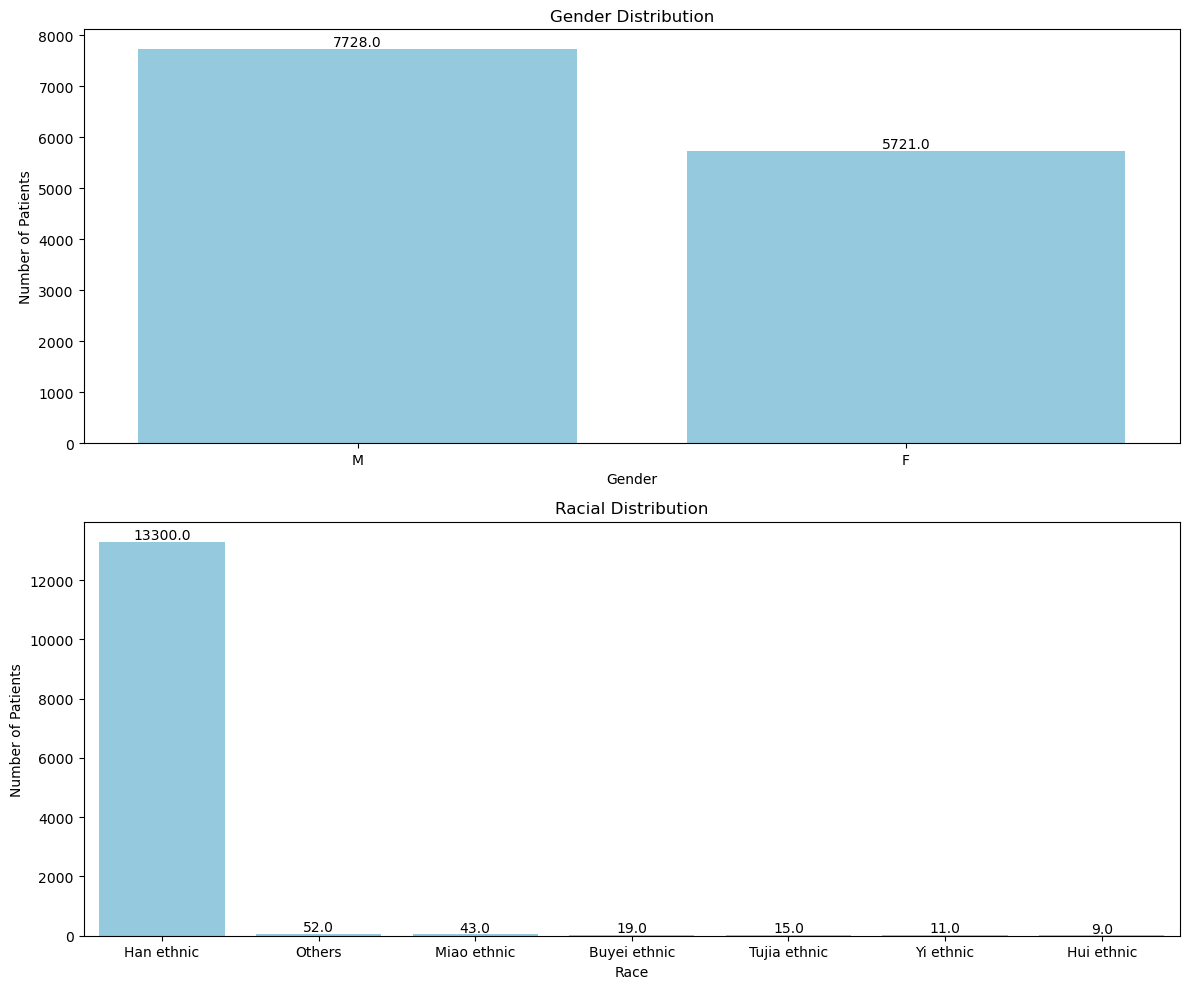

In [ ]:
# Gender distribution
gender_counts = merged_data['GENDER'].value_counts()

# Racial distribution
race_counts = merged_data['ETHNICITY'].value_counts()

# Create 2x2 subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Gender distribution
sns.barplot(x=gender_counts.index, y=gender_counts.values, color='skyblue', ax=axs[0])
axs[0].set_title('Gender Distribution')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Number of Patients')

# Racial distribution
sns.barplot(x=race_counts.index, y=race_counts.values, color='skyblue', ax=axs[1])
axs[1].set_title('Racial Distribution')
axs[1].set_xlabel('Race')
axs[1].set_ylabel('Number of Patients')
# Adding numerical values above the bars
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

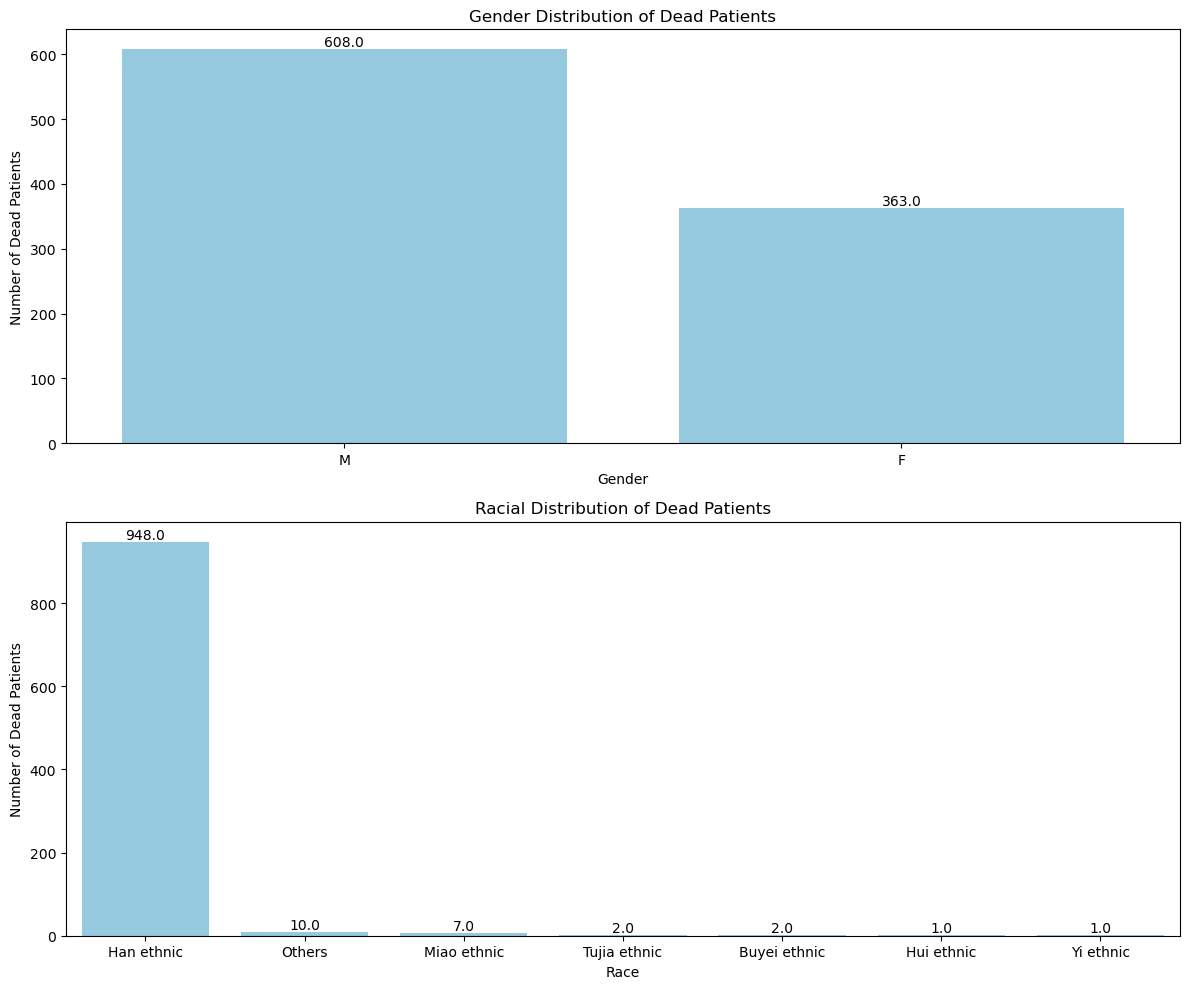

In [ ]:
dead_patients = merged_data[merged_data['HOSPITAL_EXPIRE_FLAG'] == '1']

# Gender distribution of dead patients
gender_counts_dead = dead_patients['GENDER'].value_counts()

# Racial distribution of dead patients
race_counts_dead = dead_patients['ETHNICITY'].value_counts()

# Create 2x1 subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Gender distribution of dead patients
sns.barplot(x=gender_counts_dead.index, y=gender_counts_dead.values, color='skyblue', ax=axs[0])
axs[0].set_title('Gender Distribution of Dead Patients')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Number of Dead Patients')

# Racial distribution of dead patients
sns.barplot(x=race_counts_dead.index, y=race_counts_dead.values, color='skyblue', ax=axs[1])
axs[1].set_title('Racial Distribution of Dead Patients')
axs[1].set_xlabel('Race')
axs[1].set_ylabel('Number of Dead Patients')

# Adding numerical values above the bars
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
patientsDf.set_index('SUBJECT_ID',inplace = True)

In [ ]:

# Assuming your dataset is stored in a DataFrame called 'admissionDF'

# Calculate the current count of each ethnicity
ethnicity_counts = admissionDf['ETHNICITY'].value_counts()

# Calculate the desired count for ethnicity 'A'
desired_count_A = len(admissionDf) // 2

# Calculate the number of 'A' ethnicities to convert
num_to_convert = ethnicity_counts['Han ethnic'] - desired_count_A

# Randomly select 'A' ethnicities to convert
indices_to_convert = admissionDf[admissionDf['ETHNICITY'] == 'Han ethnic'].sample(n=num_to_convert).index

# Create a list of other ethnicities excluding 'A'
other_ethnicities = [ethnicity for ethnicity in ethnicity_counts.index if ethnicity != 'Han ethnic']

# Randomly assign other ethnicities to the selected indices
admissionDf.loc[indices_to_convert, 'ETHNICITY'] = np.random.choice(other_ethnicities, size=num_to_convert)

# Verify the updated ethnicity distribution
print(admissionDf['ETHNICITY'].value_counts(normalize=True))

In [ ]:
merged_data = pd.merge(admissionDf, patientsDf, on='SUBJECT_ID',how='inner')

# Gender distribution
gender_counts = merged_data['GENDER'].value_counts()

# Racial distribution
race_counts = merged_data['ETHNICITY'].value_counts()

# Create 2x2 subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Gender distribution
sns.barplot(x=gender_counts.index, y=gender_counts.values, color='skyblue', ax=axs[0])
axs[0].set_title('Gender Distribution')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Number of Patients')

# Racial distribution
sns.barplot(x=race_counts.index, y=race_counts.values, color='skyblue', ax=axs[1])
axs[1].set_title('Racial Distribution')
axs[1].set_xlabel('Race')
axs[1].set_ylabel('Number of Patients')
# Adding numerical values above the bars
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
dead_patients = merged_data[merged_data['HOSPITAL_EXPIRE_FLAG'] == '1']

# Gender distribution of dead patients
gender_counts_dead = dead_patients['GENDER'].value_counts()

# Racial distribution of dead patients
race_counts_dead = dead_patients['ETHNICITY'].value_counts()

# Create 2x1 subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Gender distribution of dead patients
sns.barplot(x=gender_counts_dead.index, y=gender_counts_dead.values, color='skyblue', ax=axs[0])
axs[0].set_title('Gender Distribution of Dead Patients')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Number of Dead Patients')

# Racial distribution of dead patients
sns.barplot(x=race_counts_dead.index, y=race_counts_dead.values, color='skyblue', ax=axs[1])
axs[1].set_title('Racial Distribution of Dead Patients')
axs[1].set_xlabel('Race')
axs[1].set_ylabel('Number of Dead Patients')

# Adding numerical values above the bars
for ax in axs.flatten():
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
admissionDf.to_csv('D:\Phd\Data\PIC\ADMISSIONS.csv', index=False)

In [ ]:
# diagnosisDf = pd.read_csv(diagnosisFile)
# diagnosisDf['ICD9_CODE'] = diagnosisDf['ICD9_CODE'].astype(str)
# from icdmappings import Mapper
# mapper = Mapper()
# # Create a new column 'ICD_9' by mapping the ICD_10 codes to ICD_9 codes
# diagnosisDf['ICD9_CODE'] = mapper.map(diagnosisDf['ICD10_CODE'], source='icd10', target='icd9')

In [ ]:
# diagnosisDf.to_csv("D:\Phd\Data\PIC\D_ICD_DIAGNOSES.csv", index=False)

In [ ]:
# joined_df.head()
# joined_df.to_csv("D:\Phd\Data\PIC\DIAGNOSES_ICD.csv", index=False)

In [ ]:
# # Randomly sample 10,000 rows
# admissionDf = admissionDf.sample(n=2000, random_state=42)  # You can adjust the random_state for reproducibility

# print(len(admissionDf))

In [ ]:
print("Building Dataset")
data = {}
for row in tqdm(admissionDf.itertuples(), total=len(admissionDf)):
    hadm_id = row.HADM_ID
    subject_id = row.SUBJECT_ID
    admit_time = row.ADMITTIME
    ethnicity = row.ETHNICITY_MAP

    if subject_id not in patientsDf.index:
        continue
    visit_count = (0 if subject_id not in data else len(data[subject_id]["visits"])) + 1

    tsDf = (
        pd.read_csv(f"{timeseries_dir}{subject_id}/episode{visit_count}_timeseries.csv")
        if os.path.exists(
            f"{timeseries_dir}{subject_id}/episode{visit_count}_timeseries.csv"
        )
        else None
    )

    patientRow = patientsDf.loc[[subject_id]].iloc[0]
    age = (admit_time.to_pydatetime() - patientRow["DOB"].to_pydatetime()).days / 365
    # if age > 120:
    #     continue

    # Extracting the Diagnoses
    if hadm_id in diagnosisDf.index:
        diagnoses = list(set(diagnosisDf.loc[[hadm_id]]["ICD9_CODE"]))
    else:
        diagnoses = []

    # Extracting the Procedures
    if hadm_id in procedureDf.index:
        procedures = list(set(procedureDf.loc[[hadm_id]]["ICD9_CODE"]))
    else:
        procedures = []

    # Extracting the Medications
    if hadm_id in medicationDf.index:
        medications = list(set(medicationDf.loc[[hadm_id]]["DC"]))
    else:
        medications = []

    # Extract the lab timeseries
    labs = []
    prevTime = 0
    currTime = int(tsDf.iloc[0]["Hours"]) if tsDf is not None else 0
    currMask = []
    currValues = []
    if tsDf is not None:
        for i, row in tsDf.iterrows():
            rowTime = int(row["Hours"])

            if rowTime != currTime:
                labs.append((currMask, currValues, [currTime - prevTime]))
                prevTime = currTime
                currTime = rowTime
                currMask = []
                currValues = []

            for col, value in row.items():
                if value != value or col == "Hours":
                    continue

                if is_categorical_channel[col]:
                    if col == "Glascow coma scale total":
                        value = str(int(value))
                    elif col == "Capillary refill rate":
                        value = str(value)

                    if begin_pos[channel_to_id[col]] in currMask:
                        currValues[
                            currMask.index(
                                begin_pos[channel_to_id[col]]
                                + possible_values[col].index(value)
                            )
                        ] = 1
                    else:
                        for j in range(
                            begin_pos[channel_to_id[col]], end_pos[channel_to_id[col]]
                        ):
                            currMask.append(j)
                            currValues.append(
                                1
                                if j - begin_pos[channel_to_id[col]]
                                == possible_values[col].index(value)
                                else 0
                            )
                else:
                    if begin_pos[channel_to_id[col]] in currMask:
                        currValues[
                            currMask.index(begin_pos[channel_to_id[col]])
                        ] = value
                    else:
                        currMask.append(begin_pos[channel_to_id[col]])
                        currValues.append(value)

        labs.append((currMask, currValues, [currTime - prevTime]))

        # Building the hospital admission data point
    if subject_id not in data:
        data[subject_id] = {
            "visits": [(diagnoses, procedures, medications, age, labs)],
            "gender": patientRow.GENDER_MAP,
            "ethnicity": ethnicity,
            "isDead": patientRow.EXPIRE_FLAG,
        }
    else:
        data[subject_id]["visits"].append(
            (diagnoses, procedures, medications, age, labs)
        )
pickle.dump(data, open("./data/data_genDatasetContinuous.pkl", "wb"))

In [ ]:
# Build the label mapping
print("Adding Labels")
with open("../hcup_ccs_2015_definitions_benchmark.yaml") as definitions_file:
    definitions = yaml.full_load(definitions_file)

code_to_group = {}
for group in definitions:
    if definitions[group]["use_in_benchmark"] == False:
        continue
    codes = definitions[group]["codes"]
    for code in codes:
        if code not in code_to_group:
            code_to_group[code] = group
        else:
            assert code_to_group[code] == group

id_to_group = sorted(
    [k for k in definitions.keys() if definitions[k]["use_in_benchmark"] == True]
)
group_to_id = dict((x, i) for (i, x) in enumerate(id_to_group))

for p in data:
    label = np.zeros(len(group_to_id))
    for v in data[p]["visits"]:
        for d in v[0]:
            d = str(d)
            if d not in code_to_group:
                continue

            label[group_to_id[code_to_group[d]]] = 1

    data[p]["labels"] = label
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["ethnicity"])
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["gender"])
    data[p]["labels"] = np.append(data[p]["labels"], data[p]["isDead"])

Adding Labels


In [ ]:
# Convert diagnoses, procedures, and medications to text
print("Converting Codes to Text")
medMapping = {row["DC"]: row["DRUG_NAME_EN"] for _, row in medicationDf.iterrows()}
for p in data:
    new_visits = []
    for v in data[p]["visits"]:
        new_visit = []
        for c in v[0]:
            new_visit.append(c)
        for c in v[1]:
            new_visit.append(c)
        for c in v[2]:
            if c in medMapping:
                new_visit.append(medMapping[c])
            else:
                new_visit.append(c)

        new_visits.append((new_visit, [], [], [v[3]]))

        for lab_v in v[4]:
            new_visits.append(([], lab_v[0], lab_v[1], lab_v[2]))
    data[p]["visits"] = new_visits

Converting Codes to Text


NameError: name 'medicationDf' is not defined

In [ ]:
# Convert diagnoses, procedures, and medications to indices

print("Converting Codes to Indices")
allCodes = list(set([c for p in data for v in data[p]["visits"] for c in v[0]]))
np.random.shuffle(allCodes)
code_to_index = {c: i for i, c in enumerate(allCodes)}
counter = 0
for p in data:
    new_visits = []
    for v in data[p]["visits"]:
        new_visit = []
        for c in v[0]:
            new_visit.append(code_to_index[c])

        new_visits.append((new_visit, v[1], v[2], v[3]))
    data[p]["visits"] = new_visits

index_to_code = {v: k for k, v in code_to_index.items()}
data = list(data.values())

MAX_TIME_STEPS = 150
data = [
    {"labels": data[i]["labels"], "visits": data[i]["visits"][: MAX_TIME_STEPS - 2]}
    for i in range(len(data))
]  # 2 for the start and label visits

Converting Codes to Indices


NameError: name 'data' is not defined

In [ ]:
len(data)

In [ ]:
# Train-Val-Test Split
print("Splitting Datasets")
train_dataset, test_dataset = train_test_split(
    data, test_size=0.1, random_state=4, shuffle=True
) # train 60, val 10, test 30
train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.1, random_state=4, shuffle=True
)

# Save Everything
print("Saving Everything")
print(len(index_to_code))
print(len(data[0]["labels"]))
pickle.dump(
    dict((i, x) for (x, i) in list(group_to_id.items())),
    open("./data/idToLabel.pkl", "wb"),
)
pickle.dump(index_to_code, open("./data/indexToCode.pkl", "wb"))
pickle.dump(data, open("./data/allData_pic.pkl", "wb"))
pickle.dump(train_dataset, open("./data/trainData.pkl", "wb"))
pickle.dump(val_dataset, open("./data/valData.pkl", "wb"))
pickle.dump(test_dataset, open("./data/testData.pkl", "wb"))

Splitting Datasets


NameError: name 'data' is not defined

# Fairness on Smaller Dataset

In [ ]:
import pickle
import random
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from pyhealth.metrics.binary import binary_metrics_fn
from pyhealth.metrics.fairness import fairness_metrics_fn
from pyhealth.models import RNN, Transformer
from pyhealth.trainer import Trainer
from pyhealth.datasets import SampleEHRDataset, get_dataloader, split_by_patient
from pyhealth.datasets.splitter import split_by_patient

allData = pickle.load(open("./data/allData_pic.pkl","rb"))
allData1000 = random.sample(allData,1000)
allData2500 = random.sample(allData,2500)
allData5000 = random.sample(allData,5000)
def transform_data(ehr_dataset):
    final_data = []
    patient_id = 0  # Starting patient ID

    for patient in ehr_dataset:
        for i, visit in enumerate(patient["visits"]):
            visit_data = {
                "visit_id": i,
                "patient_id": patient_id,
                "visit_codes": [[int(x) for x in visit[0]]],
                "gender": [[int(float(patient["labels"][26]))]],
                "ethnicity": [[int(float(patient["labels"][25]))]],
                "disease_label": [[int(float(x)) for x in patient["labels"][0:25]]],
                "label": int(float(patient["labels"][27])),
            }
            print(int(float(patient["labels"][27])))
            final_data.append(visit_data)
        patient_id += 1
    return final_data
def calculate_wtpr(y_true, y_prob, sensitive_attribute, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    subgroups = np.unique(sensitive_attribute)
    tpr_scores = {}

    for subgroup in subgroups:
        subgroup_mask = sensitive_attribute == subgroup
        y_true_subgroup = y_true[subgroup_mask]
        y_pred_subgroup = y_pred[subgroup_mask]

        confusion_mat = confusion_matrix(y_true_subgroup, y_pred_subgroup)

        if confusion_mat.size == 1:
            if y_true_subgroup[0] == 1:
                tp = confusion_mat[0, 0]
                fn = 0
            else:
                tp = 0
                fn = confusion_mat[0, 0]
            tn = fp = 0
        else:
            tn, fp, fn, tp = confusion_mat.ravel()

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        tpr_scores[subgroup] = tpr

    wtpr = np.mean(list(tpr_scores.values()))
    return wtpr

In [ ]:
allData_pic_1000 = random.sample(allData_pic,1000)
allData_pic_2500 = random.sample(allData_pic,2500)
allData_pic_5000 = random.sample(allData_pic,5000)
halo_1000_pic = random.sample(halo_ehr_dataset, 1000)

real_datasets = [allData_pic_1000]

for real_dataset in real_datasets:
    print(f"REAL DATASET SIZE IS {len(real_dataset)}")
    # for patient_visit in real_dataset:
    #     labels = patient_visit['labels']
    #     if labels[25] == 1:
    #         labels[27] = 1 if random.random() < 0.5 else 0

    combined_data = real_dataset

    for patient in combined_data:
        patient["labels"] = [int(float(label)) for label in patient["labels"]]#.tolist()]

    random.shuffle(combined_data)

    # Calculate the split indices
    total_length = len(combined_data)
    train_split = int(0.8 * total_length)
    val_split = int(0.9 * total_length)

    # Split the combined list into train, validation, and test sets
    train_ehr_data = combined_data[:train_split]
    val_ehr_data = combined_data[train_split:val_split]
    test_ehr_data = combined_data[val_split:]

    transformed_train_ehr_dataset = transform_data(train_ehr_data)
    transformed_val_ehr_dataset = transform_data(val_ehr_data)
    transformed_test_ehr_dataset = transform_data(test_ehr_data)
    transformed_combined_ehr_dataset = transform_data(combined_data)

    max_visit_codes_length = max(
        len(sample["visit_codes"][0]) for sample in transformed_combined_ehr_dataset
    )
    for sample in transformed_train_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    for sample in transformed_val_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    for sample in transformed_test_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    for sample in transformed_combined_ehr_dataset:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()

    formatted_train_ehr_dataset = SampleEHRDataset(samples=transformed_train_ehr_dataset)
    formatted_val_ehr_dataset = SampleEHRDataset(samples=transformed_val_ehr_dataset)
    formatted_test_ehr_dataset = SampleEHRDataset(samples=transformed_test_ehr_dataset)
    formatted_combined_ehr_dataset = SampleEHRDataset(samples=transformed_combined_ehr_dataset)

    # train_loader = get_dataloader(formatted_train_ehr_dataset, batch_size=64, shuffle=True)
    # val_loader = get_dataloader(formatted_val_ehr_dataset, batch_size=64, shuffle=False)
    # test_loader = get_dataloader(formatted_test_ehr_dataset, batch_size=64, shuffle=False)

    k = 5  # Number of folds
    fairness_scores = {
        "disparate_impact": [],
        "statistical_parity_difference": [],
        "wtpr": [],
    }

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
        fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
        fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

        transformermodel = Transformer(
            dataset=formatted_train_ehr_dataset,
            feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
            label_key="label",
            mode="binary",
        )
        train_loader = get_dataloader(fold_train_dataset, batch_size=64, shuffle=True)
        val_loader = get_dataloader(fold_val_dataset, batch_size=64, shuffle=True)
        trainer = Trainer(model=transformermodel)
        trainer.train(
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            epochs=30,
            monitor="pr_auc",
        )
        y_true, y_prob, loss = trainer.inference(val_loader)

        unprotected_group = 1  # han in eth
        sensitive_attribute_array= np.zeros(len(fold_val_dataset), dtype=int)
        for idx,visit in enumerate(fold_val_dataset):
                sensitive_attribute_value = visit["ethnicity"][0][0]
                if sensitive_attribute_value != unprotected_group:
                    sensitive_attribute_array[idx] = 1

        # Calculate fairness metrics for the current fold
        try:
            fold_fairness_metrics = fairness_metrics_fn(
            y_true,
            y_prob,
            sensitive_attributes=sensitive_attribute_array,
            favorable_outcome=1,
            metrics=None,
            threshold=0.5,)
            wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)
            fairness_scores["disparate_impact"].append(
                fold_fairness_metrics["disparate_impact"])
            fairness_scores["statistical_parity_difference"].append(
                fold_fairness_metrics["statistical_parity_difference"])
            fairness_scores["wtpr"].append(wtpr)
                # Calculate the mean and standard deviation for each fairness metric
        except:
            print("DI and WTPR undefined")
    print(f"SHOWING THE METRICS FOR DATASET {len(real_dataset)}")
    for metric, scores in fairness_scores.items():
        values = scores
        mean = np.mean(values)
        std = np.std(values)
        print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

REAL DATASET SIZE IS 1000
Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=256, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
  

Epoch 0 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-0, step-13 ---
loss: 28.7021


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 54.57it/s]

--- Eval epoch-0, step-13 ---
pr_auc: 0.1788
roc_auc: 0.5150
f1: 0.2333
loss: 24.6988
New best pr_auc score (0.1788) at epoch-0, step-13



Epoch 1 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-1, step-26 ---
loss: 19.6892


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.30it/s]

--- Eval epoch-1, step-26 ---
pr_auc: 0.2602
roc_auc: 0.5947
f1: 0.1026
loss: 8.9938
New best pr_auc score (0.2602) at epoch-1, step-26



Epoch 2 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-2, step-39 ---
loss: 13.0695


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.32it/s]

--- Eval epoch-2, step-39 ---
pr_auc: 0.2397
roc_auc: 0.6173
f1: 0.1818
loss: 13.0237



Epoch 3 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-3, step-52 ---
loss: 10.9990


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 59.09it/s]

--- Eval epoch-3, step-52 ---
pr_auc: 0.2822
roc_auc: 0.6248
f1: 0.2174
loss: 7.9278
New best pr_auc score (0.2822) at epoch-3, step-52



Epoch 4 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-4, step-65 ---
loss: 8.9570


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 66.11it/s]

--- Eval epoch-4, step-65 ---
pr_auc: 0.2809
roc_auc: 0.6687
f1: 0.3056
loss: 4.9838



Epoch 5 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-5, step-78 ---
loss: 6.7452


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 66.52it/s]

--- Eval epoch-5, step-78 ---
pr_auc: 0.2739
roc_auc: 0.6769
f1: 0.2812
loss: 9.1041



Epoch 6 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-6, step-91 ---
loss: 5.4614


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 74.53it/s]

--- Eval epoch-6, step-91 ---
pr_auc: 0.3246
roc_auc: 0.6747
f1: 0.2456
loss: 4.2162
New best pr_auc score (0.3246) at epoch-6, step-91



Epoch 7 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-7, step-104 ---
loss: 5.2049


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.41it/s]

--- Eval epoch-7, step-104 ---
pr_auc: 0.2955
roc_auc: 0.6438
f1: 0.0500
loss: 4.5714



Epoch 8 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-8, step-117 ---
loss: 5.0106


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.53it/s]

--- Eval epoch-8, step-117 ---
pr_auc: 0.3126
roc_auc: 0.6671
f1: 0.1739
loss: 7.3366



Epoch 9 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-9, step-130 ---
loss: 3.8971


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 109.42it/s]

--- Eval epoch-9, step-130 ---
pr_auc: 0.3043
roc_auc: 0.6992
f1: 0.1887
loss: 3.1868



Epoch 10 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-10, step-143 ---
loss: 2.8690


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.92it/s]

--- Eval epoch-10, step-143 ---
pr_auc: 0.2798
roc_auc: 0.6528
f1: 0.1702
loss: 2.6636



Epoch 11 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-11, step-156 ---
loss: 2.5476


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.79it/s]

--- Eval epoch-11, step-156 ---
pr_auc: 0.2938
roc_auc: 0.6547
f1: 0.1702
loss: 3.0568



Epoch 12 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-12, step-169 ---
loss: 2.5387


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.26it/s]

--- Eval epoch-12, step-169 ---
pr_auc: 0.3101
roc_auc: 0.6719
f1: 0.1000
loss: 2.7091



Epoch 13 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-13, step-182 ---
loss: 2.0455


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 86.98it/s]

--- Eval epoch-13, step-182 ---
pr_auc: 0.3137
roc_auc: 0.6892
f1: 0.0976
loss: 1.7745



Epoch 14 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-14, step-195 ---
loss: 1.6252


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.15it/s]

--- Eval epoch-14, step-195 ---
pr_auc: 0.2396
roc_auc: 0.6342
f1: 0.1562
loss: 1.6021



Epoch 15 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-15, step-208 ---
loss: 1.5618


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.01it/s]

--- Eval epoch-15, step-208 ---
pr_auc: 0.2921
roc_auc: 0.6890
f1: 0.3820
loss: 1.3188



Epoch 16 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-16, step-221 ---
loss: 1.2143


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 119.42it/s]

--- Eval epoch-16, step-221 ---
pr_auc: 0.2649
roc_auc: 0.6723
f1: 0.1905
loss: 0.9197



Epoch 17 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-17, step-234 ---
loss: 0.9743


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.88it/s]

--- Eval epoch-17, step-234 ---
pr_auc: 0.2767
roc_auc: 0.6463
f1: 0.1224
loss: 0.9915



Epoch 18 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-18, step-247 ---
loss: 0.9202


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.69it/s]

--- Eval epoch-18, step-247 ---
pr_auc: 0.2311
roc_auc: 0.6435
f1: 0.0455
loss: 1.0584



Epoch 19 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-19, step-260 ---
loss: 0.9710


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.28it/s]

--- Eval epoch-19, step-260 ---
pr_auc: 0.2671
roc_auc: 0.6485
f1: 0.0513
loss: 1.0884



Epoch 20 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-20, step-273 ---
loss: 0.8927


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 103.80it/s]

--- Eval epoch-20, step-273 ---
pr_auc: 0.3280
roc_auc: 0.7110
f1: 0.1818
loss: 0.7668
New best pr_auc score (0.3280) at epoch-20, step-273



Epoch 21 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-21, step-286 ---
loss: 0.8206


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.75it/s]

--- Eval epoch-21, step-286 ---
pr_auc: 0.2890
roc_auc: 0.6487
f1: 0.1754
loss: 0.9340



Epoch 22 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-22, step-299 ---
loss: 0.9594


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.13it/s]

--- Eval epoch-22, step-299 ---
pr_auc: 0.2656
roc_auc: 0.6576
f1: 0.0476
loss: 1.1992



Epoch 23 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-23, step-312 ---
loss: 0.8082


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 101.03it/s]

--- Eval epoch-23, step-312 ---
pr_auc: 0.2736
roc_auc: 0.6329
f1: 0.0851
loss: 0.9726



Epoch 24 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-24, step-325 ---
loss: 0.7884


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.30it/s]

--- Eval epoch-24, step-325 ---
pr_auc: 0.3565
roc_auc: 0.7294
f1: 0.1860
loss: 0.4976
New best pr_auc score (0.3565) at epoch-24, step-325



Epoch 25 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-25, step-338 ---
loss: 0.7377


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 100.67it/s]

--- Eval epoch-25, step-338 ---
pr_auc: 0.2624
roc_auc: 0.6560
f1: 0.0889
loss: 0.7979



Epoch 26 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-26, step-351 ---
loss: 0.8403


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.05it/s]

--- Eval epoch-26, step-351 ---
pr_auc: 0.3013
roc_auc: 0.7189
f1: 0.1600
loss: 0.7017



Epoch 27 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-27, step-364 ---
loss: 0.7903


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 113.20it/s]

--- Eval epoch-27, step-364 ---
pr_auc: 0.3270
roc_auc: 0.6875
f1: 0.2812
loss: 0.7863



Epoch 28 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-28, step-377 ---
loss: 0.8476


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.89it/s]

--- Eval epoch-28, step-377 ---
pr_auc: 0.2778
roc_auc: 0.6561
f1: 0.1961
loss: 0.7552



Epoch 29 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-29, step-390 ---
loss: 0.7002


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 98.17it/s]

--- Eval epoch-29, step-390 ---
pr_auc: 0.2796
roc_auc: 0.6932
f1: 0.1852
loss: 0.5734
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 77.92it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=256, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-0, step-13 ---
loss: 37.7915


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.67it/s]

--- Eval epoch-0, step-13 ---
pr_auc: 0.2376
roc_auc: 0.4966
f1: 0.0000
loss: 27.6536
New best pr_auc score (0.2376) at epoch-0, step-13



Epoch 1 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-1, step-26 ---
loss: 20.6145


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.81it/s]

--- Eval epoch-1, step-26 ---
pr_auc: 0.2200
roc_auc: 0.4964
f1: 0.0000
loss: 25.3984



Epoch 2 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-2, step-39 ---
loss: 17.0791


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.25it/s]

--- Eval epoch-2, step-39 ---
pr_auc: 0.2458
roc_auc: 0.5226
f1: 0.0833
loss: 12.2513
New best pr_auc score (0.2458) at epoch-2, step-39



Epoch 3 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-3, step-52 ---
loss: 10.1475


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.14it/s]

--- Eval epoch-3, step-52 ---
pr_auc: 0.2460
roc_auc: 0.5602
f1: 0.1714
loss: 11.3334
New best pr_auc score (0.2460) at epoch-3, step-52



Epoch 4 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-4, step-65 ---
loss: 8.0260


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 98.47it/s]

--- Eval epoch-4, step-65 ---
pr_auc: 0.2579
roc_auc: 0.5628
f1: 0.0816
loss: 13.5326
New best pr_auc score (0.2579) at epoch-4, step-65



Epoch 5 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-5, step-78 ---
loss: 7.0069


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.74it/s]

--- Eval epoch-5, step-78 ---
pr_auc: 0.2597
roc_auc: 0.5755
f1: 0.0755
loss: 10.3752
New best pr_auc score (0.2597) at epoch-5, step-78



Epoch 6 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-6, step-91 ---
loss: 5.3802


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.86it/s]

--- Eval epoch-6, step-91 ---
pr_auc: 0.2463
roc_auc: 0.5602
f1: 0.0741
loss: 9.5754



Epoch 7 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-7, step-104 ---
loss: 4.6550


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.31it/s]

--- Eval epoch-7, step-104 ---
pr_auc: 0.2674
roc_auc: 0.6038
f1: 0.1639
loss: 8.9715
New best pr_auc score (0.2674) at epoch-7, step-104



Epoch 8 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-8, step-117 ---
loss: 4.1319


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 98.12it/s]

--- Eval epoch-8, step-117 ---
pr_auc: 0.2833
roc_auc: 0.6157
f1: 0.1935
loss: 6.8419
New best pr_auc score (0.2833) at epoch-8, step-117



Epoch 9 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-9, step-130 ---
loss: 3.2897


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 80.38it/s]

--- Eval epoch-9, step-130 ---
pr_auc: 0.2532
roc_auc: 0.5928
f1: 0.1613
loss: 12.4428



Epoch 10 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-10, step-143 ---
loss: 2.9576


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.34it/s]

--- Eval epoch-10, step-143 ---
pr_auc: 0.2619
roc_auc: 0.6047
f1: 0.2319
loss: 6.3473



Epoch 11 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-11, step-156 ---
loss: 3.1379


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.86it/s]

--- Eval epoch-11, step-156 ---
pr_auc: 0.2731
roc_auc: 0.6240
f1: 0.3784
loss: 4.4124



Epoch 12 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-12, step-169 ---
loss: 3.1868


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.39it/s]

--- Eval epoch-12, step-169 ---
pr_auc: 0.2520
roc_auc: 0.5732
f1: 0.1875
loss: 7.2332



Epoch 13 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-13, step-182 ---
loss: 2.2283


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.36it/s]

--- Eval epoch-13, step-182 ---
pr_auc: 0.2475
roc_auc: 0.5821
f1: 0.0000
loss: 4.4149



Epoch 14 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-14, step-195 ---
loss: 2.1127


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.08it/s]

--- Eval epoch-14, step-195 ---
pr_auc: 0.2894
roc_auc: 0.6104
f1: 0.1935
loss: 3.4755
New best pr_auc score (0.2894) at epoch-14, step-195



Epoch 15 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-15, step-208 ---
loss: 1.5352


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.52it/s]

--- Eval epoch-15, step-208 ---
pr_auc: 0.2457
roc_auc: 0.5821
f1: 0.3404
loss: 4.4827



Epoch 16 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-16, step-221 ---
loss: 1.2683


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 101.21it/s]

--- Eval epoch-16, step-221 ---
pr_auc: 0.2760
roc_auc: 0.5943
f1: 0.2338
loss: 2.2836



Epoch 17 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-17, step-234 ---
loss: 1.0801


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 100.89it/s]

--- Eval epoch-17, step-234 ---
pr_auc: 0.3182
roc_auc: 0.6447
f1: 0.1509
loss: 1.7737
New best pr_auc score (0.3182) at epoch-17, step-234



Epoch 18 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-18, step-247 ---
loss: 1.1095


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.59it/s]

--- Eval epoch-18, step-247 ---
pr_auc: 0.2899
roc_auc: 0.6186
f1: 0.0816
loss: 2.0777



Epoch 19 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-19, step-260 ---
loss: 0.9204


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 103.57it/s]

--- Eval epoch-19, step-260 ---
pr_auc: 0.2823
roc_auc: 0.6175
f1: 0.1154
loss: 1.4939



Epoch 20 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-20, step-273 ---
loss: 0.8734


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 95.11it/s]

--- Eval epoch-20, step-273 ---
pr_auc: 0.2841
roc_auc: 0.6108
f1: 0.1455
loss: 1.0631



Epoch 21 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-21, step-286 ---
loss: 0.8486


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 110.26it/s]

--- Eval epoch-21, step-286 ---
pr_auc: 0.2885
roc_auc: 0.6071
f1: 0.0444
loss: 1.7970



Epoch 22 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-22, step-299 ---
loss: 0.8722


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.23it/s]

--- Eval epoch-22, step-299 ---
pr_auc: 0.2806
roc_auc: 0.6198
f1: 0.0800
loss: 1.4978



Epoch 23 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-23, step-312 ---
loss: 0.8332


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 97.37it/s]

--- Eval epoch-23, step-312 ---
pr_auc: 0.2609
roc_auc: 0.6118
f1: 0.1111
loss: 1.3723



Epoch 24 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-24, step-325 ---
loss: 0.7445


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.67it/s]

--- Eval epoch-24, step-325 ---
pr_auc: 0.3041
roc_auc: 0.6198
f1: 0.1455
loss: 1.6734



Epoch 25 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-25, step-338 ---
loss: 0.7900


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 80.87it/s]

--- Eval epoch-25, step-338 ---
pr_auc: 0.2463
roc_auc: 0.5417
f1: 0.0833
loss: 1.6679



Epoch 26 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-26, step-351 ---
loss: 1.0269


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.75it/s]

--- Eval epoch-26, step-351 ---
pr_auc: 0.2780
roc_auc: 0.6124
f1: 0.2034
loss: 1.3191



Epoch 27 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-27, step-364 ---
loss: 0.8027


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.40it/s]

--- Eval epoch-27, step-364 ---
pr_auc: 0.2339
roc_auc: 0.5736
f1: 0.1791
loss: 1.0999



Epoch 28 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-28, step-377 ---
loss: 0.9028


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 87.76it/s]

--- Eval epoch-28, step-377 ---
pr_auc: 0.2667
roc_auc: 0.5834
f1: 0.0816
loss: 2.1622



Epoch 29 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-29, step-390 ---
loss: 0.9943


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.94it/s]

--- Eval epoch-29, step-390 ---
pr_auc: 0.2784
roc_auc: 0.5981
f1: 0.1935
loss: 1.7239
Loaded best model



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.55it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=256, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Monitor: pr_auc
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-0, step-13 ---
loss: 25.2145


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.34it/s]

--- Eval epoch-0, step-13 ---
pr_auc: 0.1911
roc_auc: 0.4700
f1: 0.0000
loss: 10.0825
New best pr_auc score (0.1911) at epoch-0, step-13



Epoch 1 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-1, step-26 ---
loss: 14.6070


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.81it/s]

--- Eval epoch-1, step-26 ---
pr_auc: 0.2449
roc_auc: 0.5159
f1: 0.0000
loss: 13.9680
New best pr_auc score (0.2449) at epoch-1, step-26



Epoch 2 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-2, step-39 ---
loss: 11.7242


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 100.79it/s]

--- Eval epoch-2, step-39 ---
pr_auc: 0.2334
roc_auc: 0.5348
f1: 0.1111
loss: 6.0197



Epoch 3 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-3, step-52 ---
loss: 9.3106


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 72.82it/s]

--- Eval epoch-3, step-52 ---
pr_auc: 0.2242
roc_auc: 0.5446
f1: 0.1562
loss: 4.6434



Epoch 4 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-4, step-65 ---
loss: 7.3319


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.41it/s]

--- Eval epoch-4, step-65 ---
pr_auc: 0.2511
roc_auc: 0.5560
f1: 0.0000
loss: 13.2286
New best pr_auc score (0.2511) at epoch-4, step-65



Epoch 5 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-5, step-78 ---
loss: 6.6374


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 80.65it/s]

--- Eval epoch-5, step-78 ---
pr_auc: 0.2789
roc_auc: 0.5638
f1: 0.0000
loss: 8.7511
New best pr_auc score (0.2789) at epoch-5, step-78



Epoch 6 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-6, step-91 ---
loss: 6.2486


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.67it/s]

--- Eval epoch-6, step-91 ---
pr_auc: 0.3131
roc_auc: 0.6198
f1: 0.1250
loss: 4.3145
New best pr_auc score (0.3131) at epoch-6, step-91



Epoch 7 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-7, step-104 ---
loss: 4.5662


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.65it/s]

--- Eval epoch-7, step-104 ---
pr_auc: 0.3093
roc_auc: 0.5939
f1: 0.0870
loss: 4.7096



Epoch 8 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-8, step-117 ---
loss: 3.6689


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.92it/s]

--- Eval epoch-8, step-117 ---
pr_auc: 0.2805
roc_auc: 0.5863
f1: 0.0851
loss: 6.6860



Epoch 9 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-9, step-130 ---
loss: 3.5496


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.63it/s]

--- Eval epoch-9, step-130 ---
pr_auc: 0.2894
roc_auc: 0.6000
f1: 0.1867
loss: 2.9802



Epoch 10 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-10, step-143 ---
loss: 2.4383


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 102.66it/s]

--- Eval epoch-10, step-143 ---
pr_auc: 0.3264
roc_auc: 0.6405
f1: 0.1724
loss: 3.7435
New best pr_auc score (0.3264) at epoch-10, step-143



Epoch 11 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-11, step-156 ---
loss: 2.3780


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 107.25it/s]

--- Eval epoch-11, step-156 ---
pr_auc: 0.3492
roc_auc: 0.5955
f1: 0.1875
loss: 2.1069
New best pr_auc score (0.3492) at epoch-11, step-156



Epoch 12 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-12, step-169 ---
loss: 2.2060


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.45it/s]

--- Eval epoch-12, step-169 ---
pr_auc: 0.2891
roc_auc: 0.6224
f1: 0.3226
loss: 2.5116



Epoch 13 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-13, step-182 ---
loss: 1.9955


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.35it/s]

--- Eval epoch-13, step-182 ---
pr_auc: 0.2999
roc_auc: 0.6215
f1: 0.2105
loss: 2.2905



Epoch 14 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-14, step-195 ---
loss: 1.7273


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.09it/s]

--- Eval epoch-14, step-195 ---
pr_auc: 0.3136
roc_auc: 0.6359
f1: 0.4124
loss: 2.2392



Epoch 15 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-15, step-208 ---
loss: 1.2384


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.33it/s]

--- Eval epoch-15, step-208 ---
pr_auc: 0.3388
roc_auc: 0.6560
f1: 0.1176
loss: 1.7340



Epoch 16 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-16, step-221 ---
loss: 1.2418


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 74.36it/s]

--- Eval epoch-16, step-221 ---
pr_auc: 0.3179
roc_auc: 0.6157
f1: 0.1224
loss: 1.5882



Epoch 17 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-17, step-234 ---
loss: 0.9671


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 98.42it/s]

--- Eval epoch-17, step-234 ---
pr_auc: 0.2776
roc_auc: 0.6380
f1: 0.1053
loss: 1.4180



Epoch 18 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-18, step-247 ---
loss: 0.9414


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.89it/s]

--- Eval epoch-18, step-247 ---
pr_auc: 0.3262
roc_auc: 0.6605
f1: 0.2069
loss: 0.8222



Epoch 19 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-19, step-260 ---
loss: 1.0458


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 96.16it/s]

--- Eval epoch-19, step-260 ---
pr_auc: 0.3082
roc_auc: 0.6532
f1: 0.3689
loss: 1.0925



Epoch 20 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-20, step-273 ---
loss: 0.8870


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.59it/s]

--- Eval epoch-20, step-273 ---
pr_auc: 0.2745
roc_auc: 0.6182
f1: 0.3265
loss: 0.9433



Epoch 21 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-21, step-286 ---
loss: 0.8452


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.53it/s]

--- Eval epoch-21, step-286 ---
pr_auc: 0.3248
roc_auc: 0.6625
f1: 0.2703
loss: 0.6858



Epoch 22 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-22, step-299 ---
loss: 0.7676


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 103.81it/s]

--- Eval epoch-22, step-299 ---
pr_auc: 0.2883
roc_auc: 0.6244
f1: 0.2187
loss: 0.9233



Epoch 23 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-23, step-312 ---
loss: 0.7397


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 96.71it/s]

--- Eval epoch-23, step-312 ---
pr_auc: 0.2748
roc_auc: 0.6026
f1: 0.1091
loss: 1.0200



Epoch 24 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-24, step-325 ---
loss: 0.7271


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.75it/s]

--- Eval epoch-24, step-325 ---
pr_auc: 0.3011
roc_auc: 0.5934
f1: 0.1111
loss: 1.3430



Epoch 25 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-25, step-338 ---
loss: 0.8867


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 112.59it/s]

--- Eval epoch-25, step-338 ---
pr_auc: 0.2826
roc_auc: 0.6261
f1: 0.0000
loss: 1.4091



Epoch 26 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-26, step-351 ---
loss: 0.8113


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.59it/s]

--- Eval epoch-26, step-351 ---
pr_auc: 0.2810
roc_auc: 0.6371
f1: 0.1639
loss: 1.0394



Epoch 27 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-27, step-364 ---
loss: 0.7385


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 71.21it/s]

--- Eval epoch-27, step-364 ---
pr_auc: 0.2577
roc_auc: 0.5739
f1: 0.1091
loss: 0.9502



Epoch 28 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-28, step-377 ---
loss: 0.9080


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.90it/s]

--- Eval epoch-28, step-377 ---
pr_auc: 0.3036
roc_auc: 0.6159
f1: 0.1132
loss: 0.9373



Epoch 29 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-29, step-390 ---
loss: 0.8375


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.52it/s]

--- Eval epoch-29, step-390 ---
pr_auc: 0.3083
roc_auc: 0.6208
f1: 0.0784
loss: 0.7594
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.01it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=256, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Metrics: None
Device: cuda

Training:
Batch size: 64
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000019FBB6029E0>
Monitor: pr_auc
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-0, step-13 ---
loss: 28.7983


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 95.12it/s]

--- Eval epoch-0, step-13 ---
pr_auc: 0.1789
roc_auc: 0.5101
f1: 0.0426
loss: 10.8406
New best pr_auc score (0.1789) at epoch-0, step-13



Epoch 1 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-1, step-26 ---
loss: 17.4824


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.99it/s]

--- Eval epoch-1, step-26 ---
pr_auc: 0.2298
roc_auc: 0.5632
f1: 0.2892
loss: 8.4536
New best pr_auc score (0.2298) at epoch-1, step-26



Epoch 2 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-2, step-39 ---
loss: 12.7229


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 108.02it/s]

--- Eval epoch-2, step-39 ---
pr_auc: 0.1998
roc_auc: 0.5471
f1: 0.0000
loss: 10.8193



Epoch 3 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-3, step-52 ---
loss: 11.1629


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 108.26it/s]

--- Eval epoch-3, step-52 ---
pr_auc: 0.2351
roc_auc: 0.5758
f1: 0.0476
loss: 5.8059
New best pr_auc score (0.2351) at epoch-3, step-52



Epoch 4 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-4, step-65 ---
loss: 8.6217


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.53it/s]

--- Eval epoch-4, step-65 ---
pr_auc: 0.2142
roc_auc: 0.5814
f1: 0.0000
loss: 8.1069



Epoch 5 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-5, step-78 ---
loss: 7.5953


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 105.30it/s]

--- Eval epoch-5, step-78 ---
pr_auc: 0.2583
roc_auc: 0.6580
f1: 0.2462
loss: 3.9470
New best pr_auc score (0.2583) at epoch-5, step-78



Epoch 6 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-6, step-91 ---
loss: 5.5816


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.77it/s]

--- Eval epoch-6, step-91 ---
pr_auc: 0.2641
roc_auc: 0.6604
f1: 0.2439
loss: 3.2062
New best pr_auc score (0.2641) at epoch-6, step-91



Epoch 7 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-7, step-104 ---
loss: 5.1942


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.86it/s]

--- Eval epoch-7, step-104 ---
pr_auc: 0.2604
roc_auc: 0.6346
f1: 0.1509
loss: 2.9142



Epoch 8 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-8, step-117 ---
loss: 3.9484


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 79.06it/s]

--- Eval epoch-8, step-117 ---
pr_auc: 0.2495
roc_auc: 0.5973
f1: 0.0465
loss: 3.3117



Epoch 9 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-9, step-130 ---
loss: 3.4601


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.39it/s]

--- Eval epoch-9, step-130 ---
pr_auc: 0.2412
roc_auc: 0.6094
f1: 0.0000
loss: 3.8384



Epoch 10 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-10, step-143 ---
loss: 2.8751


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 87.17it/s]

--- Eval epoch-10, step-143 ---
pr_auc: 0.2944
roc_auc: 0.6831
f1: 0.2414
loss: 1.5969
New best pr_auc score (0.2944) at epoch-10, step-143



Epoch 11 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-11, step-156 ---
loss: 2.4901


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 83.66it/s]

--- Eval epoch-11, step-156 ---
pr_auc: 0.2706
roc_auc: 0.6383
f1: 0.2632
loss: 2.8598



Epoch 12 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-12, step-169 ---
loss: 2.4313


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.62it/s]

--- Eval epoch-12, step-169 ---
pr_auc: 0.2853
roc_auc: 0.6688
f1: 0.1961
loss: 1.4274



Epoch 13 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-13, step-182 ---
loss: 1.8369


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.56it/s]

--- Eval epoch-13, step-182 ---
pr_auc: 0.3462
roc_auc: 0.6833
f1: 0.3333
loss: 0.9993
New best pr_auc score (0.3462) at epoch-13, step-182



Epoch 14 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-14, step-195 ---
loss: 2.0907


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.45it/s]

--- Eval epoch-14, step-195 ---
pr_auc: 0.3410
roc_auc: 0.6692
f1: 0.1395
loss: 1.2391



Epoch 15 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-15, step-208 ---
loss: 1.6712


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.74it/s]

--- Eval epoch-15, step-208 ---
pr_auc: 0.3575
roc_auc: 0.6819
f1: 0.0513
loss: 1.5168
New best pr_auc score (0.3575) at epoch-15, step-208



Epoch 16 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-16, step-221 ---
loss: 1.3663


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 95.57it/s]

--- Eval epoch-16, step-221 ---
pr_auc: 0.3025
roc_auc: 0.6793
f1: 0.1818
loss: 0.9107



Epoch 17 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-17, step-234 ---
loss: 1.1189


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 96.57it/s]

--- Eval epoch-17, step-234 ---
pr_auc: 0.3231
roc_auc: 0.6941
f1: 0.3250
loss: 0.9276



Epoch 18 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-18, step-247 ---
loss: 1.0456


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.41it/s]

--- Eval epoch-18, step-247 ---
pr_auc: 0.3477
roc_auc: 0.7081
f1: 0.1364
loss: 0.6862



Epoch 19 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-19, step-260 ---
loss: 1.0338


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 72.38it/s]

--- Eval epoch-19, step-260 ---
pr_auc: 0.2986
roc_auc: 0.7275
f1: 0.1250
loss: 0.6871



Epoch 20 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-20, step-273 ---
loss: 0.9450


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 87.68it/s]

--- Eval epoch-20, step-273 ---
pr_auc: 0.3465
roc_auc: 0.7525
f1: 0.3836
loss: 0.6350



Epoch 21 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-21, step-286 ---
loss: 0.9268


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 95.59it/s]

--- Eval epoch-21, step-286 ---
pr_auc: 0.3301
roc_auc: 0.7025
f1: 0.3288
loss: 0.5556



Epoch 22 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-22, step-299 ---
loss: 0.7095


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 87.71it/s]

--- Eval epoch-22, step-299 ---
pr_auc: 0.3168
roc_auc: 0.6983
f1: 0.0930
loss: 0.9034



Epoch 23 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-23, step-312 ---
loss: 0.8040


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 99.67it/s]

--- Eval epoch-23, step-312 ---
pr_auc: 0.3045
roc_auc: 0.6970
f1: 0.1569
loss: 0.5703



Epoch 24 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-24, step-325 ---
loss: 0.8659


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.65it/s]

--- Eval epoch-24, step-325 ---
pr_auc: 0.2951
roc_auc: 0.6789
f1: 0.2500
loss: 0.5797



Epoch 25 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-25, step-338 ---
loss: 0.9410


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.78it/s]

--- Eval epoch-25, step-338 ---
pr_auc: 0.2942
roc_auc: 0.6563
f1: 0.1333
loss: 0.6215



Epoch 26 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-26, step-351 ---
loss: 0.7933


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.97it/s]

--- Eval epoch-26, step-351 ---
pr_auc: 0.3011
roc_auc: 0.6638
f1: 0.0476
loss: 0.8245



Epoch 27 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-27, step-364 ---
loss: 0.9336


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.89it/s]

--- Eval epoch-27, step-364 ---
pr_auc: 0.2867
roc_auc: 0.6639
f1: 0.1791
loss: 0.6963



Epoch 28 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-28, step-377 ---
loss: 0.8624


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 102.98it/s]

--- Eval epoch-28, step-377 ---
pr_auc: 0.2796
roc_auc: 0.6525
f1: 0.0000
loss: 0.8157



Epoch 29 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-29, step-390 ---
loss: 0.8997


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.66it/s]

--- Eval epoch-29, step-390 ---
pr_auc: 0.2603
roc_auc: 0.6323
f1: 0.0000
loss: 0.7290
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.73it/s]

DI and WTPR undefined
Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=256, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
      

Metrics: None
Device: cuda

Training:
Batch size: 64
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000019FBB6019F0>
Monitor: pr_auc
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-0, step-13 ---
loss: 21.8360


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.87it/s]

--- Eval epoch-0, step-13 ---
pr_auc: 0.1756
roc_auc: 0.4885
f1: 0.0000
loss: 13.2760
New best pr_auc score (0.1756) at epoch-0, step-13



Epoch 1 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-1, step-26 ---
loss: 13.7909


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 94.33it/s]

--- Eval epoch-1, step-26 ---
pr_auc: 0.1860
roc_auc: 0.4995
f1: 0.0000
loss: 6.7671
New best pr_auc score (0.1860) at epoch-1, step-26



Epoch 2 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-2, step-39 ---
loss: 10.1490


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.62it/s]

--- Eval epoch-2, step-39 ---
pr_auc: 0.2101
roc_auc: 0.5336
f1: 0.0000
loss: 7.4329
New best pr_auc score (0.2101) at epoch-2, step-39



Epoch 3 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-3, step-52 ---
loss: 7.6053


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.73it/s]

--- Eval epoch-3, step-52 ---
pr_auc: 0.2087
roc_auc: 0.5388
f1: 0.0000
loss: 7.2504



Epoch 4 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-4, step-65 ---
loss: 7.2104


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 101.19it/s]

--- Eval epoch-4, step-65 ---
pr_auc: 0.2161
roc_auc: 0.5453
f1: 0.0000
loss: 7.0342
New best pr_auc score (0.2161) at epoch-4, step-65



Epoch 5 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-5, step-78 ---
loss: 6.2165


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.03it/s]

--- Eval epoch-5, step-78 ---
pr_auc: 0.2369
roc_auc: 0.5923
f1: 0.1754
loss: 3.3724
New best pr_auc score (0.2369) at epoch-5, step-78



Epoch 6 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-6, step-91 ---
loss: 5.1787


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.48it/s]

--- Eval epoch-6, step-91 ---
pr_auc: 0.2552
roc_auc: 0.6231
f1: 0.3733
loss: 1.9775
New best pr_auc score (0.2552) at epoch-6, step-91



Epoch 7 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-7, step-104 ---
loss: 3.6489


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 110.15it/s]

--- Eval epoch-7, step-104 ---
pr_auc: 0.2369
roc_auc: 0.5924
f1: 0.0000
loss: 2.7328



Epoch 8 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-8, step-117 ---
loss: 2.9884


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.19it/s]

--- Eval epoch-8, step-117 ---
pr_auc: 0.3202
roc_auc: 0.6620
f1: 0.3390
loss: 1.3543
New best pr_auc score (0.3202) at epoch-8, step-117



Epoch 9 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-9, step-130 ---
loss: 2.6207


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 107.69it/s]

--- Eval epoch-9, step-130 ---
pr_auc: 0.2513
roc_auc: 0.6175
f1: 0.1364
loss: 1.3808



Epoch 10 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-10, step-143 ---
loss: 1.9177


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.82it/s]

--- Eval epoch-10, step-143 ---
pr_auc: 0.2913
roc_auc: 0.6373
f1: 0.2812
loss: 1.3093



Epoch 11 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-11, step-156 ---
loss: 1.3381


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 102.36it/s]

--- Eval epoch-11, step-156 ---
pr_auc: 0.2291
roc_auc: 0.5948
f1: 0.1379
loss: 1.3842



Epoch 12 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-12, step-169 ---
loss: 1.4069


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.08it/s]

--- Eval epoch-12, step-169 ---
pr_auc: 0.2504
roc_auc: 0.5835
f1: 0.0513
loss: 1.2757



Epoch 13 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-13, step-182 ---
loss: 1.1862


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.64it/s]

--- Eval epoch-13, step-182 ---
pr_auc: 0.2970
roc_auc: 0.6506
f1: 0.1053
loss: 0.9466



Epoch 14 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-14, step-195 ---
loss: 1.0225


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 86.62it/s]

--- Eval epoch-14, step-195 ---
pr_auc: 0.3173
roc_auc: 0.6858
f1: 0.0526
loss: 0.7112



Epoch 15 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-15, step-208 ---
loss: 1.0585


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.72it/s]

--- Eval epoch-15, step-208 ---
pr_auc: 0.2852
roc_auc: 0.6338
f1: 0.0000
loss: 0.9587



Epoch 16 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-16, step-221 ---
loss: 0.9469


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 109.36it/s]

--- Eval epoch-16, step-221 ---
pr_auc: 0.2004
roc_auc: 0.5579
f1: 0.0816
loss: 0.9104



Epoch 17 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-17, step-234 ---
loss: 1.0911


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 95.27it/s]

--- Eval epoch-17, step-234 ---
pr_auc: 0.3181
roc_auc: 0.6557
f1: 0.1429
loss: 0.6813



Epoch 18 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-18, step-247 ---
loss: 0.9729


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 107.30it/s]

--- Eval epoch-18, step-247 ---
pr_auc: 0.2258
roc_auc: 0.5878
f1: 0.0000
loss: 0.9482



Epoch 19 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-19, step-260 ---
loss: 1.0096


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.02it/s]

--- Eval epoch-19, step-260 ---
pr_auc: 0.2569
roc_auc: 0.6184
f1: 0.0909
loss: 0.7556



Epoch 20 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-20, step-273 ---
loss: 0.8051


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.42it/s]

--- Eval epoch-20, step-273 ---
pr_auc: 0.2528
roc_auc: 0.6272
f1: 0.0870
loss: 0.9932



Epoch 21 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-21, step-286 ---
loss: 0.8796


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 103.58it/s]

--- Eval epoch-21, step-286 ---
pr_auc: 0.2561
roc_auc: 0.6350
f1: 0.3014
loss: 0.6648



Epoch 22 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-22, step-299 ---
loss: 0.9136


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.31it/s]

--- Eval epoch-22, step-299 ---
pr_auc: 0.3956
roc_auc: 0.6931
f1: 0.2449
loss: 0.5497
New best pr_auc score (0.3956) at epoch-22, step-299



Epoch 23 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-23, step-312 ---
loss: 0.8576


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.91it/s]

--- Eval epoch-23, step-312 ---
pr_auc: 0.2821
roc_auc: 0.6262
f1: 0.1702
loss: 0.7817



Epoch 24 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-24, step-325 ---
loss: 0.8617


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.43it/s]

--- Eval epoch-24, step-325 ---
pr_auc: 0.2637
roc_auc: 0.5979
f1: 0.0541
loss: 0.7351



Epoch 25 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-25, step-338 ---
loss: 0.8406


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.78it/s]

--- Eval epoch-25, step-338 ---
pr_auc: 0.2269
roc_auc: 0.5581
f1: 0.3404
loss: 0.9366



Epoch 26 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-26, step-351 ---
loss: 0.8332


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.20it/s]

--- Eval epoch-26, step-351 ---
pr_auc: 0.2855
roc_auc: 0.6232
f1: 0.2581
loss: 0.8115



Epoch 27 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-27, step-364 ---
loss: 0.8612


Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 71.97it/s]

--- Eval epoch-27, step-364 ---
pr_auc: 0.2989
roc_auc: 0.6654
f1: 0.1739
loss: 0.5519



Epoch 28 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-28, step-377 ---
loss: 0.8284


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 104.54it/s]

--- Eval epoch-28, step-377 ---
pr_auc: 0.2575
roc_auc: 0.6268
f1: 0.2000
loss: 0.8835



Epoch 29 / 30:   0%|          | 0/13 [00:00<?, ?it/s]

--- Train epoch-29, step-390 ---
loss: 0.7671


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 106.03it/s]

--- Eval epoch-29, step-390 ---
pr_auc: 0.2991
roc_auc: 0.6320
f1: 0.2174
loss: 0.6304
Loaded best model



Evaluation: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.32it/s]

SHOWING THE METRICS FOR DATASET 1000
disparate_impact: Mean = 0.8699, Std = 0.5148
statistical_parity_difference: Mean = -0.0086, Std = 0.0364
wtpr: Mean = 0.1280, Std = 0.0310


# Discretization

In [ ]:
import pickle

trainData = pickle.load(open("data/trainData.pkl", "rb"))
valData = pickle.load(open("data/valData.pkl", "rb"))
idToLab = pickle.load(open("./data/idx_to_lab.pkl", "rb"))
labToNumber = {
    l: i for (i, l) in enumerate(pickle.load(open("./data/id_to_channel.pkl", "rb")))
}
isCategorical = pickle.load(open("./data/is_categorical_channel.pkl", "rb"))
beginPos = pickle.load(open("./data/begin_pos.pkl", "rb"))
possibleValues = pickle.load(open("./data/possible_values.pkl", "rb"))
variableRanges = pickle.load(open("./data/variable_ranges.pkl", "rb"))
discretization = {
    "Diastolic blood pressure": [
        0,
        40,
        50,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        95,
        100,
        105,
        110,
        120,
        130,
        375,
    ],
    "Fraction inspired oxygen": [
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
        1.001,
        1.1,
    ],
    "Glucose": [
        0,
        40,
        60,
        80,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        200,
        225,
        275,
        325,
        400,
        600,
        800,
        1000,
        2200,
    ],
    "Heart Rate": [0, 40, 50, 60, 70, 80, 90, 100, 110, 120, 140, 160, 180, 200, 390],
    "Height": [0, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 230],
    "Mean blood pressure": [
        0,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        180,
        200,
        375,
    ],
    "Oxygen saturation": [
        0,
        30,
        40,
        50,
        55,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        100,
        100.001,
        150,
    ],
    "pH": [6.3, 6.7, 7.1, 7.35, 7.45, 7.6, 8.0, 8.3, 10],
    "Respiratory rate": [0, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 330],
    "Systolic blood pressure": [
        0,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        190,
        200,
        210,
        230,
        375,
    ],
    "Temperature": [
        14.2,
        30,
        32,
        33,
        33.5,
        34,
        34.5,
        35,
        35.5,
        36,
        36.5,
        37,
        37.5,
        38,
        38.5,
        39,
        39.5,
        40,
        47,
    ],
    "Weight": [
        0,
        30,
        40,
        45,
        50,
        55,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        95,
        100,
        105,
        110,
        115,
        120,
        125,
        130,
        135,
        140,
        145,
        150,
        160,
        170,
        190,
        210,
        250,
    ],
    "Age": [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
    "Days": [0, 11, 16, 21, 25, 30.1, 35.1, 43, 48, 54, 60, 66, 72, 81, 90, 100.1],
    "Hours": [
        0,
        0.5,
        1.5,
        2.5,
        3.5,
        6.5,
        10.5,
        16.5,
        26.5,
        48.0,
        48.1,
        60.1,
        80.1,
        110.1,
        150.1,
        200.1,
    ],
}

formatMap = {
    "Diastolic blood pressure": (".0f", int),
    "Fraction inspired oxygen": (".2f", float),
    "Glucose": (".0f", int),
    "Heart Rate": (".0f", int),
    "Height": (".0f", int),
    "Mean blood pressure": (".0f", int),
    "Oxygen saturation": (".0f", int),
    "pH": (".2f", float),
    "Respiratory rate": (".0f", int),
    "Systolic blood pressure": (".0f", int),
    "Temperature": (".1f", float),
    "Weight": (".1f", float),
    "Age": (".2f", float),
    "Days": (".2f", float),
    "Hours": (".1f", float),
}


def get_index(mapping, key, value):
    possible_values = mapping[key]
    for i in range(len(possible_values) - 1):
        if value < possible_values[i + 1]:
            return i

    print(f"{value} for {key} not in {possible_values}")
    return len(possible_values) - 2


# Convert to New Data Format
for p in trainData + valData:
    new_visits = []
    firstVisit = True
    for v in p["visits"]:
        if v[1] == []:
            new_cont = get_index(
                discretization, "Age" if firstVisit else "Days", v[3][-1]
            )
            firstVisit = False
            new_visits.append((v[0], [], [], [new_cont]))
        else:
            new_labs = []
            new_values = []
            for l, val in zip(v[1], v[2]):
                if isCategorical[idToLab[l]]:
                    if val == 1:
                        new_labs.append(labToNumber[idToLab[l]])
                        new_values.append(beginPos[labToNumber[idToLab[l]]] - l)
                else:
                    if (
                        val < variableRanges[idToLab[l]][0]
                        or val >= variableRanges[idToLab[l]][1]
                    ):
                        continue

                    new_labs.append(labToNumber[idToLab[l]])
                    new_values.append(get_index(discretization, idToLab[l], val))

            if not new_labs:
                continue
            new_cont = get_index(discretization, "Hours", v[3][-1])
            new_visits.append((v[0], new_labs, new_values, [new_cont]))

    p["visits"] = new_visits

pickle.dump(trainData, open("./discretized_data/trainDataset.pkl", "wb"))
pickle.dump(valData, open("./discretized_data/valDataset.pkl", "wb"))

newIdToLab = {i: l for (l, i) in labToNumber.items()}
newBeginPos = []
seenContinuous = False
for i in range(len(newIdToLab)):
    if not seenContinuous:
        newBeginPos.append(beginPos[i])
        if not isCategorical[newIdToLab[i]]:
            seenContinuous = True
            currPos = newBeginPos[i] + len(discretization[newIdToLab[i]]) - 1
    else:
        newBeginPos.append(currPos)
        currPos += len(discretization[newIdToLab[i]]) - 1

newIdxToId = {}
for i in range(len(newBeginPos) - 1):
    for j in range(newBeginPos[i], newBeginPos[i + 1]):
        newIdxToId[j] = i
for j in range(
    newBeginPos[-1],
    newBeginPos[-1] + len(discretization[newIdToLab[len(newBeginPos) - 1]]) - 1,
):
    newIdxToId[j] = len(newBeginPos) - 1

pickle.dump(newIdxToId, open("discretized_data/idxToId.pkl", "wb"))
pickle.dump(formatMap, open("discretized_data/formatMap.pkl", "wb"))
pickle.dump(newIdToLab, open("discretized_data/idToLab.pkl", "wb"))
pickle.dump(newBeginPos, open("discretized_data/beginPos.pkl", "wb"))
pickle.dump(isCategorical, open("discretized_data/isCategorical.pkl", "wb"))
pickle.dump(possibleValues, open("discretized_data/possibleValues.pkl", "wb"))
pickle.dump(discretization, open("discretized_data/discretization.pkl", "wb"))

print(f"NUM LABS: {newBeginPos[-1] + len(discretization[newIdToLab[16]]) - 1}")
print(f"NUM CONTINUOUS: {len(discretization['Age']) - 1}")

# Model

In [ ]:
'''
    code by Brandon Theodorou
    Original GPT-2 Paper and repository here: https://github.com/openai/gpt-2
    Original GPT-2 Pytorch Model: https://github.com/huggingface/pytorch-pretrained-BERT
    GPT-2 Pytorch Model Derived From: https://github.com/graykode/gpt-2-Pytorch
'''
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# GELU Activation and Layer Normalization:
# gelu(x): Gaussian Error Linear Unit (GELU) activation function.
# LayerNorm: Layer normalization module with learnable parameters.
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root)."""
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

# 1D convolutional layer with learnable weight and bias parameters.
class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x

# Self-attention mechanism with scaled dot-product attention. It includes convolutional layers for query, key, and value projections.
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        assert n_state % config.n_head == 0
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        b = self.bias[:, :, ns-nd:ns, :ns]
        w = w * b - 1e10 * (1 - b)
        w = nn.Softmax(dim=-1)(w)
        return torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def forward(self, x, layer_past=None):
        x = self.c_attn(x)
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)
        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        a = self._attn(query, key, value)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        return a, present

# Multi-Layer Perceptron module with a fully connected layer, activation function (GELU), and another fully connected layer.
class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        self.c_fc = Conv1D(n_state, nx)
        self.c_proj = Conv1D(nx, n_state)
        self.act = gelu

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return h2

# A block containing layer normalization, attention mechanism, and an MLP. These blocks are stacked to form the transformer model.
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, layer_past=None):
        a, present = self.attn(self.ln_1(x), layer_past=layer_past)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x, present

# The main transformer model composed of stacked blocks. It includes positional and visit embeddings.
class CoarseTransformerModel(nn.Module):
    def __init__(self, config):
        super(CoarseTransformerModel, self).__init__()
        self.n_layer = config.n_layer
        self.n_embd = config.n_embd
        self.n_vocab = config.total_vocab_size

        self.vis_embed_mat = nn.Linear(config.total_vocab_size, config.n_embd, bias=False)
        self.pos_embed_mat = nn.Embedding(config.n_positions, config.n_embd)
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

    def forward(self, input_visits, position_ids=None, past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_visits.size(1) + past_length, dtype=torch.long,
                                        device=input_visits.device)
            position_ids = position_ids.unsqueeze(0).expand(input_visits.size(0), input_visits.size(1))

        inputs_embeds = self.vis_embed_mat(input_visits)
        position_embeds = self.pos_embed_mat(position_ids)
        hidden_states = inputs_embeds + position_embeds
        for block, layer_past in zip(self.h, past):
            hidden_states, _ = block(hidden_states, layer_past)
        hidden_states = self.ln_f(hidden_states)
        return hidden_states

# Linear layer with a configurable mask on the weights, ensuring an autoregressive property.
class AutoregressiveLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.tril(torch.ones(in_features, out_features)).int())

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

    #A specific head that uses autoregressive linear layers for generating synthetic EHR data.
class FineAutoregressiveHead(nn.Module):
    def __init__(self, config):
        super(FineAutoregressiveHead, self).__init__()
        self.n_embd = config.n_embd
        self.total_vocab_size = config.total_vocab_size

        self.auto1 = AutoregressiveLinear(config.n_embd + self.total_vocab_size, config.n_embd + self.total_vocab_size)
        self.auto2 = AutoregressiveLinear(config.n_embd + self.total_vocab_size, config.n_embd + self.total_vocab_size)

    def forward(self, history, input_visits):
        history = history[:,:-1,:]
        input_visits = input_visits[:,1:,:]
        code_logits = self.auto2(torch.relu(self.auto1(torch.cat((history, input_visits), dim=2))))[:,:,self.n_embd-1:-1]
        return code_logits

    def sample(self, history, input_visits):
        history = history[:,:-1,:]
        input_visits = input_visits[:,1:,:]
        currVisit = torch.cat((history, input_visits), dim=2)[:,-1,:].unsqueeze(1)
        code_logits = self.auto2(torch.relu(self.auto1(currVisit)))[:,:,self.n_embd-1:-1]
        return code_logits

class HALOModel(nn.Module):
    def __init__(self, config):
        super(HALOModel, self).__init__()
        self.transformer = CoarseTransformerModel(config) # visit level
        self.ehr_head = FineAutoregressiveHead(config) # code level
        self.total_vocab_size = config.total_vocab_size

    def disparate_impact_loss_gen(self, code_probs, input_genders):
        # Get the unique gender labels
        gender_labels = torch.unique(input_genders)

        # Initialize variables to store the sum and count of positive predictions for each gender group
        gender_pos_sum = torch.zeros(len(gender_labels), device=code_probs.device)
        gender_pos_count = torch.zeros(len(gender_labels), device=code_probs.device)

        # Iterate over each patient
        for i in range(code_probs.size(0)):
            gender = input_genders[i]
            gender_idx = (gender_labels == gender).nonzero(as_tuple=True)[0]

            # Count the number of positive predictions for each gender group
            pos_pred = (code_probs[i] > 0.5).sum().item()
            gender_pos_sum[gender_idx] += pos_pred
            gender_pos_count[gender_idx] += 1

        # Calculate the positive prediction rate for each gender group
        gender_pos_rate = gender_pos_sum / gender_pos_count

        # Compute the disparate impact ratio
        if len(gender_pos_rate) > 1:
            di_ratio = gender_pos_rate[0] / gender_pos_rate[1]
        else:
            di_ratio = torch.tensor(1.0)  # Set di_ratio to 1 if there is only one gender group

        # Calculate the disparate impact loss
        di_loss = torch.abs(1 - di_ratio)

        return di_loss

    def disparate_impact_loss_eth(self, code_probs, input_ethnicities):
        # Get the unique ethnicity labels
        #print(code_probs)
        ethnicity_labels = torch.unique(input_ethnicities)

        # Initialize variables to store the sum and count of positive predictions for each ethnicity group
        ethnicity_pos_sum = torch.zeros(len(ethnicity_labels), device=code_probs.device)
        ethnicity_pos_count = torch.zeros(len(ethnicity_labels), device=code_probs.device)

        # Iterate over each patient
        for i in range(code_probs.size(0)):
            ethnicity = input_ethnicities[i]
            ethnicity_idx = (ethnicity_labels == ethnicity).nonzero(as_tuple=True)[0]

            # Count the number of positive predictions for each ethnicity group
            pos_pred = (code_probs[i] > 0.5).sum().item()
            ethnicity_pos_sum[ethnicity_idx] += pos_pred
            ethnicity_pos_count[ethnicity_idx] += 1

        # Calculate the positive prediction rate for each ethnicity group
        ethnicity_pos_rate = ethnicity_pos_sum / ethnicity_pos_count

        # Compute the disparate impact ratio
        if len(ethnicity_pos_rate) > 1:
            di_ratio = ethnicity_pos_rate[0] / ethnicity_pos_rate[1]
        else:
            di_ratio = torch.tensor(1.0)  # Set di_ratio to 1 if there is only one ethnicity group

        # Calculate the disparate impact loss
        di_loss = torch.abs(1 - di_ratio)

        return di_loss

    # def demographic_parity_loss_gen_eth(self, code_probs, input_genders, input_ethnicities):
    #     # Get the unique gender and ethnicity labels
    #     gender_labels = torch.unique(input_genders)
    #     ethnicity_labels = torch.unique(input_ethnicities)

    #     # Initialize variables to store the sum and count of code probabilities for each group
    #     group_probs_sum = torch.zeros(len(gender_labels), len(ethnicity_labels), device=code_probs.device)
    #     group_probs_count = torch.zeros(len(gender_labels), len(ethnicity_labels), device=code_probs.device)

    #     # Iterate over each patient
    #     for i in range(code_probs.size(0)):
    #         gender = input_genders[i]
    #         ethnicity = input_ethnicities[i]
    #         gender_idx = (gender_labels == gender).nonzero(as_tuple=True)[0]
    #         ethnicity_idx = (ethnicity_labels == ethnicity).nonzero(as_tuple=True)[0]
    #         group_probs_sum[gender_idx, ethnicity_idx] += code_probs[i].sum()
    #         group_probs_count[gender_idx, ethnicity_idx] += 1

    #     #print(f"Group_probs_count {group_probs_count}")
    #     # Calculate the average code probabilities for each group
    #     group_probs_avg = group_probs_sum / group_probs_count

    #     # Compute the absolute differences between the average code probabilities of all group pairs
    #     dp_losses = torch.abs(group_probs_avg.unsqueeze(1) - group_probs_avg.unsqueeze(0))
    #     #print(f"DP LOSSES {dp_losses}")
    #     # Take the mean of the absolute differences as the demographic parity loss
    #     dp_loss = torch.mean(dp_losses)
    #     #print(f"DP LOSS {dp_loss}")
    #     return dp_loss

    # def demographic_parity_loss_gen(self, code_probs, input_genders):
    #     # Get the unique gender labels
    #     gender_labels = torch.unique(input_genders)

    #     # Initialize variables to store the sum and count of code probabilities for each gender group
    #     gender_probs_sum = torch.zeros(len(gender_labels), code_probs.size(-1), device=code_probs.device)
    #     gender_probs_count = torch.zeros(len(gender_labels), device=code_probs.device)

    #     # Iterate over each patient
    #     for i in range(code_probs.size(0)):
    #         gender = input_genders[i]
    #         gender_idx = (gender_labels == gender).nonzero(as_tuple=True)[0]
    #         gender_probs_sum[gender_idx] += code_probs[i].sum(dim=0)
    #         gender_probs_count[gender_idx] += code_probs[i].size(0)

    #     # Calculate the average code probabilities for each gender group
    #     gender_probs_avg = gender_probs_sum / gender_probs_count.view(-1, 1)

    #     # Compute the absolute difference between the average code probabilities of the two gender groups
    #     gender_probs_diff = torch.abs(gender_probs_avg[0] - gender_probs_avg[1])

    #     # Take the mean or sum of the absolute differences as the demographic parity loss
    #     dp_loss = torch.mean(gender_probs_diff)  # or torch.sum(gender_probs_diff)

    #     return dp_loss

    # def demographic_parity_loss_eth(self, code_probs, input_ethnicities):
    #     # Get the unique ethnicity labels
    #     ethnicities_labels = torch.unique(input_ethnicities)
    #     num_ethnicities = len(ethnicities_labels)

    #     # Initialize variables to store the sum and count of code probabilities for each ethnicity group
    #     ethnicities_probs_sum = torch.zeros(num_ethnicities, code_probs.size(-1), device=code_probs.device)
    #     ethnicities_probs_count = torch.zeros(num_ethnicities, device=code_probs.device)

    #     # Iterate over each patient
    #     for i in range(code_probs.size(0)):
    #         ethnicity = input_ethnicities[i]
    #         ethnicity_idx = (ethnicities_labels == ethnicity).nonzero(as_tuple=True)[0]
    #         ethnicities_probs_sum[ethnicity_idx] += code_probs[i].sum(dim=0)
    #         ethnicities_probs_count[ethnicity_idx] += code_probs[i].size(0)

    #     # Calculate the average code probabilities for each ethnicity group
    #     ethnicities_probs_avg = ethnicities_probs_sum / ethnicities_probs_count.view(-1, 1)

    #     # Compute the absolute differences between the average code probabilities of all ethnicity pairs
    #     ethnicities_probs_diff = torch.abs(ethnicities_probs_avg.unsqueeze(0) - ethnicities_probs_avg.unsqueeze(1))

    #     # Take the mean or sum of the absolute differences as the demographic parity loss
    #     dp_loss = torch.mean(ethnicities_probs_diff)  # or torch.sum(ethnicities_probs_diff)

    #     return dp_loss

    def forward(self, input_visits, input_eth, fairness_metrics, input_ethnicities=None, position_ids=None, ehr_labels=None, ehr_masks=None, past=None, pos_loss_weight=None):

        hidden_states = self.transformer(input_visits, position_ids, past)
        code_logits = self.ehr_head(hidden_states, input_visits)
        sig = nn.Sigmoid()
        code_probs = sig(code_logits)
        if ehr_labels is not None:
            shift_labels = torch.clamp(ehr_labels[..., 1:, :].contiguous(), min=0.0, max=1.0)
            loss_weights = None
            if pos_loss_weight is not None:
                loss_weights = torch.ones(code_probs.shape, device=code_probs.device)
                loss_weights = loss_weights + (pos_loss_weight-1) * shift_labels
            if ehr_masks is not None:
                code_probs = code_probs * ehr_masks
                shift_labels = shift_labels * ehr_masks
                if pos_loss_weight is not None:
                    loss_weights = loss_weights * ehr_masks

            bce = nn.BCELoss(weight=loss_weights)
            loss = bce(code_probs, shift_labels)
            if input_eth is not None:
                di_loss = self.disparate_impact_loss_eth(code_probs, input_eth)
                if fairness_metrics is None:
                    loss = loss + 0.5 * di_loss # CHANGE LAMBDA HERE
                else:
                    disparate_impact = torch.tensor(fairness_metrics['disparate_impact'], dtype=loss.dtype, device='cuda:0')
                    loss = (loss + disparate_impact).mean()
            return loss, code_probs, shift_labels
        return code_probs


    def sample(self, input_visits, random=True):
        sig = nn.Sigmoid()
        hidden_states = self.transformer(input_visits)
        i = 0
        while i < self.total_vocab_size:
            next_logits = self.ehr_head.sample(hidden_states, input_visits)
            next_probs = sig(next_logits)
            if random:
                visit = torch.bernoulli(next_probs)
            else:
                visit = torch.round(next_probs)

            remaining_visit = visit[:,0,i:]
            nonzero = torch.nonzero(remaining_visit, as_tuple=True)[1]
            if nonzero.numel() == 0:
                break

            first_nonzero = nonzero.min()
            input_visits[:,-1,i + first_nonzero] = visit[:,0,i + first_nonzero]
            i = i + first_nonzero + 1

        return input_visits

# Config

In [ ]:
class HALOConfig(object):
    def __init__(
            self,
            total_vocab_size=3241,
            code_vocab_size=2958,
            lab_vocab_size=237,
            continuous_vocab_size=15,
            label_vocab_size=28,
            special_vocab_size=3,

            categorical_lab_vocab_size=47,
            continuous_lab_vocab_size=190,

            phenotype_labels=25,
            ethnicity_labels=6,
            gender_labels=2,

            hidden_size = 128,

            fairness_weight = 1.0,

            n_positions=150,
            n_ctx=150, #context size
            n_embd=1440,
            n_layer=12,
            n_head=18,
            layer_norm_epsilon=1e-5,
            initializer_range=0.02,

            batch_size=10,
            sample_batch_size=25,
            epoch=1,
            lr=1e-4,
    ):
        self.total_vocab_size = total_vocab_size
        self.code_vocab_size = code_vocab_size
        self.label_vocab_size = label_vocab_size
        self.lab_vocab_size = lab_vocab_size
        self.categorical_lab_vocab_size = categorical_lab_vocab_size
        self.continuous_lab_vocab_size = continuous_lab_vocab_size
        self.continuous_vocab_size = continuous_vocab_size
        self.special_vocab_size = special_vocab_size
        self.phenotype_labels = phenotype_labels
        self.fairness_weight = fairness_weight
        self.gender_labels = gender_labels
        self.ethnicity_labels = ethnicity_labels
        self.hidden_size = hidden_size
        self.n_positions = n_positions
        self.n_ctx = n_ctx
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.batch_size = batch_size
        self.sample_batch_size = sample_batch_size
        self.epoch = epoch
        self.lr = lr

In [ ]:
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.empty_cache()

config = HALOConfig()

local_rank = -1
fp16 = False
if local_rank == -1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend="nccl")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(device)
train_ehr_dataset = pickle.load(open("/content/drive/MyDrive/Prelim_Code/discretized_data/trainData.pkl", "rb"))
val_ehr_dataset = pickle.load(open("/content/drive/MyDrive/Prelim_Code/discretized_data/valData.pkl", "rb"))

# Convert to fully codes
beginPos = pickle.load(open("/content/drive/MyDrive/Prelim_Code/discretized_data/beginPos.pkl", "rb"))
for p in train_ehr_dataset + val_ehr_dataset:
    new_visits = []
    for v in p["visits"]:
        new_idx = v[0]
        for l, val in zip(v[1], v[2]):
            new_idx.append(config.code_vocab_size + beginPos[l] + val)
        new_idx.append(config.code_vocab_size + config.lab_vocab_size + v[3][-1])
        new_visits.append(new_idx)

    p["visits"] = new_visits

def get_batch(loc, batch_size, mode):
    if mode == "train":
        ehr = train_ehr_dataset[loc : loc + batch_size]
    elif mode == "valid":
        ehr = val_ehr_dataset[loc : loc + batch_size]
    else:
        ehr = test_ehr_dataset[loc : loc + batch_size]

    batch_gender = np.zeros((len(ehr)))
    batch_eth = np.zeros((len(ehr)))
    batch_ehr = np.zeros(
        (len(ehr), config.n_ctx, config.total_vocab_size)
    )  # 3d array len(ehr) * config.n_ctx * config.total_vocab_size
    batch_mask = np.zeros(
        (len(ehr), config.n_ctx, 1)
    )  # 3d array len(ehr) * config.n_ctx * 1
    for i, p in enumerate(ehr):
        visits = p['visits']
        #print(f"Lenght of visits{len(visits)}")

        for i, p in enumerate(ehr):
            visits = p['visits']
            for j, v in enumerate(visits):
                try:
                    batch_ehr[i, j+2][v] = 1
                except IndexError:
                # Handle the out-of-bounds index
                    #print(f"Warning: Index {v} is out of bounds for batch_ehr[{i}, {j+2}]")
                    continue
                batch_mask[i, j+2] = 1
        batch_ehr[
            i,
            1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size : config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size,
        ] = np.array(
            p["labels"]
        )  # Set the patient labels

        batch_eth[i] = batch_ehr[
            i,
            1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            - 3,
        ]

        batch_ehr[
            i,
            len(visits) + 1,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            + 1,
        ] = 1  # Set the final visit to have the end token
        batch_ehr[
            i,
            len(visits) + 2 :,
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
            + 2,
        ] = 1  # Set the rest to the padded visit token

    batch_mask[:, 1] = 1  # Set the mask to cover the labels
    batch_ehr[
        :,
        0,
        config.code_vocab_size
        + config.lab_vocab_size
        + config.continuous_vocab_size
        + config.label_vocab_size,
    ] = 1  # Set the first visits to be the start token
    batch_mask = batch_mask[
        :, 1:, :
    ]  # Shift the mask to match the shifted labels and predictions the model will return

    return batch_ehr, batch_mask, batch_eth

def shuffle_training_data(train_ehr_dataset):
    np.random.shuffle(train_ehr_dataset)

cuda


In [ ]:
print(len(train_ehr_dataset))
print(len(val_ehr_dataset))

10432
1160


In [ ]:
model = HALOModel(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
# if os.path.exists("./save/halo_model"):
#     print("Loading previous model")
#     checkpoint = torch.load("./save/halo_model", map_location=torch.device(device))
#     model.load_state_dict(checkpoint["model"])
#     optimizer.load_state_dict(checkpoint["optimizer"])

# Train Model

global_loss = 1e2
for e in tqdm(range(config.epoch)):
    shuffle_training_data(train_ehr_dataset)
    for i in range(0, len(train_ehr_dataset), config.batch_size):
        model.train()

        batch_ehr, batch_mask, batch_eth = get_batch(i, config.batch_size, "train")
        batch_eth = torch.tensor(batch_eth, dtype=torch.float32).to(device)
        batch_ehr = torch.tensor(batch_ehr, dtype=torch.float32).to(device)
        batch_mask = torch.tensor(batch_mask, dtype=torch.float32).to(device)
        #print(batch_mask.shape)
        optimizer.zero_grad()
        loss, _, _ = model(
            batch_ehr,
            batch_eth,
            fairness_metrics = None,
            input_ethnicities=None,
            position_ids=None,
            ehr_labels=batch_ehr,
            ehr_masks=batch_mask,
        )
        # print(loss)
        loss.backward()
        optimizer.step()

        if i % (10*config.batch_size) == 0:
            print("Epoch %d, Iter %d: Training Loss:%.6f"%(e, i, loss))
        if i % (25*config.batch_size) == 0:
            if i == 0:
               continue
            print("I am entering eval stage")
            model.eval()

            with torch.no_grad():
                val_l = []
                for v_i in range(0, len(val_ehr_dataset), config.batch_size):
                    batch_ehr, batch_mask, batch_eth= get_batch(
                        v_i, config.batch_size, "valid"
                    )
                    batch_eth = torch.tensor(batch_eth, dtype=torch.float32).to(
                        device
                    )
                    # batch_ethnicities = torch.tensor(batch_ethnicities,dtype=torch.float32).to(device)
                    batch_ehr = torch.tensor(batch_ehr, dtype=torch.float32).to(device)
                    batch_mask = torch.tensor(batch_mask, dtype=torch.float32).to(
                        device
                    )
                    val_loss, _, _ = model(
                        batch_ehr,
                        batch_eth,
                        fairness_metrics = None,
                        input_ethnicities=None,
                        position_ids=None,
                        ehr_labels=batch_ehr,
                        ehr_masks=batch_mask,
                    )
                    val_l.append((val_loss).cpu().detach().numpy())

                cur_val_loss = np.mean(val_l)
                print("Epoch %d Validation Loss:%.7f" % (e, cur_val_loss))
                if math.isnan(cur_val_loss):
                    cur_val_loss = 0.001
                if cur_val_loss < global_loss:
                    global_loss = cur_val_loss
                    state = {
                        "model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "iteration": i,
                    }
                    torch.save(state, "/content/drive/MyDrive/Prelim_Code/save/halo_model_pic_lambda_0_5")
                    print("\n------------ Save best model ------------\n")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0, Iter 0: Training Loss:0.004660
Epoch 0, Iter 100: Training Loss:nan
Epoch 0, Iter 200: Training Loss:0.000149
I am entering eval stage
Epoch 0 Validation Loss:nan

------------ Save best model ------------

Epoch 0, Iter 300: Training Loss:nan
Epoch 0, Iter 400: Training Loss:nan
Epoch 0, Iter 500: Training Loss:nan
I am entering eval stage
Epoch 0 Validation Loss:nan
Epoch 0, Iter 600: Training Loss:nan
Epoch 0, Iter 700: Training Loss:nan
I am entering eval stage
Epoch 0 Validation Loss:nan
Epoch 0, Iter 800: Training Loss:nan
Epoch 0, Iter 900: Training Loss:0.000002
Epoch 0, Iter 1000: Training Loss:0.000002
I am entering eval stage
Epoch 0 Validation Loss:nan
Epoch 0, Iter 1100: Training Loss:nan
Epoch 0, Iter 1200: Training Loss:nan
I am entering eval stage
Epoch 0 Validation Loss:nan
Epoch 0, Iter 1300: Training Loss:nan
Epoch 0, Iter 1400: Training Loss:nan
Epoch 0, Iter 1500: Training Loss:nan
I am entering eval stage
Epoch 0 Validation Loss:nan
Epoch 0, Iter 1600: Tr

100%|██████████| 1/1 [11:44<00:00, 704.95s/it]


# Data Generation

In [ ]:
import json
import torch
import pickle
import random
import numpy as np
from sys import argv
from tqdm import tqdm

config = HALOConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HALOModel(config).to(device)
checkpoint = torch.load("save/halo_model_pic_lambda_0_5", map_location=torch.device(device))
model.load_state_dict(checkpoint["model"])
idxToId = pickle.load(open("discretized_data/idxToId.pkl", "rb"))
idToLab = pickle.load(open("discretized_data/idToLab.pkl", "rb"))
beginPos = pickle.load(open("discretized_data/beginPos.pkl", "rb"))
isCategorical = pickle.load(open("discretized_data/isCategorical.pkl", "rb"))
possible_values = pickle.load(open("discretized_data/possibleValues.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))

def sample_sequence(model, length, context, batch_size, device="cuda", sample=True):
    empty = torch.zeros(
        (1, 1, config.total_vocab_size), device=device, dtype=torch.float32
    ).repeat(batch_size, 1, 1)
    context = (
        torch.tensor(context, device=device, dtype=torch.float32)
        .unsqueeze(0)
        .repeat(batch_size, 1)
    )
    prev = context.unsqueeze(1)
    context = None
    with torch.no_grad():
        for _ in range(length - 1):
            prev = model.sample(torch.cat((prev, empty), dim=1), sample)
            if (
                torch.sum(
                    torch.sum(
                        prev[
                            :, :, config.code_vocab_size + config.label_vocab_size + 1
                        ],
                        dim=1,
                    )
                    .bool()
                    .int(),
                    dim=0,
                ).item()
                == batch_size
            ):
                break
    ehr = prev.cpu().detach().numpy()
    prev = None
    empty = None
    return ehr
def convert_ehr(ehrs, index_to_code=None):
    ehr_outputs = []
    for i in range(len(ehrs)):
        ehr = ehrs[i]
        ehr_output = []
        ethnicity_output = ehr[3]
        gender_output = ehr[2]
        labels_output = ehr[1][
            config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size : config.code_vocab_size
            + config.lab_vocab_size
            + config.continuous_vocab_size
            + config.label_vocab_size
        ]
        if index_to_code is not None:
            labels_output = [idToLabel[idx] for idx in np.nonzero(labels_output)[0]]


        for j in range(2, len(ehr)):
            visit = ehr[j]
            visit_output = []
            lab_mask = []
            lab_values = []
            cont_idx = -1
            indices = np.nonzero(visit)[0]
            end = False
            for idx in indices:
                if idx < config.code_vocab_size:
                    visit_output.append(
                        index_to_code[idx] if index_to_code is not None else idx
                    )
                elif idx < config.code_vocab_size + config.lab_vocab_size:
                    lab_idx = idx - (config.code_vocab_size)
                    lab_num = idxToId[lab_idx]
                    if lab_num in lab_mask:
                        continue
                    else:
                        lab_mask.append(lab_num)
                        lab_values.append(lab_idx - beginPos[lab_num])
                elif (
                    idx
                    < config.code_vocab_size
                    + config.lab_vocab_size
                    + config.continuous_vocab_size
                ):
                    cont_idx = (
                        cont_idx
                        if cont_idx != -1
                        else idx - (config.code_vocab_size + config.lab_vocab_size)
                    )
                elif (
                    idx
                    == config.code_vocab_size
                    + config.lab_vocab_size
                    + config.continuous_vocab_size
                    + config.label_vocab_size
                    + 1
                ):
                    end = True

            if cont_idx == -1:
                cont_idx = random.randint(0, config.continuous_vocab_size) - 1
            if visit_output != [] or lab_mask != []:
                ehr_output.append((visit_output, lab_mask, lab_values, [cont_idx]))
            if end:
                break

        ehr_outputs.append({"visits": ehr_output, "labels": labels_output, "gender":gender_output,"ethnicity":ethnicity_output})
    ehr = None
    ehr_output = None
    labels_output = None
    visit = None
    visit_output = None
    indices = None
    return ehr_outputs
pakEHRs = pickle.load(open("discretized_data/trainDataset.pkl", "rb"))

# Generate Synthetic EHR dataset
# totEHRs = len(pickle.load(open("discretized_data/trainDataset.pkl", "rb")))
totEHRs = 2000
stoken = np.zeros(config.total_vocab_size)
stoken[
    config.code_vocab_size
    + config.lab_vocab_size
    + config.continuous_vocab_size
    + config.label_vocab_size
] = 1
synthetic_ehr_dataset = []
for i in tqdm(range(0, totEHRs, config.sample_batch_size)):
    bs = min([totEHRs - i, config.sample_batch_size])
    batch_synthetic_ehrs = sample_sequence(
        model, config.n_ctx, stoken, batch_size=bs, device=device, sample=True
    )
    batch_synthetic_ehrs = convert_ehr(batch_synthetic_ehrs)
    synthetic_ehr_dataset += batch_synthetic_ehrs



100%|██████████| 80/80 [3:46:08<00:00, 169.61s/it]


In [ ]:
pickle.dump(synthetic_ehr_dataset, open(f"/results/haloDataset_lambda_0_5_2000_PIC.pkl", "wb"))

# Convert back to continuous

In [ ]:
import pickle
import random

idToLab = pickle.load(open("discretized_data/idToLab.pkl", "rb"))
isCategorical = pickle.load(open("discretized_data/isCategorical.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))
possibleValues = pickle.load(open("discretized_data/possibleValues.pkl", "rb"))
discretization = pickle.load(open("discretized_data/discretization.pkl", "rb"))
formatMap = pickle.load(open("discretized_data/formatMap.pkl", "rb"))

dataset = pickle.load(open("./results/datasets/haloDataset_lambda_1_5_2000_PIC.pkl", "rb"))

def formatCont(value, key):
    return formatMap[key][1](("{:" + formatMap[key][0] + "}").format(value))


for p in dataset:
    new_visits = []
    firstVisit = True
    for v in p["visits"]:
        new_labs = []
        new_values = []
        for i in range(len(v[1])):
            new_labs.append(idToLab[v[1][i]])
            if isCategorical[idToLab[v[1][i]]]:
                new_values.append(possibleValues[idToLab[v[1][i]]][v[2][i]])
            else:
                new_values.append(
                    formatCont(
                        random.uniform(
                            discretization[idToLab[v[1][i]]][v[2][i]],
                            discretization[idToLab[v[1][i]]][v[2][i] + 1],
                        ),
                        idToLab[v[1][i]],
                    )
                )
        contType = "Hours" if new_labs != [] else "Age" if firstVisit else "Days"
        if contType == "Age":
            firstVisit = False
        new_cont = formatCont(
            random.uniform(
                discretization[contType][v[3][-1]],
                discretization[contType][v[3][-1] + 1],
            ),
            contType,
        )
        new_visits.append((v[0], new_labs, new_values, [new_cont]))
    p["visits"] = new_visits

pickle.dump(dataset, open("results/datasets/haloDataset_lambda_1_5_2000_PIC.pkl", "wb"))

# Prediction Model

In [ ]:
import pickle
import random

import numpy as np
from pyhealth.datasets import SampleEHRDataset, get_dataloader, split_by_patient
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.models import MLP

In [ ]:
from torch.optim import Adam, AdamW, SGD
from pyhealth.models import MLP
def f1_calc(fixed_dataset, var_datasets, num_epochs):
    for var_dataset in var_datasets:
        f1_scores = []
        pr_auc_scores = []

        combined_data = fixed_dataset + var_dataset
        train_ehr_data = combined_data[:int(0.8 * len(combined_data))]
        max_visit_codes_length = max(len(sample["visit_codes"][0]) for sample in transform_data(combined_data))
        formatted_combined_ehr_dataset = formatter(combined_data, max_visit_codes_length)
        formatted_train_ehr_dataset = formatter(train_ehr_data, max_visit_codes_length)

        k = 5  # Number of folds
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
            fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
            fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

            transformermodel = Transformer(
                dataset=formatted_train_ehr_dataset,
                feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
                label_key="label",
                mode="binary",
            )
            train_loader = get_dataloader(fold_train_dataset, batch_size=32, shuffle=True)
            val_loader = get_dataloader(fold_val_dataset, batch_size=32, shuffle=True)

            trainer = Trainer(model=transformermodel)
            trainer.train(
                train_dataloader=train_loader,
                val_dataloader=val_loader,
                epochs=num_epochs,
                optimizer_class=AdamW,  # Using AdamW optimizer
                optimizer_params={'lr': 1e-3, 'weight_decay': 1e-4},  # Experiment with different learning rates and weight decay
                weight_decay=1e-4,
                max_grad_norm=1.0,  # Gradient clipping
                monitor='pr_auc',  # Monitoring PR AUC
                monitor_criterion='max',
                load_best_model_at_last=True  # Load the best model at the end
            )

            # y_true, y_prob, loss = trainer.inference(val_loader)
            # y_pred = (y_prob >= 0.5).astype(int)  # Adjust threshold if necessary
            score = trainer.evaluate(val_loader)
            f1 = score['f1']
            f1_scores.append(f1)
            pr_auc = score['pr_auc']
            pr_auc_scores.append(pr_auc)
        f1_mean = np.mean(f1_scores)
        f1_std = np.std(f1_scores)
        pr_auc_mean = np.mean(pr_auc_scores)
        pr_auc_std = np.std(pr_auc_scores)
        print(f"VARIABLE DATA SIZE: {len(var_dataset)}")
        print(f"F1-score: {f1_mean:.2f}±{f1_std:.2f}")
        print(f"PR AUC: {pr_auc_mean:.2f}±{pr_auc_std:.2f}")

# Experiments with lambda = 1.2

In [ ]:
def transform_data(ehr_dataset):
    final_data = []
    patient_id = 0  # Starting patient ID

    for patient in ehr_dataset:
        for i, visit in enumerate(patient["visits"]):
            visit_data = {
                "visit_id": i,
                "patient_id": patient_id,
                "visit_codes": [[int(x) for x in visit[0]]],
                "gender": [[int(float(patient["labels"][26]))]],
                "ethnicity": [[int(float(patient["labels"][25]))]],
                "disease_label": [[int(float(x)) for x in patient["labels"][0:25]]],
                "label": int(float(patient["labels"][27])),
            }
            final_data.append(visit_data)
        patient_id += 1
    return final_data

def calculate_wtpr(y_true, y_prob, sensitive_attribute, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    subgroups = np.unique(sensitive_attribute)
    tpr_scores = {}

    for subgroup in subgroups:
        subgroup_mask = sensitive_attribute == subgroup
        y_true_subgroup = y_true[subgroup_mask]
        y_pred_subgroup = y_pred[subgroup_mask]

        confusion_mat = confusion_matrix(y_true_subgroup, y_pred_subgroup)

        if confusion_mat.size == 1:
            if y_true_subgroup[0] == 1:
                tp = confusion_mat[0, 0]
                fn = 0
            else:
                tp = 0
                fn = confusion_mat[0, 0]
            tn = fp = 0
        else:
            tn, fp, fn, tp = confusion_mat.ravel()

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        tpr_scores[subgroup] = tpr

    wtpr = np.mean(list(tpr_scores.values()))
    return wtpr

def formatter(data, max_visit_codes_length):
    for patient in data:
        patient["labels"] = [int(float(label)) for label in patient["labels"]]
    random.shuffle(data)
    transformed_data = transform_data(data)
    for sample in transformed_data:
        visit_codes = sample["visit_codes"][0]
        padded_visit_codes = np.pad(
            visit_codes, (0, max_visit_codes_length - len(visit_codes)), mode="constant"
        )
        sample["visit_codes"][0] = padded_visit_codes.tolist()
    return SampleEHRDataset(samples=transformed_data)

In [ ]:
def fairness_acc_calc(fixed_dataset, var_datasets, num_epochs):
    for var_dataset in var_datasets:

        f1_scores = []
        fairness_scores = {
            "disparate_impact": [],
            "wtpr": [],
        }
        combined_data = fixed_dataset + var_dataset
        train_ehr_data = combined_data[:int(0.8 * len(combined_data))]
        max_visit_codes_length = max(len(sample["visit_codes"][0]) for sample in transform_data(combined_data))
        formatted_combined_ehr_dataset = formatter(combined_data, max_visit_codes_length)
        formatted_train_ehr_dataset = formatter(train_ehr_data, max_visit_codes_length)

        k = 5  # Number of folds
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        for train_index, val_index in kf.split(formatted_combined_ehr_dataset):
            fold_train_dataset = [formatted_combined_ehr_dataset[i] for i in train_index]
            fold_val_dataset = [formatted_combined_ehr_dataset[i] for i in val_index]

            transformermodel = Transformer(
                dataset=formatted_train_ehr_dataset,
                feature_keys=["visit_codes", "disease_label", "ethnicity", "gender"],
                label_key="label",
                mode="binary",
            )
            train_loader = get_dataloader(fold_train_dataset, batch_size=32, shuffle=True)
            val_loader = get_dataloader(fold_val_dataset, batch_size=32, shuffle=True)

            trainer = Trainer(model=transformermodel)
            trainer.train(
                train_dataloader=train_loader,
                val_dataloader=val_loader,
                epochs=num_epochs,
                optimizer_params={'lr': 1e-3, 'weight_decay': 1e-4},  # Experiment with different learning rates and weight decay
                weight_decay=1e-4,
                max_grad_norm=1.0,  # Gradient clipping
                monitor='pr_auc',  # Monitoring PR AUC
                monitor_criterion='max',
                load_best_model_at_last=True  # Load the best model at the end
            )
            unprotected_group = 1  # han in eth
            sensitive_attribute_array = np.zeros(len(fold_val_dataset), dtype=int)
            for idx, visit in enumerate(fold_val_dataset):
                sensitive_attribute_value = visit["ethnicity"][0][0]
                if sensitive_attribute_value != unprotected_group:
                    sensitive_attribute_array[idx] = 1

            # Calculate fairness metrics for the current fold
            # Calculate fairness metrics for the current fold
            try:
                fold_fairness_metrics = fairness_metrics_fn(
                y_true,
                y_prob,
                sensitive_attributes=sensitive_attribute_array,
                favorable_outcome=1,
                metrics=None,
                threshold=0.5,)
                wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)
                fairness_scores["disparate_impact"].append(fold_fairness_metrics["disparate_impact"])
                fairness_scores["statistical_parity_difference"].append(fold_fairness_metrics["statistical_parity_difference"])
                fairness_scores["wtpr"].append(wtpr)
            except:
                print("DI and WTPR undefined")
            y_true, y_prob, loss = trainer.inference(val_loader)
            wtpr = calculate_wtpr(y_true, y_prob, sensitive_attribute_array)
            fairness_scores["wtpr"].append(wtpr)

            # Calculate F1-score
            score = binary_metrics_fn(y_true, y_prob, metrics=["f1"])
            f1 = score['f1']
            f1_scores.append(f1)

        f1_mean = np.mean(f1_scores)
        f1_std = np.std(f1_scores)
        print(f"VARIABLE DATA SIZE: {len(var_dataset)}")
        print(f"F1-score: {f1_mean:.2f}±{f1_std:.2f}")
        for metric, scores in fairness_scores.items():
            mean = np.nanmean(scores)  # Use nanmean to ignore NaN values
            std = np.nanstd(scores)  # Use nanstd to ignore NaN values
            print(f"{metric}: {mean:.2f}±{std:.2f}")

# real_datasets = [allData_1000, allData_2500, all_data_5000]
# synth_datasets = pickle.load(open("./results/datasets/haloDataset_converted_lambda_1_2_2000_PIC.pkl", "rb"))
# fairness_acc_calc(fixed_dataset=synth_datasets, var_datasets=real_datasets, num_epochs=50)

In [ ]:
# Real + FAIRSYNTH EXPERIMENT lambda 1.2
all_data_5000 = pickle.load(open(f"./data/allData_pic.pkl", "rb"))
allData_1000 = all_data_5000[0:1000]
allData_2500 = all_data_5000[0:2500]
allData_5000 = all_data_5000[0:5000]

real_datasets= [allData_1000,allData_2500,all_data_5000]
synth_datasets= pickle.load(open("./results/datasets/haloDataset_converted_lambda_1_2_2000_PIC.pkl", "rb"))
fairness_acc_calc(fixed_dataset=synth_datasets,var_datasets=real_datasets,num_epochs=50)

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-0, step-7353 ---
loss: 0.1814


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.97it/s]

--- Eval epoch-0, step-7353 ---
pr_auc: 0.0307
roc_auc: 0.7628
f1: 0.0000
loss: 0.1992
New best pr_auc score (0.0307) at epoch-0, step-7353



Epoch 1 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-1, step-14706 ---
loss: 0.1693


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.44it/s]


--- Eval epoch-1, step-14706 ---
pr_auc: 0.0263
roc_auc: 0.7582
f1: 0.0000
loss: 0.1030



Epoch 2 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-2, step-22059 ---
loss: 0.1534


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 96.99it/s]

--- Eval epoch-2, step-22059 ---
pr_auc: 0.0117
roc_auc: 0.6424
f1: 0.0000
loss: 0.1464



Epoch 3 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-3, step-29412 ---
loss: 0.1394


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.85it/s]

--- Eval epoch-3, step-29412 ---
pr_auc: 0.0086
roc_auc: 0.6450
f1: 0.0000
loss: 0.1438



Epoch 4 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-4, step-36765 ---
loss: 0.1599


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.94it/s]

--- Eval epoch-4, step-36765 ---
pr_auc: 0.0014
roc_auc: 0.6091
f1: 0.0000
loss: 0.1447



Epoch 5 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-5, step-44118 ---
loss: 0.1374


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.34it/s]

--- Eval epoch-5, step-44118 ---


pr_auc: 0.0085
roc_auc: 0.6156
f1: 0.0000
loss: 0.1399



Epoch 6 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-6, step-51471 ---
loss: 0.1507


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.77it/s]

--- Eval epoch-6, step-51471 ---
pr_auc: 0.0293
roc_auc: 0.7559
f1: 0.0000
loss: 0.0927



Epoch 7 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-7, step-58824 ---
loss: 0.1498


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 96.61it/s]


--- Eval epoch-7, step-58824 ---
pr_auc: 0.0160
roc_auc: 0.6392
f1: 0.0000
loss: 0.1074



Epoch 8 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-8, step-66177 ---
loss: 0.1427


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 100.29it/s]

--- Eval epoch-8, step-66177 ---
pr_auc: 0.0225
roc_auc: 0.7497
f1: 0.0000
loss: 0.0724



Epoch 9 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-9, step-73530 ---
loss: 0.1347


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.90it/s]


--- Eval epoch-9, step-73530 ---
pr_auc: 0.0007
roc_auc: 0.6384
f1: 0.0000
loss: 0.0695



Epoch 10 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-10, step-80883 ---
loss: 0.1317


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.67it/s]

--- Eval epoch-10, step-80883 ---
pr_auc: 0.0519
roc_auc: 0.7618
f1: 0.0000
loss: 0.1113
New best pr_auc score (0.0519) at epoch-10, step-80883



Epoch 11 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-11, step-88236 ---
loss: 0.1461


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.99it/s]

--- Eval epoch-11, step-88236 ---
pr_auc: 0.0037
roc_auc: 0.6107
f1: 0.0000
loss: 0.0913



Epoch 12 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-12, step-95589 ---
loss: 0.1353


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.04it/s]

--- Eval epoch-12, step-95589 ---
pr_auc: 0.0453
roc_auc: 0.7489
f1: 0.0000
loss: 0.0506



Epoch 13 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-13, step-102942 ---
loss: 0.1360


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 96.14it/s]

--- Eval epoch-13, step-102942 ---
pr_auc: 0.0567
roc_auc: 0.6655
f1: 0.1818
loss: 0.0618
New best pr_auc score (0.0567) at epoch-13, step-102942



Epoch 14 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-14, step-110295 ---
loss: 0.1243


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.78it/s]

--- Eval epoch-14, step-110295 ---
pr_auc: 0.0557
roc_auc: 0.7627
f1: 0.0000
loss: 0.1007



Epoch 15 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-15, step-117648 ---
loss: 0.1266


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 96.01it/s]

--- Eval epoch-15, step-117648 ---
pr_auc: 0.0086
roc_auc: 0.6162
f1: 0.0000
loss: 0.1803



Epoch 16 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-16, step-125001 ---
loss: 0.1433


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:20<00:00, 90.40it/s]

--- Eval epoch-16, step-125001 ---


pr_auc: 0.0229
roc_auc: 0.7624
f1: 0.0000
loss: 0.1167



Epoch 17 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-17, step-132354 ---
loss: 0.1307


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.94it/s]

--- Eval epoch-17, step-132354 ---
pr_auc: 0.0053
roc_auc: 0.6160
f1: 0.0000
loss: 0.1768



Epoch 18 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-18, step-139707 ---
loss: 0.1400


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.28it/s]

--- Eval epoch-18, step-139707 ---


pr_auc: 0.0005
roc_auc: 0.5206
f1: 0.0000
loss: 0.0866



Epoch 19 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-19, step-147060 ---
loss: 0.1286


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.39it/s]

--- Eval epoch-19, step-147060 ---
pr_auc: 0.0206
roc_auc: 0.6463
f1: 0.0000
loss: 0.1549



Epoch 20 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-20, step-154413 ---
loss: 0.1411


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.97it/s]

--- Eval epoch-20, step-154413 ---
pr_auc: 0.0101
roc_auc: 0.6165
f1: 0.0000
loss: 0.1317



Epoch 21 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-21, step-161766 ---
loss: 0.1261


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.91it/s]

--- Eval epoch-21, step-161766 ---
pr_auc: 0.0264
roc_auc: 0.6741
f1: 0.0000
loss: 0.0642



Epoch 22 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-22, step-169119 ---
loss: 0.1285


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.38it/s]

--- Eval epoch-22, step-169119 ---
pr_auc: 0.0042
roc_auc: 0.6158
f1: 0.0000
loss: 0.1093



Epoch 23 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-23, step-176472 ---
loss: 0.1273


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.46it/s]

--- Eval epoch-23, step-176472 ---
pr_auc: 0.0223
roc_auc: 0.7339
f1: 0.0000
loss: 0.1194



Epoch 24 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-24, step-183825 ---
loss: 0.1333


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 100.13it/s]

--- Eval epoch-24, step-183825 ---


pr_auc: 0.0357
roc_auc: 0.7633
f1: 0.0000
loss: 0.1439



Epoch 25 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-25, step-191178 ---
loss: 0.1334


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 98.21it/s]

--- Eval epoch-25, step-191178 ---
pr_auc: 0.0386
roc_auc: 0.6426
f1: 0.0000
loss: 0.0945



Epoch 26 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-26, step-198531 ---
loss: 0.1294


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.74it/s]


--- Eval epoch-26, step-198531 ---
pr_auc: 0.0098
roc_auc: 0.7317
f1: 0.0000
loss: 0.1316



Epoch 27 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-27, step-205884 ---
loss: 0.1272


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.47it/s]

--- Eval epoch-27, step-205884 ---
pr_auc: 0.0543
roc_auc: 0.7610
f1: 0.0000
loss: 0.0982



Epoch 28 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-28, step-213237 ---
loss: 0.1270


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.13it/s]

--- Eval epoch-28, step-213237 ---
pr_auc: 0.0003
roc_auc: 0.4996
f1: 0.0000
loss: 0.1809



Epoch 29 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-29, step-220590 ---
loss: 0.1208


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.01it/s]


--- Eval epoch-29, step-220590 ---
pr_auc: 0.0641
roc_auc: 0.7627
f1: 0.0000
loss: 0.0734
New best pr_auc score (0.0641) at epoch-29, step-220590



Epoch 30 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-30, step-227943 ---
loss: 0.1293


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 100.83it/s]

--- Eval epoch-30, step-227943 ---
pr_auc: 0.0537
roc_auc: 0.7546
f1: 0.0000
loss: 0.0642



Epoch 31 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-31, step-235296 ---
loss: 0.1205


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.30it/s]


--- Eval epoch-31, step-235296 ---
pr_auc: 0.0167
roc_auc: 0.6428
f1: 0.0000
loss: 0.1071



Epoch 32 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-32, step-242649 ---
loss: 0.1354


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.22it/s]

--- Eval epoch-32, step-242649 ---
pr_auc: 0.0489
roc_auc: 0.7594
f1: 0.1132
loss: 0.0737



Epoch 33 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-33, step-250002 ---
loss: 0.1326


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 96.15it/s]

--- Eval epoch-33, step-250002 ---


pr_auc: 0.0466
roc_auc: 0.7042
f1: 0.0000
loss: 0.2002



Epoch 34 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-34, step-257355 ---
loss: 0.1452


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.13it/s]

--- Eval epoch-34, step-257355 ---


pr_auc: 0.0504
roc_auc: 0.7619
f1: 0.0000
loss: 0.1417



Epoch 35 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-35, step-264708 ---
loss: 0.1450


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.12it/s]

--- Eval epoch-35, step-264708 ---


pr_auc: 0.0003
roc_auc: 0.4996
f1: 0.0000
loss: 0.1327



Epoch 36 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-36, step-272061 ---
loss: 0.1410


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.98it/s]

--- Eval epoch-36, step-272061 ---
pr_auc: 0.0401
roc_auc: 0.7628
f1: 0.0000
loss: 0.1102



Epoch 37 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-37, step-279414 ---
loss: 0.1501


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.49it/s]

--- Eval epoch-37, step-279414 ---
pr_auc: 0.0302
roc_auc: 0.7633
f1: 0.0000
loss: 0.1231



Epoch 38 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-38, step-286767 ---
loss: 0.1229


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.39it/s]

--- Eval epoch-38, step-286767 ---
pr_auc: 0.0485
roc_auc: 0.7627
f1: 0.0000
loss: 0.1076


Epoch 39 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-39, step-294120 ---
loss: 0.1254


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.47it/s]

--- Eval epoch-39, step-294120 ---
pr_auc: 0.0433
roc_auc: 0.6466
f1: 0.0000
loss: 0.1328



Epoch 40 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-40, step-301473 ---
loss: 0.1416


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 96.62it/s]

--- Eval epoch-40, step-301473 ---
pr_auc: 0.0135
roc_auc: 0.7591
f1: 0.0000
loss: 0.0597



Epoch 41 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-41, step-308826 ---
loss: 0.1326


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.63it/s]

--- Eval epoch-41, step-308826 ---


pr_auc: 0.0093
roc_auc: 0.6168
f1: 0.0000
loss: 0.1246



Epoch 42 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-42, step-316179 ---
loss: 0.1229


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.39it/s]

--- Eval epoch-42, step-316179 ---
pr_auc: 0.0408
roc_auc: 0.6448
f1: 0.0000
loss: 0.0747



Epoch 43 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-43, step-323532 ---
loss: 0.1352


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.50it/s]

--- Eval epoch-43, step-323532 ---


pr_auc: 0.0056
roc_auc: 0.7440
f1: 0.0000
loss: 0.1015



Epoch 44 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-44, step-330885 ---
loss: 0.1394


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.83it/s]


--- Eval epoch-44, step-330885 ---
pr_auc: 0.0009
roc_auc: 0.6044
f1: 0.0000
loss: 0.0865



Epoch 45 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-45, step-338238 ---
loss: 0.1324


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.22it/s]

--- Eval epoch-45, step-338238 ---
pr_auc: 0.0548
roc_auc: 0.7638
f1: 0.0000
loss: 0.1311



Epoch 46 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-46, step-345591 ---
loss: 0.1273


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.85it/s]

--- Eval epoch-46, step-345591 ---


pr_auc: 0.0372
roc_auc: 0.6464
f1: 0.0000
loss: 0.1217



Epoch 47 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-47, step-352944 ---
loss: 0.1273


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 100.16it/s]

--- Eval epoch-47, step-352944 ---


pr_auc: 0.0527
roc_auc: 0.7637
f1: 0.1569
loss: 0.1118



Epoch 48 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-48, step-360297 ---
loss: 0.1347


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.84it/s]

--- Eval epoch-48, step-360297 ---


pr_auc: 0.0600
roc_auc: 0.7635
f1: 0.0000
loss: 0.0863



Epoch 49 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-49, step-367650 ---
loss: 0.1326


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.13it/s]

--- Eval epoch-49, step-367650 ---
pr_auc: 0.0412
roc_auc: 0.7632
f1: 0.1333
loss: 0.1011
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.11it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-0, step-7353 ---
loss: 0.1862


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.53it/s]

--- Eval epoch-0, step-7353 ---
pr_auc: 0.0490
roc_auc: 0.6629
f1: 0.0000
loss: 0.1145
New best pr_auc score (0.0490) at epoch-0, step-7353



Epoch 1 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-1, step-14706 ---
loss: 0.1563


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.98it/s]

--- Eval epoch-1, step-14706 ---
pr_auc: 0.0490
roc_auc: 0.6266
f1: 0.0000
loss: 0.1387
New best pr_auc score (0.0490) at epoch-1, step-14706



Epoch 2 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-2, step-22059 ---
loss: 0.1497


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 99.72it/s]

--- Eval epoch-2, step-22059 ---
pr_auc: 0.0551
roc_auc: 0.6935
f1: 0.0000
loss: 0.1207
New best pr_auc score (0.0551) at epoch-2, step-22059



Epoch 3 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-3, step-29412 ---
loss: 0.1418


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.32it/s]

--- Eval epoch-3, step-29412 ---


pr_auc: 0.0353
roc_auc: 0.6730
f1: 0.0000
loss: 0.0656



Epoch 4 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-4, step-36765 ---
loss: 0.1468


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 98.61it/s]

--- Eval epoch-4, step-36765 ---
pr_auc: 0.0327
roc_auc: 0.6289
f1: 0.0000
loss: 0.1081



Epoch 5 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-5, step-44118 ---
loss: 0.1328


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.02it/s]

--- Eval epoch-5, step-44118 ---
pr_auc: 0.0382
roc_auc: 0.6279
f1: 0.0000
loss: 0.0709



Epoch 6 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-6, step-51471 ---
loss: 0.1394


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 98.86it/s]

--- Eval epoch-6, step-51471 ---
pr_auc: 0.0528
roc_auc: 0.6308
f1: 0.0000
loss: 0.1249



Epoch 7 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-7, step-58824 ---
loss: 0.1307


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.76it/s]


--- Eval epoch-7, step-58824 ---
pr_auc: 0.0475
roc_auc: 0.6980
f1: 0.0000
loss: 0.1382



Epoch 8 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-8, step-66177 ---
loss: 0.1494


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.91it/s]

--- Eval epoch-8, step-66177 ---
pr_auc: 0.0060
roc_auc: 0.5679
f1: 0.0000
loss: 0.0905



Epoch 9 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-9, step-73530 ---
loss: 0.1302


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.35it/s]

--- Eval epoch-9, step-73530 ---
pr_auc: 0.0550
roc_auc: 0.6225
f1: 0.0000
loss: 0.0974



Epoch 10 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-10, step-80883 ---
loss: 0.1370


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.79it/s]

--- Eval epoch-10, step-80883 ---
pr_auc: 0.0388
roc_auc: 0.6980
f1: 0.0000
loss: 0.0908



Epoch 11 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-11, step-88236 ---
loss: 0.1378


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.07it/s]

--- Eval epoch-11, step-88236 ---
pr_auc: 0.0346
roc_auc: 0.5984
f1: 0.0000
loss: 0.1438



Epoch 12 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-12, step-95589 ---
loss: 0.1464


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.70it/s]

--- Eval epoch-12, step-95589 ---
pr_auc: 0.0325
roc_auc: 0.5957
f1: 0.0000
loss: 0.1427


Epoch 13 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-13, step-102942 ---
loss: 0.1245


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.92it/s]


--- Eval epoch-13, step-102942 ---
pr_auc: 0.0560
roc_auc: 0.6224
f1: 0.0000
loss: 0.1465
New best pr_auc score (0.0560) at epoch-13, step-102942



Epoch 14 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-14, step-110295 ---
loss: 0.1382


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.94it/s]


--- Eval epoch-14, step-110295 ---
pr_auc: 0.0248
roc_auc: 0.5552
f1: 0.0000
loss: 0.0820



Epoch 15 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-15, step-117648 ---
loss: 0.1284


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.23it/s]


--- Eval epoch-15, step-117648 ---
pr_auc: 0.0231
roc_auc: 0.7579
f1: 0.0652
loss: 0.2078



Epoch 16 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-16, step-125001 ---
loss: 0.1304


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.30it/s]

--- Eval epoch-16, step-125001 ---
pr_auc: 0.0045
roc_auc: 0.7024
f1: 0.0333
loss: 0.1099



Epoch 17 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-17, step-132354 ---
loss: 0.1323


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.69it/s]

--- Eval epoch-17, step-132354 ---
pr_auc: 0.0334
roc_auc: 0.6989
f1: 0.0000
loss: 0.1388



Epoch 18 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-18, step-139707 ---
loss: 0.1249


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.41it/s]

--- Eval epoch-18, step-139707 ---
pr_auc: 0.0280
roc_auc: 0.6953
f1: 0.0645
loss: 0.1159



Epoch 19 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-19, step-147060 ---
loss: 0.1277


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.19it/s]

--- Eval epoch-19, step-147060 ---
pr_auc: 0.0710
roc_auc: 0.7300
f1: 0.1000
loss: 0.0511
New best pr_auc score (0.0710) at epoch-19, step-147060



Epoch 20 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-20, step-154413 ---
loss: 0.1380


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.08it/s]

--- Eval epoch-20, step-154413 ---
pr_auc: 0.0675
roc_auc: 0.6908
f1: 0.1176
loss: 0.0633



Epoch 21 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-21, step-161766 ---
loss: 0.1116


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.28it/s]

--- Eval epoch-21, step-161766 ---
pr_auc: 0.0460
roc_auc: 0.6324
f1: 0.0000
loss: 0.1436



Epoch 22 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-22, step-169119 ---
loss: 0.1305


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.06it/s]


--- Eval epoch-22, step-169119 ---
pr_auc: 0.0438
roc_auc: 0.5662
f1: 0.0000
loss: 0.1251



Epoch 23 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-23, step-176472 ---
loss: 0.1191


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.64it/s]

--- Eval epoch-23, step-176472 ---
pr_auc: 0.0172
roc_auc: 0.5657
f1: 0.0000
loss: 0.1100



Epoch 24 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-24, step-183825 ---
loss: 0.1304


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.53it/s]

--- Eval epoch-24, step-183825 ---
pr_auc: 0.0198
roc_auc: 0.6958
f1: 0.0000
loss: 0.0620



Epoch 25 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-25, step-191178 ---
loss: 0.1440


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.90it/s]

--- Eval epoch-25, step-191178 ---
pr_auc: 0.0330
roc_auc: 0.6984
f1: 0.0000
loss: 0.0810



Epoch 26 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-26, step-198531 ---
loss: 0.1380


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.92it/s]

--- Eval epoch-26, step-198531 ---
pr_auc: 0.0359
roc_auc: 0.6987
f1: 0.1143
loss: 0.1175



Epoch 27 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-27, step-205884 ---
loss: 0.1240


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.48it/s]

--- Eval epoch-27, step-205884 ---
pr_auc: 0.0130
roc_auc: 0.6476
f1: 0.0000
loss: 0.0674



Epoch 28 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-28, step-213237 ---
loss: 0.1204


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.39it/s]

--- Eval epoch-28, step-213237 ---
pr_auc: 0.0090
roc_auc: 0.6967
f1: 0.0000
loss: 0.1104



Epoch 29 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-29, step-220590 ---
loss: 0.1389


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.23it/s]

--- Eval epoch-29, step-220590 ---
pr_auc: 0.0450
roc_auc: 0.6589
f1: 0.0000
loss: 0.1142



Epoch 30 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-30, step-227943 ---
loss: 0.1335


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:20<00:00, 91.03it/s]

--- Eval epoch-30, step-227943 ---
pr_auc: 0.0146
roc_auc: 0.6924
f1: 0.0571
loss: 0.0841



Epoch 31 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-31, step-235296 ---
loss: 0.1270


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.15it/s]

--- Eval epoch-31, step-235296 ---
pr_auc: 0.0239
roc_auc: 0.6966
f1: 0.0909
loss: 0.1114



Epoch 32 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-32, step-242649 ---
loss: 0.1299


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.57it/s]

--- Eval epoch-32, step-242649 ---
pr_auc: 0.0195
roc_auc: 0.6982
f1: 0.0000
loss: 0.0820



Epoch 33 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-33, step-250002 ---
loss: 0.1339


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.20it/s]

--- Eval epoch-33, step-250002 ---
pr_auc: 0.0517
roc_auc: 0.6985
f1: 0.0000
loss: 0.0736



Epoch 34 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-34, step-257355 ---
loss: 0.1320


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.64it/s]

--- Eval epoch-34, step-257355 ---


pr_auc: 0.0368
roc_auc: 0.5824
f1: 0.0000
loss: 0.0887



Epoch 35 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-35, step-264708 ---
loss: 0.1434


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.60it/s]

--- Eval epoch-35, step-264708 ---
pr_auc: 0.0148
roc_auc: 0.8280
f1: 0.0531
loss: 0.0787



Epoch 36 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-36, step-272061 ---
loss: 0.1187


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.03it/s]

--- Eval epoch-36, step-272061 ---
pr_auc: 0.0536
roc_auc: 0.6966
f1: 0.1481
loss: 0.0689



Epoch 37 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-37, step-279414 ---
loss: 0.1329


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.81it/s]

--- Eval epoch-37, step-279414 ---
pr_auc: 0.0387
roc_auc: 0.6643
f1: 0.0000
loss: 0.1131



Epoch 38 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-38, step-286767 ---
loss: 0.1188


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:18<00:00, 97.01it/s]

--- Eval epoch-38, step-286767 ---
pr_auc: 0.0246
roc_auc: 0.6946
f1: 0.0000
loss: 0.0576


Epoch 39 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-39, step-294120 ---
loss: 0.1421


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.17it/s]

--- Eval epoch-39, step-294120 ---
pr_auc: 0.0505
roc_auc: 0.6990


f1: 0.0000
loss: 0.1222



Epoch 40 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-40, step-301473 ---
loss: 0.1338


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.34it/s]

--- Eval epoch-40, step-301473 ---
pr_auc: 0.0457
roc_auc: 0.5666
f1: 0.0000
loss: 0.1596



Epoch 41 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-41, step-308826 ---
loss: 0.1383


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.83it/s]

--- Eval epoch-41, step-308826 ---
pr_auc: 0.0289
roc_auc: 0.6327
f1: 0.0000
loss: 0.1585



Epoch 42 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-42, step-316179 ---
loss: 0.1467


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.35it/s]

--- Eval epoch-42, step-316179 ---


pr_auc: 0.0213
roc_auc: 0.6983
f1: 0.0000
loss: 0.0651



Epoch 43 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-43, step-323532 ---
loss: 0.1243


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.08it/s]

--- Eval epoch-43, step-323532 ---
pr_auc: 0.0484
roc_auc: 0.6982
f1: 0.0000
loss: 0.0747



Epoch 44 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-44, step-330885 ---
loss: 0.1325


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.54it/s]

--- Eval epoch-44, step-330885 ---
pr_auc: 0.0479
roc_auc: 0.6985
f1: 0.0000
loss: 0.0858



Epoch 45 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-45, step-338238 ---
loss: 0.1357


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.82it/s]

--- Eval epoch-45, step-338238 ---


pr_auc: 0.0336
roc_auc: 0.5333
f1: 0.0000
loss: 0.1911



Epoch 46 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-46, step-345591 ---
loss: 0.1233


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.26it/s]

--- Eval epoch-46, step-345591 ---


pr_auc: 0.0440
roc_auc: 0.6632
f1: 0.1250
loss: 0.0711



Epoch 47 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-47, step-352944 ---
loss: 0.1391


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.43it/s]

--- Eval epoch-47, step-352944 ---
pr_auc: 0.0189
roc_auc: 0.5907
f1: 0.0000
loss: 0.0545



Epoch 48 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-48, step-360297 ---
loss: 0.1353


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.30it/s]

--- Eval epoch-48, step-360297 ---


pr_auc: 0.0344
roc_auc: 0.6600
f1: 0.0000
loss: 0.0548



Epoch 49 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-49, step-367650 ---
loss: 0.1273


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.32it/s]

--- Eval epoch-49, step-367650 ---
pr_auc: 0.0403
roc_auc: 0.6330
f1: 0.0000
loss: 0.1556
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.45it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-0, step-7353 ---
loss: 0.1567


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.96it/s]

--- Eval epoch-0, step-7353 ---


pr_auc: 0.0115
roc_auc: 0.5968
f1: 0.0000
loss: 0.2458
New best pr_auc score (0.0115) at epoch-0, step-7353



Epoch 1 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-1, step-14706 ---
loss: 0.1681


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.07it/s]

--- Eval epoch-1, step-14706 ---


pr_auc: 0.0005
roc_auc: 0.5169
f1: 0.0000
loss: 0.1479



Epoch 2 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-2, step-22059 ---
loss: 0.1512


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.78it/s]


--- Eval epoch-2, step-22059 ---
pr_auc: 0.0072
roc_auc: 0.5981
f1: 0.0000
loss: 0.2099



Epoch 3 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-3, step-29412 ---
loss: 0.1683


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.28it/s]

--- Eval epoch-3, step-29412 ---
pr_auc: 0.0450
roc_auc: 0.7225
f1: 0.0000
loss: 0.1755
New best pr_auc score (0.0450) at epoch-3, step-29412



Epoch 4 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-4, step-36765 ---
loss: 0.1817


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.65it/s]


--- Eval epoch-4, step-36765 ---
pr_auc: 0.0235
roc_auc: 0.6219
f1: 0.0435
loss: 0.0729



Epoch 5 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-5, step-44118 ---
loss: 0.1260


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.24it/s]


--- Eval epoch-5, step-44118 ---
pr_auc: 0.0035
roc_auc: 0.5968
f1: 0.0000
loss: 0.1965



Epoch 6 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-6, step-51471 ---
loss: 0.1454


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.37it/s]

--- Eval epoch-6, step-51471 ---
pr_auc: 0.0054
roc_auc: 0.6284
f1: 0.0000
loss: 0.0650


Epoch 7 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-7, step-58824 ---
loss: 0.1646


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.08it/s]

--- Eval epoch-7, step-58824 ---
pr_auc: 0.0605
roc_auc: 0.6992
f1: 0.0000
loss: 0.0642
New best pr_auc score (0.0605) at epoch-7, step-58824



Epoch 8 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-8, step-66177 ---
loss: 0.1283


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.37it/s]

--- Eval epoch-8, step-66177 ---
pr_auc: 0.0016
roc_auc: 0.6620
f1: 0.0000
loss: 0.0841



Epoch 9 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-9, step-73530 ---
loss: 0.1241


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.20it/s]

--- Eval epoch-9, step-73530 ---
pr_auc: 0.0477
roc_auc: 0.6939
f1: 0.0000
loss: 0.1260



Epoch 10 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-10, step-80883 ---
loss: 0.1225


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.86it/s]

--- Eval epoch-10, step-80883 ---
pr_auc: 0.0847
roc_auc: 0.7180
f1: 0.0667
loss: 0.0956
New best pr_auc score (0.0847) at epoch-10, step-80883



Epoch 11 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-11, step-88236 ---
loss: 0.1460


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.07it/s]


--- Eval epoch-11, step-88236 ---
pr_auc: 0.0024
roc_auc: 0.6395
f1: 0.0000
loss: 0.0886



Epoch 12 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-12, step-95589 ---
loss: 0.1527


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.07it/s]

--- Eval epoch-12, step-95589 ---


pr_auc: 0.0431
roc_auc: 0.7450
f1: 0.1000
loss: 0.0910



Epoch 13 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-13, step-102942 ---
loss: 0.1377


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.75it/s]

--- Eval epoch-13, step-102942 ---
pr_auc: 0.0553
roc_auc: 0.6743
f1: 0.0000
loss: 0.1647



Epoch 14 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-14, step-110295 ---
loss: 0.1352


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.12it/s]

--- Eval epoch-14, step-110295 ---
pr_auc: 0.0459
roc_auc: 0.7228
f1: 0.0000
loss: 0.1390



Epoch 15 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-15, step-117648 ---
loss: 0.1132


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.70it/s]

--- Eval epoch-15, step-117648 ---
pr_auc: 0.0187
roc_auc: 0.6488
f1: 0.0000
loss: 0.1688



Epoch 16 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-16, step-125001 ---
loss: 0.1516


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:20<00:00, 90.81it/s]

--- Eval epoch-16, step-125001 ---
pr_auc: 0.0077
roc_auc: 0.6673
f1: 0.0000
loss: 0.1170



Epoch 17 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-17, step-132354 ---
loss: 0.1263


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.22it/s]

--- Eval epoch-17, step-132354 ---
pr_auc: 0.0337
roc_auc: 0.6939
f1: 0.0000
loss: 0.1554



Epoch 18 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-18, step-139707 ---
loss: 0.1445


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.75it/s]

--- Eval epoch-18, step-139707 ---
pr_auc: 0.0456
roc_auc: 0.7890
f1: 0.1314
loss: 0.1401



Epoch 19 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-19, step-147060 ---
loss: 0.1129


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.52it/s]

--- Eval epoch-19, step-147060 ---
pr_auc: 0.0356
roc_auc: 0.7214
f1: 0.0800
loss: 0.1087



Epoch 20 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-20, step-154413 ---
loss: 0.1378


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.19it/s]

--- Eval epoch-20, step-154413 ---


pr_auc: 0.0172
roc_auc: 0.6491
f1: 0.0000
loss: 0.1856



Epoch 21 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-21, step-161766 ---
loss: 0.1176


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.70it/s]

--- Eval epoch-21, step-161766 ---
pr_auc: 0.0278
roc_auc: 0.6986
f1: 0.0000
loss: 0.1874



Epoch 22 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-22, step-169119 ---
loss: 0.1332


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.08it/s]

--- Eval epoch-22, step-169119 ---
pr_auc: 0.0355
roc_auc: 0.6979
f1: 0.0000
loss: 0.1188



Epoch 23 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-23, step-176472 ---
loss: 0.1347


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.34it/s]


--- Eval epoch-23, step-176472 ---
pr_auc: 0.0004
roc_auc: 0.4916
f1: 0.0000
loss: 0.0533



Epoch 24 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-24, step-183825 ---
loss: 0.1319


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.80it/s]

--- Eval epoch-24, step-183825 ---


pr_auc: 0.0541
roc_auc: 0.7242
f1: 0.0000
loss: 0.1180



Epoch 25 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-25, step-191178 ---
loss: 0.1182


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.86it/s]

--- Eval epoch-25, step-191178 ---
pr_auc: 0.0307
roc_auc: 0.7235
f1: 0.0000
loss: 0.1574



Epoch 26 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-26, step-198531 ---
loss: 0.1341


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.74it/s]

--- Eval epoch-26, step-198531 ---
pr_auc: 0.0017
roc_auc: 0.6412
f1: 0.0000
loss: 0.1099



Epoch 27 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-27, step-205884 ---
loss: 0.1284


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.89it/s]

--- Eval epoch-27, step-205884 ---
pr_auc: 0.0481
roc_auc: 0.6994
f1: 0.0000
loss: 0.1430



Epoch 28 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-28, step-213237 ---
loss: 0.1451


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.52it/s]

--- Eval epoch-28, step-213237 ---


pr_auc: 0.0700
roc_auc: 0.7238
f1: 0.1887
loss: 0.1228



Epoch 29 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-29, step-220590 ---
loss: 0.1381


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 95.00it/s]


--- Eval epoch-29, step-220590 ---
pr_auc: 0.0386
roc_auc: 0.7210
f1: 0.0980
loss: 0.1003



Epoch 30 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-30, step-227943 ---
loss: 0.1170


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.58it/s]


--- Eval epoch-30, step-227943 ---
pr_auc: 0.0118
roc_auc: 0.5992
f1: 0.0000
loss: 0.2080



Epoch 31 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-31, step-235296 ---
loss: 0.1264


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.52it/s]

--- Eval epoch-31, step-235296 ---
pr_auc: 0.0125
roc_auc: 0.6465
f1: 0.0000
loss: 0.0987



Epoch 32 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-32, step-242649 ---
loss: 0.1213


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.94it/s]

--- Eval epoch-32, step-242649 ---


pr_auc: 0.0920
roc_auc: 0.7232
f1: 0.0667
loss: 0.1848
New best pr_auc score (0.0920) at epoch-32, step-242649



Epoch 33 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-33, step-250002 ---
loss: 0.1256


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.49it/s]


--- Eval epoch-33, step-250002 ---
pr_auc: 0.0850
roc_auc: 0.7244
f1: 0.0000
loss: 0.1399



Epoch 34 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-34, step-257355 ---
loss: 0.1455


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.54it/s]

--- Eval epoch-34, step-257355 ---


pr_auc: 0.0101
roc_auc: 0.6731
f1: 0.0000
loss: 0.1709



Epoch 35 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-35, step-264708 ---
loss: 0.1237


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.29it/s]

--- Eval epoch-35, step-264708 ---


pr_auc: 0.0466
roc_auc: 0.7476
f1: 0.1493
loss: 0.0781



Epoch 36 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-36, step-272061 ---
loss: 0.1347


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.30it/s]

--- Eval epoch-36, step-272061 ---
pr_auc: 0.0230
roc_auc: 0.7215
f1: 0.0000
loss: 0.0784



Epoch 37 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-37, step-279414 ---
loss: 0.1297


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.35it/s]

--- Eval epoch-37, step-279414 ---
pr_auc: 0.0438
roc_auc: 0.7241
f1: 0.0000
loss: 0.1141



Epoch 38 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-38, step-286767 ---
loss: 0.1102


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.69it/s]


--- Eval epoch-38, step-286767 ---
pr_auc: 0.0078
roc_auc: 0.5746
f1: 0.0000
loss: 0.2099



Epoch 39 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-39, step-294120 ---
loss: 0.1351


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.71it/s]

--- Eval epoch-39, step-294120 ---
pr_auc: 0.0900
roc_auc: 0.7237
f1: 0.0000
loss: 0.1002



Epoch 40 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-40, step-301473 ---
loss: 0.1322


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.54it/s]

--- Eval epoch-40, step-301473 ---


pr_auc: 0.0100
roc_auc: 0.6483
f1: 0.0000
loss: 0.1571



Epoch 41 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-41, step-308826 ---
loss: 0.1387


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 94.61it/s]

--- Eval epoch-41, step-308826 ---
pr_auc: 0.0163
roc_auc: 0.7218
f1: 0.0000
loss: 0.1394



Epoch 42 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-42, step-316179 ---
loss: 0.1162


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.73it/s]

--- Eval epoch-42, step-316179 ---
pr_auc: 0.0647
roc_auc: 0.6876
f1: 0.0000
loss: 0.0690



Epoch 43 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-43, step-323532 ---
loss: 0.1223


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.97it/s]

--- Eval epoch-43, step-323532 ---
pr_auc: 0.0800
roc_auc: 0.6747
f1: 0.0000
loss: 0.1577



Epoch 44 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-44, step-330885 ---
loss: 0.1221


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.96it/s]

--- Eval epoch-44, step-330885 ---


pr_auc: 0.0670
roc_auc: 0.7217
f1: 0.0000
loss: 0.1002



Epoch 45 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-45, step-338238 ---
loss: 0.1385


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 93.53it/s]

--- Eval epoch-45, step-338238 ---
pr_auc: 0.0599
roc_auc: 0.6989
f1: 0.0000
loss: 0.1091



Epoch 46 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-46, step-345591 ---
loss: 0.1364


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.00it/s]

--- Eval epoch-46, step-345591 ---


pr_auc: 0.0067
roc_auc: 0.6895
f1: 0.0000
loss: 0.0662



Epoch 47 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-47, step-352944 ---
loss: 0.1193


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.06it/s]


--- Eval epoch-47, step-352944 ---
pr_auc: 0.0787
roc_auc: 0.6647
f1: 0.0000
loss: 0.0857



Epoch 48 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-48, step-360297 ---
loss: 0.1421


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.38it/s]


--- Eval epoch-48, step-360297 ---
pr_auc: 0.0731
roc_auc: 0.7224
f1: 0.0000
loss: 0.1250



Epoch 49 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-49, step-367650 ---
loss: 0.1131


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.18it/s]

--- Eval epoch-49, step-367650 ---


pr_auc: 0.0860
roc_auc: 0.6995
f1: 0.0000
loss: 0.3215
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1839/1839 [00:19<00:00, 92.57it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-0, step-7353 ---
loss: 0.1445


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.56it/s]

--- Eval epoch-0, step-7353 ---
pr_auc: 0.0490
roc_auc: 0.7548
f1: 0.1379
loss: 0.2182
New best pr_auc score (0.0490) at epoch-0, step-7353



Epoch 1 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-1, step-14706 ---
loss: 0.1527


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.88it/s]

--- Eval epoch-1, step-14706 ---
pr_auc: 0.0189
roc_auc: 0.7107


f1: 0.0000
loss: 0.0947



Epoch 2 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-2, step-22059 ---
loss: 0.1336


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.71it/s]

--- Eval epoch-2, step-22059 ---
pr_auc: 0.0720
roc_auc: 0.7567
f1: 0.0000
loss: 0.1822
New best pr_auc score (0.0720) at epoch-2, step-22059



Epoch 3 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-3, step-29412 ---
loss: 0.1530


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.20it/s]

--- Eval epoch-3, step-29412 ---
pr_auc: 0.0571
roc_auc: 0.6593
f1: 0.0000
loss: 0.2277



Epoch 4 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-4, step-36765 ---
loss: 0.1421


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.04it/s]

--- Eval epoch-4, step-36765 ---
pr_auc: 0.0526
roc_auc: 0.7328
f1: 0.0000
loss: 0.1214



Epoch 5 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-5, step-44118 ---
loss: 0.1092


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.17it/s]

--- Eval epoch-5, step-44118 ---
pr_auc: 0.0897
roc_auc: 0.7474
f1: 0.0000
loss: 0.1018
New best pr_auc score (0.0897) at epoch-5, step-44118



Epoch 6 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-6, step-51471 ---
loss: 0.1281


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.13it/s]

--- Eval epoch-6, step-51471 ---


pr_auc: 0.0250
roc_auc: 0.6962
f1: 0.0000
loss: 0.1177



Epoch 7 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-7, step-58824 ---
loss: 0.1306


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.75it/s]

--- Eval epoch-7, step-58824 ---


pr_auc: 0.0055
roc_auc: 0.5775
f1: 0.0000
loss: 0.1559



Epoch 8 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-8, step-66177 ---
loss: 0.1257


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.05it/s]


--- Eval epoch-8, step-66177 ---
pr_auc: 0.0330
roc_auc: 0.6781
f1: 0.0000
loss: 0.1451



Epoch 9 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-9, step-73530 ---
loss: 0.1205


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.84it/s]

--- Eval epoch-9, step-73530 ---


pr_auc: 0.0131
roc_auc: 0.6744
f1: 0.0000
loss: 0.0789



Epoch 10 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-10, step-80883 ---
loss: 0.1015


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.22it/s]


--- Eval epoch-10, step-80883 ---
pr_auc: 0.0190
roc_auc: 0.5793
f1: 0.0000
loss: 0.1852



Epoch 11 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-11, step-88236 ---
loss: 0.1292


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.47it/s]

--- Eval epoch-11, step-88236 ---


pr_auc: 0.0536
roc_auc: 0.6388
f1: 0.0000
loss: 0.1873



Epoch 12 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-12, step-95589 ---
loss: 0.1251


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.51it/s]

--- Eval epoch-12, step-95589 ---


pr_auc: 0.0095
roc_auc: 0.6570
f1: 0.0000
loss: 0.1430



Epoch 13 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-13, step-102942 ---
loss: 0.1270


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 95.94it/s]

--- Eval epoch-13, step-102942 ---
pr_auc: 0.0556
roc_auc: 0.7579
f1: 0.0000
loss: 0.1480



Epoch 14 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-14, step-110295 ---
loss: 0.1263


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.49it/s]

--- Eval epoch-14, step-110295 ---


pr_auc: 0.0159
roc_auc: 0.5398
f1: 0.0000
loss: 0.2811



Epoch 15 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-15, step-117648 ---
loss: 0.1212


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.77it/s]

--- Eval epoch-15, step-117648 ---


pr_auc: 0.0093
roc_auc: 0.7408
f1: 0.0500
loss: 0.0777



Epoch 16 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-16, step-125001 ---
loss: 0.1123


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.66it/s]

--- Eval epoch-16, step-125001 ---
pr_auc: 0.0648
roc_auc: 0.7390
f1: 0.1304
loss: 0.2596



Epoch 17 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-17, step-132354 ---
loss: 0.1447


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.23it/s]


--- Eval epoch-17, step-132354 ---
pr_auc: 0.0572
roc_auc: 0.7389
f1: 0.1190
loss: 0.2009



Epoch 18 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-18, step-139707 ---
loss: 0.1344


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.59it/s]

--- Eval epoch-18, step-139707 ---


pr_auc: 0.0543
roc_auc: 0.6198
f1: 0.0000
loss: 0.2455



Epoch 19 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-19, step-147060 ---
loss: 0.1133


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.49it/s]

--- Eval epoch-19, step-147060 ---


pr_auc: 0.0435
roc_auc: 0.6781
f1: 0.0000
loss: 0.1086



Epoch 20 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-20, step-154413 ---
loss: 0.1240


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.73it/s]

--- Eval epoch-20, step-154413 ---


pr_auc: 0.0474
roc_auc: 0.6788
f1: 0.0000
loss: 0.2287



Epoch 21 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-21, step-161766 ---
loss: 0.1266


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.63it/s]

--- Eval epoch-21, step-161766 ---
pr_auc: 0.0524
roc_auc: 0.7532
f1: 0.0000
loss: 0.1189



Epoch 22 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-22, step-169119 ---
loss: 0.1364


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.17it/s]

--- Eval epoch-22, step-169119 ---
pr_auc: 0.0505
roc_auc: 0.6781
f1: 0.0000
loss: 0.2123



Epoch 23 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-23, step-176472 ---
loss: 0.1441


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.07it/s]

--- Eval epoch-23, step-176472 ---
pr_auc: 0.0314
roc_auc: 0.7475
f1: 0.0741
loss: 0.0805



Epoch 24 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-24, step-183825 ---
loss: 0.1062


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 91.96it/s]

--- Eval epoch-24, step-183825 ---
pr_auc: 0.0516
roc_auc: 0.6582
f1: 0.0000
loss: 0.2318



Epoch 25 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-25, step-191178 ---
loss: 0.1264


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.30it/s]

--- Eval epoch-25, step-191178 ---
pr_auc: 0.0370
roc_auc: 0.5799
f1: 0.0000
loss: 0.2087



Epoch 26 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-26, step-198531 ---
loss: 0.1288


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 91.97it/s]

--- Eval epoch-26, step-198531 ---


pr_auc: 0.0061
roc_auc: 0.5199
f1: 0.0000
loss: 0.1811



Epoch 27 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-27, step-205884 ---
loss: 0.1269


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.89it/s]

--- Eval epoch-27, step-205884 ---


pr_auc: 0.0004
roc_auc: 0.4998
f1: 0.0000
loss: 0.1392



Epoch 28 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-28, step-213237 ---
loss: 0.1188


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.92it/s]

--- Eval epoch-28, step-213237 ---


pr_auc: 0.0668
roc_auc: 0.7562
f1: 0.0000
loss: 0.1858



Epoch 29 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-29, step-220590 ---
loss: 0.1282


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.22it/s]


--- Eval epoch-29, step-220590 ---
pr_auc: 0.0138
roc_auc: 0.6340
f1: 0.0000
loss: 0.0749



Epoch 30 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-30, step-227943 ---
loss: 0.1161


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.17it/s]

--- Eval epoch-30, step-227943 ---
pr_auc: 0.0505
roc_auc: 0.7191
f1: 0.0000
loss: 0.0820



Epoch 31 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-31, step-235296 ---
loss: 0.1078


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.20it/s]

--- Eval epoch-31, step-235296 ---
pr_auc: 0.0268
roc_auc: 0.6978
f1: 0.0000
loss: 0.1478



Epoch 32 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-32, step-242649 ---
loss: 0.1256


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.67it/s]


--- Eval epoch-32, step-242649 ---
pr_auc: 0.0004
roc_auc: 0.5000
f1: 0.0000
loss: 0.1653



Epoch 33 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-33, step-250002 ---
loss: 0.1209


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.99it/s]

--- Eval epoch-33, step-250002 ---


pr_auc: 0.0008
roc_auc: 0.5501
f1: 0.0000
loss: 0.1352



Epoch 34 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-34, step-257355 ---
loss: 0.1172


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.08it/s]

--- Eval epoch-34, step-257355 ---
pr_auc: 0.0607
roc_auc: 0.7589
f1: 0.1455
loss: 0.1460



Epoch 35 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-35, step-264708 ---
loss: 0.1081


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.22it/s]

--- Eval epoch-35, step-264708 ---


pr_auc: 0.0733
roc_auc: 0.7588
f1: 0.0000
loss: 0.2435



Epoch 36 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-36, step-272061 ---
loss: 0.1357


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.21it/s]

--- Eval epoch-36, step-272061 ---
pr_auc: 0.0960
roc_auc: 0.6795
f1: 0.0000
loss: 0.2183
New best pr_auc score (0.0960) at epoch-36, step-272061



Epoch 37 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-37, step-279414 ---
loss: 0.1233


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.42it/s]

--- Eval epoch-37, step-279414 ---
pr_auc: 0.0524
roc_auc: 0.6595
f1: 0.0000
loss: 0.2077



Epoch 38 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-38, step-286767 ---
loss: 0.1222


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.88it/s]

--- Eval epoch-38, step-286767 ---


pr_auc: 0.0389
roc_auc: 0.6197
f1: 0.0000
loss: 0.1519



Epoch 39 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-39, step-294120 ---
loss: 0.1253


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.58it/s]

--- Eval epoch-39, step-294120 ---
pr_auc: 0.0456
roc_auc: 0.7579
f1: 0.0000
loss: 0.0772



Epoch 40 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-40, step-301473 ---
loss: 0.1099


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.37it/s]

--- Eval epoch-40, step-301473 ---


pr_auc: 0.0636
roc_auc: 0.7592
f1: 0.0500
loss: 0.1648



Epoch 41 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-41, step-308826 ---
loss: 0.1254


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.64it/s]

--- Eval epoch-41, step-308826 ---


pr_auc: 0.0615
roc_auc: 0.8165
f1: 0.1892
loss: 0.0701



Epoch 42 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-42, step-316179 ---
loss: 0.1182


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 95.36it/s]

--- Eval epoch-42, step-316179 ---
pr_auc: 0.0681
roc_auc: 0.7592
f1: 0.0000
loss: 0.1165



Epoch 43 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-43, step-323532 ---
loss: 0.1267


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.88it/s]

--- Eval epoch-43, step-323532 ---
pr_auc: 0.0430
roc_auc: 0.6594


f1: 0.0000
loss: 0.1417



Epoch 44 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-44, step-330885 ---
loss: 0.1234


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.09it/s]

--- Eval epoch-44, step-330885 ---
pr_auc: 0.0598
roc_auc: 0.7560
f1: 0.0000
loss: 0.0732



Epoch 45 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-45, step-338238 ---
loss: 0.1279


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.86it/s]


--- Eval epoch-45, step-338238 ---
pr_auc: 0.0570
roc_auc: 0.6586
f1: 0.0000
loss: 0.1547



Epoch 46 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-46, step-345591 ---
loss: 0.1171


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 91.96it/s]

--- Eval epoch-46, step-345591 ---
pr_auc: 0.0638
roc_auc: 0.7591
f1: 0.0541
loss: 0.1178



Epoch 47 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-47, step-352944 ---
loss: 0.1237


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.73it/s]

--- Eval epoch-47, step-352944 ---


pr_auc: 0.0598
roc_auc: 0.7190
f1: 0.0000
loss: 0.2723



Epoch 48 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-48, step-360297 ---
loss: 0.1230


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.52it/s]

--- Eval epoch-48, step-360297 ---


pr_auc: 0.0558
roc_auc: 0.7371
f1: 0.1600
loss: 0.1693



Epoch 49 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-49, step-367650 ---
loss: 0.1326


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.73it/s]

--- Eval epoch-49, step-367650 ---
pr_auc: 0.0616
roc_auc: 0.7592
f1: 0.1132
loss: 0.1029
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.40it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-0, step-7353 ---
loss: 0.1531


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.15it/s]

--- Eval epoch-0, step-7353 ---
pr_auc: 0.0310
roc_auc: 0.6829
f1: 0.0000
loss: 0.1177
New best pr_auc score (0.0310) at epoch-0, step-7353



Epoch 1 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-1, step-14706 ---
loss: 0.1567


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.30it/s]

--- Eval epoch-1, step-14706 ---
pr_auc: 0.0307
roc_auc: 0.6524
f1: 0.0000
loss: 0.1387



Epoch 2 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-2, step-22059 ---
loss: 0.1359


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.09it/s]

--- Eval epoch-2, step-22059 ---
pr_auc: 0.0601
roc_auc: 0.6923
f1: 0.0000
loss: 0.1385
New best pr_auc score (0.0601) at epoch-2, step-22059



Epoch 3 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-3, step-29412 ---
loss: 0.1551


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.87it/s]

--- Eval epoch-3, step-29412 ---
pr_auc: 0.0270
roc_auc: 0.5829
f1: 0.0000
loss: 0.2312



Epoch 4 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-4, step-36765 ---
loss: 0.1489


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.54it/s]

--- Eval epoch-4, step-36765 ---
pr_auc: 0.0123
roc_auc: 0.6877
f1: 0.0000
loss: 0.0811



Epoch 5 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-5, step-44118 ---
loss: 0.1208


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.10it/s]

--- Eval epoch-5, step-44118 ---
pr_auc: 0.0351
roc_auc: 0.6381
f1: 0.0000
loss: 0.2115



Epoch 6 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-6, step-51471 ---
loss: 0.1474


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.36it/s]

--- Eval epoch-6, step-51471 ---


pr_auc: 0.0457
roc_auc: 0.6603
f1: 0.1132
loss: 0.0808



Epoch 7 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-7, step-58824 ---
loss: 0.1182


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.84it/s]


--- Eval epoch-7, step-58824 ---
pr_auc: 0.0262
roc_auc: 0.6602
f1: 0.0000
loss: 0.1239



Epoch 8 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-8, step-66177 ---
loss: 0.1296


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.66it/s]

--- Eval epoch-8, step-66177 ---
pr_auc: 0.0253
roc_auc: 0.6899
f1: 0.0345
loss: 0.1011



Epoch 9 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-9, step-73530 ---
loss: 0.1373


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.65it/s]

--- Eval epoch-9, step-73530 ---
pr_auc: 0.0365
roc_auc: 0.6646
f1: 0.0000
loss: 0.1663



Epoch 10 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-10, step-80883 ---
loss: 0.1307


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.85it/s]

--- Eval epoch-10, step-80883 ---
pr_auc: 0.0480
roc_auc: 0.6555
f1: 0.0000
loss: 0.1118



Epoch 11 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-11, step-88236 ---
loss: 0.1253


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 91.97it/s]

--- Eval epoch-11, step-88236 ---


pr_auc: 0.0204
roc_auc: 0.6092
f1: 0.0000
loss: 0.0895



Epoch 12 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-12, step-95589 ---
loss: 0.1495


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.41it/s]

--- Eval epoch-12, step-95589 ---


pr_auc: 0.0199
roc_auc: 0.6933
f1: 0.0351
loss: 0.1894



Epoch 13 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-13, step-102942 ---
loss: 0.1498


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 95.68it/s]

--- Eval epoch-13, step-102942 ---


pr_auc: 0.0116
roc_auc: 0.5399
f1: 0.0000
loss: 0.0749



Epoch 14 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-14, step-110295 ---
loss: 0.1186


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.28it/s]

--- Eval epoch-14, step-110295 ---
pr_auc: 0.0090
roc_auc: 0.6785
f1: 0.0000
loss: 0.0985



Epoch 15 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-15, step-117648 ---
loss: 0.1287


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.33it/s]


--- Eval epoch-15, step-117648 ---
pr_auc: 0.0075
roc_auc: 0.6484
f1: 0.0741
loss: 0.0653



Epoch 16 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-16, step-125001 ---
loss: 0.1523


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.46it/s]

--- Eval epoch-16, step-125001 ---
pr_auc: 0.0025
roc_auc: 0.6993
f1: 0.0000
loss: 0.0452



Epoch 17 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-17, step-132354 ---
loss: 0.1285


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.65it/s]

--- Eval epoch-17, step-132354 ---
pr_auc: 0.0317
roc_auc: 0.7198
f1: 0.0833
loss: 0.1187



Epoch 18 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-18, step-139707 ---
loss: 0.1306


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.64it/s]

--- Eval epoch-18, step-139707 ---
pr_auc: 0.0235
roc_auc: 0.6924
f1: 0.0808
loss: 0.2130



Epoch 19 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-19, step-147060 ---
loss: 0.1388


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.32it/s]

--- Eval epoch-19, step-147060 ---
pr_auc: 0.0241
roc_auc: 0.6929
f1: 0.0759
loss: 0.1399



Epoch 20 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-20, step-154413 ---
loss: 0.1274


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.46it/s]

--- Eval epoch-20, step-154413 ---
pr_auc: 0.0351
roc_auc: 0.6542
f1: 0.0000
loss: 0.1067



Epoch 21 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-21, step-161766 ---
loss: 0.1281


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.76it/s]

--- Eval epoch-21, step-161766 ---


pr_auc: 0.1141
roc_auc: 0.6590
f1: 0.1143
loss: 0.0957
New best pr_auc score (0.1141) at epoch-21, step-161766



Epoch 22 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-22, step-169119 ---
loss: 0.1318


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.56it/s]

--- Eval epoch-22, step-169119 ---
pr_auc: 0.1332
roc_auc: 0.6345
f1: 0.0000
loss: 0.0868
New best pr_auc score (0.1332) at epoch-22, step-169119



Epoch 23 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-23, step-176472 ---
loss: 0.1311


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.41it/s]

--- Eval epoch-23, step-176472 ---
pr_auc: 0.0391
roc_auc: 0.6929
f1: 0.0870
loss: 0.0778



Epoch 24 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-24, step-183825 ---
loss: 0.1211


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.05it/s]

--- Eval epoch-24, step-183825 ---
pr_auc: 0.1429
roc_auc: 0.6918
f1: 0.0000
loss: 0.1386
New best pr_auc score (0.1429) at epoch-24, step-183825



Epoch 25 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-25, step-191178 ---
loss: 0.1403


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.61it/s]

--- Eval epoch-25, step-191178 ---
pr_auc: 0.0440
roc_auc: 0.6659
f1: 0.0000
loss: 0.1257



Epoch 26 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-26, step-198531 ---
loss: 0.1195


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.74it/s]

--- Eval epoch-26, step-198531 ---
pr_auc: 0.1429
roc_auc: 0.6650
f1: 0.0000
loss: 0.1502



Epoch 27 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-27, step-205884 ---
loss: 0.1421


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.55it/s]

--- Eval epoch-27, step-205884 ---
pr_auc: 0.0031
roc_auc: 0.7078
f1: 0.0000
loss: 0.0554



Epoch 28 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-28, step-213237 ---
loss: 0.1194


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.11it/s]

--- Eval epoch-28, step-213237 ---
pr_auc: 0.0262
roc_auc: 0.6327
f1: 0.0000
loss: 0.0769



Epoch 29 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-29, step-220590 ---
loss: 0.1360


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 89.85it/s]

--- Eval epoch-29, step-220590 ---


pr_auc: 0.0037
roc_auc: 0.7163
f1: 0.0000
loss: 0.0508



Epoch 30 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-30, step-227943 ---
loss: 0.1123


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.80it/s]

--- Eval epoch-30, step-227943 ---


pr_auc: 0.0228
roc_auc: 0.7389
f1: 0.0000
loss: 0.0760



Epoch 31 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-31, step-235296 ---
loss: 0.1166


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.03it/s]


--- Eval epoch-31, step-235296 ---
pr_auc: 0.0084
roc_auc: 0.6345
f1: 0.0000
loss: 0.1030



Epoch 32 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-32, step-242649 ---
loss: 0.1325


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.73it/s]


--- Eval epoch-32, step-242649 ---
pr_auc: 0.0433
roc_auc: 0.6934
f1: 0.0889
loss: 0.1580



Epoch 33 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-33, step-250002 ---
loss: 0.1381


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.35it/s]


--- Eval epoch-33, step-250002 ---
pr_auc: 0.0261
roc_auc: 0.6924
f1: 0.0000
loss: 0.0856



Epoch 34 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-34, step-257355 ---
loss: 0.1104


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.65it/s]

--- Eval epoch-34, step-257355 ---


pr_auc: 0.0266
roc_auc: 0.5827
f1: 0.0000
loss: 0.1501



Epoch 35 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-35, step-264708 ---
loss: 0.1252


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 93.35it/s]

--- Eval epoch-35, step-264708 ---


pr_auc: 0.0220
roc_auc: 0.6931
f1: 0.0000
loss: 0.1954



Epoch 36 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-36, step-272061 ---
loss: 0.1386


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.06it/s]

--- Eval epoch-36, step-272061 ---


pr_auc: 0.0577
roc_auc: 0.5813
f1: 0.0952
loss: 0.1248



Epoch 37 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-37, step-279414 ---
loss: 0.1270


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 88.11it/s]


--- Eval epoch-37, step-279414 ---
pr_auc: 0.1367
roc_auc: 0.6656
f1: 0.1290
loss: 0.2083



Epoch 38 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-38, step-286767 ---
loss: 0.1427


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.06it/s]

--- Eval epoch-38, step-286767 ---
pr_auc: 0.0453
roc_auc: 0.6650
f1: 0.0000
loss: 0.1005



Epoch 39 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-39, step-294120 ---
loss: 0.1330


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.16it/s]

--- Eval epoch-39, step-294120 ---
pr_auc: 0.0391
roc_auc: 0.7130
f1: 0.0000


loss: 0.0905



Epoch 40 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-40, step-301473 ---
loss: 0.1100


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.46it/s]

--- Eval epoch-40, step-301473 ---
pr_auc: 0.0373
roc_auc: 0.6903
f1: 0.1000
loss: 0.1061



Epoch 41 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-41, step-308826 ---
loss: 0.1358


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.77it/s]

--- Eval epoch-41, step-308826 ---


pr_auc: 0.1367
roc_auc: 0.6660
f1: 0.0000
loss: 0.1379



Epoch 42 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-42, step-316179 ---
loss: 0.1232


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.38it/s]

--- Eval epoch-42, step-316179 ---
pr_auc: 0.0230
roc_auc: 0.6107
f1: 0.0000
loss: 0.1031



Epoch 43 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-43, step-323532 ---
loss: 0.1097


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.40it/s]

--- Eval epoch-43, step-323532 ---
pr_auc: 0.0881
roc_auc: 0.6384
f1: 0.0000
loss: 0.1063



Epoch 44 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-44, step-330885 ---
loss: 0.1311


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.56it/s]

--- Eval epoch-44, step-330885 ---
pr_auc: 0.0257
roc_auc: 0.6926
f1: 0.0000
loss: 0.1076



Epoch 45 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-45, step-338238 ---
loss: 0.1336


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 94.63it/s]

--- Eval epoch-45, step-338238 ---


pr_auc: 0.0491
roc_auc: 0.8249
f1: 0.1408
loss: 0.1574



Epoch 46 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-46, step-345591 ---
loss: 0.1193


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.63it/s]

--- Eval epoch-46, step-345591 ---


pr_auc: 0.0240
roc_auc: 0.7189
f1: 0.0762
loss: 0.1948



Epoch 47 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-47, step-352944 ---
loss: 0.1250


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.51it/s]

--- Eval epoch-47, step-352944 ---
pr_auc: 0.0374
roc_auc: 0.6937
f1: 0.0000
loss: 0.1168



Epoch 48 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-48, step-360297 ---
loss: 0.1285


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:19<00:00, 92.92it/s]

--- Eval epoch-48, step-360297 ---


pr_auc: 0.0091
roc_auc: 0.8454
f1: 0.0175
loss: 0.1618



Epoch 49 / 50:   0%|          | 0/7353 [00:00<?, ?it/s]

--- Train epoch-49, step-367650 ---
loss: 0.1151


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.58it/s]

--- Eval epoch-49, step-367650 ---
pr_auc: 0.0678
roc_auc: 0.6657
f1: 0.1176
loss: 0.1594
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1838/1838 [00:20<00:00, 91.71it/s]
C:\Users\Mirza Farhan\AppData\Local\Temp\ipykernel_42488\1062352018.py:80: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(scores)  # Use nanmean to ignore NaN values


VARIABLE DATA SIZE: 1000
F1-score: 0.03±0.04
disparate_impact: nan±nan
wtpr: 0.01±0.02


D:\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2126


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.80it/s]

--- Eval epoch-0, step-7392 ---


pr_auc: 0.0091
roc_auc: 0.6065
f1: 0.0000
loss: 0.1796
New best pr_auc score (0.0091) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1855


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 91.90it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0339
roc_auc: 0.6706
f1: 0.0000
loss: 0.2446
New best pr_auc score (0.0339) at epoch-1, step-14784



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1745


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.62it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0324
roc_auc: 0.6241
f1: 0.0000
loss: 0.3197



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1767


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.12it/s]

--- Eval epoch-3, step-29568 ---


pr_auc: 0.0306
roc_auc: 0.6022
f1: 0.0000
loss: 0.2018



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1663


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.66it/s]

--- Eval epoch-4, step-36960 ---
pr_auc: 0.0079
roc_auc: 0.5165
f1: 0.0000
loss: 0.1417



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1665


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.60it/s]

--- Eval epoch-5, step-44352 ---


pr_auc: 0.0171
roc_auc: 0.6494
f1: 0.0000
loss: 0.1886



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1724


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.89it/s]

--- Eval epoch-6, step-51744 ---


pr_auc: 0.0205
roc_auc: 0.6844
f1: 0.0000
loss: 0.2788



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1755


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.14it/s]


--- Eval epoch-7, step-59136 ---
pr_auc: 0.0398
roc_auc: 0.4778
f1: 0.0000
loss: 0.1363
New best pr_auc score (0.0398) at epoch-7, step-59136



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1804


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.40it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0255
roc_auc: 0.5700
f1: 0.0000
loss: 0.1441



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1704


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.96it/s]

--- Eval epoch-9, step-73920 ---


pr_auc: 0.0388
roc_auc: 0.6490
f1: 0.0000
loss: 0.2365



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1620


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.51it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0422
roc_auc: 0.6806
f1: 0.0000
loss: 0.3021
New best pr_auc score (0.0422) at epoch-10, step-81312



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1735


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.90it/s]


--- Eval epoch-11, step-88704 ---
pr_auc: 0.0038
roc_auc: 0.5957
f1: 0.0000
loss: 0.1561



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1648


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.41it/s]

--- Eval epoch-12, step-96096 ---
pr_auc: 0.0125
roc_auc: 0.6674
f1: 0.0000
loss: 0.1396



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1665


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.32it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0117
roc_auc: 0.5956
f1: 0.0000
loss: 0.1428



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1686


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.51it/s]


--- Eval epoch-14, step-110880 ---
pr_auc: 0.0235
roc_auc: 0.5788
f1: 0.0000
loss: 0.2452



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1794


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.72it/s]

--- Eval epoch-15, step-118272 ---


pr_auc: 0.0219
roc_auc: 0.6746
f1: 0.0000
loss: 0.2400



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1661


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.43it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0452
roc_auc: 0.6478
f1: 0.0000
loss: 0.2362
New best pr_auc score (0.0452) at epoch-16, step-125664



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1626


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.79it/s]

--- Eval epoch-17, step-133056 ---


pr_auc: 0.0352
roc_auc: 0.6607
f1: 0.0000
loss: 0.1629



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1731


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.71it/s]


--- Eval epoch-18, step-140448 ---
pr_auc: 0.0259
roc_auc: 0.6300
f1: 0.0000
loss: 0.2132



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1611


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.27it/s]

--- Eval epoch-19, step-147840 ---
pr_auc: 0.0261
roc_auc: 0.5820
f1: 0.1117
loss: 0.2191



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1556


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.01it/s]

--- Eval epoch-20, step-155232 ---
pr_auc: 0.0380
roc_auc: 0.4912
f1: 0.0000
loss: 0.1317



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1688


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.71it/s]

--- Eval epoch-21, step-162624 ---


pr_auc: 0.0341
roc_auc: 0.6578
f1: 0.0278
loss: 0.1584



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1664


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.82it/s]

--- Eval epoch-22, step-170016 ---
pr_auc: 0.0406
roc_auc: 0.6301
f1: 0.0000
loss: 0.3729



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1739


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.36it/s]


--- Eval epoch-23, step-177408 ---
pr_auc: 0.0338
roc_auc: 0.6760
f1: 0.0000
loss: 0.2601



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.66it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0459
roc_auc: 0.6567
f1: 0.0000
loss: 0.2701
New best pr_auc score (0.0459) at epoch-24, step-184800



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1635


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.06it/s]

--- Eval epoch-25, step-192192 ---
pr_auc: 0.0037
roc_auc: 0.5664
f1: 0.0000
loss: 0.1802



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1765


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.46it/s]

--- Eval epoch-26, step-199584 ---


pr_auc: 0.0404
roc_auc: 0.6887
f1: 0.0000
loss: 0.4051



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1540


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.03it/s]

--- Eval epoch-27, step-206976 ---


pr_auc: 0.0281
roc_auc: 0.6879
f1: 0.1036
loss: 0.3388



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1704


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.17it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0561
roc_auc: 0.6424
f1: 0.1148
loss: 0.1780
New best pr_auc score (0.0561) at epoch-28, step-214368



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1652


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.18it/s]

--- Eval epoch-29, step-221760 ---


pr_auc: 0.0276
roc_auc: 0.6142
f1: 0.0000
loss: 0.3032



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1664


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.02it/s]

--- Eval epoch-30, step-229152 ---
pr_auc: 0.0406
roc_auc: 0.6553
f1: 0.0000
loss: 0.2639



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1721


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.39it/s]

--- Eval epoch-31, step-236544 ---


pr_auc: 0.0364
roc_auc: 0.6492
f1: 0.0000
loss: 0.1578



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1649


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.58it/s]

--- Eval epoch-32, step-243936 ---
pr_auc: 0.0446
roc_auc: 0.6320
f1: 0.0000
loss: 0.2192



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1623


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.67it/s]

--- Eval epoch-33, step-251328 ---


pr_auc: 0.0278
roc_auc: 0.6881
f1: 0.0000
loss: 0.3803



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1668


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.32it/s]

--- Eval epoch-34, step-258720 ---


pr_auc: 0.0037
roc_auc: 0.5846
f1: 0.0000
loss: 0.0911



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1833


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.72it/s]

--- Eval epoch-35, step-266112 ---
pr_auc: 0.0219
roc_auc: 0.7009
f1: 0.0000
loss: 0.1426



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1692


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.16it/s]


--- Eval epoch-36, step-273504 ---
pr_auc: 0.0374
roc_auc: 0.6894
f1: 0.0000
loss: 0.3968



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1617


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.97it/s]

--- Eval epoch-37, step-280896 ---
pr_auc: 0.0247
roc_auc: 0.6411
f1: 0.0000
loss: 0.1311



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1823


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.27it/s]

--- Eval epoch-38, step-288288 ---
pr_auc: 0.0399
roc_auc: 0.6886
f1: 0.0000
loss: 0.3184



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1749


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.86it/s]

--- Eval epoch-39, step-295680 ---
pr_auc: 0.0472
roc_auc: 0.6743
f1: 0.0000
loss: 0.2510



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1711


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.51it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0021
roc_auc: 0.5060
f1: 0.0000
loss: 0.2432



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1641


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.20it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0516
roc_auc: 0.6830
f1: 0.0000
loss: 0.2182



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1709


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.92it/s]

--- Eval epoch-42, step-317856 ---
pr_auc: 0.0329
roc_auc: 0.6790
f1: 0.0000
loss: 0.3327



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1796


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.24it/s]


--- Eval epoch-43, step-325248 ---
pr_auc: 0.0022
roc_auc: 0.5816
f1: 0.0000
loss: 0.1682



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1673


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.13it/s]

--- Eval epoch-44, step-332640 ---


pr_auc: 0.0402
roc_auc: 0.6873
f1: 0.0000
loss: 0.3094



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1740


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.03it/s]


--- Eval epoch-45, step-340032 ---
pr_auc: 0.0280
roc_auc: 0.6871
f1: 0.0000
loss: 0.3274



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1701


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.05it/s]

--- Eval epoch-46, step-347424 ---


pr_auc: 0.0481
roc_auc: 0.7990
f1: 0.1241
loss: 0.3382



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1662


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.39it/s]

--- Eval epoch-47, step-354816 ---


pr_auc: 0.0124
roc_auc: 0.6419
f1: 0.0000
loss: 0.1499



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1676


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.25it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0334
roc_auc: 0.6639
f1: 0.0000
loss: 0.2374


Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1758


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.71it/s]

--- Eval epoch-49, step-369600 ---


pr_auc: 0.0192
roc_auc: 0.4838
f1: 0.0000
loss: 0.0978
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.56it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2085


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.38it/s]

--- Eval epoch-0, step-7392 ---
pr_auc: 0.0508
roc_auc: 0.7301
f1: 0.0000
loss: 0.1514
New best pr_auc score (0.0508) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.25it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0568
roc_auc: 0.6260
f1: 0.0000
loss: 0.1171
New best pr_auc score (0.0568) at epoch-1, step-14784



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.49it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0518
roc_auc: 0.7562
f1: 0.0000
loss: 0.2844



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.2021


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.22it/s]


--- Eval epoch-3, step-29568 ---
pr_auc: 0.0452
roc_auc: 0.7662
f1: 0.0000
loss: 0.1827



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1747


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.43it/s]

--- Eval epoch-4, step-36960 ---


pr_auc: 0.0433
roc_auc: 0.7656
f1: 0.0000
loss: 0.1436



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1753


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.06it/s]

--- Eval epoch-5, step-44352 ---
pr_auc: 0.0585
roc_auc: 0.7720


f1: 0.0000
loss: 0.1857
New best pr_auc score (0.0585) at epoch-5, step-44352



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1631


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.18it/s]

--- Eval epoch-6, step-51744 ---


pr_auc: 0.0690
roc_auc: 0.7300
f1: 0.0000
loss: 0.1934
New best pr_auc score (0.0690) at epoch-6, step-51744



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1755


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.87it/s]

--- Eval epoch-7, step-59136 ---


pr_auc: 0.0437
roc_auc: 0.7065
f1: 0.1653
loss: 0.1128



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1664


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.36it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0546
roc_auc: 0.7523
f1: 0.0000
loss: 0.1213



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1654


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.59it/s]

--- Eval epoch-9, step-73920 ---


pr_auc: 0.0228
roc_auc: 0.7294
f1: 0.0000
loss: 0.1539



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1812


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.38it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0465
roc_auc: 0.6145
f1: 0.0000
loss: 0.1053



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1625


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.87it/s]

--- Eval epoch-11, step-88704 ---


pr_auc: 0.0506
roc_auc: 0.7295
f1: 0.0000
loss: 0.1122



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1659


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.15it/s]

--- Eval epoch-12, step-96096 ---
pr_auc: 0.0600


roc_auc: 0.7789
f1: 0.0000
loss: 0.3706



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1764


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.97it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0482
roc_auc: 0.7589
f1: 0.0000
loss: 0.1595



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1577


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.67it/s]


--- Eval epoch-14, step-110880 ---
pr_auc: 0.0676
roc_auc: 0.7718
f1: 0.0000
loss: 0.1812



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1879


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.47it/s]

--- Eval epoch-15, step-118272 ---
pr_auc: 0.0663
roc_auc: 0.7396
f1: 0.0000
loss: 0.1628


Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1658


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.43it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0038
roc_auc: 0.4378
f1: 0.0000
loss: 0.0542



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1697


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.79it/s]

--- Eval epoch-17, step-133056 ---


pr_auc: 0.0616
roc_auc: 0.7602
f1: 0.0000
loss: 0.2055



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1742


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.42it/s]

--- Eval epoch-18, step-140448 ---
pr_auc: 0.0650
roc_auc: 0.7509
f1: 0.0000
loss: 0.1744



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1595


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.76it/s]

--- Eval epoch-19, step-147840 ---


pr_auc: 0.0516
roc_auc: 0.7342
f1: 0.0385
loss: 0.1212



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1739


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.14it/s]

--- Eval epoch-20, step-155232 ---


pr_auc: 0.0673
roc_auc: 0.7936
f1: 0.0000
loss: 0.0826



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1595


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.84it/s]

--- Eval epoch-21, step-162624 ---


pr_auc: 0.0506
roc_auc: 0.7838
f1: 0.0299
loss: 0.0746



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1557


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.27it/s]

--- Eval epoch-22, step-170016 ---


pr_auc: 0.0549
roc_auc: 0.7502
f1: 0.0000
loss: 0.1870



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1746


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.17it/s]

--- Eval epoch-23, step-177408 ---


pr_auc: 0.0135
roc_auc: 0.6770
f1: 0.0000
loss: 0.1527



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1572


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.60it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0668
roc_auc: 0.7101
f1: 0.0000
loss: 0.1360



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1738


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.51it/s]

--- Eval epoch-25, step-192192 ---
pr_auc: 0.0499
roc_auc: 0.7765
f1: 0.0000
loss: 0.1578



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1751


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.90it/s]

--- Eval epoch-26, step-199584 ---
pr_auc: 0.0588
roc_auc: 0.7007
f1: 0.0364
loss: 0.0793



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1741


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.23it/s]

--- Eval epoch-27, step-206976 ---


pr_auc: 0.0296
roc_auc: 0.8266
f1: 0.1277
loss: 0.0642



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1727


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.84it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0464
roc_auc: 0.7565
f1: 0.0000
loss: 0.1549



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1576


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.94it/s]

--- Eval epoch-29, step-221760 ---
pr_auc: 0.0435
roc_auc: 0.7401
f1: 0.0000
loss: 0.1602



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1694


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.58it/s]


--- Eval epoch-30, step-229152 ---
pr_auc: 0.0543
roc_auc: 0.7142
f1: 0.0400
loss: 0.1007



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1647


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.40it/s]

--- Eval epoch-31, step-236544 ---
pr_auc: 0.0622


roc_auc: 0.7645
f1: 0.0000
loss: 0.2103



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1707


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.78it/s]

--- Eval epoch-32, step-243936 ---
pr_auc: 0.0329
roc_auc: 0.6891
f1: 0.0000
loss: 0.1054



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1743


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.87it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0610
roc_auc: 0.7661
f1: 0.0000
loss: 0.2817



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1698


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.24it/s]

--- Eval epoch-34, step-258720 ---
pr_auc: 0.0550
roc_auc: 0.8113
f1: 0.1341
loss: 0.0941



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1717


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.27it/s]

--- Eval epoch-35, step-266112 ---
pr_auc: 0.0596
roc_auc: 0.7752
f1: 0.0000
loss: 0.1297



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1689


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.61it/s]

--- Eval epoch-36, step-273504 ---
pr_auc: 0.0599
roc_auc: 0.7685
f1: 0.0762
loss: 0.1200



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1632


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.65it/s]

--- Eval epoch-37, step-280896 ---


pr_auc: 0.0261
roc_auc: 0.7699
f1: 0.0000
loss: 0.1464



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1634


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.34it/s]

--- Eval epoch-38, step-288288 ---


pr_auc: 0.0503
roc_auc: 0.7664
f1: 0.1111
loss: 0.2030



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1658


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.04it/s]

--- Eval epoch-39, step-295680 ---
pr_auc: 0.0076
roc_auc: 0.6968
f1: 0.0000
loss: 0.0573



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1626


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.96it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0597
roc_auc: 0.7704
f1: 0.0000
loss: 0.1416



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1701


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.30it/s]

--- Eval epoch-41, step-310464 ---


pr_auc: 0.0656
roc_auc: 0.6397
f1: 0.0000
loss: 0.1096



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1611


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.10it/s]

--- Eval epoch-42, step-317856 ---


pr_auc: 0.0389
roc_auc: 0.7466
f1: 0.0000
loss: 0.2183



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1763


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.88it/s]

--- Eval epoch-43, step-325248 ---


pr_auc: 0.0493
roc_auc: 0.6753
f1: 0.0000
loss: 0.0908



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1679


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.51it/s]

--- Eval epoch-44, step-332640 ---


pr_auc: 0.0535
roc_auc: 0.7846
f1: 0.0000
loss: 0.0897



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1617


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.91it/s]

--- Eval epoch-45, step-340032 ---
pr_auc: 0.0317
roc_auc: 0.7098
f1: 0.0000
loss: 0.0991



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1907


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.80it/s]

--- Eval epoch-46, step-347424 ---
pr_auc: 0.0231
roc_auc: 0.6668
f1: 0.0000
loss: 0.1864



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1640


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.00it/s]

--- Eval epoch-47, step-354816 ---
pr_auc: 0.0031
roc_auc: 0.5756
f1: 0.0000
loss: 0.1252



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1579


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.11it/s]


--- Eval epoch-48, step-362208 ---
pr_auc: 0.0572
roc_auc: 0.7765
f1: 0.0000
loss: 0.2255



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1681


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.03it/s]

--- Eval epoch-49, step-369600 ---
pr_auc: 0.0691
roc_auc: 0.7609
f1: 0.0408
loss: 0.1586
New best pr_auc score (0.0691) at epoch-49, step-369600
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.37it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2108


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.37it/s]

--- Eval epoch-0, step-7392 ---


pr_auc: 0.0082
roc_auc: 0.6060
f1: 0.0000
loss: 0.1839
New best pr_auc score (0.0082) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1851


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.86it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0376
roc_auc: 0.6267
f1: 0.1231
loss: 0.2816
New best pr_auc score (0.0376) at epoch-1, step-14784



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1860


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.45it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0150


roc_auc: 0.6071
f1: 0.0000
loss: 0.2179



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1905


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.86it/s]

--- Eval epoch-3, step-29568 ---


pr_auc: 0.0312
roc_auc: 0.5513
f1: 0.0000
loss: 0.1883



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1591


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.40it/s]

--- Eval epoch-4, step-36960 ---


pr_auc: 0.0050
roc_auc: 0.5171
f1: 0.0000
loss: 0.1881



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1748


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.40it/s]

--- Eval epoch-5, step-44352 ---
pr_auc: 0.0198
roc_auc: 0.6462


f1: 0.0000
loss: 0.2811



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1890


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.51it/s]

--- Eval epoch-6, step-51744 ---


pr_auc: 0.0029
roc_auc: 0.5252
f1: 0.0000
loss: 0.1618



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1722


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.82it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0359
roc_auc: 0.6228
f1: 0.1127
loss: 0.1740



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1697


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.04it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0214
roc_auc: 0.6304
f1: 0.0937
loss: 0.3057



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1701


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 90.84it/s]

--- Eval epoch-9, step-73920 ---
pr_auc: 0.0037
roc_auc: 0.5951
f1: 0.0000
loss: 0.1392



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1758


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.87it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0009
roc_auc: 0.4795
f1: 0.0000
loss: 0.1245



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1766


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.16it/s]

--- Eval epoch-11, step-88704 ---
pr_auc: 0.0085
roc_auc: 0.5853
f1: 0.0000
loss: 0.1774



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1611


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.11it/s]

--- Eval epoch-12, step-96096 ---


pr_auc: 0.0072
roc_auc: 0.6267
f1: 0.0000
loss: 0.1543



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1686


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.75it/s]


--- Eval epoch-13, step-103488 ---
pr_auc: 0.0362
roc_auc: 0.6568
f1: 0.0000
loss: 0.2584



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1604


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.15it/s]

--- Eval epoch-14, step-110880 ---
pr_auc: 0.0318
roc_auc: 0.5804
f1: 0.0000
loss: 0.1783



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1747


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.88it/s]

--- Eval epoch-15, step-118272 ---


pr_auc: 0.0359
roc_auc: 0.6072
f1: 0.1127
loss: 0.1694



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1531


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.99it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0370
roc_auc: 0.6520
f1: 0.0000
loss: 0.2423



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1798


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.70it/s]

--- Eval epoch-17, step-133056 ---


pr_auc: 0.0362
roc_auc: 0.5961
f1: 0.0000
loss: 0.1913



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1577


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.16it/s]

--- Eval epoch-18, step-140448 ---
pr_auc: 0.0011
roc_auc: 0.4549
f1: 0.0000
loss: 0.0991



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1670


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.31it/s]

--- Eval epoch-19, step-147840 ---


pr_auc: 0.0153
roc_auc: 0.6500
f1: 0.0000
loss: 0.2285



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1804


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.58it/s]

--- Eval epoch-20, step-155232 ---
pr_auc: 0.0278
roc_auc: 0.6144
f1: 0.0000
loss: 0.1622



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1863


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.49it/s]

--- Eval epoch-21, step-162624 ---


pr_auc: 0.0243
roc_auc: 0.5771
f1: 0.1040
loss: 0.1270



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1748


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.44it/s]

--- Eval epoch-22, step-170016 ---
pr_auc: 0.0338
roc_auc: 0.6069
f1: 0.0000
loss: 0.1729



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1646


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.60it/s]

--- Eval epoch-23, step-177408 ---
pr_auc: 0.0317
roc_auc: 0.6274
f1: 0.0000
loss: 0.1877



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.20it/s]


--- Eval epoch-24, step-184800 ---
pr_auc: 0.0099
roc_auc: 0.4000
f1: 0.0000
loss: 0.0961



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1535


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.25it/s]

--- Eval epoch-25, step-192192 ---


pr_auc: 0.0162
roc_auc: 0.4756
f1: 0.0000
loss: 0.1573



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1857


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.83it/s]


--- Eval epoch-26, step-199584 ---
pr_auc: 0.0343
roc_auc: 0.5465
f1: 0.0000
loss: 0.1758



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1720


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.33it/s]

--- Eval epoch-27, step-206976 ---
pr_auc: 0.0177
roc_auc: 0.6304
f1: 0.0000
loss: 0.2208



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1745


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.06it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0152
roc_auc: 0.6510
f1: 0.0000
loss: 0.2673



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1612


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.93it/s]

--- Eval epoch-29, step-221760 ---


pr_auc: 0.0035
roc_auc: 0.5787
f1: 0.0000
loss: 0.0813



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1588


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.21it/s]

--- Eval epoch-30, step-229152 ---


pr_auc: 0.0030
roc_auc: 0.6232
f1: 0.0000
loss: 0.1905



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1740


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.93it/s]

--- Eval epoch-31, step-236544 ---
pr_auc: 0.0457
roc_auc: 0.6441
f1: 0.0000
loss: 0.1775
New best pr_auc score (0.0457) at epoch-31, step-236544



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1585


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.30it/s]

--- Eval epoch-32, step-243936 ---


pr_auc: 0.0121
roc_auc: 0.6187
f1: 0.0000
loss: 0.2342



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1689


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.33it/s]

--- Eval epoch-33, step-251328 ---


pr_auc: 0.0333
roc_auc: 0.5834
f1: 0.1111
loss: 0.1687



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1695


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.28it/s]

--- Eval epoch-34, step-258720 ---


pr_auc: 0.0054
roc_auc: 0.5291
f1: 0.0000
loss: 0.1147



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1547


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.32it/s]

--- Eval epoch-35, step-266112 ---


pr_auc: 0.0151
roc_auc: 0.6549
f1: 0.0000
loss: 0.3279



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1793


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.45it/s]

--- Eval epoch-36, step-273504 ---
pr_auc: 0.0107
roc_auc: 0.5772
f1: 0.0000
loss: 0.1635



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1714


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 91.79it/s]

--- Eval epoch-37, step-280896 ---


pr_auc: 0.0263
roc_auc: 0.5737
f1: 0.0000
loss: 0.1403



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1798


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.89it/s]

--- Eval epoch-38, step-288288 ---


pr_auc: 0.0119
roc_auc: 0.6332
f1: 0.0000
loss: 0.2755



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1719


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.49it/s]


--- Eval epoch-39, step-295680 ---
pr_auc: 0.0221
roc_auc: 0.6432
f1: 0.1065
loss: 0.2199



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1711


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.96it/s]


--- Eval epoch-40, step-303072 ---
pr_auc: 0.0043
roc_auc: 0.6191
f1: 0.0000
loss: 0.2529



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1772


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.35it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0133
roc_auc: 0.6365
f1: 0.0000
loss: 0.2853



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1603


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.59it/s]


--- Eval epoch-42, step-317856 ---
pr_auc: 0.0265
roc_auc: 0.5944
f1: 0.0000
loss: 0.1959



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.08it/s]

--- Eval epoch-43, step-325248 ---
pr_auc: 0.0170
roc_auc: 0.6197
f1: 0.0000
loss: 0.1732



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1690


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.90it/s]


--- Eval epoch-44, step-332640 ---
pr_auc: 0.0061
roc_auc: 0.6183
f1: 0.0000
loss: 0.1586



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1545


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.94it/s]

--- Eval epoch-45, step-340032 ---
pr_auc: 0.0329
roc_auc: 0.5195
f1: 0.0741
loss: 0.1023



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1754


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.28it/s]


--- Eval epoch-46, step-347424 ---
pr_auc: 0.0318
roc_auc: 0.6189
f1: 0.0000
loss: 0.1802



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1738


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.86it/s]

--- Eval epoch-47, step-354816 ---
pr_auc: 0.0340
roc_auc: 0.6152
f1: 0.0000
loss: 0.1968



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1725


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 90.56it/s]

--- Eval epoch-48, step-362208 ---


pr_auc: 0.0376
roc_auc: 0.6177
f1: 0.0000
loss: 0.1570



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1781


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.67it/s]

--- Eval epoch-49, step-369600 ---
pr_auc: 0.0100
roc_auc: 0.4665
f1: 0.0714
loss: 0.0927
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.55it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2223


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.51it/s]

--- Eval epoch-0, step-7392 ---


pr_auc: 0.0120
roc_auc: 0.6362
f1: 0.0000
loss: 0.1082
New best pr_auc score (0.0120) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1780


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.60it/s]


--- Eval epoch-1, step-14784 ---
pr_auc: 0.0137
roc_auc: 0.5359
f1: 0.0000
loss: 0.1254
New best pr_auc score (0.0137) at epoch-1, step-14784



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1935


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.85it/s]


--- Eval epoch-2, step-22176 ---
pr_auc: 0.0246
roc_auc: 0.6862
f1: 0.0000
loss: 0.1710
New best pr_auc score (0.0246) at epoch-2, step-22176



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1796


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.37it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0244
roc_auc: 0.4472
f1: 0.0000
loss: 0.0546



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1825


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.94it/s]

--- Eval epoch-4, step-36960 ---
pr_auc: 0.0302
roc_auc: 0.6401
f1: 0.0000
loss: 0.1826
New best pr_auc score (0.0302) at epoch-4, step-36960



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1728


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.43it/s]

--- Eval epoch-5, step-44352 ---


pr_auc: 0.0200
roc_auc: 0.6348
f1: 0.0667
loss: 0.1011



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1748


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.15it/s]

--- Eval epoch-6, step-51744 ---
pr_auc: 0.0303
roc_auc: 0.6106
f1: 0.0000
loss: 0.1190
New best pr_auc score (0.0303) at epoch-6, step-51744



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1799


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.84it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0288
roc_auc: 0.5792
f1: 0.0000
loss: 0.1080



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1573


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.39it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0312
roc_auc: 0.6448
f1: 0.0000
loss: 0.1247
New best pr_auc score (0.0312) at epoch-8, step-66528



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1772


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.23it/s]

--- Eval epoch-9, step-73920 ---
pr_auc: 0.0276
roc_auc: 0.5822
f1: 0.0000
loss: 0.0970



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1640


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.33it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0133
roc_auc: 0.6561
f1: 0.0000
loss: 0.1007



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1677


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.89it/s]

--- Eval epoch-11, step-88704 ---
pr_auc: 0.0138
roc_auc: 0.5741
f1: 0.0000
loss: 0.1437



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1555


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.20it/s]

--- Eval epoch-12, step-96096 ---
pr_auc: 0.0179
roc_auc: 0.6055


f1: 0.0000
loss: 0.1057



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1835


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.75it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0191
roc_auc: 0.6685
f1: 0.0000
loss: 0.1234



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1800


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.72it/s]

--- Eval epoch-14, step-110880 ---


pr_auc: 0.0232
roc_auc: 0.6688
f1: 0.0000
loss: 0.1557



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1870


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.00it/s]


--- Eval epoch-15, step-118272 ---
pr_auc: 0.0154
roc_auc: 0.6264
f1: 0.0000
loss: 0.1141



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1805


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.58it/s]

--- Eval epoch-16, step-125664 ---


pr_auc: 0.0210
roc_auc: 0.5205
f1: 0.0000
loss: 0.0488



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1622


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.68it/s]

--- Eval epoch-17, step-133056 ---
pr_auc: 0.0340
roc_auc: 0.6665
f1: 0.0000
loss: 0.1476
New best pr_auc score (0.0340) at epoch-17, step-133056



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1858


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.57it/s]

--- Eval epoch-18, step-140448 ---
pr_auc: 0.0214
roc_auc: 0.6854
f1: 0.0924
loss: 0.2315



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1674


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.17it/s]

--- Eval epoch-19, step-147840 ---


pr_auc: 0.0093
roc_auc: 0.5702
f1: 0.0000
loss: 0.1347



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1790


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.48it/s]

--- Eval epoch-20, step-155232 ---
pr_auc: 0.0193
roc_auc: 0.6186
f1: 0.0000
loss: 0.1043



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1729


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.61it/s]


--- Eval epoch-21, step-162624 ---
pr_auc: 0.0255
roc_auc: 0.6395
f1: 0.0000
loss: 0.1282



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1680


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.88it/s]

--- Eval epoch-22, step-170016 ---
pr_auc: 0.0304
roc_auc: 0.6760
f1: 0.0444
loss: 0.2294



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1886


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.86it/s]


--- Eval epoch-23, step-177408 ---
pr_auc: 0.0292
roc_auc: 0.6371
f1: 0.0000
loss: 0.1150



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1696


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.07it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0206
roc_auc: 0.6670
f1: 0.0000
loss: 0.1056



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.17it/s]

--- Eval epoch-25, step-192192 ---


pr_auc: 0.0230
roc_auc: 0.5808
f1: 0.0000
loss: 0.1126



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1743


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.31it/s]

--- Eval epoch-26, step-199584 ---


pr_auc: 0.0234
roc_auc: 0.6888
f1: 0.0000
loss: 0.1668



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1796


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.98it/s]

--- Eval epoch-27, step-206976 ---


pr_auc: 0.0393
roc_auc: 0.6500
f1: 0.1282
loss: 0.0543
New best pr_auc score (0.0393) at epoch-27, step-206976



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1639


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.10it/s]


--- Eval epoch-28, step-214368 ---
pr_auc: 0.0071
roc_auc: 0.6793
f1: 0.0000
loss: 0.1343



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1763


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.15it/s]

--- Eval epoch-29, step-221760 ---
pr_auc: 0.0126
roc_auc: 0.6223
f1: 0.0000
loss: 0.1040



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1653


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.87it/s]

--- Eval epoch-30, step-229152 ---


pr_auc: 0.0108
roc_auc: 0.6757
f1: 0.0000
loss: 0.2478



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1749


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.37it/s]

--- Eval epoch-31, step-236544 ---


pr_auc: 0.0229
roc_auc: 0.6714
f1: 0.0290
loss: 0.0716



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.19it/s]

--- Eval epoch-32, step-243936 ---
pr_auc: 0.0189
roc_auc: 0.6347
f1: 0.0274
loss: 0.0979



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1718


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.20it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0196
roc_auc: 0.5369
f1: 0.0714
loss: 0.0832



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1735


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.42it/s]

--- Eval epoch-34, step-258720 ---
pr_auc: 0.0205
roc_auc: 0.6693
f1: 0.0759
loss: 0.1547



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1740


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.57it/s]

--- Eval epoch-35, step-266112 ---
pr_auc: 0.0338
roc_auc: 0.6865
f1: 0.0000
loss: 0.2152



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1856


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.56it/s]

--- Eval epoch-36, step-273504 ---


pr_auc: 0.0203
roc_auc: 0.6013
f1: 0.0000
loss: 0.1472



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1711


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.52it/s]

--- Eval epoch-37, step-280896 ---
pr_auc: 0.0150
roc_auc: 0.5924
f1: 0.0000
loss: 0.0960



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1757


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.79it/s]

--- Eval epoch-38, step-288288 ---
pr_auc: 0.0194
roc_auc: 0.5178
f1: 0.0000
loss: 0.1086



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1815


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.40it/s]

--- Eval epoch-39, step-295680 ---
pr_auc: 0.0212
roc_auc: 0.6804
f1: 0.0000
loss: 0.1131



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1836


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.15it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0158
roc_auc: 0.5633
f1: 0.0000
loss: 0.0972



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1688


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.76it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0175
roc_auc: 0.6782
f1: 0.0597
loss: 0.1493



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1739


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.90it/s]

--- Eval epoch-42, step-317856 ---
pr_auc: 0.0033
roc_auc: 0.6107
f1: 0.0000
loss: 0.0690



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1625


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.35it/s]

--- Eval epoch-43, step-325248 ---


pr_auc: 0.0196
roc_auc: 0.6751
f1: 0.0816
loss: 0.2066



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1754


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.13it/s]

--- Eval epoch-44, step-332640 ---


pr_auc: 0.0210
roc_auc: 0.7383
f1: 0.0615
loss: 0.0989



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1786


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.24it/s]

--- Eval epoch-45, step-340032 ---
pr_auc: 0.0276
roc_auc: 0.5873
f1: 0.0000
loss: 0.0978


Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1658


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.01it/s]


--- Eval epoch-46, step-347424 ---
pr_auc: 0.0285
roc_auc: 0.6481
f1: 0.0000
loss: 0.1483



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1698


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.63it/s]


--- Eval epoch-47, step-354816 ---
pr_auc: 0.0174
roc_auc: 0.6841
f1: 0.0000
loss: 0.1115



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1644


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.81it/s]

--- Eval epoch-48, step-362208 ---


pr_auc: 0.0179
roc_auc: 0.6209
f1: 0.0000
loss: 0.1508



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1786


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.45it/s]

--- Eval epoch-49, step-369600 ---
pr_auc: 0.0223
roc_auc: 0.6701
f1: 0.0000
loss: 0.1081
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.58it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2337


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.57it/s]

--- Eval epoch-0, step-7392 ---
pr_auc: 0.0162
roc_auc: 0.7996
f1: 0.0375
loss: 0.1269
New best pr_auc score (0.0162) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1666


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.53it/s]


--- Eval epoch-1, step-14784 ---
pr_auc: 0.0725
roc_auc: 0.7219
f1: 0.0000
loss: 0.0994
New best pr_auc score (0.0725) at epoch-1, step-14784



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1984


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.31it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0514
roc_auc: 0.7862
f1: 0.0328
loss: 0.1067



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1664


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.17it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0203
roc_auc: 0.7461
f1: 0.0000
loss: 0.1041



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1786


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.15it/s]


--- Eval epoch-4, step-36960 ---
pr_auc: 0.0666
roc_auc: 0.6743
f1: 0.0000
loss: 0.0757



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1865


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.91it/s]

--- Eval epoch-5, step-44352 ---
pr_auc: 0.0090
roc_auc: 0.5619
f1: 0.0000
loss: 0.0767



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1801


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.50it/s]

--- Eval epoch-6, step-51744 ---
pr_auc: 0.0201
roc_auc: 0.7440
f1: 0.0000
loss: 0.2031



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1694


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.55it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0501
roc_auc: 0.7827
f1: 0.0000
loss: 0.1322



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1790


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.10it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0151
roc_auc: 0.7464


f1: 0.0000
loss: 0.1428



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1810


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.72it/s]

--- Eval epoch-9, step-73920 ---
pr_auc: 0.0300
roc_auc: 0.9574
f1: 0.0956
loss: 0.2550



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1658


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.88it/s]


--- Eval epoch-10, step-81312 ---
pr_auc: 0.0192
roc_auc: 0.7432
f1: 0.0000
loss: 0.0961



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1719


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.35it/s]

--- Eval epoch-11, step-88704 ---
pr_auc: 0.0708
roc_auc: 0.7835
f1: 0.0000
loss: 0.1309



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1728


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.25it/s]

--- Eval epoch-12, step-96096 ---


pr_auc: 0.0664
roc_auc: 0.7301
f1: 0.0000
loss: 0.0678



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1673


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.53it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0276
roc_auc: 0.7663
f1: 0.0000
loss: 0.1547



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1829


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.99it/s]

--- Eval epoch-14, step-110880 ---


pr_auc: 0.0703
roc_auc: 0.7037
f1: 0.1571
loss: 0.0413



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1742


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.41it/s]

--- Eval epoch-15, step-118272 ---


pr_auc: 0.0391
roc_auc: 0.7518
f1: 0.0000
loss: 0.1482



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1635


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.60it/s]


--- Eval epoch-16, step-125664 ---
pr_auc: 0.0791
roc_auc: 0.7947
f1: 0.0000
loss: 0.2688
New best pr_auc score (0.0791) at epoch-16, step-125664



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.35it/s]

--- Eval epoch-17, step-133056 ---


pr_auc: 0.0060
roc_auc: 0.6263
f1: 0.0000
loss: 0.1666



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1693


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.58it/s]

--- Eval epoch-18, step-140448 ---


pr_auc: 0.0586
roc_auc: 0.8081
f1: 0.0000
loss: 0.1338



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1848


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.55it/s]


--- Eval epoch-19, step-147840 ---
pr_auc: 0.0893
roc_auc: 0.7897
f1: 0.2016
loss: 0.1938
New best pr_auc score (0.0893) at epoch-19, step-147840



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1752


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.29it/s]

--- Eval epoch-20, step-155232 ---
pr_auc: 0.0328
roc_auc: 0.7968
f1: 0.0000
loss: 0.1116


Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1588


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.30it/s]

--- Eval epoch-21, step-162624 ---
pr_auc: 0.0018
roc_auc: 0.6169
f1: 0.0000
loss: 0.2315



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1827


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.00it/s]

--- Eval epoch-22, step-170016 ---


pr_auc: 0.0447
roc_auc: 0.7959
f1: 0.0290
loss: 0.0949



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1658


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.85it/s]

--- Eval epoch-23, step-177408 ---
pr_auc: 0.0585
roc_auc: 0.8025
f1: 0.0000
loss: 0.1849



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1689


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.10it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0712
roc_auc: 0.7887
f1: 0.2009
loss: 0.1482



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1606


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.14it/s]

--- Eval epoch-25, step-192192 ---
pr_auc: 0.0244
roc_auc: 0.7474
f1: 0.0317
loss: 0.0550



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1696


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.04it/s]

--- Eval epoch-26, step-199584 ---
pr_auc: 0.0547


roc_auc: 0.7979
f1: 0.0000
loss: 0.2016



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1700


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.28it/s]

--- Eval epoch-27, step-206976 ---
pr_auc: 0.0331
roc_auc: 0.7929
f1: 0.0000
loss: 0.1825



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1656


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.79it/s]

--- Eval epoch-28, step-214368 ---


pr_auc: 0.0774
roc_auc: 0.7325
f1: 0.1379
loss: 0.1215



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1732


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.01it/s]


--- Eval epoch-29, step-221760 ---
pr_auc: 0.0500
roc_auc: 0.7978
f1: 0.0000
loss: 0.1352



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1721


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.71it/s]


--- Eval epoch-30, step-229152 ---
pr_auc: 0.0241
roc_auc: 0.6571
f1: 0.0000
loss: 0.0741



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1631


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.09it/s]

--- Eval epoch-31, step-236544 ---
pr_auc: 0.0112
roc_auc: 0.6176
f1: 0.0000
loss: 0.0681



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1544


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.10it/s]

--- Eval epoch-32, step-243936 ---
pr_auc: 0.0890
roc_auc: 0.7559
f1: 0.0000
loss: 0.1109



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1737


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.66it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0258
roc_auc: 0.7942
f1: 0.0435
loss: 0.0710



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1611


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.71it/s]

--- Eval epoch-34, step-258720 ---
pr_auc: 0.0686
roc_auc: 0.7990
f1: 0.0000
loss: 0.1444



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1860


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.32it/s]

--- Eval epoch-35, step-266112 ---
pr_auc: 0.0037
roc_auc: 0.6393
f1: 0.0000
loss: 0.0746



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1937


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.67it/s]

--- Eval epoch-36, step-273504 ---
pr_auc: 0.0766
roc_auc: 0.8049
f1: 0.0000
loss: 0.1710



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1814


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.40it/s]


--- Eval epoch-37, step-280896 ---
pr_auc: 0.0361
roc_auc: 0.7965
f1: 0.0000
loss: 0.1186



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1657


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.95it/s]

--- Eval epoch-38, step-288288 ---


pr_auc: 0.0049
roc_auc: 0.7290
f1: 0.0000
loss: 0.1159



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1651


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.24it/s]

--- Eval epoch-39, step-295680 ---
pr_auc: 0.0107
roc_auc: 0.5766
f1: 0.0759
loss: 0.0508



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1612


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.24it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0600
roc_auc: 0.7805
f1: 0.0000
loss: 0.1142



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.32it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0654
roc_auc: 0.7251
f1: 0.0000
loss: 0.0629



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1484


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.36it/s]

--- Eval epoch-42, step-317856 ---


pr_auc: 0.0248
roc_auc: 0.6560
f1: 0.0000
loss: 0.0920



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1700


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.68it/s]

--- Eval epoch-43, step-325248 ---


pr_auc: 0.0486
roc_auc: 0.7982
f1: 0.0000
loss: 0.1189



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1744


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.82it/s]

--- Eval epoch-44, step-332640 ---


pr_auc: 0.0526
roc_auc: 0.6434
f1: 0.0000
loss: 0.0697



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1717


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.12it/s]

--- Eval epoch-45, step-340032 ---
pr_auc: 0.0769
roc_auc: 0.7546
f1: 0.1858
loss: 0.0796



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1619


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 92.72it/s]

--- Eval epoch-46, step-347424 ---
pr_auc: 0.0541
roc_auc: 0.8005
f1: 0.0000
loss: 0.1335



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1718


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.89it/s]

--- Eval epoch-47, step-354816 ---
pr_auc: 0.0428
roc_auc: 0.7984
f1: 0.0000


loss: 0.1364



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1721


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.98it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0732
roc_auc: 0.8028
f1: 0.1727
loss: 0.0862



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1773


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.49it/s]

--- Eval epoch-49, step-369600 ---
pr_auc: 0.0775
roc_auc: 0.8007
f1: 0.0000
loss: 0.1485
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.25it/s]


VARIABLE DATA SIZE: 2500
F1-score: 0.10±0.07
disparate_impact: 1.63±0.00
wtpr: 0.06±0.05
Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=624, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
           

Epoch 0 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-0, step-7662 ---
loss: 0.2905


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.68it/s]

--- Eval epoch-0, step-7662 ---


pr_auc: 0.0053
roc_auc: 0.4066
f1: 0.0000
loss: 0.1083
New best pr_auc score (0.0053) at epoch-0, step-7662



Epoch 1 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-1, step-15324 ---
loss: 0.2839


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.73it/s]

--- Eval epoch-1, step-15324 ---


pr_auc: 0.0510
roc_auc: 0.5402
f1: 0.0000
loss: 0.4458
New best pr_auc score (0.0510) at epoch-1, step-15324



Epoch 2 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-2, step-22986 ---
loss: 0.2747


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 89.36it/s]

--- Eval epoch-2, step-22986 ---
pr_auc: 0.0284
roc_auc: 0.5642
f1: 0.0114
loss: 0.1501



Epoch 3 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-3, step-30648 ---
loss: 0.2910


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.00it/s]

--- Eval epoch-3, step-30648 ---
pr_auc: 0.0446
roc_auc: 0.5919
f1: 0.0000
loss: 0.4877



Epoch 4 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-4, step-38310 ---
loss: 0.2881


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.48it/s]

--- Eval epoch-4, step-38310 ---
pr_auc: 0.0371
roc_auc: 0.4988
f1: 0.0000
loss: 0.2304



Epoch 5 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-5, step-45972 ---
loss: 0.3068


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.56it/s]

--- Eval epoch-5, step-45972 ---
pr_auc: 0.0243
roc_auc: 0.4835
f1: 0.0000
loss: 0.2106



Epoch 6 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-6, step-53634 ---
loss: 0.2775


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.55it/s]

--- Eval epoch-6, step-53634 ---
pr_auc: 0.0301


roc_auc: 0.4917
f1: 0.0000
loss: 0.3194



Epoch 7 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-7, step-61296 ---
loss: 0.2980


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.54it/s]

--- Eval epoch-7, step-61296 ---


pr_auc: 0.0335
roc_auc: 0.5556
f1: 0.0000
loss: 0.4501



Epoch 8 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-8, step-68958 ---
loss: 0.2973


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.92it/s]


--- Eval epoch-8, step-68958 ---
pr_auc: 0.0382
roc_auc: 0.4870
f1: 0.0000
loss: 0.2813



Epoch 9 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-9, step-76620 ---
loss: 0.2842


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.58it/s]


--- Eval epoch-9, step-76620 ---
pr_auc: 0.0221
roc_auc: 0.5211
f1: 0.0227
loss: 0.1780



Epoch 10 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-10, step-84282 ---
loss: 0.2905


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.57it/s]

--- Eval epoch-10, step-84282 ---


pr_auc: 0.0351
roc_auc: 0.5232
f1: 0.0000
loss: 0.3700



Epoch 11 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-11, step-91944 ---
loss: 0.2925


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.28it/s]

--- Eval epoch-11, step-91944 ---
pr_auc: 0.0364
roc_auc: 0.5024
f1: 0.1079
loss: 0.1809



Epoch 12 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-12, step-99606 ---
loss: 0.2800


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.54it/s]


--- Eval epoch-12, step-99606 ---
pr_auc: 0.0361
roc_auc: 0.4962
f1: 0.0000
loss: 0.2199



Epoch 13 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-13, step-107268 ---
loss: 0.3061


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.51it/s]

--- Eval epoch-13, step-107268 ---
pr_auc: 0.0327
roc_auc: 0.4737
f1: 0.0379
loss: 0.2605



Epoch 14 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-14, step-114930 ---
loss: 0.2819


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.11it/s]

--- Eval epoch-14, step-114930 ---
pr_auc: 0.0448
roc_auc: 0.5758
f1: 0.1163
loss: 0.1191



Epoch 15 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-15, step-122592 ---
loss: 0.2930


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.69it/s]


--- Eval epoch-15, step-122592 ---
pr_auc: 0.0403
roc_auc: 0.5276
f1: 0.0000
loss: 0.4162



Epoch 16 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-16, step-130254 ---
loss: 0.2857


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.69it/s]


--- Eval epoch-16, step-130254 ---
pr_auc: 0.0335
roc_auc: 0.5655
f1: 0.0066
loss: 0.1325



Epoch 17 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-17, step-137916 ---
loss: 0.2789


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.07it/s]


--- Eval epoch-17, step-137916 ---
pr_auc: 0.0306
roc_auc: 0.5076
f1: 0.0000
loss: 0.1641



Epoch 18 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-18, step-145578 ---
loss: 0.2914


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.73it/s]

--- Eval epoch-18, step-145578 ---
pr_auc: 0.0197
roc_auc: 0.4900
f1: 0.0000
loss: 0.2097



Epoch 19 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-19, step-153240 ---
loss: 0.2697


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.58it/s]


--- Eval epoch-19, step-153240 ---
pr_auc: 0.0311
roc_auc: 0.5006
f1: 0.0000
loss: 0.1940



Epoch 20 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-20, step-160902 ---
loss: 0.2822


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.16it/s]

--- Eval epoch-20, step-160902 ---
pr_auc: 0.0273
roc_auc: 0.5815
f1: 0.0154
loss: 0.1061



Epoch 21 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-21, step-168564 ---
loss: 0.2944


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.16it/s]


--- Eval epoch-21, step-168564 ---
pr_auc: 0.0342
roc_auc: 0.4794
f1: 0.0000
loss: 0.3102



Epoch 22 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-22, step-176226 ---
loss: 0.2938


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.66it/s]

--- Eval epoch-22, step-176226 ---
pr_auc: 0.0389
roc_auc: 0.5150
f1: 0.0000
loss: 0.2764



Epoch 23 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-23, step-183888 ---
loss: 0.2877


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.29it/s]


--- Eval epoch-23, step-183888 ---
pr_auc: 0.0266
roc_auc: 0.5235
f1: 0.0000
loss: 0.1497



Epoch 24 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-24, step-191550 ---
loss: 0.2836


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.62it/s]


--- Eval epoch-24, step-191550 ---
pr_auc: 0.0338
roc_auc: 0.4861
f1: 0.0000
loss: 0.2546



Epoch 25 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-25, step-199212 ---
loss: 0.2906


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.70it/s]

--- Eval epoch-25, step-199212 ---
pr_auc: 0.0336
roc_auc: 0.5649
f1: 0.0996
loss: 0.1341



Epoch 26 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-26, step-206874 ---
loss: 0.2776


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.85it/s]


--- Eval epoch-26, step-206874 ---
pr_auc: 0.0393
roc_auc: 0.4829
f1: 0.0000
loss: 0.3345



Epoch 27 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-27, step-214536 ---
loss: 0.2780


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.11it/s]


--- Eval epoch-27, step-214536 ---
pr_auc: 0.0193
roc_auc: 0.4842
f1: 0.0273
loss: 0.1872



Epoch 28 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-28, step-222198 ---
loss: 0.3005


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.31it/s]


--- Eval epoch-28, step-222198 ---
pr_auc: 0.0337
roc_auc: 0.5007
f1: 0.0000
loss: 0.3037



Epoch 29 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-29, step-229860 ---
loss: 0.2824


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.93it/s]

--- Eval epoch-29, step-229860 ---
pr_auc: 0.0301
roc_auc: 0.5248
f1: 0.0451
loss: 0.2763



Epoch 30 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-30, step-237522 ---
loss: 0.2851


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.09it/s]

--- Eval epoch-30, step-237522 ---


pr_auc: 0.0466
roc_auc: 0.4957
f1: 0.0571
loss: 0.1855



Epoch 31 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-31, step-245184 ---
loss: 0.2724


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.46it/s]

--- Eval epoch-31, step-245184 ---
pr_auc: 0.0340
roc_auc: 0.4898
f1: 0.0000
loss: 0.2756



Epoch 32 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-32, step-252846 ---
loss: 0.3041


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.07it/s]

--- Eval epoch-32, step-252846 ---
pr_auc: 0.0343
roc_auc: 0.5156
f1: 0.0000
loss: 0.2861


Epoch 33 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-33, step-260508 ---
loss: 0.2872


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.54it/s]

--- Eval epoch-33, step-260508 ---
pr_auc: 0.0429
roc_auc: 0.4996
f1: 0.0000
loss: 0.2454



Epoch 34 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-34, step-268170 ---
loss: 0.2889


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.76it/s]

--- Eval epoch-34, step-268170 ---


pr_auc: 0.0284
roc_auc: 0.5203
f1: 0.0000
loss: 0.1685



Epoch 35 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-35, step-275832 ---
loss: 0.2873


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.24it/s]


--- Eval epoch-35, step-275832 ---
pr_auc: 0.0421
roc_auc: 0.4895
f1: 0.0000
loss: 0.1819



Epoch 36 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-36, step-283494 ---
loss: 0.3025


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.91it/s]

--- Eval epoch-36, step-283494 ---
pr_auc: 0.0499
roc_auc: 0.5105
f1: 0.0000
loss: 0.1607



Epoch 37 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-37, step-291156 ---
loss: 0.2791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.41it/s]


--- Eval epoch-37, step-291156 ---
pr_auc: 0.0223
roc_auc: 0.5020
f1: 0.0000
loss: 0.3071



Epoch 38 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-38, step-298818 ---
loss: 0.2704


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.79it/s]

--- Eval epoch-38, step-298818 ---
pr_auc: 0.0384
roc_auc: 0.4986
f1: 0.0000
loss: 0.4037



Epoch 39 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-39, step-306480 ---
loss: 0.2822


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.17it/s]

--- Eval epoch-39, step-306480 ---
pr_auc: 0.0253
roc_auc: 0.5363
f1: 0.0000
loss: 0.1191



Epoch 40 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-40, step-314142 ---
loss: 0.2928


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.90it/s]

--- Eval epoch-40, step-314142 ---


pr_auc: 0.0266
roc_auc: 0.5526
f1: 0.0000
loss: 0.1415



Epoch 41 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-41, step-321804 ---
loss: 0.2799


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.13it/s]

--- Eval epoch-41, step-321804 ---
pr_auc: 0.0311
roc_auc: 0.5470
f1: 0.0000
loss: 0.4715



Epoch 42 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-42, step-329466 ---
loss: 0.2981


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.10it/s]

--- Eval epoch-42, step-329466 ---
pr_auc: 0.0413
roc_auc: 0.5338
f1: 0.0000
loss: 0.4533



Epoch 43 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-43, step-337128 ---
loss: 0.2915


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.04it/s]

--- Eval epoch-43, step-337128 ---
pr_auc: 0.0429
roc_auc: 0.4848
f1: 0.0000
loss: 0.3373



Epoch 44 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-44, step-344790 ---
loss: 0.2800


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.20it/s]

--- Eval epoch-44, step-344790 ---
pr_auc: 0.0429
roc_auc: 0.5755
f1: 0.0000
loss: 0.4523



Epoch 45 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-45, step-352452 ---
loss: 0.2882


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.99it/s]


--- Eval epoch-45, step-352452 ---
pr_auc: 0.0419
roc_auc: 0.4932
f1: 0.0000
loss: 0.2645



Epoch 46 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-46, step-360114 ---
loss: 0.2925


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.30it/s]

--- Eval epoch-46, step-360114 ---


pr_auc: 0.0481
roc_auc: 0.5524
f1: 0.0268
loss: 0.1451



Epoch 47 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-47, step-367776 ---
loss: 0.2844


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.99it/s]

--- Eval epoch-47, step-367776 ---
pr_auc: 0.0354
roc_auc: 0.4944
f1: 0.0000
loss: 0.4440



Epoch 48 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-48, step-375438 ---
loss: 0.2847


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.86it/s]

--- Eval epoch-48, step-375438 ---


pr_auc: 0.0114
roc_auc: 0.4991
f1: 0.0079
loss: 0.1124



Epoch 49 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-49, step-383100 ---
loss: 0.2840


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.71it/s]

--- Eval epoch-49, step-383100 ---


pr_auc: 0.0359
roc_auc: 0.6429
f1: 0.0000
loss: 0.7034
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.61it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=624, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-0, step-7662 ---
loss: 0.3025


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.34it/s]

--- Eval epoch-0, step-7662 ---
pr_auc: 0.0261
roc_auc: 0.4946
f1: 0.0104
loss: 0.1644


New best pr_auc score (0.0261) at epoch-0, step-7662



Epoch 1 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-1, step-15324 ---
loss: 0.2854


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.73it/s]


--- Eval epoch-1, step-15324 ---
pr_auc: 0.0457
roc_auc: 0.4913
f1: 0.0893
loss: 0.2091
New best pr_auc score (0.0457) at epoch-1, step-15324



Epoch 2 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-2, step-22986 ---
loss: 0.2812


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.41it/s]


--- Eval epoch-2, step-22986 ---
pr_auc: 0.0193
roc_auc: 0.5613
f1: 0.0539
loss: 0.2263



Epoch 3 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-3, step-30648 ---
loss: 0.2932


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.43it/s]

--- Eval epoch-3, step-30648 ---
pr_auc: 0.0097
roc_auc: 0.4920
f1: 0.0000
loss: 0.1548



Epoch 4 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-4, step-38310 ---
loss: 0.3060


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.50it/s]


--- Eval epoch-4, step-38310 ---
pr_auc: 0.0155
roc_auc: 0.4652
f1: 0.0000
loss: 0.2278



Epoch 5 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-5, step-45972 ---
loss: 0.2966


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.70it/s]

--- Eval epoch-5, step-45972 ---
pr_auc: 0.0148
roc_auc: 0.4508
f1: 0.0000
loss: 0.3051



Epoch 6 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-6, step-53634 ---
loss: 0.2803


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.45it/s]

--- Eval epoch-6, step-53634 ---


pr_auc: 0.0164
roc_auc: 0.4369
f1: 0.0000
loss: 0.2034



Epoch 7 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-7, step-61296 ---
loss: 0.2934


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.93it/s]

--- Eval epoch-7, step-61296 ---
pr_auc: 0.0246
roc_auc: 0.4877
f1: 0.0000


loss: 0.1884



Epoch 8 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-8, step-68958 ---
loss: 0.2977


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.64it/s]


--- Eval epoch-8, step-68958 ---
pr_auc: 0.0287
roc_auc: 0.4783
f1: 0.0000
loss: 0.3841



Epoch 9 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-9, step-76620 ---
loss: 0.2930


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.89it/s]

--- Eval epoch-9, step-76620 ---
pr_auc: 0.0322
roc_auc: 0.4854
f1: 0.0000
loss: 0.3482



Epoch 10 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-10, step-84282 ---
loss: 0.2891


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.04it/s]


--- Eval epoch-10, step-84282 ---
pr_auc: 0.0287
roc_auc: 0.4903
f1: 0.0424
loss: 0.1889



Epoch 11 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-11, step-91944 ---
loss: 0.2902


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.10it/s]

--- Eval epoch-11, step-91944 ---
pr_auc: 0.0225
roc_auc: 0.4960
f1: 0.0000
loss: 0.3640



Epoch 12 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-12, step-99606 ---
loss: 0.2956


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.89it/s]


--- Eval epoch-12, step-99606 ---
pr_auc: 0.0146
roc_auc: 0.4423
f1: 0.0000
loss: 0.2621



Epoch 13 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-13, step-107268 ---
loss: 0.2932


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.92it/s]

--- Eval epoch-13, step-107268 ---
pr_auc: 0.0279
roc_auc: 0.4643
f1: 0.0000
loss: 0.2361



Epoch 14 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-14, step-114930 ---
loss: 0.2949


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.81it/s]

--- Eval epoch-14, step-114930 ---
pr_auc: 0.0270
roc_auc: 0.4947
f1: 0.0000
loss: 0.2287



Epoch 15 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-15, step-122592 ---
loss: 0.2988


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:23<00:00, 83.28it/s]

--- Eval epoch-15, step-122592 ---
pr_auc: 0.0227
roc_auc: 0.4896
f1: 0.0000
loss: 0.4666



Epoch 16 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-16, step-130254 ---
loss: 0.2964


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.51it/s]

--- Eval epoch-16, step-130254 ---
pr_auc: 0.0229
roc_auc: 0.4662
f1: 0.0000
loss: 0.2509



Epoch 17 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-17, step-137916 ---
loss: 0.2913


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.11it/s]


--- Eval epoch-17, step-137916 ---
pr_auc: 0.0209
roc_auc: 0.4764
f1: 0.0000
loss: 0.1893



Epoch 18 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-18, step-145578 ---
loss: 0.2885


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.65it/s]


--- Eval epoch-18, step-145578 ---
pr_auc: 0.0247
roc_auc: 0.4719
f1: 0.0000
loss: 0.2383



Epoch 19 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-19, step-153240 ---
loss: 0.2922


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.32it/s]

--- Eval epoch-19, step-153240 ---
pr_auc: 0.0165
roc_auc: 0.4543
f1: 0.0000
loss: 0.2946



Epoch 20 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-20, step-160902 ---
loss: 0.2849


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.05it/s]

--- Eval epoch-20, step-160902 ---


pr_auc: 0.0587
roc_auc: 0.4723
f1: 0.0000
loss: 0.1797
New best pr_auc score (0.0587) at epoch-20, step-160902



Epoch 21 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-21, step-168564 ---
loss: 0.2857


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.34it/s]

--- Eval epoch-21, step-168564 ---
pr_auc: 0.0207
roc_auc: 0.4610
f1: 0.0000
loss: 0.2673



Epoch 22 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-22, step-176226 ---
loss: 0.2859


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.02it/s]


--- Eval epoch-22, step-176226 ---
pr_auc: 0.0238
roc_auc: 0.4618
f1: 0.0000
loss: 0.3758



Epoch 23 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-23, step-183888 ---
loss: 0.2930


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.33it/s]

--- Eval epoch-23, step-183888 ---
pr_auc: 0.0216
roc_auc: 0.4867
f1: 0.0000


loss: 0.1825



Epoch 24 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-24, step-191550 ---
loss: 0.2971


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.93it/s]

--- Eval epoch-24, step-191550 ---
pr_auc: 0.0174
roc_auc: 0.4733
f1: 0.0000
loss: 0.1914



Epoch 25 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-25, step-199212 ---
loss: 0.2931


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.99it/s]


--- Eval epoch-25, step-199212 ---
pr_auc: 0.0209
roc_auc: 0.4820
f1: 0.0000
loss: 0.1772



Epoch 26 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-26, step-206874 ---
loss: 0.2884


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.27it/s]


--- Eval epoch-26, step-206874 ---
pr_auc: 0.0279
roc_auc: 0.4779
f1: 0.0000
loss: 0.3742



Epoch 27 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-27, step-214536 ---
loss: 0.2993


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.12it/s]

--- Eval epoch-27, step-214536 ---
pr_auc: 0.0324
roc_auc: 0.4987
f1: 0.0106
loss: 0.3506



Epoch 28 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-28, step-222198 ---
loss: 0.2944


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.75it/s]

--- Eval epoch-28, step-222198 ---
pr_auc: 0.0181
roc_auc: 0.5756
f1: 0.0076
loss: 0.3001



Epoch 29 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-29, step-229860 ---
loss: 0.2802


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.57it/s]

--- Eval epoch-29, step-229860 ---
pr_auc: 0.0204
roc_auc: 0.4800
f1: 0.0000


loss: 0.2552



Epoch 30 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-30, step-237522 ---
loss: 0.3011


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.95it/s]

--- Eval epoch-30, step-237522 ---
pr_auc: 0.0316
roc_auc: 0.4796
f1: 0.0000
loss: 0.1833



Epoch 31 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-31, step-245184 ---
loss: 0.2823


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.00it/s]

--- Eval epoch-31, step-245184 ---


pr_auc: 0.0066
roc_auc: 0.4135
f1: 0.0000
loss: 0.2764



Epoch 32 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-32, step-252846 ---
loss: 0.2820


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.34it/s]

--- Eval epoch-32, step-252846 ---
pr_auc: 0.0214
roc_auc: 0.4729
f1: 0.0000
loss: 0.2257



Epoch 33 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-33, step-260508 ---
loss: 0.2974


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.96it/s]

--- Eval epoch-33, step-260508 ---
pr_auc: 0.0263
roc_auc: 0.4635
f1: 0.0000
loss: 0.2287



Epoch 34 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-34, step-268170 ---
loss: 0.2877


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.47it/s]

--- Eval epoch-34, step-268170 ---


pr_auc: 0.0345
roc_auc: 0.5168
f1: 0.0187
loss: 0.1478



Epoch 35 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-35, step-275832 ---
loss: 0.2898


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.27it/s]

--- Eval epoch-35, step-275832 ---
pr_auc: 0.0390
roc_auc: 0.4785
f1: 0.0369
loss: 0.1794



Epoch 36 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-36, step-283494 ---
loss: 0.2916


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.23it/s]

--- Eval epoch-36, step-283494 ---
pr_auc: 0.0377
roc_auc: 0.4873
f1: 0.0000
loss: 0.3163



Epoch 37 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-37, step-291156 ---
loss: 0.2864


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.56it/s]

--- Eval epoch-37, step-291156 ---


pr_auc: 0.0213
roc_auc: 0.5500
f1: 0.0185
loss: 0.1835



Epoch 38 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-38, step-298818 ---
loss: 0.2866


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.45it/s]

--- Eval epoch-38, step-298818 ---
pr_auc: 0.0281
roc_auc: 0.4796
f1: 0.0000
loss: 0.2659



Epoch 39 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-39, step-306480 ---
loss: 0.2941


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.69it/s]

--- Eval epoch-39, step-306480 ---
pr_auc: 0.0335
roc_auc: 0.4983
f1: 0.0000
loss: 0.1683



Epoch 40 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-40, step-314142 ---
loss: 0.2791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.25it/s]

--- Eval epoch-40, step-314142 ---


pr_auc: 0.0204
roc_auc: 0.4907
f1: 0.0000
loss: 0.3746



Epoch 41 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-41, step-321804 ---
loss: 0.3025


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.66it/s]


--- Eval epoch-41, step-321804 ---
pr_auc: 0.0190
roc_auc: 0.4848
f1: 0.0000
loss: 0.2547



Epoch 42 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-42, step-329466 ---
loss: 0.3001


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.70it/s]


--- Eval epoch-42, step-329466 ---
pr_auc: 0.0293
roc_auc: 0.6038
f1: 0.0323
loss: 0.1881



Epoch 43 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-43, step-337128 ---
loss: 0.2906


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.77it/s]


--- Eval epoch-43, step-337128 ---
pr_auc: 0.0250
roc_auc: 0.4757
f1: 0.0199
loss: 0.2738



Epoch 44 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-44, step-344790 ---
loss: 0.2919


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.30it/s]

--- Eval epoch-44, step-344790 ---
pr_auc: 0.0339
roc_auc: 0.4706
f1: 0.0000
loss: 0.1899



Epoch 45 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-45, step-352452 ---
loss: 0.2815


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.78it/s]


--- Eval epoch-45, step-352452 ---
pr_auc: 0.0156
roc_auc: 0.5069
f1: 0.0709
loss: 0.3640



Epoch 46 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-46, step-360114 ---
loss: 0.2771


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.35it/s]

--- Eval epoch-46, step-360114 ---


pr_auc: 0.0269
roc_auc: 0.4780
f1: 0.0000
loss: 0.1853



Epoch 47 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-47, step-367776 ---
loss: 0.2897


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.25it/s]

--- Eval epoch-47, step-367776 ---
pr_auc: 0.0265
roc_auc: 0.5455
f1: 0.0288
loss: 0.1394



Epoch 48 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-48, step-375438 ---
loss: 0.3022


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.91it/s]

--- Eval epoch-48, step-375438 ---
pr_auc: 0.0185
roc_auc: 0.4516
f1: 0.0000
loss: 0.2183



Epoch 49 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-49, step-383100 ---
loss: 0.2962


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.73it/s]


--- Eval epoch-49, step-383100 ---
pr_auc: 0.0183
roc_auc: 0.4610
f1: 0.0000
loss: 0.1601
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.43it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=624, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-0, step-7662 ---
loss: 0.2899


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.81it/s]

--- Eval epoch-0, step-7662 ---
pr_auc: 0.0191
roc_auc: 0.4260
f1: 0.0102
loss: 0.2525
New best pr_auc score (0.0191) at epoch-0, step-7662



Epoch 1 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-1, step-15324 ---
loss: 0.2932


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.41it/s]

--- Eval epoch-1, step-15324 ---


pr_auc: 0.0290
roc_auc: 0.5729
f1: 0.0610
loss: 0.1726
New best pr_auc score (0.0290) at epoch-1, step-15324



Epoch 2 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-2, step-22986 ---
loss: 0.2754


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.13it/s]

--- Eval epoch-2, step-22986 ---
pr_auc: 0.0320
roc_auc: 0.4239


f1: 0.0000
loss: 0.2130
New best pr_auc score (0.0320) at epoch-2, step-22986



Epoch 3 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-3, step-30648 ---
loss: 0.2825


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.78it/s]


--- Eval epoch-3, step-30648 ---
pr_auc: 0.0236
roc_auc: 0.4603
f1: 0.0807
loss: 0.2188



Epoch 4 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-4, step-38310 ---
loss: 0.2886


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.58it/s]

--- Eval epoch-4, step-38310 ---


pr_auc: 0.0232
roc_auc: 0.5751
f1: 0.0000
loss: 0.4474



Epoch 5 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-5, step-45972 ---
loss: 0.2900


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.48it/s]

--- Eval epoch-5, step-45972 ---
pr_auc: 0.0237
roc_auc: 0.5718
f1: 0.0361
loss: 0.3005



Epoch 6 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-6, step-53634 ---
loss: 0.2953


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.59it/s]

--- Eval epoch-6, step-53634 ---
pr_auc: 0.0292
roc_auc: 0.5473
f1: 0.0888
loss: 0.3496


Epoch 7 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-7, step-61296 ---
loss: 0.2648


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.36it/s]

--- Eval epoch-7, step-61296 ---
pr_auc: 0.0145
roc_auc: 0.4630
f1: 0.0165
loss: 0.2737



Epoch 8 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-8, step-68958 ---
loss: 0.2770


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.35it/s]

--- Eval epoch-8, step-68958 ---
pr_auc: 0.0311
roc_auc: 0.4211
f1: 0.0000
loss: 0.2544



Epoch 9 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-9, step-76620 ---
loss: 0.2731


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.34it/s]

--- Eval epoch-9, step-76620 ---


pr_auc: 0.0287
roc_auc: 0.4441
f1: 0.0000
loss: 0.3365



Epoch 10 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-10, step-84282 ---
loss: 0.2874


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.37it/s]

--- Eval epoch-10, step-84282 ---
pr_auc: 0.0240
roc_auc: 0.4390
f1: 0.0083
loss: 0.1470



Epoch 11 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-11, step-91944 ---
loss: 0.2893


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.71it/s]

--- Eval epoch-11, step-91944 ---


pr_auc: 0.0328
roc_auc: 0.5225
f1: 0.0000
loss: 0.4079
New best pr_auc score (0.0328) at epoch-11, step-91944



Epoch 12 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-12, step-99606 ---
loss: 0.2784


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.66it/s]

--- Eval epoch-12, step-99606 ---
pr_auc: 0.0265
roc_auc: 0.4302


f1: 0.0000
loss: 0.2846



Epoch 13 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-13, step-107268 ---
loss: 0.2875


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.74it/s]


--- Eval epoch-13, step-107268 ---
pr_auc: 0.0251
roc_auc: 0.4206
f1: 0.0000
loss: 0.3054



Epoch 14 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-14, step-114930 ---
loss: 0.2746


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.59it/s]

--- Eval epoch-14, step-114930 ---
pr_auc: 0.0158
roc_auc: 0.4328
f1: 0.0000
loss: 0.1556



Epoch 15 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-15, step-122592 ---
loss: 0.2690


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.78it/s]


--- Eval epoch-15, step-122592 ---
pr_auc: 0.0249
roc_auc: 0.4184
f1: 0.0000
loss: 0.2050



Epoch 16 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-16, step-130254 ---
loss: 0.2849


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.09it/s]

--- Eval epoch-16, step-130254 ---


pr_auc: 0.0254
roc_auc: 0.6029
f1: 0.0500
loss: 0.1482



Epoch 17 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-17, step-137916 ---
loss: 0.2866


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.77it/s]

--- Eval epoch-17, step-137916 ---
pr_auc: 0.0131
roc_auc: 0.4784
f1: 0.0000
loss: 0.1845



Epoch 18 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-18, step-145578 ---
loss: 0.2833


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.81it/s]

--- Eval epoch-18, step-145578 ---
pr_auc: 0.0231
roc_auc: 0.4453
f1: 0.0000
loss: 0.4221



Epoch 19 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-19, step-153240 ---
loss: 0.2851


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.48it/s]

--- Eval epoch-19, step-153240 ---


pr_auc: 0.0302
roc_auc: 0.5273
f1: 0.0097
loss: 0.1211



Epoch 20 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-20, step-160902 ---
loss: 0.2760


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.58it/s]


--- Eval epoch-20, step-160902 ---
pr_auc: 0.0282
roc_auc: 0.5262
f1: 0.0000
loss: 0.3637



Epoch 21 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-21, step-168564 ---
loss: 0.2722


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.92it/s]

--- Eval epoch-21, step-168564 ---
pr_auc: 0.0434
roc_auc: 0.6650
f1: 0.1264
loss: 0.4152
New best pr_auc score (0.0434) at epoch-21, step-168564



Epoch 22 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-22, step-176226 ---
loss: 0.2787


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.20it/s]

--- Eval epoch-22, step-176226 ---
pr_auc: 0.0264
roc_auc: 0.4794
f1: 0.0905
loss: 0.2315



Epoch 23 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-23, step-183888 ---
loss: 0.2841


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.39it/s]

--- Eval epoch-23, step-183888 ---
pr_auc: 0.0228
roc_auc: 0.4266
f1: 0.0000
loss: 0.4000



Epoch 24 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-24, step-191550 ---
loss: 0.2766


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.63it/s]

--- Eval epoch-24, step-191550 ---
pr_auc: 0.0296
roc_auc: 0.4428
f1: 0.0846
loss: 0.3512



Epoch 25 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-25, step-199212 ---
loss: 0.2674


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.95it/s]


--- Eval epoch-25, step-199212 ---
pr_auc: 0.0158
roc_auc: 0.4139
f1: 0.0000
loss: 0.2209



Epoch 26 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-26, step-206874 ---
loss: 0.2904


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.21it/s]

--- Eval epoch-26, step-206874 ---
pr_auc: 0.0265
roc_auc: 0.4245
f1: 0.0000
loss: 0.1839



Epoch 27 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-27, step-214536 ---
loss: 0.2649


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.88it/s]

--- Eval epoch-27, step-214536 ---


pr_auc: 0.0271
roc_auc: 0.4340
f1: 0.0000
loss: 0.4312



Epoch 28 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-28, step-222198 ---
loss: 0.2851


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.67it/s]

--- Eval epoch-28, step-222198 ---


pr_auc: 0.0264
roc_auc: 0.6994
f1: 0.0536
loss: 0.4632



Epoch 29 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-29, step-229860 ---
loss: 0.2762


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.54it/s]

--- Eval epoch-29, step-229860 ---
pr_auc: 0.0196
roc_auc: 0.4444
f1: 0.0000
loss: 0.2040



Epoch 30 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-30, step-237522 ---
loss: 0.2816


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.52it/s]

--- Eval epoch-30, step-237522 ---
pr_auc: 0.0264
roc_auc: 0.4556
f1: 0.0000
loss: 0.1219



Epoch 31 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-31, step-245184 ---
loss: 0.2708


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.86it/s]

--- Eval epoch-31, step-245184 ---
pr_auc: 0.0183
roc_auc: 0.6049
f1: 0.0966
loss: 0.2044



Epoch 32 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-32, step-252846 ---
loss: 0.2789


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.85it/s]

--- Eval epoch-32, step-252846 ---


pr_auc: 0.0137
roc_auc: 0.4178
f1: 0.0000
loss: 0.3000



Epoch 33 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-33, step-260508 ---
loss: 0.2829


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.67it/s]


--- Eval epoch-33, step-260508 ---
pr_auc: 0.0174
roc_auc: 0.4510
f1: 0.0000
loss: 0.3257



Epoch 34 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-34, step-268170 ---
loss: 0.2857


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.60it/s]


--- Eval epoch-34, step-268170 ---
pr_auc: 0.0167
roc_auc: 0.4378
f1: 0.0000
loss: 0.1856



Epoch 35 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-35, step-275832 ---
loss: 0.2889


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.02it/s]

--- Eval epoch-35, step-275832 ---
pr_auc: 0.0274
roc_auc: 0.4290
f1: 0.0000
loss: 0.2564



Epoch 36 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-36, step-283494 ---
loss: 0.2741


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.22it/s]

--- Eval epoch-36, step-283494 ---


pr_auc: 0.0265
roc_auc: 0.4961
f1: 0.0651
loss: 0.1376



Epoch 37 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-37, step-291156 ---
loss: 0.2779


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.35it/s]


--- Eval epoch-37, step-291156 ---
pr_auc: 0.0284
roc_auc: 0.4822
f1: 0.0000
loss: 0.3696



Epoch 38 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-38, step-298818 ---
loss: 0.2887


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.35it/s]

--- Eval epoch-38, step-298818 ---
pr_auc: 0.0201
roc_auc: 0.4315
f1: 0.0000
loss: 0.2458



Epoch 39 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-39, step-306480 ---
loss: 0.2775


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.20it/s]


--- Eval epoch-39, step-306480 ---
pr_auc: 0.0286
roc_auc: 0.4198
f1: 0.0591
loss: 0.2645



Epoch 40 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-40, step-314142 ---
loss: 0.2853


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.41it/s]


--- Eval epoch-40, step-314142 ---
pr_auc: 0.0243
roc_auc: 0.4445
f1: 0.0000
loss: 0.2654



Epoch 41 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-41, step-321804 ---
loss: 0.2706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.70it/s]

--- Eval epoch-41, step-321804 ---
pr_auc: 0.0231
roc_auc: 0.4213
f1: 0.0000
loss: 0.2091



Epoch 42 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-42, step-329466 ---
loss: 0.2713


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.24it/s]

--- Eval epoch-42, step-329466 ---
pr_auc: 0.0282
roc_auc: 0.4351
f1: 0.0983
loss: 0.2682



Epoch 43 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-43, step-337128 ---
loss: 0.2866


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.44it/s]

--- Eval epoch-43, step-337128 ---
pr_auc: 0.0282
roc_auc: 0.4229
f1: 0.0000
loss: 0.3179



Epoch 44 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-44, step-344790 ---
loss: 0.2751


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.61it/s]


--- Eval epoch-44, step-344790 ---
pr_auc: 0.0313
roc_auc: 0.5407
f1: 0.0504
loss: 0.1260



Epoch 45 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-45, step-352452 ---
loss: 0.2740


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.93it/s]

--- Eval epoch-45, step-352452 ---
pr_auc: 0.0269
roc_auc: 0.6414
f1: 0.0717
loss: 0.4150



Epoch 46 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-46, step-360114 ---
loss: 0.2795


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.08it/s]


--- Eval epoch-46, step-360114 ---
pr_auc: 0.0158
roc_auc: 0.4701
f1: 0.0084
loss: 0.1958



Epoch 47 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-47, step-367776 ---
loss: 0.2816


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.64it/s]


--- Eval epoch-47, step-367776 ---
pr_auc: 0.0206
roc_auc: 0.4815
f1: 0.0000
loss: 0.1222



Epoch 48 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-48, step-375438 ---
loss: 0.2840


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.96it/s]

--- Eval epoch-48, step-375438 ---
pr_auc: 0.0254
roc_auc: 0.5436
f1: 0.0859


loss: 0.2293



Epoch 49 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-49, step-383100 ---
loss: 0.2682


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.50it/s]


--- Eval epoch-49, step-383100 ---
pr_auc: 0.0228
roc_auc: 0.4229
f1: 0.0000
loss: 0.2244
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.06it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=624, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-0, step-7662 ---
loss: 0.3138


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.53it/s]


--- Eval epoch-0, step-7662 ---
pr_auc: 0.0256
roc_auc: 0.4994
f1: 0.0092
loss: 0.1688
New best pr_auc score (0.0256) at epoch-0, step-7662



Epoch 1 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-1, step-15324 ---
loss: 0.2738


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.58it/s]


--- Eval epoch-1, step-15324 ---
pr_auc: 0.0146
roc_auc: 0.4637
f1: 0.0085
loss: 0.2420



Epoch 2 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-2, step-22986 ---
loss: 0.3072


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.60it/s]

--- Eval epoch-2, step-22986 ---
pr_auc: 0.0358
roc_auc: 0.6148
f1: 0.0090
loss: 0.5029
New best pr_auc score (0.0358) at epoch-2, step-22986



Epoch 3 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-3, step-30648 ---
loss: 0.3023


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.53it/s]

--- Eval epoch-3, step-30648 ---
pr_auc: 0.0278
roc_auc: 0.4911
f1: 0.0000
loss: 0.2599



Epoch 4 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-4, step-38310 ---
loss: 0.2950


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.93it/s]

--- Eval epoch-4, step-38310 ---
pr_auc: 0.0358
roc_auc: 0.4921
f1: 0.0000
loss: 0.3059
New best pr_auc score (0.0358) at epoch-4, step-38310



Epoch 5 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-5, step-45972 ---
loss: 0.2834


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.12it/s]

--- Eval epoch-5, step-45972 ---
pr_auc: 0.0502
roc_auc: 0.6440
f1: 0.1217
loss: 0.2910
New best pr_auc score (0.0502) at epoch-5, step-45972



Epoch 6 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-6, step-53634 ---
loss: 0.2843


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.14it/s]

--- Eval epoch-6, step-53634 ---
pr_auc: 0.0464
roc_auc: 0.4948
f1: 0.0760
loss: 0.3006



Epoch 7 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-7, step-61296 ---
loss: 0.2809


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.11it/s]


--- Eval epoch-7, step-61296 ---
pr_auc: 0.0194
roc_auc: 0.5129
f1: 0.0087
loss: 0.2886



Epoch 8 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-8, step-68958 ---
loss: 0.2933


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.87it/s]

--- Eval epoch-8, step-68958 ---


pr_auc: 0.0297
roc_auc: 0.5123
f1: 0.0000
loss: 0.2086



Epoch 9 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-9, step-76620 ---
loss: 0.2823


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.73it/s]

--- Eval epoch-9, step-76620 ---


pr_auc: 0.0082
roc_auc: 0.5738
f1: 0.0282
loss: 0.1228



Epoch 10 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-10, step-84282 ---
loss: 0.2869


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.74it/s]

--- Eval epoch-10, step-84282 ---


pr_auc: 0.0434
roc_auc: 0.4830
f1: 0.0675
loss: 0.3682



Epoch 11 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-11, step-91944 ---
loss: 0.2775


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.16it/s]

--- Eval epoch-11, step-91944 ---
pr_auc: 0.0313
roc_auc: 0.4850
f1: 0.0000
loss: 0.2987



Epoch 12 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-12, step-99606 ---
loss: 0.2827


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.49it/s]

--- Eval epoch-12, step-99606 ---
pr_auc: 0.0496
roc_auc: 0.4992
f1: 0.0000
loss: 0.2234



Epoch 13 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-13, step-107268 ---
loss: 0.2770


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.37it/s]

--- Eval epoch-13, step-107268 ---
pr_auc: 0.0391
roc_auc: 0.4859
f1: 0.0000
loss: 0.3168



Epoch 14 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-14, step-114930 ---
loss: 0.2804


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.23it/s]


--- Eval epoch-14, step-114930 ---
pr_auc: 0.0162
roc_auc: 0.4842
f1: 0.0000
loss: 0.2317



Epoch 15 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-15, step-122592 ---
loss: 0.2807


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.36it/s]


--- Eval epoch-15, step-122592 ---
pr_auc: 0.0314
roc_auc: 0.4954
f1: 0.0078
loss: 0.3306



Epoch 16 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-16, step-130254 ---
loss: 0.2881


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.32it/s]


--- Eval epoch-16, step-130254 ---
pr_auc: 0.0372
roc_auc: 0.5146
f1: 0.0157
loss: 0.1906



Epoch 17 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-17, step-137916 ---
loss: 0.2826


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.58it/s]

--- Eval epoch-17, step-137916 ---


pr_auc: 0.0242
roc_auc: 0.5001
f1: 0.0092
loss: 0.1916



Epoch 18 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-18, step-145578 ---
loss: 0.2910


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.20it/s]

--- Eval epoch-18, step-145578 ---
pr_auc: 0.0349
roc_auc: 0.4928
f1: 0.0000
loss: 0.2572



Epoch 19 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-19, step-153240 ---
loss: 0.2881


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.43it/s]

--- Eval epoch-19, step-153240 ---
pr_auc: 0.0443
roc_auc: 0.4922
f1: 0.0091
loss: 0.1699



Epoch 20 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-20, step-160902 ---
loss: 0.2886


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.28it/s]

--- Eval epoch-20, step-160902 ---


pr_auc: 0.0302
roc_auc: 0.5088
f1: 0.0090
loss: 0.3176



Epoch 21 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-21, step-168564 ---
loss: 0.2901


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.37it/s]

--- Eval epoch-21, step-168564 ---


pr_auc: 0.0368
roc_auc: 0.5129
f1: 0.0000
loss: 0.2229



Epoch 22 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-22, step-176226 ---
loss: 0.2874


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 84.58it/s]


--- Eval epoch-22, step-176226 ---
pr_auc: 0.0268
roc_auc: 0.6865
f1: 0.0308
loss: 0.1284



Epoch 23 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-23, step-183888 ---
loss: 0.2822


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.41it/s]

--- Eval epoch-23, step-183888 ---
pr_auc: 0.0297
roc_auc: 0.5705
f1: 0.0186
loss: 0.1796



Epoch 24 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-24, step-191550 ---
loss: 0.2747


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.17it/s]

--- Eval epoch-24, step-191550 ---
pr_auc: 0.0429
roc_auc: 0.4872
f1: 0.0000
loss: 0.2314



Epoch 25 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-25, step-199212 ---
loss: 0.2721


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.25it/s]

--- Eval epoch-25, step-199212 ---
pr_auc: 0.0509
roc_auc: 0.4923
f1: 0.1089
loss: 0.1726
New best pr_auc score (0.0509) at epoch-25, step-199212



Epoch 26 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-26, step-206874 ---
loss: 0.2636


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.86it/s]


--- Eval epoch-26, step-206874 ---
pr_auc: 0.0457
roc_auc: 0.5077
f1: 0.1134
loss: 0.2094



Epoch 27 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-27, step-214536 ---
loss: 0.2659


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.83it/s]

--- Eval epoch-27, step-214536 ---
pr_auc: 0.0161
roc_auc: 0.4573
f1: 0.0000
loss: 0.2023



Epoch 28 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-28, step-222198 ---
loss: 0.2855


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.40it/s]

--- Eval epoch-28, step-222198 ---


pr_auc: 0.0380
roc_auc: 0.4996
f1: 0.0000
loss: 0.2633



Epoch 29 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-29, step-229860 ---
loss: 0.2791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.58it/s]

--- Eval epoch-29, step-229860 ---


pr_auc: 0.0391
roc_auc: 0.5955
f1: 0.0652
loss: 0.4414



Epoch 30 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-30, step-237522 ---
loss: 0.2929


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.51it/s]


--- Eval epoch-30, step-237522 ---
pr_auc: 0.0227
roc_auc: 0.5462
f1: 0.0087
loss: 0.1571



Epoch 31 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-31, step-245184 ---
loss: 0.2801


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.70it/s]

--- Eval epoch-31, step-245184 ---
pr_auc: 0.0186
roc_auc: 0.5903
f1: 0.0232
loss: 0.1982



Epoch 32 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-32, step-252846 ---
loss: 0.2749


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.61it/s]

--- Eval epoch-32, step-252846 ---
pr_auc: 0.0315
roc_auc: 0.5078
f1: 0.0000
loss: 0.3080



Epoch 33 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-33, step-260508 ---
loss: 0.2689


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.96it/s]

--- Eval epoch-33, step-260508 ---
pr_auc: 0.0450
roc_auc: 0.4837
f1: 0.0000
loss: 0.1765



Epoch 34 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-34, step-268170 ---
loss: 0.2799


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.31it/s]

--- Eval epoch-34, step-268170 ---
pr_auc: 0.0370
roc_auc: 0.5185
f1: 0.0086
loss: 0.2458



Epoch 35 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-35, step-275832 ---
loss: 0.2783


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.55it/s]

--- Eval epoch-35, step-275832 ---
pr_auc: 0.0471


roc_auc: 0.4992
f1: 0.0755
loss: 0.2684



Epoch 36 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-36, step-283494 ---
loss: 0.2816


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.97it/s]

--- Eval epoch-36, step-283494 ---
pr_auc: 0.0357
roc_auc: 0.4968
f1: 0.0000
loss: 0.3097



Epoch 37 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-37, step-291156 ---
loss: 0.2871


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.48it/s]

--- Eval epoch-37, step-291156 ---
pr_auc: 0.0297
roc_auc: 0.5146
f1: 0.0253
loss: 0.1624



Epoch 38 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-38, step-298818 ---
loss: 0.2774


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.70it/s]

--- Eval epoch-38, step-298818 ---


pr_auc: 0.0159
roc_auc: 0.4874
f1: 0.0000
loss: 0.1366



Epoch 39 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-39, step-306480 ---
loss: 0.2745


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.53it/s]

--- Eval epoch-39, step-306480 ---
pr_auc: 0.0166
roc_auc: 0.5132
f1: 0.0000
loss: 0.1194



Epoch 40 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-40, step-314142 ---
loss: 0.2710


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.20it/s]


--- Eval epoch-40, step-314142 ---
pr_auc: 0.0349
roc_auc: 0.4987
f1: 0.0000
loss: 0.1860



Epoch 41 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-41, step-321804 ---
loss: 0.2959


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.73it/s]

--- Eval epoch-41, step-321804 ---
pr_auc: 0.0367
roc_auc: 0.5025
f1: 0.0000
loss: 0.1796



Epoch 42 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-42, step-329466 ---
loss: 0.2965


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.96it/s]

--- Eval epoch-42, step-329466 ---


pr_auc: 0.0067
roc_auc: 0.4688
f1: 0.0000
loss: 0.1982



Epoch 43 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-43, step-337128 ---
loss: 0.2703


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.31it/s]


--- Eval epoch-43, step-337128 ---
pr_auc: 0.0433
roc_auc: 0.5368
f1: 0.0000
loss: 0.3961



Epoch 44 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-44, step-344790 ---
loss: 0.2779


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.43it/s]

--- Eval epoch-44, step-344790 ---
pr_auc: 0.0144
roc_auc: 0.4607
f1: 0.0000
loss: 0.2226



Epoch 45 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-45, step-352452 ---
loss: 0.2792


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.32it/s]


--- Eval epoch-45, step-352452 ---
pr_auc: 0.0504
roc_auc: 0.5678
f1: 0.0185
loss: 0.2418



Epoch 46 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-46, step-360114 ---
loss: 0.2872


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.45it/s]

--- Eval epoch-46, step-360114 ---


pr_auc: 0.0496
roc_auc: 0.6367
f1: 0.1048
loss: 0.2739



Epoch 47 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-47, step-367776 ---
loss: 0.2812


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.26it/s]


--- Eval epoch-47, step-367776 ---
pr_auc: 0.0330
roc_auc: 0.4911
f1: 0.0000
loss: 0.3910



Epoch 48 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-48, step-375438 ---
loss: 0.2817


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.52it/s]


--- Eval epoch-48, step-375438 ---
pr_auc: 0.0258
roc_auc: 0.4735
f1: 0.0086
loss: 0.1851



Epoch 49 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-49, step-383100 ---
loss: 0.2847


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.71it/s]


--- Eval epoch-49, step-383100 ---
pr_auc: 0.0386
roc_auc: 0.5587
f1: 0.0725
loss: 0.3263
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.86it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=624, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-0, step-7662 ---
loss: 0.2809


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.65it/s]


--- Eval epoch-0, step-7662 ---
pr_auc: 0.0288
roc_auc: 0.5005
f1: 0.0191
loss: 0.1908
New best pr_auc score (0.0288) at epoch-0, step-7662



Epoch 1 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-1, step-15324 ---
loss: 0.2922


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.44it/s]

--- Eval epoch-1, step-15324 ---
pr_auc: 0.0537
roc_auc: 0.4772
f1: 0.0000
loss: 0.2027
New best pr_auc score (0.0537) at epoch-1, step-15324



Epoch 2 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-2, step-22986 ---
loss: 0.2803


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.69it/s]

--- Eval epoch-2, step-22986 ---
pr_auc: 0.0413
roc_auc: 0.5041
f1: 0.0000
loss: 0.2410



Epoch 3 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-3, step-30648 ---
loss: 0.2847


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.52it/s]

--- Eval epoch-3, step-30648 ---
pr_auc: 0.0427
roc_auc: 0.5172
f1: 0.0181
loss: 0.2788



Epoch 4 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-4, step-38310 ---
loss: 0.2804


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.28it/s]

--- Eval epoch-4, step-38310 ---


pr_auc: 0.0141
roc_auc: 0.4484
f1: 0.0000
loss: 0.2083



Epoch 5 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-5, step-45972 ---
loss: 0.2938


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.09it/s]


--- Eval epoch-5, step-45972 ---
pr_auc: 0.0299
roc_auc: 0.4538
f1: 0.0000
loss: 0.1628



Epoch 6 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-6, step-53634 ---
loss: 0.2833


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.78it/s]


--- Eval epoch-6, step-53634 ---
pr_auc: 0.0361
roc_auc: 0.4712
f1: 0.0000
loss: 0.3211



Epoch 7 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-7, step-61296 ---
loss: 0.2948


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.91it/s]

--- Eval epoch-7, step-61296 ---


pr_auc: 0.0203
roc_auc: 0.4600
f1: 0.0000
loss: 0.2650



Epoch 8 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-8, step-68958 ---
loss: 0.2843


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 88.18it/s]


--- Eval epoch-8, step-68958 ---
pr_auc: 0.0301
roc_auc: 0.4869
f1: 0.0186
loss: 0.3610



Epoch 9 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-9, step-76620 ---
loss: 0.2929


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.69it/s]


--- Eval epoch-9, step-76620 ---
pr_auc: 0.0459
roc_auc: 0.5685
f1: 0.0346
loss: 0.1703



Epoch 10 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-10, step-84282 ---
loss: 0.2838


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.78it/s]

--- Eval epoch-10, step-84282 ---


pr_auc: 0.0455
roc_auc: 0.4659
f1: 0.0000
loss: 0.2802



Epoch 11 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-11, step-91944 ---
loss: 0.2696


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 91.14it/s]

--- Eval epoch-11, step-91944 ---
pr_auc: 0.0521
roc_auc: 0.4830
f1: 0.0000
loss: 0.1179



Epoch 12 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-12, step-99606 ---
loss: 0.2791


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.28it/s]


--- Eval epoch-12, step-99606 ---
pr_auc: 0.0302
roc_auc: 0.5582
f1: 0.0215
loss: 0.1249



Epoch 13 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-13, step-107268 ---
loss: 0.2655


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.77it/s]


--- Eval epoch-13, step-107268 ---
pr_auc: 0.0295
roc_auc: 0.4734
f1: 0.0000
loss: 0.1851



Epoch 14 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-14, step-114930 ---
loss: 0.3101


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.31it/s]

--- Eval epoch-14, step-114930 ---
pr_auc: 0.0499
roc_auc: 0.4625
f1: 0.0000
loss: 0.2186



Epoch 15 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-15, step-122592 ---
loss: 0.2790


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.51it/s]

--- Eval epoch-15, step-122592 ---


pr_auc: 0.0338
roc_auc: 0.5212
f1: 0.0227
loss: 0.2382



Epoch 16 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-16, step-130254 ---
loss: 0.2823


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.87it/s]

--- Eval epoch-16, step-130254 ---


pr_auc: 0.0490
roc_auc: 0.4865
f1: 0.0000
loss: 0.3588



Epoch 17 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-17, step-137916 ---
loss: 0.2899


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.11it/s]

--- Eval epoch-17, step-137916 ---
pr_auc: 0.0267
roc_auc: 0.4631
f1: 0.0000
loss: 0.2515



Epoch 18 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-18, step-145578 ---
loss: 0.2857


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.00it/s]

--- Eval epoch-18, step-145578 ---
pr_auc: 0.0151
roc_auc: 0.4477
f1: 0.0000
loss: 0.2246



Epoch 19 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-19, step-153240 ---
loss: 0.2790


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:23<00:00, 81.36it/s]


--- Eval epoch-19, step-153240 ---
pr_auc: 0.0467
roc_auc: 0.5273
f1: 0.0444
loss: 0.2656



Epoch 20 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-20, step-160902 ---
loss: 0.2925


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.32it/s]

--- Eval epoch-20, step-160902 ---


pr_auc: 0.0081
roc_auc: 0.5246
f1: 0.0000
loss: 0.1698



Epoch 21 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-21, step-168564 ---
loss: 0.2762


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.24it/s]

--- Eval epoch-21, step-168564 ---


pr_auc: 0.0391
roc_auc: 0.4596
f1: 0.0000
loss: 0.2597



Epoch 22 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-22, step-176226 ---
loss: 0.2683


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.61it/s]

--- Eval epoch-22, step-176226 ---


pr_auc: 0.0576
roc_auc: 0.6206
f1: 0.1385
loss: 0.1041
New best pr_auc score (0.0576) at epoch-22, step-176226



Epoch 23 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-23, step-183888 ---
loss: 0.2815


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.63it/s]


--- Eval epoch-23, step-183888 ---
pr_auc: 0.0458
roc_auc: 0.4812
f1: 0.0174
loss: 0.2369



Epoch 24 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-24, step-191550 ---
loss: 0.2888


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.92it/s]

--- Eval epoch-24, step-191550 ---


pr_auc: 0.0250
roc_auc: 0.4560
f1: 0.0000
loss: 0.3826



Epoch 25 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-25, step-199212 ---
loss: 0.2719


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.90it/s]

--- Eval epoch-25, step-199212 ---
pr_auc: 0.0346
roc_auc: 0.4804
f1: 0.0000
loss: 0.3726



Epoch 26 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-26, step-206874 ---
loss: 0.2953


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.74it/s]

--- Eval epoch-26, step-206874 ---


pr_auc: 0.0277
roc_auc: 0.4770
f1: 0.0641
loss: 0.2681



Epoch 27 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-27, step-214536 ---
loss: 0.2825


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.05it/s]

--- Eval epoch-27, step-214536 ---
pr_auc: 0.0103
roc_auc: 0.4627
f1: 0.0000
loss: 0.1929



Epoch 28 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-28, step-222198 ---
loss: 0.2932


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.40it/s]

--- Eval epoch-28, step-222198 ---
pr_auc: 0.0115
roc_auc: 0.5017
f1: 0.0087
loss: 0.1237



Epoch 29 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-29, step-229860 ---
loss: 0.2765


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.60it/s]

--- Eval epoch-29, step-229860 ---
pr_auc: 0.0372
roc_auc: 0.4654
f1: 0.0000
loss: 0.3064



Epoch 30 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-30, step-237522 ---
loss: 0.2905


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.92it/s]

--- Eval epoch-30, step-237522 ---
pr_auc: 0.0197
roc_auc: 0.4453
f1: 0.0099
loss: 0.1486



Epoch 31 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-31, step-245184 ---
loss: 0.2902


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.30it/s]

--- Eval epoch-31, step-245184 ---
pr_auc: 0.0287
roc_auc: 0.4541
f1: 0.0000
loss: 0.2554



Epoch 32 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-32, step-252846 ---
loss: 0.2854


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.35it/s]

--- Eval epoch-32, step-252846 ---
pr_auc: 0.0383
roc_auc: 0.4662
f1: 0.0000
loss: 0.2214



Epoch 33 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-33, step-260508 ---
loss: 0.2861


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.70it/s]

--- Eval epoch-33, step-260508 ---
pr_auc: 0.0172
roc_auc: 0.4750
f1: 0.0000
loss: 0.4261



Epoch 34 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-34, step-268170 ---
loss: 0.2827


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.05it/s]

--- Eval epoch-34, step-268170 ---


pr_auc: 0.0186
roc_auc: 0.5207
f1: 0.0086
loss: 0.1629



Epoch 35 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-35, step-275832 ---
loss: 0.2871


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.25it/s]


--- Eval epoch-35, step-275832 ---
pr_auc: 0.0566
roc_auc: 0.5114
f1: 0.0185
loss: 0.1621



Epoch 36 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-36, step-283494 ---
loss: 0.2929


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.13it/s]

--- Eval epoch-36, step-283494 ---


pr_auc: 0.0353
roc_auc: 0.4815
f1: 0.0000
loss: 0.3764



Epoch 37 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-37, step-291156 ---
loss: 0.2851


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.26it/s]


--- Eval epoch-37, step-291156 ---
pr_auc: 0.0539
roc_auc: 0.4841
f1: 0.0093
loss: 0.1717



Epoch 38 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-38, step-298818 ---
loss: 0.2721


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.50it/s]

--- Eval epoch-38, step-298818 ---
pr_auc: 0.0261
roc_auc: 0.4974
f1: 0.0000
loss: 0.2362



Epoch 39 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-39, step-306480 ---
loss: 0.2821


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.47it/s]


--- Eval epoch-39, step-306480 ---
pr_auc: 0.0250
roc_auc: 0.4724
f1: 0.0000
loss: 0.2285



Epoch 40 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-40, step-314142 ---
loss: 0.2701


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 85.88it/s]

--- Eval epoch-40, step-314142 ---
pr_auc: 0.0075
roc_auc: 0.4471
f1: 0.0000
loss: 0.2173



Epoch 41 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-41, step-321804 ---
loss: 0.2880


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:21<00:00, 87.31it/s]

--- Eval epoch-41, step-321804 ---
pr_auc: 0.0249
roc_auc: 0.5045
f1: 0.0000
loss: 0.1495



Epoch 42 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-42, step-329466 ---
loss: 0.2868


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.64it/s]

--- Eval epoch-42, step-329466 ---
pr_auc: 0.0302
roc_auc: 0.5336
f1: 0.0852
loss: 0.2395



Epoch 43 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-43, step-337128 ---
loss: 0.2956


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.75it/s]

--- Eval epoch-43, step-337128 ---
pr_auc: 0.0283
roc_auc: 0.4665
f1: 0.0000
loss: 0.2852



Epoch 44 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-44, step-344790 ---
loss: 0.2835


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.65it/s]

--- Eval epoch-44, step-344790 ---
pr_auc: 0.0041
roc_auc: 0.4107
f1: 0.0000
loss: 0.2137



Epoch 45 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-45, step-352452 ---
loss: 0.2860


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.05it/s]


--- Eval epoch-45, step-352452 ---
pr_auc: 0.0295
roc_auc: 0.4677
f1: 0.0000
loss: 0.2657



Epoch 46 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-46, step-360114 ---
loss: 0.2869


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.25it/s]

--- Eval epoch-46, step-360114 ---
pr_auc: 0.0235
roc_auc: 0.4826
f1: 0.0000
loss: 0.1713



Epoch 47 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-47, step-367776 ---
loss: 0.2736


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.28it/s]

--- Eval epoch-47, step-367776 ---
pr_auc: 0.0088
roc_auc: 0.4285
f1: 0.0000
loss: 0.1758



Epoch 48 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-48, step-375438 ---
loss: 0.2763


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 87.02it/s]

--- Eval epoch-48, step-375438 ---


pr_auc: 0.0222
roc_auc: 0.4500
f1: 0.0000
loss: 0.2292



Epoch 49 / 50:   0%|          | 0/7662 [00:00<?, ?it/s]

--- Train epoch-49, step-383100 ---
loss: 0.2790


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.60it/s]

--- Eval epoch-49, step-383100 ---
pr_auc: 0.0398
roc_auc: 0.4956
f1: 0.0000
loss: 0.3067
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1916/1916 [00:22<00:00, 86.40it/s]


VARIABLE DATA SIZE: 12881
F1-score: 0.07±0.06
disparate_impact: 0.80±0.14
wtpr: 0.15±0.20


In [ ]:
# Var Synth + FAIRSYNTH EXPERIMENT lambda 1.2
all_data_5000 = pickle.load(open(f"./data/allData_pic.pkl", "rb"))
allData_2500 = all_data_5000[0:2500]
synth_dataset= pickle.load(open("./results/datasets/haloDataset_converted_lambda_1_2_2000_PIC.pkl", "rb"))
synth_500 = synth_dataset[0:500]
synth_1000 = synth_dataset[0:1000]
synth_2500 = synth_dataset[0:2500]
synth_datasets= [synth_500,synth_1000,synth_2500]
fairness_acc_calc(fixed_dataset=allData_2500,var_datasets=synth_datasets,num_epochs=50)

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-0, step-1900 ---
loss: 0.4316


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.98it/s]

--- Eval epoch-0, step-1900 ---
pr_auc: 0.0227
roc_auc: 0.4837
f1: 0.0000
loss: 0.2030
New best pr_auc score (0.0227) at epoch-0, step-1900


Epoch 1 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-1, step-3800 ---
loss: 0.2407


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.15it/s]

--- Eval epoch-1, step-3800 ---
pr_auc: 0.0324
roc_auc: 0.5400
f1: 0.0392
loss: 0.1664
New best pr_auc score (0.0324) at epoch-1, step-3800



Epoch 2 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-2, step-5700 ---
loss: 0.2733


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.74it/s]

--- Eval epoch-2, step-5700 ---


pr_auc: 0.0459
roc_auc: 0.5582
f1: 0.0000
loss: 0.2178
New best pr_auc score (0.0459) at epoch-2, step-5700



Epoch 3 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-3, step-7600 ---
loss: 0.2850


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.41it/s]

--- Eval epoch-3, step-7600 ---
pr_auc: 0.0201
roc_auc: 0.6451
f1: 0.0215
loss: 0.1136



Epoch 4 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-4, step-9500 ---
loss: 0.2781


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.43it/s]

--- Eval epoch-4, step-9500 ---
pr_auc: 0.0512
roc_auc: 0.5505


f1: 0.0842
loss: 0.1616
New best pr_auc score (0.0512) at epoch-4, step-9500



Epoch 5 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-5, step-11400 ---
loss: 0.2622


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.00it/s]

--- Eval epoch-5, step-11400 ---
pr_auc: 0.0394
roc_auc: 0.4890
f1: 0.0000
loss: 0.1851



Epoch 6 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-6, step-13300 ---
loss: 0.3028


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 90.00it/s]

--- Eval epoch-6, step-13300 ---
pr_auc: 0.0457
roc_auc: 0.4869
f1: 0.0000
loss: 0.2962



Epoch 7 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-7, step-15200 ---
loss: 0.2999


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.28it/s]

--- Eval epoch-7, step-15200 ---
pr_auc: 0.0240
roc_auc: 0.5440
f1: 0.0000
loss: 0.2424



Epoch 8 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-8, step-17100 ---
loss: 0.2894


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.72it/s]

--- Eval epoch-8, step-17100 ---
pr_auc: 0.0354
roc_auc: 0.5182
f1: 0.0000
loss: 0.2600



Epoch 9 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-9, step-19000 ---
loss: 0.2864


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.15it/s]

--- Eval epoch-9, step-19000 ---
pr_auc: 0.0327
roc_auc: 0.5293
f1: 0.0000
loss: 0.1677



Epoch 10 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-10, step-20900 ---
loss: 0.2602


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.35it/s]

--- Eval epoch-10, step-20900 ---
pr_auc: 0.0254
roc_auc: 0.4095
f1: 0.0000
loss: 0.2944



Epoch 11 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-11, step-22800 ---
loss: 0.2761


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.34it/s]

--- Eval epoch-11, step-22800 ---
pr_auc: 0.0300
roc_auc: 0.5161
f1: 0.0000
loss: 0.2785



Epoch 12 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-12, step-24700 ---
loss: 0.3015


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.04it/s]

--- Eval epoch-12, step-24700 ---
pr_auc: 0.0530
roc_auc: 0.4914
f1: 0.0000
loss: 0.3158
New best pr_auc score (0.0530) at epoch-12, step-24700



Epoch 13 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-13, step-26600 ---
loss: 0.2610


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.10it/s]

--- Eval epoch-13, step-26600 ---


pr_auc: 0.0574
roc_auc: 0.5057
f1: 0.0000
loss: 0.2319
New best pr_auc score (0.0574) at epoch-13, step-26600



Epoch 14 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-14, step-28500 ---
loss: 0.2627


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.57it/s]

--- Eval epoch-14, step-28500 ---
pr_auc: 0.0452
roc_auc: 0.5526
f1: 0.0328
loss: 0.1662



Epoch 15 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-15, step-30400 ---
loss: 0.2718


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.00it/s]

--- Eval epoch-15, step-30400 ---
pr_auc: 0.0484
roc_auc: 0.5304
f1: 0.0000
loss: 0.2299



Epoch 16 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-16, step-32300 ---
loss: 0.2672


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.16it/s]

--- Eval epoch-16, step-32300 ---
pr_auc: 0.0505
roc_auc: 0.4935
f1: 0.0000
loss: 0.2759



Epoch 17 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-17, step-34200 ---
loss: 0.2723


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.86it/s]

--- Eval epoch-17, step-34200 ---
pr_auc: 0.0525
roc_auc: 0.4813
f1: 0.0000
loss: 0.2368



Epoch 18 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-18, step-36100 ---
loss: 0.2708


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.65it/s]

--- Eval epoch-18, step-36100 ---


pr_auc: 0.0348
roc_auc: 0.6065
f1: 0.0000
loss: 0.1827



Epoch 19 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-19, step-38000 ---
loss: 0.2913


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.63it/s]

--- Eval epoch-19, step-38000 ---
pr_auc: 0.0453
roc_auc: 0.5487
f1: 0.0000
loss: 0.2493



Epoch 20 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-20, step-39900 ---
loss: 0.2503


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.73it/s]

--- Eval epoch-20, step-39900 ---
pr_auc: 0.0334
roc_auc: 0.4089
f1: 0.0000
loss: 0.3227



Epoch 21 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-21, step-41800 ---
loss: 0.3001


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.49it/s]

--- Eval epoch-21, step-41800 ---
pr_auc: 0.0481
roc_auc: 0.4980
f1: 0.0000
loss: 0.2213



Epoch 22 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-22, step-43700 ---
loss: 0.2622


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.99it/s]

--- Eval epoch-22, step-43700 ---
pr_auc: 0.0258
roc_auc: 0.5443
f1: 0.0000
loss: 0.2053



Epoch 23 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-23, step-45600 ---
loss: 0.2812


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.86it/s]

--- Eval epoch-23, step-45600 ---
pr_auc: 0.0438
roc_auc: 0.5177
f1: 0.0000
loss: 0.3240



Epoch 24 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-24, step-47500 ---
loss: 0.2778


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.35it/s]

--- Eval epoch-24, step-47500 ---
pr_auc: 0.0552
roc_auc: 0.4929
f1: 0.0000
loss: 0.2734



Epoch 25 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-25, step-49400 ---
loss: 0.2745


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.11it/s]

--- Eval epoch-25, step-49400 ---


pr_auc: 0.0473
roc_auc: 0.5181
f1: 0.0000
loss: 0.3124



Epoch 26 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-26, step-51300 ---
loss: 0.2468


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.58it/s]

--- Eval epoch-26, step-51300 ---
pr_auc: 0.0494
roc_auc: 0.4936
f1: 0.1235
loss: 0.2971



Epoch 27 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-27, step-53200 ---
loss: 0.2779


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.84it/s]

--- Eval epoch-27, step-53200 ---
pr_auc: 0.0316
roc_auc: 0.5440
f1: 0.0000
loss: 0.2491



Epoch 28 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-28, step-55100 ---
loss: 0.2604


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.60it/s]

--- Eval epoch-28, step-55100 ---
pr_auc: 0.0548
roc_auc: 0.6640
f1: 0.1423
loss: 0.2014



Epoch 29 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-29, step-57000 ---
loss: 0.3093


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 105.37it/s]

--- Eval epoch-29, step-57000 ---
pr_auc: 0.0344
roc_auc: 0.4811
f1: 0.0000
loss: 0.2531



Epoch 30 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-30, step-58900 ---
loss: 0.2763


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.40it/s]

--- Eval epoch-30, step-58900 ---
pr_auc: 0.0459
roc_auc: 0.4998
f1: 0.0000
loss: 0.3662



Epoch 31 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-31, step-60800 ---
loss: 0.2903


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.18it/s]

--- Eval epoch-31, step-60800 ---


pr_auc: 0.0447
roc_auc: 0.5492
f1: 0.0000
loss: 0.3854



Epoch 32 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-32, step-62700 ---
loss: 0.2641


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.30it/s]

--- Eval epoch-32, step-62700 ---
pr_auc: 0.0463
roc_auc: 0.5294
f1: 0.0000
loss: 0.1793



Epoch 33 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-33, step-64600 ---
loss: 0.2770


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.62it/s]

--- Eval epoch-33, step-64600 ---
pr_auc: 0.0479
roc_auc: 0.4987
f1: 0.0000
loss: 0.3024



Epoch 34 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-34, step-66500 ---
loss: 0.2671


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.39it/s]

--- Eval epoch-34, step-66500 ---
pr_auc: 0.0545
roc_auc: 0.5920
f1: 0.0000
loss: 0.1598



Epoch 35 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-35, step-68400 ---
loss: 0.2785


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 93.82it/s]

--- Eval epoch-35, step-68400 ---
pr_auc: 0.0378
roc_auc: 0.6772
f1: 0.0792
loss: 0.1146



Epoch 36 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-36, step-70300 ---
loss: 0.2748


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.45it/s]

--- Eval epoch-36, step-70300 ---


pr_auc: 0.0453
roc_auc: 0.5494
f1: 0.0000
loss: 0.3827



Epoch 37 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-37, step-72200 ---
loss: 0.2663


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.12it/s]

--- Eval epoch-37, step-72200 ---
pr_auc: 0.0552
roc_auc: 0.5226
f1: 0.0909
loss: 0.2822



Epoch 38 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-38, step-74100 ---
loss: 0.2514


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.90it/s]

--- Eval epoch-38, step-74100 ---
pr_auc: 0.0416
roc_auc: 0.5645
f1: 0.0000
loss: 0.1529



Epoch 39 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-39, step-76000 ---
loss: 0.2987


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.90it/s]

--- Eval epoch-39, step-76000 ---
pr_auc: 0.0517
roc_auc: 0.4822
f1: 0.0000
loss: 0.1861



Epoch 40 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-40, step-77900 ---
loss: 0.2629


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.89it/s]

--- Eval epoch-40, step-77900 ---


pr_auc: 0.0520
roc_auc: 0.5229
f1: 0.0000
loss: 0.3934



Epoch 41 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-41, step-79800 ---
loss: 0.2975


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.92it/s]

--- Eval epoch-41, step-79800 ---
pr_auc: 0.0538
roc_auc: 0.4944
f1: 0.0000
loss: 0.3444



Epoch 42 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-42, step-81700 ---
loss: 0.3155


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.55it/s]

--- Eval epoch-42, step-81700 ---
pr_auc: 0.0480
roc_auc: 0.5275
f1: 0.0000
loss: 0.2502



Epoch 43 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-43, step-83600 ---
loss: 0.2706


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.62it/s]

--- Eval epoch-43, step-83600 ---
pr_auc: 0.0453
roc_auc: 0.6833
f1: 0.0000
loss: 0.5522



Epoch 44 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-44, step-85500 ---
loss: 0.2602


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.23it/s]

--- Eval epoch-44, step-85500 ---
pr_auc: 0.0233
roc_auc: 0.5570
f1: 0.0000
loss: 0.1738



Epoch 45 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-45, step-87400 ---
loss: 0.2611


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.97it/s]

--- Eval epoch-45, step-87400 ---
pr_auc: 0.0205
roc_auc: 0.4565
f1: 0.0000
loss: 0.1948



Epoch 46 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-46, step-89300 ---
loss: 0.2609


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.19it/s]

--- Eval epoch-46, step-89300 ---
pr_auc: 0.0568
roc_auc: 0.5728
f1: 0.1618
loss: 0.5097



Epoch 47 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-47, step-91200 ---
loss: 0.2925


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.88it/s]

--- Eval epoch-47, step-91200 ---
pr_auc: 0.0474
roc_auc: 0.5511
f1: 0.0000
loss: 0.1742



Epoch 48 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-48, step-93100 ---
loss: 0.2422


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.68it/s]

--- Eval epoch-48, step-93100 ---
pr_auc: 0.0529
roc_auc: 0.4913
f1: 0.0000
loss: 0.2098



Epoch 49 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-49, step-95000 ---
loss: 0.3059


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 89.55it/s]

--- Eval epoch-49, step-95000 ---
pr_auc: 0.0463
roc_auc: 0.4964
f1: 0.0000
loss: 0.3125
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.25it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-0, step-1900 ---
loss: 0.4328


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 105.28it/s]

--- Eval epoch-0, step-1900 ---
pr_auc: 0.0295
roc_auc: 0.5288
f1: 0.0328
loss: 0.0755
New best pr_auc score (0.0295) at epoch-0, step-1900



Epoch 1 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-1, step-3800 ---
loss: 0.2838


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.91it/s]

--- Eval epoch-1, step-3800 ---
pr_auc: 0.0368
roc_auc: 0.5433
f1: 0.0000
loss: 0.1547
New best pr_auc score (0.0368) at epoch-1, step-3800



Epoch 2 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-2, step-5700 ---
loss: 0.2755


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.17it/s]

--- Eval epoch-2, step-5700 ---
pr_auc: 0.0539
roc_auc: 0.5553
f1: 0.1667
loss: 0.2683
New best pr_auc score (0.0539) at epoch-2, step-5700



Epoch 3 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-3, step-7600 ---
loss: 0.2764


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.53it/s]

--- Eval epoch-3, step-7600 ---
pr_auc: 0.0209
roc_auc: 0.4065
f1: 0.0000
loss: 0.2351



Epoch 4 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-4, step-9500 ---
loss: 0.2659


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.40it/s]

--- Eval epoch-4, step-9500 ---
pr_auc: 0.0356
roc_auc: 0.4162
f1: 0.0000
loss: 0.2254



Epoch 5 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-5, step-11400 ---
loss: 0.2649


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.11it/s]

--- Eval epoch-5, step-11400 ---
pr_auc: 0.0516
roc_auc: 0.4756
f1: 0.0417
loss: 0.3525



Epoch 6 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-6, step-13300 ---
loss: 0.2875


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.86it/s]

--- Eval epoch-6, step-13300 ---
pr_auc: 0.0249
roc_auc: 0.4152
f1: 0.0625
loss: 0.2133



Epoch 7 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-7, step-15200 ---
loss: 0.2676


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.84it/s]

--- Eval epoch-7, step-15200 ---
pr_auc: 0.0249
roc_auc: 0.3930
f1: 0.0000
loss: 0.3023


Epoch 8 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-8, step-17100 ---
loss: 0.2910


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.89it/s]

--- Eval epoch-8, step-17100 ---
pr_auc: 0.0348
roc_auc: 0.5260
f1: 0.0000
loss: 0.4796



Epoch 9 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-9, step-19000 ---
loss: 0.2743


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.00it/s]

--- Eval epoch-9, step-19000 ---
pr_auc: 0.0218
roc_auc: 0.4405
f1: 0.0000
loss: 0.2279



Epoch 10 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-10, step-20900 ---
loss: 0.3078


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.34it/s]

--- Eval epoch-10, step-20900 ---
pr_auc: 0.0302
roc_auc: 0.4290
f1: 0.0000
loss: 0.3692



Epoch 11 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-11, step-22800 ---
loss: 0.2988


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.39it/s]

--- Eval epoch-11, step-22800 ---


pr_auc: 0.0706
roc_auc: 0.4454
f1: 0.0000
loss: 0.3089
New best pr_auc score (0.0706) at epoch-11, step-22800



Epoch 12 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-12, step-24700 ---
loss: 0.3057


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.54it/s]

--- Eval epoch-12, step-24700 ---
pr_auc: 0.0325
roc_auc: 0.4245
f1: 0.0000
loss: 0.2551



Epoch 13 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-13, step-26600 ---
loss: 0.3095


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.49it/s]

--- Eval epoch-13, step-26600 ---


pr_auc: 0.0280
roc_auc: 0.3998
f1: 0.1103
loss: 0.5705



Epoch 14 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-14, step-28500 ---
loss: 0.2910


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 106.12it/s]

--- Eval epoch-14, step-28500 ---
pr_auc: 0.0468
roc_auc: 0.4387
f1: 0.0000
loss: 0.1934



Epoch 15 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-15, step-30400 ---
loss: 0.2550


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.34it/s]


--- Eval epoch-15, step-30400 ---
pr_auc: 0.0440
roc_auc: 0.5919
f1: 0.1374
loss: 0.1372



Epoch 16 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-16, step-32300 ---
loss: 0.2910


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.57it/s]

--- Eval epoch-16, step-32300 ---
pr_auc: 0.0259
roc_auc: 0.3984
f1: 0.0000
loss: 0.3039



Epoch 17 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-17, step-34200 ---
loss: 0.2936


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.27it/s]

--- Eval epoch-17, step-34200 ---
pr_auc: 0.0335
roc_auc: 0.4742
f1: 0.0000
loss: 0.3187



Epoch 18 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-18, step-36100 ---
loss: 0.3073


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.79it/s]

--- Eval epoch-18, step-36100 ---
pr_auc: 0.0317
roc_auc: 0.3985
f1: 0.0000
loss: 0.2451



Epoch 19 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-19, step-38000 ---
loss: 0.2952


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.86it/s]

--- Eval epoch-19, step-38000 ---
pr_auc: 0.0480
roc_auc: 0.4207
f1: 0.1379
loss: 0.1476



Epoch 20 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-20, step-39900 ---
loss: 0.2725


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.15it/s]

--- Eval epoch-20, step-39900 ---
pr_auc: 0.0500
roc_auc: 0.4220
f1: 0.1395
loss: 0.2207



Epoch 21 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-21, step-41800 ---
loss: 0.2953


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.09it/s]

--- Eval epoch-21, step-41800 ---
pr_auc: 0.0353
roc_auc: 0.3969
f1: 0.0000
loss: 0.3512



Epoch 22 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-22, step-43700 ---
loss: 0.3163


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.70it/s]

--- Eval epoch-22, step-43700 ---
pr_auc: 0.0278
roc_auc: 0.4117
f1: 0.0000
loss: 0.2812



Epoch 23 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-23, step-45600 ---
loss: 0.2802


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.26it/s]

--- Eval epoch-23, step-45600 ---
pr_auc: 0.0205
roc_auc: 0.3996
f1: 0.0000
loss: 0.3725



Epoch 24 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-24, step-47500 ---
loss: 0.2776


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.24it/s]

--- Eval epoch-24, step-47500 ---
pr_auc: 0.0233
roc_auc: 0.4217
f1: 0.0000
loss: 0.3329



Epoch 25 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-25, step-49400 ---
loss: 0.2846


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.96it/s]

--- Eval epoch-25, step-49400 ---
pr_auc: 0.0563
roc_auc: 0.5043
f1: 0.0000
loss: 0.4094



Epoch 26 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-26, step-51300 ---
loss: 0.2783


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.97it/s]

--- Eval epoch-26, step-51300 ---
pr_auc: 0.0284
roc_auc: 0.4344
f1: 0.0000
loss: 0.3629



Epoch 27 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-27, step-53200 ---
loss: 0.3105


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.32it/s]

--- Eval epoch-27, step-53200 ---
pr_auc: 0.0488
roc_auc: 0.4158
f1: 0.0000
loss: 0.2808



Epoch 28 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-28, step-55100 ---
loss: 0.2728


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.18it/s]

--- Eval epoch-28, step-55100 ---
pr_auc: 0.0449
roc_auc: 0.4286
f1: 0.0000
loss: 0.2566



Epoch 29 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-29, step-57000 ---
loss: 0.2910


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.94it/s]

--- Eval epoch-29, step-57000 ---
pr_auc: 0.0216
roc_auc: 0.4490
f1: 0.0000
loss: 0.1592



Epoch 30 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-30, step-58900 ---
loss: 0.2937


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.58it/s]

--- Eval epoch-30, step-58900 ---
pr_auc: 0.0500
roc_auc: 0.4697
f1: 0.0000
loss: 0.4208



Epoch 31 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-31, step-60800 ---
loss: 0.2600


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.31it/s]

--- Eval epoch-31, step-60800 ---
pr_auc: 0.0276
roc_auc: 0.4221
f1: 0.0000
loss: 0.2986



Epoch 32 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-32, step-62700 ---
loss: 0.2709


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.31it/s]

--- Eval epoch-32, step-62700 ---


pr_auc: 0.0328
roc_auc: 0.4601
f1: 0.0000
loss: 0.4300



Epoch 33 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-33, step-64600 ---
loss: 0.2948


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.78it/s]

--- Eval epoch-33, step-64600 ---
pr_auc: 0.0217
roc_auc: 0.4727
f1: 0.0233
loss: 0.1118



Epoch 34 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-34, step-66500 ---
loss: 0.2788


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.70it/s]

--- Eval epoch-34, step-66500 ---
pr_auc: 0.0058
roc_auc: 0.3874
f1: 0.0000
loss: 0.3214



Epoch 35 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-35, step-68400 ---
loss: 0.2648


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.50it/s]

--- Eval epoch-35, step-68400 ---
pr_auc: 0.0339
roc_auc: 0.5785
f1: 0.0000


loss: 0.5861



Epoch 36 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-36, step-70300 ---
loss: 0.2619


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.48it/s]

--- Eval epoch-36, step-70300 ---
pr_auc: 0.0488
roc_auc: 0.4024
f1: 0.0385
loss: 0.2970



Epoch 37 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-37, step-72200 ---
loss: 0.3013


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.89it/s]

--- Eval epoch-37, step-72200 ---
pr_auc: 0.0135
roc_auc: 0.4134
f1: 0.0000
loss: 0.2284



Epoch 38 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-38, step-74100 ---
loss: 0.2915


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.65it/s]

--- Eval epoch-38, step-74100 ---
pr_auc: 0.0484
roc_auc: 0.4730
f1: 0.1408
loss: 0.4036



Epoch 39 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-39, step-76000 ---
loss: 0.2730


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.13it/s]

--- Eval epoch-39, step-76000 ---
pr_auc: 0.0179
roc_auc: 0.4861
f1: 0.1017
loss: 0.0849



Epoch 40 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-40, step-77900 ---
loss: 0.2730


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.90it/s]

--- Eval epoch-40, step-77900 ---


pr_auc: 0.0451
roc_auc: 0.5120
f1: 0.0698
loss: 0.3349



Epoch 41 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-41, step-79800 ---
loss: 0.2857


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.92it/s]

--- Eval epoch-41, step-79800 ---
pr_auc: 0.0425
roc_auc: 0.4203
f1: 0.0000
loss: 0.1680



Epoch 42 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-42, step-81700 ---
loss: 0.2765


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.60it/s]

--- Eval epoch-42, step-81700 ---
pr_auc: 0.0552
roc_auc: 0.4019
f1: 0.0000
loss: 0.3315



Epoch 43 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-43, step-83600 ---
loss: 0.2835


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.41it/s]

--- Eval epoch-43, step-83600 ---
pr_auc: 0.0353
roc_auc: 0.4161
f1: 0.0000
loss: 0.3278



Epoch 44 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-44, step-85500 ---
loss: 0.2763


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.27it/s]

--- Eval epoch-44, step-85500 ---
pr_auc: 0.0378
roc_auc: 0.6534
f1: 0.1081
loss: 0.1742



Epoch 45 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-45, step-87400 ---
loss: 0.2762


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.80it/s]

--- Eval epoch-45, step-87400 ---
pr_auc: 0.0219
roc_auc: 0.4428
f1: 0.0781
loss: 0.4025



Epoch 46 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-46, step-89300 ---
loss: 0.2602


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.75it/s]

--- Eval epoch-46, step-89300 ---
pr_auc: 0.0347
roc_auc: 0.4544
f1: 0.0000
loss: 0.4461



Epoch 47 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-47, step-91200 ---
loss: 0.3026


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.06it/s]

--- Eval epoch-47, step-91200 ---
pr_auc: 0.0331
roc_auc: 0.4010
f1: 0.0000
loss: 0.3340



Epoch 48 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-48, step-93100 ---
loss: 0.3209


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.08it/s]

--- Eval epoch-48, step-93100 ---
pr_auc: 0.0319
roc_auc: 0.4641
f1: 0.0000
loss: 0.3527



Epoch 49 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-49, step-95000 ---
loss: 0.2569


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.10it/s]

--- Eval epoch-49, step-95000 ---


pr_auc: 0.0550
roc_auc: 0.4228
f1: 0.0000
loss: 0.3519
Loaded best model
DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.31it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Metrics: None
Device: cuda

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001, 'weight_decay': 0.0001}
Weight decay: 0.0001
Max grad norm: 1.0
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001BE17B33D30>
Monitor: pr_auc
Monitor criterion: max
Epochs: 50



Epoch 0 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-0, step-1900 ---
loss: 0.4176


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.82it/s]

--- Eval epoch-0, step-1900 ---
pr_auc: 0.0495
roc_auc: 0.5338
f1: 0.0000
loss: 0.1572
New best pr_auc score (0.0495) at epoch-0, step-1900



Epoch 1 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-1, step-3800 ---
loss: 0.2712


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.38it/s]

--- Eval epoch-1, step-3800 ---
pr_auc: 0.0318
roc_auc: 0.5314
f1: 0.0000
loss: 0.3084



Epoch 2 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-2, step-5700 ---
loss: 0.2853


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.94it/s]

--- Eval epoch-2, step-5700 ---
pr_auc: 0.0391
roc_auc: 0.5712
f1: 0.0000
loss: 0.1338



Epoch 3 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-3, step-7600 ---
loss: 0.2792


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.06it/s]

--- Eval epoch-3, step-7600 ---
pr_auc: 0.0404
roc_auc: 0.5604
f1: 0.0857
loss: 0.2584



Epoch 4 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-4, step-9500 ---
loss: 0.2911


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.11it/s]

--- Eval epoch-4, step-9500 ---
pr_auc: 0.0468
roc_auc: 0.5770
f1: 0.0000
loss: 0.2457



Epoch 5 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-5, step-11400 ---
loss: 0.2885


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.72it/s]

--- Eval epoch-5, step-11400 ---
pr_auc: 0.0399
roc_auc: 0.5262
f1: 0.0317
loss: 0.1505



Epoch 6 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-6, step-13300 ---
loss: 0.2670


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.21it/s]

--- Eval epoch-6, step-13300 ---
pr_auc: 0.0425
roc_auc: 0.5642
f1: 0.0000
loss: 0.1307



Epoch 7 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-7, step-15200 ---
loss: 0.2978


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.07it/s]

--- Eval epoch-7, step-15200 ---


pr_auc: 0.0751
roc_auc: 0.5392
f1: 0.0000
loss: 0.3651
New best pr_auc score (0.0751) at epoch-7, step-15200



Epoch 8 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-8, step-17100 ---
loss: 0.3025


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.35it/s]

--- Eval epoch-8, step-17100 ---
pr_auc: 0.0577
roc_auc: 0.5275
f1: 0.0000
loss: 0.2169



Epoch 9 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-9, step-19000 ---
loss: 0.2819


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.06it/s]

--- Eval epoch-9, step-19000 ---
pr_auc: 0.0115
roc_auc: 0.4872
f1: 0.0000


loss: 0.0623



Epoch 10 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-10, step-20900 ---
loss: 0.2932


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.50it/s]

--- Eval epoch-10, step-20900 ---


pr_auc: 0.0499
roc_auc: 0.5784
f1: 0.0000
loss: 0.3064



Epoch 11 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-11, step-22800 ---
loss: 0.2797


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.38it/s]

--- Eval epoch-11, step-22800 ---
pr_auc: 0.0164
roc_auc: 0.5087
f1: 0.0000
loss: 0.2194



Epoch 12 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-12, step-24700 ---
loss: 0.2777


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.96it/s]

--- Eval epoch-12, step-24700 ---


pr_auc: 0.0535
roc_auc: 0.5273
f1: 0.0000
loss: 0.1577



Epoch 13 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-13, step-26600 ---
loss: 0.3012


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.32it/s]

--- Eval epoch-13, step-26600 ---
pr_auc: 0.0895
roc_auc: 0.7364
f1: 0.1538
loss: 0.1787
New best pr_auc score (0.0895) at epoch-13, step-26600



Epoch 14 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-14, step-28500 ---
loss: 0.2668


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.59it/s]

--- Eval epoch-14, step-28500 ---
pr_auc: 0.0739
roc_auc: 0.6895
f1: 0.0392
loss: 0.0910



Epoch 15 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-15, step-30400 ---
loss: 0.2884


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.09it/s]

--- Eval epoch-15, step-30400 ---
pr_auc: 0.0375
roc_auc: 0.5249
f1: 0.0000
loss: 0.1621



Epoch 16 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-16, step-32300 ---
loss: 0.2650


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.93it/s]

--- Eval epoch-16, step-32300 ---
pr_auc: 0.0726
roc_auc: 0.5320
f1: 0.0000
loss: 0.2338



Epoch 17 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-17, step-34200 ---
loss: 0.2826


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.99it/s]

--- Eval epoch-17, step-34200 ---
pr_auc: 0.0365
roc_auc: 0.5755
f1: 0.0000
loss: 0.1429



Epoch 18 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-18, step-36100 ---
loss: 0.2674


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.98it/s]

--- Eval epoch-18, step-36100 ---
pr_auc: 0.0507
roc_auc: 0.5300
f1: 0.0000
loss: 0.2230



Epoch 19 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-19, step-38000 ---
loss: 0.2644


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.67it/s]

--- Eval epoch-19, step-38000 ---
pr_auc: 0.0726
roc_auc: 0.6779
f1: 0.0000
loss: 0.0765



Epoch 20 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-20, step-39900 ---
loss: 0.2827


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.67it/s]

--- Eval epoch-20, step-39900 ---
pr_auc: 0.0587
roc_auc: 0.5610
f1: 0.0000
loss: 0.2291



Epoch 21 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-21, step-41800 ---
loss: 0.3032


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.05it/s]

--- Eval epoch-21, step-41800 ---
pr_auc: 0.0438
roc_auc: 0.5387
f1: 0.0000
loss: 0.3076



Epoch 22 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-22, step-43700 ---
loss: 0.3060


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.70it/s]

--- Eval epoch-22, step-43700 ---
pr_auc: 0.0129
roc_auc: 0.4783
f1: 0.0000
loss: 0.1439



Epoch 23 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-23, step-45600 ---
loss: 0.2940


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.15it/s]

--- Eval epoch-23, step-45600 ---
pr_auc: 0.0347
roc_auc: 0.5484
f1: 0.0000
loss: 0.2409



Epoch 24 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-24, step-47500 ---
loss: 0.2853


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.32it/s]

--- Eval epoch-24, step-47500 ---
pr_auc: 0.0362
roc_auc: 0.5807
f1: 0.0000
loss: 0.1222



Epoch 25 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-25, step-49400 ---
loss: 0.2955


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.59it/s]

--- Eval epoch-25, step-49400 ---
pr_auc: 0.0864
roc_auc: 0.7567
f1: 0.1739
loss: 0.0680



Epoch 26 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-26, step-51300 ---
loss: 0.2965


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.55it/s]

--- Eval epoch-26, step-51300 ---
pr_auc: 0.0619
roc_auc: 0.5763
f1: 0.0000
loss: 0.1401



Epoch 27 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-27, step-53200 ---
loss: 0.2866


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.56it/s]

--- Eval epoch-27, step-53200 ---
pr_auc: 0.0263
roc_auc: 0.5216
f1: 0.0000
loss: 0.2282



Epoch 28 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-28, step-55100 ---
loss: 0.2936


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.76it/s]

--- Eval epoch-28, step-55100 ---
pr_auc: 0.0474
roc_auc: 0.5263
f1: 0.0000
loss: 0.1522



Epoch 29 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-29, step-57000 ---
loss: 0.2601


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.57it/s]

--- Eval epoch-29, step-57000 ---
pr_auc: 0.0417
roc_auc: 0.5472
f1: 0.0000
loss: 0.0985



Epoch 30 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-30, step-58900 ---
loss: 0.2685


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.03it/s]

--- Eval epoch-30, step-58900 ---
pr_auc: 0.0184
roc_auc: 0.5415
f1: 0.0000
loss: 0.2743



Epoch 31 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-31, step-60800 ---
loss: 0.3063


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.31it/s]

--- Eval epoch-31, step-60800 ---
pr_auc: 0.0342
roc_auc: 0.5254
f1: 0.0000
loss: 0.2479



Epoch 32 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-32, step-62700 ---
loss: 0.2799


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.62it/s]

--- Eval epoch-32, step-62700 ---
pr_auc: 0.0303
roc_auc: 0.6302
f1: 0.0408
loss: 0.0635



Epoch 33 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-33, step-64600 ---
loss: 0.2586


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.21it/s]

--- Eval epoch-33, step-64600 ---
pr_auc: 0.0524
roc_auc: 0.6322
f1: 0.0000
loss: 0.3027



Epoch 34 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-34, step-66500 ---
loss: 0.2939


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.20it/s]

--- Eval epoch-34, step-66500 ---
pr_auc: 0.0364
roc_auc: 0.5256
f1: 0.0000
loss: 0.1920



Epoch 35 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-35, step-68400 ---
loss: 0.2725


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.18it/s]

--- Eval epoch-35, step-68400 ---
pr_auc: 0.0514
roc_auc: 0.5793
f1: 0.0000
loss: 0.1410



Epoch 36 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-36, step-70300 ---
loss: 0.2717


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.69it/s]

--- Eval epoch-36, step-70300 ---
pr_auc: 0.0084
roc_auc: 0.5443
f1: 0.0000
loss: 0.0813



Epoch 37 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-37, step-72200 ---
loss: 0.2877


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.66it/s]

--- Eval epoch-37, step-72200 ---


pr_auc: 0.0544
roc_auc: 0.5694
f1: 0.0303
loss: 0.1606



Epoch 38 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-38, step-74100 ---
loss: 0.3022


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.91it/s]

--- Eval epoch-38, step-74100 ---
pr_auc: 0.0336
roc_auc: 0.5534
f1: 0.0000
loss: 0.1656



Epoch 39 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-39, step-76000 ---
loss: 0.3000


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.35it/s]

--- Eval epoch-39, step-76000 ---
pr_auc: 0.0149
roc_auc: 0.4868
f1: 0.0000
loss: 0.1577



Epoch 40 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-40, step-77900 ---
loss: 0.2927


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.09it/s]

--- Eval epoch-40, step-77900 ---
pr_auc: 0.0303
roc_auc: 0.5448
f1: 0.0000
loss: 0.1915



Epoch 41 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-41, step-79800 ---
loss: 0.2772


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.22it/s]


--- Eval epoch-41, step-79800 ---
pr_auc: 0.0299
roc_auc: 0.5729
f1: 0.0435
loss: 0.1214



Epoch 42 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-42, step-81700 ---
loss: 0.2901


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.79it/s]

--- Eval epoch-42, step-81700 ---
pr_auc: 0.0228
roc_auc: 0.5112
f1: 0.0000
loss: 0.1292



Epoch 43 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-43, step-83600 ---
loss: 0.2865


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.68it/s]

--- Eval epoch-43, step-83600 ---
pr_auc: 0.0533
roc_auc: 0.6041
f1: 0.0000
loss: 0.3344



Epoch 44 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-44, step-85500 ---
loss: 0.2740


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.38it/s]

--- Eval epoch-44, step-85500 ---
pr_auc: 0.0330
roc_auc: 0.6119
f1: 0.0444
loss: 0.1317



Epoch 45 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-45, step-87400 ---
loss: 0.2868


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.43it/s]

--- Eval epoch-45, step-87400 ---
pr_auc: 0.0440
roc_auc: 0.5345
f1: 0.0435
loss: 0.1843



Epoch 46 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-46, step-89300 ---
loss: 0.2860


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.40it/s]

--- Eval epoch-46, step-89300 ---
pr_auc: 0.0676
roc_auc: 0.5287
f1: 0.0000
loss: 0.2154



Epoch 47 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-47, step-91200 ---
loss: 0.2863


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.66it/s]

--- Eval epoch-47, step-91200 ---


pr_auc: 0.0764
roc_auc: 0.6690
f1: 0.0000
loss: 0.4544



Epoch 48 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-48, step-93100 ---
loss: 0.2718


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.87it/s]

--- Eval epoch-48, step-93100 ---
pr_auc: 0.0489
roc_auc: 0.5422
f1: 0.0000
loss: 0.2513



Epoch 49 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-49, step-95000 ---
loss: 0.3157


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.24it/s]

--- Eval epoch-49, step-95000 ---
pr_auc: 0.0452
roc_auc: 0.7803
f1: 0.0922
loss: 0.5926
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.56it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Metrics: None
Device: cuda

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001, 'weight_decay': 0.0001}
Weight decay: 0.0001
Max grad norm: 1.0
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001BE4B14D420>
Monitor: pr_auc
Monitor criterion: max
Epochs: 50



Epoch 0 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-0, step-1900 ---
loss: 0.4390


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.89it/s]

--- Eval epoch-0, step-1900 ---
pr_auc: 0.0621
roc_auc: 0.5460
f1: 0.0000
loss: 0.2342
New best pr_auc score (0.0621) at epoch-0, step-1900



Epoch 1 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-1, step-3800 ---
loss: 0.2353


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.02it/s]

--- Eval epoch-1, step-3800 ---
pr_auc: 0.0934
roc_auc: 0.4997
f1: 0.0000
loss: 0.1632
New best pr_auc score (0.0934) at epoch-1, step-3800



Epoch 2 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-2, step-5700 ---
loss: 0.2410


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.44it/s]

--- Eval epoch-2, step-5700 ---
pr_auc: 0.0619
roc_auc: 0.5029
f1: 0.0000
loss: 0.3040



Epoch 3 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-3, step-7600 ---
loss: 0.2661


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.19it/s]

--- Eval epoch-3, step-7600 ---
pr_auc: 0.0278
roc_auc: 0.5001
f1: 0.0000
loss: 0.2917



Epoch 4 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-4, step-9500 ---
loss: 0.2638


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.58it/s]

--- Eval epoch-4, step-9500 ---
pr_auc: 0.0482
roc_auc: 0.5253
f1: 0.0370
loss: 0.3849



Epoch 5 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-5, step-11400 ---
loss: 0.3134


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.50it/s]

--- Eval epoch-5, step-11400 ---
pr_auc: 0.0460
roc_auc: 0.5548
f1: 0.0000
loss: 0.3836



Epoch 6 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-6, step-13300 ---
loss: 0.2591


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.20it/s]

--- Eval epoch-6, step-13300 ---
pr_auc: 0.0387
roc_auc: 0.5129
f1: 0.0000
loss: 0.3001



Epoch 7 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-7, step-15200 ---
loss: 0.2833


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.72it/s]

--- Eval epoch-7, step-15200 ---
pr_auc: 0.0045
roc_auc: 0.4072
f1: 0.0000
loss: 0.2818



Epoch 8 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-8, step-17100 ---
loss: 0.2804


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.11it/s]

--- Eval epoch-8, step-17100 ---
pr_auc: 0.0356
roc_auc: 0.4808
f1: 0.0000
loss: 0.2649



Epoch 9 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-9, step-19000 ---
loss: 0.2807


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.60it/s]

--- Eval epoch-9, step-19000 ---
pr_auc: 0.0449
roc_auc: 0.5016
f1: 0.0000
loss: 0.3434



Epoch 10 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-10, step-20900 ---
loss: 0.2851


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.75it/s]

--- Eval epoch-10, step-20900 ---
pr_auc: 0.0534
roc_auc: 0.5730
f1: 0.1515
loss: 0.4174



Epoch 11 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-11, step-22800 ---
loss: 0.2785


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.54it/s]

--- Eval epoch-11, step-22800 ---
pr_auc: 0.0403
roc_auc: 0.5850
f1: 0.0000
loss: 0.1896



Epoch 12 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-12, step-24700 ---
loss: 0.2708


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.21it/s]


--- Eval epoch-12, step-24700 ---
pr_auc: 0.0549
roc_auc: 0.5023
f1: 0.0000
loss: 0.2512



Epoch 13 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-13, step-26600 ---
loss: 0.2682


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.62it/s]


--- Eval epoch-13, step-26600 ---
pr_auc: 0.0638
roc_auc: 0.5198
f1: 0.1538
loss: 0.2682



Epoch 14 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-14, step-28500 ---
loss: 0.2799


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.43it/s]

--- Eval epoch-14, step-28500 ---
pr_auc: 0.0417
roc_auc: 0.4906
f1: 0.0000
loss: 0.3081



Epoch 15 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-15, step-30400 ---
loss: 0.2879


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.75it/s]

--- Eval epoch-15, step-30400 ---
pr_auc: 0.0554
roc_auc: 0.5728
f1: 0.0000
loss: 0.3930



Epoch 16 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-16, step-32300 ---
loss: 0.2679


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.98it/s]

--- Eval epoch-16, step-32300 ---
pr_auc: 0.0650
roc_auc: 0.5002
f1: 0.0000
loss: 0.2429



Epoch 17 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-17, step-34200 ---
loss: 0.2715


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.78it/s]

--- Eval epoch-17, step-34200 ---
pr_auc: 0.0430
roc_auc: 0.5022
f1: 0.0000
loss: 0.2266



Epoch 18 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-18, step-36100 ---
loss: 0.2364


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.13it/s]

--- Eval epoch-18, step-36100 ---
pr_auc: 0.0399
roc_auc: 0.4930
f1: 0.0000
loss: 0.3008



Epoch 19 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-19, step-38000 ---
loss: 0.3256


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.32it/s]

--- Eval epoch-19, step-38000 ---
pr_auc: 0.0546
roc_auc: 0.5518
f1: 0.0000
loss: 0.3289



Epoch 20 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-20, step-39900 ---
loss: 0.2839


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.31it/s]

--- Eval epoch-20, step-39900 ---


pr_auc: 0.0517
roc_auc: 0.5011
f1: 0.0323
loss: 0.3359



Epoch 21 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-21, step-41800 ---
loss: 0.2648


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.23it/s]

--- Eval epoch-21, step-41800 ---
pr_auc: 0.0245
roc_auc: 0.5070
f1: 0.0000


loss: 0.3785



Epoch 22 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-22, step-43700 ---
loss: 0.2679


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.18it/s]

--- Eval epoch-22, step-43700 ---
pr_auc: 0.0737
roc_auc: 0.5338
f1: 0.0000
loss: 0.4054



Epoch 23 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-23, step-45600 ---
loss: 0.2613


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.16it/s]

--- Eval epoch-23, step-45600 ---
pr_auc: 0.0200
roc_auc: 0.5145
f1: 0.0000
loss: 0.3545



Epoch 24 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-24, step-47500 ---
loss: 0.2796


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.17it/s]

--- Eval epoch-24, step-47500 ---
pr_auc: 0.0360
roc_auc: 0.4793
f1: 0.0000
loss: 0.3029



Epoch 25 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-25, step-49400 ---
loss: 0.2673


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.16it/s]

--- Eval epoch-25, step-49400 ---
pr_auc: 0.0492
roc_auc: 0.5852
f1: 0.0244
loss: 0.3295



Epoch 26 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-26, step-51300 ---
loss: 0.2649


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.29it/s]

--- Eval epoch-26, step-51300 ---
pr_auc: 0.0568
roc_auc: 0.5809
f1: 0.0000
loss: 0.4120



Epoch 27 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-27, step-53200 ---
loss: 0.2578


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.21it/s]

--- Eval epoch-27, step-53200 ---
pr_auc: 0.0317
roc_auc: 0.5222
f1: 0.0000
loss: 0.2653



Epoch 28 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-28, step-55100 ---
loss: 0.2448


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.35it/s]

--- Eval epoch-28, step-55100 ---


pr_auc: 0.0553
roc_auc: 0.4967
f1: 0.0000
loss: 0.2537



Epoch 29 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-29, step-57000 ---
loss: 0.2686


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.25it/s]


--- Eval epoch-29, step-57000 ---
pr_auc: 0.0157
roc_auc: 0.4686
f1: 0.0000
loss: 0.2975



Epoch 30 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-30, step-58900 ---
loss: 0.2749


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.21it/s]

--- Eval epoch-30, step-58900 ---
pr_auc: 0.0892
roc_auc: 0.4982
f1: 0.1687
loss: 0.2368



Epoch 31 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-31, step-60800 ---
loss: 0.2832


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.47it/s]

--- Eval epoch-31, step-60800 ---
pr_auc: 0.0385
roc_auc: 0.5111
f1: 0.0000
loss: 0.2852



Epoch 32 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-32, step-62700 ---
loss: 0.2838


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.28it/s]

--- Eval epoch-32, step-62700 ---
pr_auc: 0.1061
roc_auc: 0.5392
f1: 0.1034
loss: 0.1500
New best pr_auc score (0.1061) at epoch-32, step-62700



Epoch 33 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-33, step-64600 ---
loss: 0.2585


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.31it/s]

--- Eval epoch-33, step-64600 ---
pr_auc: 0.0643
roc_auc: 0.5291
f1: 0.0000
loss: 0.3353



Epoch 34 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-34, step-66500 ---
loss: 0.3164


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.44it/s]

--- Eval epoch-34, step-66500 ---
pr_auc: 0.0813
roc_auc: 0.5133
f1: 0.0678
loss: 0.3976



Epoch 35 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-35, step-68400 ---
loss: 0.2736


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.21it/s]

--- Eval epoch-35, step-68400 ---
pr_auc: 0.0147
roc_auc: 0.5029
f1: 0.0000
loss: 0.1831



Epoch 36 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-36, step-70300 ---
loss: 0.2772


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.93it/s]

--- Eval epoch-36, step-70300 ---
pr_auc: 0.0797
roc_auc: 0.6852
f1: 0.1290
loss: 0.1192



Epoch 37 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-37, step-72200 ---
loss: 0.2896


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.59it/s]

--- Eval epoch-37, step-72200 ---
pr_auc: 0.0979
roc_auc: 0.5285
f1: 0.0000
loss: 0.3328



Epoch 38 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-38, step-74100 ---
loss: 0.2654


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.29it/s]

--- Eval epoch-38, step-74100 ---
pr_auc: 0.0896
roc_auc: 0.5022
f1: 0.0000
loss: 0.2983



Epoch 39 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-39, step-76000 ---
loss: 0.3056


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.63it/s]

--- Eval epoch-39, step-76000 ---
pr_auc: 0.0301
roc_auc: 0.4962
f1: 0.0000
loss: 0.2264



Epoch 40 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-40, step-77900 ---
loss: 0.2757


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.87it/s]

--- Eval epoch-40, step-77900 ---
pr_auc: 0.0458
roc_auc: 0.5321
f1: 0.0000
loss: 0.3152



Epoch 41 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-41, step-79800 ---
loss: 0.2707


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.93it/s]

--- Eval epoch-41, step-79800 ---
pr_auc: 0.0336
roc_auc: 0.5190
f1: 0.0000
loss: 0.4370



Epoch 42 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-42, step-81700 ---
loss: 0.2751


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.31it/s]

--- Eval epoch-42, step-81700 ---
pr_auc: 0.0745
roc_auc: 0.6720
f1: 0.0976
loss: 0.1342



Epoch 43 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-43, step-83600 ---
loss: 0.2539


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.27it/s]

--- Eval epoch-43, step-83600 ---
pr_auc: 0.0472
roc_auc: 0.5270
f1: 0.0000
loss: 0.2779



Epoch 44 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-44, step-85500 ---
loss: 0.2888


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.87it/s]

--- Eval epoch-44, step-85500 ---
pr_auc: 0.0381
roc_auc: 0.6567
f1: 0.0000
loss: 0.6875



Epoch 45 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-45, step-87400 ---
loss: 0.3085


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.50it/s]

--- Eval epoch-45, step-87400 ---
pr_auc: 0.0390
roc_auc: 0.5117
f1: 0.0000
loss: 0.2835



Epoch 46 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-46, step-89300 ---
loss: 0.2710


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.83it/s]

--- Eval epoch-46, step-89300 ---
pr_auc: 0.0442
roc_auc: 0.4970
f1: 0.0000
loss: 0.3362



Epoch 47 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-47, step-91200 ---
loss: 0.2722


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.47it/s]

--- Eval epoch-47, step-91200 ---
pr_auc: 0.0472
roc_auc: 0.5997
f1: 0.0000
loss: 0.2157



Epoch 48 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-48, step-93100 ---
loss: 0.2745


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.00it/s]

--- Eval epoch-48, step-93100 ---
pr_auc: 0.0612
roc_auc: 0.5012
f1: 0.0000
loss: 0.3398



Epoch 49 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-49, step-95000 ---
loss: 0.2619


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 93.69it/s]

--- Eval epoch-49, step-95000 ---
pr_auc: 0.0600
roc_auc: 0.5472
f1: 0.0000
loss: 0.1762
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.88it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001, 'weight_decay': 0.0001}
Weight decay: 0.0001
Max grad norm: 1.0
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001BE4B633CA0>
Monitor: pr_auc
Monitor criterion: max
Epochs: 50



Epoch 0 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-0, step-1900 ---
loss: 0.4032


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.11it/s]

--- Eval epoch-0, step-1900 ---
pr_auc: 0.0041
roc_auc: 0.3657
f1: 0.0000
loss: 0.1813
New best pr_auc score (0.0041) at epoch-0, step-1900



Epoch 1 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-1, step-3800 ---
loss: 0.2606


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.39it/s]

--- Eval epoch-1, step-3800 ---
pr_auc: 0.0067
roc_auc: 0.3762
f1: 0.0000
loss: 0.2361
New best pr_auc score (0.0067) at epoch-1, step-3800



Epoch 2 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-2, step-5700 ---
loss: 0.2595


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.16it/s]

--- Eval epoch-2, step-5700 ---
pr_auc: 0.0095
roc_auc: 0.4068
f1: 0.0000
loss: 0.1392
New best pr_auc score (0.0095) at epoch-2, step-5700



Epoch 3 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-3, step-7600 ---
loss: 0.2719


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.92it/s]

--- Eval epoch-3, step-7600 ---


pr_auc: 0.0271
roc_auc: 0.4322
f1: 0.0000
loss: 0.3060
New best pr_auc score (0.0271) at epoch-3, step-7600



Epoch 4 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-4, step-9500 ---
loss: 0.2687


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.69it/s]

--- Eval epoch-4, step-9500 ---
pr_auc: 0.0255
roc_auc: 0.4235
f1: 0.0000
loss: 0.2784



Epoch 5 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-5, step-11400 ---
loss: 0.2822


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.93it/s]

--- Eval epoch-5, step-11400 ---
pr_auc: 0.0203
roc_auc: 0.4109
f1: 0.0000
loss: 0.3008



Epoch 6 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-6, step-13300 ---
loss: 0.2644


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.87it/s]

--- Eval epoch-6, step-13300 ---
pr_auc: 0.0146
roc_auc: 0.4194
f1: 0.0000
loss: 0.1688



Epoch 7 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-7, step-15200 ---
loss: 0.2697


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.32it/s]

--- Eval epoch-7, step-15200 ---
pr_auc: 0.0109
roc_auc: 0.3906
f1: 0.0000
loss: 0.2375



Epoch 8 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-8, step-17100 ---
loss: 0.2822


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.38it/s]

--- Eval epoch-8, step-17100 ---
pr_auc: 0.0591
roc_auc: 0.4364
f1: 0.0488
loss: 0.1475
New best pr_auc score (0.0591) at epoch-8, step-17100



Epoch 9 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-9, step-19000 ---
loss: 0.2635


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.73it/s]

--- Eval epoch-9, step-19000 ---
pr_auc: 0.0178
roc_auc: 0.4547
f1: 0.0000
loss: 0.3488



Epoch 10 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-10, step-20900 ---
loss: 0.2608


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.20it/s]

--- Eval epoch-10, step-20900 ---
pr_auc: 0.0124
roc_auc: 0.4415
f1: 0.0000
loss: 0.2049



Epoch 11 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-11, step-22800 ---
loss: 0.2539


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 106.03it/s]

--- Eval epoch-11, step-22800 ---
pr_auc: 0.0090
roc_auc: 0.3853
f1: 0.0000
loss: 0.1876



Epoch 12 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-12, step-24700 ---
loss: 0.2521


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.97it/s]

--- Eval epoch-12, step-24700 ---
pr_auc: 0.0313
roc_auc: 0.4115
f1: 0.0000
loss: 0.2454



Epoch 13 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-13, step-26600 ---
loss: 0.2714


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.90it/s]

--- Eval epoch-13, step-26600 ---


pr_auc: 0.0328
roc_auc: 0.4115
f1: 0.0000
loss: 0.1827



Epoch 14 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-14, step-28500 ---
loss: 0.2661


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.02it/s]

--- Eval epoch-14, step-28500 ---
pr_auc: 0.0163
roc_auc: 0.3987
f1: 0.0000
loss: 0.2902



Epoch 15 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-15, step-30400 ---
loss: 0.2926


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.73it/s]

--- Eval epoch-15, step-30400 ---
pr_auc: 0.0159


roc_auc: 0.5439
f1: 0.0000
loss: 0.5047



Epoch 16 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-16, step-32300 ---
loss: 0.2752


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.29it/s]

--- Eval epoch-16, step-32300 ---
pr_auc: 0.0203
roc_auc: 0.4285
f1: 0.0000
loss: 0.2708



Epoch 17 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-17, step-34200 ---
loss: 0.2544


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.75it/s]


--- Eval epoch-17, step-34200 ---
pr_auc: 0.0254
roc_auc: 0.4723
f1: 0.0800
loss: 0.1394



Epoch 18 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-18, step-36100 ---
loss: 0.2716


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.32it/s]

--- Eval epoch-18, step-36100 ---
pr_auc: 0.0237
roc_auc: 0.4355
f1: 0.0000
loss: 0.3986



Epoch 19 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-19, step-38000 ---
loss: 0.2847


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.13it/s]

--- Eval epoch-19, step-38000 ---
pr_auc: 0.0109
roc_auc: 0.3766
f1: 0.0000
loss: 0.3288



Epoch 20 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-20, step-39900 ---
loss: 0.2646


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.42it/s]

--- Eval epoch-20, step-39900 ---
pr_auc: 0.0048
roc_auc: 0.3341
f1: 0.0000


loss: 0.2201



Epoch 21 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-21, step-41800 ---
loss: 0.2596


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 105.52it/s]

--- Eval epoch-21, step-41800 ---
pr_auc: 0.0091
roc_auc: 0.4034
f1: 0.0000
loss: 0.1734



Epoch 22 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-22, step-43700 ---
loss: 0.2583


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 107.32it/s]

--- Eval epoch-22, step-43700 ---


pr_auc: 0.0192
roc_auc: 0.4223
f1: 0.0000
loss: 0.1439



Epoch 23 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-23, step-45600 ---
loss: 0.2722


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.83it/s]

--- Eval epoch-23, step-45600 ---
pr_auc: 0.0191
roc_auc: 0.4651
f1: 0.0000
loss: 0.3204



Epoch 24 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-24, step-47500 ---
loss: 0.2911


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.65it/s]

--- Eval epoch-24, step-47500 ---
pr_auc: 0.0351
roc_auc: 0.4116
f1: 0.0000
loss: 0.2431



Epoch 25 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-25, step-49400 ---
loss: 0.2590


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.73it/s]

--- Eval epoch-25, step-49400 ---
pr_auc: 0.0264
roc_auc: 0.5080
f1: 0.0328
loss: 0.1602



Epoch 26 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-26, step-51300 ---
loss: 0.2983


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.96it/s]

--- Eval epoch-26, step-51300 ---
pr_auc: 0.0139
roc_auc: 0.4233
f1: 0.0000
loss: 0.1802



Epoch 27 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-27, step-53200 ---
loss: 0.2840


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.53it/s]

--- Eval epoch-27, step-53200 ---
pr_auc: 0.0156
roc_auc: 0.4374
f1: 0.0000
loss: 0.2282



Epoch 28 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-28, step-55100 ---
loss: 0.2875


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 99.25it/s]

--- Eval epoch-28, step-55100 ---
pr_auc: 0.0227
roc_auc: 0.4738
f1: 0.0250
loss: 0.2850



Epoch 29 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-29, step-57000 ---
loss: 0.2676


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.27it/s]

--- Eval epoch-29, step-57000 ---
pr_auc: 0.0184
roc_auc: 0.3994
f1: 0.0000
loss: 0.2633



Epoch 30 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-30, step-58900 ---
loss: 0.2626


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.10it/s]

--- Eval epoch-30, step-58900 ---
pr_auc: 0.0218
roc_auc: 0.5322
f1: 0.0000
loss: 0.3575



Epoch 31 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-31, step-60800 ---
loss: 0.2925


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.36it/s]

--- Eval epoch-31, step-60800 ---


pr_auc: 0.0069
roc_auc: 0.3153
f1: 0.0000
loss: 0.1571



Epoch 32 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-32, step-62700 ---
loss: 0.2379


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 93.37it/s]

--- Eval epoch-32, step-62700 ---
pr_auc: 0.0267
roc_auc: 0.4993
f1: 0.0400
loss: 0.2596



Epoch 33 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-33, step-64600 ---
loss: 0.2673


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 104.14it/s]

--- Eval epoch-33, step-64600 ---
pr_auc: 0.0157


roc_auc: 0.4179
f1: 0.0000
loss: 0.2291



Epoch 34 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-34, step-66500 ---
loss: 0.2967


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.58it/s]

--- Eval epoch-34, step-66500 ---
pr_auc: 0.0199
roc_auc: 0.4259
f1: 0.0000
loss: 0.2565



Epoch 35 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-35, step-68400 ---
loss: 0.2718


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.23it/s]

--- Eval epoch-35, step-68400 ---
pr_auc: 0.0228
roc_auc: 0.4251
f1: 0.0000
loss: 0.2946



Epoch 36 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-36, step-70300 ---
loss: 0.2313


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 95.89it/s]

--- Eval epoch-36, step-70300 ---
pr_auc: 0.0261
roc_auc: 0.5596
f1: 0.0699
loss: 0.1543



Epoch 37 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-37, step-72200 ---
loss: 0.2486


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.09it/s]

--- Eval epoch-37, step-72200 ---
pr_auc: 0.0364
roc_auc: 0.5288
f1: 0.0471
loss: 0.1652



Epoch 38 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-38, step-74100 ---
loss: 0.2863


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.64it/s]

--- Eval epoch-38, step-74100 ---
pr_auc: 0.0196
roc_auc: 0.4382
f1: 0.0000
loss: 0.2530



Epoch 39 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-39, step-76000 ---
loss: 0.2680


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 88.03it/s]

--- Eval epoch-39, step-76000 ---
pr_auc: 0.0202
roc_auc: 0.4408
f1: 0.0000
loss: 0.2755



Epoch 40 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-40, step-77900 ---
loss: 0.2702


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 96.42it/s]

--- Eval epoch-40, step-77900 ---


pr_auc: 0.0369
roc_auc: 0.5411
f1: 0.0000
loss: 0.4779



Epoch 41 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-41, step-79800 ---
loss: 0.2581


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.68it/s]

--- Eval epoch-41, step-79800 ---
pr_auc: 0.0220
roc_auc: 0.4668
f1: 0.0238
loss: 0.2443



Epoch 42 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-42, step-81700 ---
loss: 0.3062


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.56it/s]

--- Eval epoch-42, step-81700 ---
pr_auc: 0.0270
roc_auc: 0.4312
f1: 0.0000
loss: 0.1743



Epoch 43 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-43, step-83600 ---
loss: 0.2548


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 97.55it/s]

--- Eval epoch-43, step-83600 ---
pr_auc: 0.0202
roc_auc: 0.4170
f1: 0.0000
loss: 0.1783



Epoch 44 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-44, step-85500 ---
loss: 0.2568


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 100.83it/s]

--- Eval epoch-44, step-85500 ---
pr_auc: 0.0272
roc_auc: 0.4154
f1: 0.0000
loss: 0.1754



Epoch 45 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-45, step-87400 ---
loss: 0.2366


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 102.99it/s]

--- Eval epoch-45, step-87400 ---


pr_auc: 0.0196
roc_auc: 0.4051
f1: 0.0000
loss: 0.3458



Epoch 46 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-46, step-89300 ---
loss: 0.2501


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 101.39it/s]

--- Eval epoch-46, step-89300 ---
pr_auc: 0.0339
roc_auc: 0.5083
f1: 0.0000
loss: 0.4957



Epoch 47 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-47, step-91200 ---
loss: 0.2882


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 98.96it/s]


--- Eval epoch-47, step-91200 ---
pr_auc: 0.0209
roc_auc: 0.4492
f1: 0.0182
loss: 0.3889



Epoch 48 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-48, step-93100 ---
loss: 0.2986


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 103.63it/s]

--- Eval epoch-48, step-93100 ---
pr_auc: 0.0283
roc_auc: 0.4155
f1: 0.0000
loss: 0.3112



Epoch 49 / 50:   0%|          | 0/1900 [00:00<?, ?it/s]

--- Train epoch-49, step-95000 ---
loss: 0.2873


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 105.26it/s]

--- Eval epoch-49, step-95000 ---


pr_auc: 0.0237
roc_auc: 0.4781
f1: 0.0000
loss: 0.2052
Loaded best model
DI and WTPR undefined


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 475/475 [00:04<00:00, 106.32it/s]


VARIABLE DATA SIZE: 500
F1-score: 0.06±0.06
disparate_impact: 0.60±0.00
wtpr: 0.03±0.03
Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            

Epoch 0 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-0, step-3729 ---
loss: 0.3357


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.64it/s]

--- Eval epoch-0, step-3729 ---
pr_auc: 0.0125
roc_auc: 0.4761
f1: 0.0000
loss: 0.1244
New best pr_auc score (0.0125) at epoch-0, step-3729


Epoch 1 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-1, step-7458 ---
loss: 0.1961


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.70it/s]

--- Eval epoch-1, step-7458 ---
pr_auc: 0.0457
roc_auc: 0.6759
f1: 0.0889
loss: 0.0882
New best pr_auc score (0.0457) at epoch-1, step-7458



Epoch 2 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-2, step-11187 ---
loss: 0.2067


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.21it/s]

--- Eval epoch-2, step-11187 ---
pr_auc: 0.0487
roc_auc: 0.5142
f1: 0.0392
loss: 0.2258
New best pr_auc score (0.0487) at epoch-2, step-11187



Epoch 3 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-3, step-14916 ---
loss: 0.2081


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.15it/s]

--- Eval epoch-3, step-14916 ---
pr_auc: 0.0096
roc_auc: 0.6115
f1: 0.0000
loss: 0.2156



Epoch 4 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-4, step-18645 ---
loss: 0.2231


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.04it/s]

--- Eval epoch-4, step-18645 ---
pr_auc: 0.0187
roc_auc: 0.5304
f1: 0.0000
loss: 0.3098



Epoch 5 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-5, step-22374 ---
loss: 0.2308


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.61it/s]

--- Eval epoch-5, step-22374 ---
pr_auc: 0.0282
roc_auc: 0.5645
f1: 0.0000
loss: 0.2148



Epoch 6 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-6, step-26103 ---
loss: 0.2134


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.71it/s]

--- Eval epoch-6, step-26103 ---
pr_auc: 0.0398
roc_auc: 0.5452
f1: 0.0000
loss: 0.1927



Epoch 7 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-7, step-29832 ---
loss: 0.2177


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.40it/s]

--- Eval epoch-7, step-29832 ---
pr_auc: 0.0264
roc_auc: 0.5502
f1: 0.0000
loss: 0.3651



Epoch 8 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-8, step-33561 ---
loss: 0.2111


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.76it/s]

--- Eval epoch-8, step-33561 ---


pr_auc: 0.0393
roc_auc: 0.4699
f1: 0.0000
loss: 0.1464



Epoch 9 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-9, step-37290 ---
loss: 0.2466


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.48it/s]

--- Eval epoch-9, step-37290 ---
pr_auc: 0.0464
roc_auc: 0.5890
f1: 0.0000
loss: 0.2158



Epoch 10 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-10, step-41019 ---
loss: 0.2051


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.43it/s]

--- Eval epoch-10, step-41019 ---
pr_auc: 0.0404
roc_auc: 0.7089
f1: 0.0000
loss: 0.5831



Epoch 11 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-11, step-44748 ---
loss: 0.2274


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.03it/s]

--- Eval epoch-11, step-44748 ---
pr_auc: 0.0182
roc_auc: 0.5654
f1: 0.0000
loss: 0.1920



Epoch 12 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-12, step-48477 ---
loss: 0.2336


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.88it/s]

--- Eval epoch-12, step-48477 ---
pr_auc: 0.0306
roc_auc: 0.7033
f1: 0.0000
loss: 0.4092



Epoch 13 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-13, step-52206 ---
loss: 0.2032


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.43it/s]

--- Eval epoch-13, step-52206 ---


pr_auc: 0.0398
roc_auc: 0.4921
f1: 0.0400
loss: 0.1238



Epoch 14 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-14, step-55935 ---
loss: 0.2239


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.58it/s]

--- Eval epoch-14, step-55935 ---
pr_auc: 0.0050
roc_auc: 0.3717
f1: 0.0000
loss: 0.1548



Epoch 15 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-15, step-59664 ---
loss: 0.2139


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.28it/s]

--- Eval epoch-15, step-59664 ---
pr_auc: 0.0473
roc_auc: 0.6718
f1: 0.0000
loss: 0.3385



Epoch 16 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-16, step-63393 ---
loss: 0.1948


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.61it/s]

--- Eval epoch-16, step-63393 ---
pr_auc: 0.0142
roc_auc: 0.5032
f1: 0.0000
loss: 0.2088



Epoch 17 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-17, step-67122 ---
loss: 0.2076


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.58it/s]

--- Eval epoch-17, step-67122 ---
pr_auc: 0.0301
roc_auc: 0.5995
f1: 0.0000
loss: 0.2647



Epoch 18 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-18, step-70851 ---
loss: 0.2244


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.78it/s]

--- Eval epoch-18, step-70851 ---
pr_auc: 0.0326
roc_auc: 0.4906
f1: 0.0000
loss: 0.1709



Epoch 19 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-19, step-74580 ---
loss: 0.2303


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.61it/s]

--- Eval epoch-19, step-74580 ---
pr_auc: 0.0500
roc_auc: 0.5138
f1: 0.0000
loss: 0.1915
New best pr_auc score (0.0500) at epoch-19, step-74580



Epoch 20 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-20, step-78309 ---
loss: 0.2082


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 104.05it/s]

--- Eval epoch-20, step-78309 ---


pr_auc: 0.0412
roc_auc: 0.5105
f1: 0.0000
loss: 0.2287



Epoch 21 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-21, step-82038 ---
loss: 0.2086


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.58it/s]

--- Eval epoch-21, step-82038 ---
pr_auc: 0.0577
roc_auc: 0.5153
f1: 0.0000
loss: 0.1625
New best pr_auc score (0.0577) at epoch-21, step-82038



Epoch 22 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-22, step-85767 ---
loss: 0.2193


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.48it/s]

--- Eval epoch-22, step-85767 ---
pr_auc: 0.0444
roc_auc: 0.6033
f1: 0.0364
loss: 0.1168



Epoch 23 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-23, step-89496 ---
loss: 0.2088


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.22it/s]

--- Eval epoch-23, step-89496 ---
pr_auc: 0.0629
roc_auc: 0.5789
f1: 0.0417
loss: 0.2332
New best pr_auc score (0.0629) at epoch-23, step-89496



Epoch 24 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-24, step-93225 ---
loss: 0.2215


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.92it/s]

--- Eval epoch-24, step-93225 ---
pr_auc: 0.0540
roc_auc: 0.5968
f1: 0.0698
loss: 0.0768



Epoch 25 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-25, step-96954 ---
loss: 0.1957


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.40it/s]

--- Eval epoch-25, step-96954 ---


pr_auc: 0.0497
roc_auc: 0.6673
f1: 0.0000
loss: 0.4103



Epoch 26 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-26, step-100683 ---
loss: 0.2003


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.42it/s]

--- Eval epoch-26, step-100683 ---
pr_auc: 0.0442
roc_auc: 0.7164
f1: 0.0935
loss: 0.2865



Epoch 27 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-27, step-104412 ---
loss: 0.2430


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.04it/s]

--- Eval epoch-27, step-104412 ---
pr_auc: 0.0267
roc_auc: 0.4796
f1: 0.0000
loss: 0.2535



Epoch 28 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-28, step-108141 ---
loss: 0.2152


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.57it/s]

--- Eval epoch-28, step-108141 ---
pr_auc: 0.0429
roc_auc: 0.5630
f1: 0.0000
loss: 0.2764



Epoch 29 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-29, step-111870 ---
loss: 0.1982


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.22it/s]

--- Eval epoch-29, step-111870 ---
pr_auc: 0.0361
roc_auc: 0.5026
f1: 0.0000
loss: 0.2536



Epoch 30 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-30, step-115599 ---
loss: 0.2178


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.16it/s]

--- Eval epoch-30, step-115599 ---
pr_auc: 0.0141
roc_auc: 0.5828
f1: 0.0000
loss: 0.2863


Epoch 31 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-31, step-119328 ---
loss: 0.2216


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.73it/s]

--- Eval epoch-31, step-119328 ---
pr_auc: 0.0289
roc_auc: 0.5403
f1: 0.0000
loss: 0.1056



Epoch 32 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-32, step-123057 ---
loss: 0.2107


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 104.05it/s]

--- Eval epoch-32, step-123057 ---
pr_auc: 0.0359
roc_auc: 0.5285
f1: 0.1250
loss: 0.2461



Epoch 33 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-33, step-126786 ---
loss: 0.2384


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.08it/s]


--- Eval epoch-33, step-126786 ---
pr_auc: 0.0385
roc_auc: 0.5097
f1: 0.0400
loss: 0.1867



Epoch 34 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-34, step-130515 ---
loss: 0.2179


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.49it/s]

--- Eval epoch-34, step-130515 ---
pr_auc: 0.0324
roc_auc: 0.6182
f1: 0.0000
loss: 0.2045



Epoch 35 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-35, step-134244 ---
loss: 0.2059


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.74it/s]

--- Eval epoch-35, step-134244 ---
pr_auc: 0.0439
roc_auc: 0.5879
f1: 0.1294
loss: 0.3423



Epoch 36 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-36, step-137973 ---
loss: 0.2068


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.67it/s]

--- Eval epoch-36, step-137973 ---
pr_auc: 0.0300
roc_auc: 0.5241
f1: 0.0000
loss: 0.1879


Epoch 37 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-37, step-141702 ---
loss: 0.2157


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.51it/s]

--- Eval epoch-37, step-141702 ---
pr_auc: 0.0508
roc_auc: 0.7168
f1: 0.1319
loss: 0.0919



Epoch 38 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-38, step-145431 ---
loss: 0.2008


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.16it/s]

--- Eval epoch-38, step-145431 ---
pr_auc: 0.0650
roc_auc: 0.6034
f1: 0.0000
loss: 0.2640
New best pr_auc score (0.0650) at epoch-38, step-145431



Epoch 39 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-39, step-149160 ---
loss: 0.2183


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.03it/s]

--- Eval epoch-39, step-149160 ---
pr_auc: 0.0256
roc_auc: 0.4197
f1: 0.0000
loss: 0.1600



Epoch 40 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-40, step-152889 ---
loss: 0.2052


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.45it/s]

--- Eval epoch-40, step-152889 ---
pr_auc: 0.0233
roc_auc: 0.5141
f1: 0.0000
loss: 0.1854



Epoch 41 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-41, step-156618 ---
loss: 0.1905


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.62it/s]

--- Eval epoch-41, step-156618 ---
pr_auc: 0.0382
roc_auc: 0.4788
f1: 0.0964
loss: 0.1441



Epoch 42 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-42, step-160347 ---
loss: 0.2277


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.05it/s]

--- Eval epoch-42, step-160347 ---
pr_auc: 0.0500
roc_auc: 0.5304


f1: 0.0930
loss: 0.2809



Epoch 43 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-43, step-164076 ---
loss: 0.2119


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.27it/s]


--- Eval epoch-43, step-164076 ---
pr_auc: 0.0486
roc_auc: 0.6098
f1: 0.0645
loss: 0.1169



Epoch 44 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-44, step-167805 ---
loss: 0.2190


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.22it/s]

--- Eval epoch-44, step-167805 ---
pr_auc: 0.0420
roc_auc: 0.6361
f1: 0.0000
loss: 0.2975



Epoch 45 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-45, step-171534 ---
loss: 0.2143


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.34it/s]


--- Eval epoch-45, step-171534 ---
pr_auc: 0.0443
roc_auc: 0.6210
f1: 0.0000
loss: 0.1007



Epoch 46 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-46, step-175263 ---
loss: 0.2099


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.80it/s]

--- Eval epoch-46, step-175263 ---
pr_auc: 0.0378
roc_auc: 0.4798
f1: 0.0000
loss: 0.1834



Epoch 47 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-47, step-178992 ---
loss: 0.2249


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.97it/s]

--- Eval epoch-47, step-178992 ---
pr_auc: 0.0190
roc_auc: 0.4983
f1: 0.0000
loss: 0.1503



Epoch 48 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-48, step-182721 ---
loss: 0.2002


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.25it/s]


--- Eval epoch-48, step-182721 ---
pr_auc: 0.0291
roc_auc: 0.5384
f1: 0.0000
loss: 0.2068



Epoch 49 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-49, step-186450 ---
loss: 0.2076


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.61it/s]

--- Eval epoch-49, step-186450 ---
pr_auc: 0.0477
roc_auc: 0.5723
f1: 0.0000
loss: 0.2135
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.40it/s]

Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Metrics: None
Device: cuda

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001, 'weight_decay': 0.0001}
Weight decay: 0.0001
Max grad norm: 1.0
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001BE1A7BD780>
Monitor: pr_auc
Monitor criterion: max
Epochs: 50



Epoch 0 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-0, step-3729 ---
loss: 0.2831


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.63it/s]

--- Eval epoch-0, step-3729 ---
pr_auc: 0.0476
roc_auc: 0.6331
f1: 0.0000
loss: 0.3357
New best pr_auc score (0.0476) at epoch-0, step-3729



Epoch 1 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-1, step-7458 ---
loss: 0.2087


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.08it/s]

--- Eval epoch-1, step-7458 ---
pr_auc: 0.0647
roc_auc: 0.6483
f1: 0.0000
loss: 0.2545
New best pr_auc score (0.0647) at epoch-1, step-7458



Epoch 2 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-2, step-11187 ---
loss: 0.2210


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.96it/s]

--- Eval epoch-2, step-11187 ---
pr_auc: 0.0487
roc_auc: 0.6943


f1: 0.0000
loss: 0.3637



Epoch 3 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-3, step-14916 ---
loss: 0.2304


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.33it/s]

--- Eval epoch-3, step-14916 ---
pr_auc: 0.0380
roc_auc: 0.6301
f1: 0.0000
loss: 0.2222



Epoch 4 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-4, step-18645 ---
loss: 0.2167


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.19it/s]

--- Eval epoch-4, step-18645 ---
pr_auc: 0.0061
roc_auc: 0.4546
f1: 0.0000
loss: 0.1087



Epoch 5 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-5, step-22374 ---
loss: 0.2253


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.71it/s]

--- Eval epoch-5, step-22374 ---
pr_auc: 0.0653
roc_auc: 0.5927
f1: 0.0000
loss: 0.2285
New best pr_auc score (0.0653) at epoch-5, step-22374



Epoch 6 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-6, step-26103 ---
loss: 0.2126


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.70it/s]

--- Eval epoch-6, step-26103 ---
pr_auc: 0.0650
roc_auc: 0.6480
f1: 0.1505
loss: 0.2670



Epoch 7 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-7, step-29832 ---
loss: 0.2176


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.40it/s]

--- Eval epoch-7, step-29832 ---
pr_auc: 0.0281
roc_auc: 0.4692
f1: 0.0000
loss: 0.3285



Epoch 8 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-8, step-33561 ---
loss: 0.2210


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.83it/s]

--- Eval epoch-8, step-33561 ---
pr_auc: 0.0313
roc_auc: 0.5102
f1: 0.0000
loss: 0.1391



Epoch 9 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-9, step-37290 ---
loss: 0.2192


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.36it/s]

--- Eval epoch-9, step-37290 ---
pr_auc: 0.0594
roc_auc: 0.5603
f1: 0.0597
loss: 0.1593



Epoch 10 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-10, step-41019 ---
loss: 0.2241


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.53it/s]

--- Eval epoch-10, step-41019 ---
pr_auc: 0.0471
roc_auc: 0.6538
f1: 0.0000
loss: 0.1116



Epoch 11 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-11, step-44748 ---
loss: 0.2266


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.30it/s]

--- Eval epoch-11, step-44748 ---
pr_auc: 0.0657
roc_auc: 0.6106
f1: 0.0000
loss: 0.2836
New best pr_auc score (0.0657) at epoch-11, step-44748



Epoch 12 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-12, step-48477 ---
loss: 0.2065


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.26it/s]

--- Eval epoch-12, step-48477 ---
pr_auc: 0.0467
roc_auc: 0.5128
f1: 0.0000
loss: 0.1340



Epoch 13 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-13, step-52206 ---
loss: 0.2182


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.89it/s]

--- Eval epoch-13, step-52206 ---


pr_auc: 0.0360
roc_auc: 0.6599
f1: 0.0000
loss: 0.1650



Epoch 14 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-14, step-55935 ---
loss: 0.2105


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.88it/s]

--- Eval epoch-14, step-55935 ---


pr_auc: 0.0651
roc_auc: 0.6834
f1: 0.0606
loss: 0.4236



Epoch 15 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-15, step-59664 ---
loss: 0.2264


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.59it/s]

--- Eval epoch-15, step-59664 ---
pr_auc: 0.0178
roc_auc: 0.5946
f1: 0.0000
loss: 0.1304



Epoch 16 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-16, step-63393 ---
loss: 0.2178


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.97it/s]

--- Eval epoch-16, step-63393 ---
pr_auc: 0.0268
roc_auc: 0.7165
f1: 0.0455
loss: 0.4168



Epoch 17 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-17, step-67122 ---
loss: 0.2194


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.35it/s]

--- Eval epoch-17, step-67122 ---
pr_auc: 0.0463
roc_auc: 0.7556
f1: 0.1046
loss: 0.1136



Epoch 18 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-18, step-70851 ---
loss: 0.2119


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.93it/s]

--- Eval epoch-18, step-70851 ---
pr_auc: 0.0169
roc_auc: 0.7039
f1: 0.0729
loss: 0.2388



Epoch 19 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-19, step-74580 ---
loss: 0.2237


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.97it/s]

--- Eval epoch-19, step-74580 ---
pr_auc: 0.0250
roc_auc: 0.6151
f1: 0.0000
loss: 0.0916



Epoch 20 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-20, step-78309 ---
loss: 0.2147


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.13it/s]

--- Eval epoch-20, step-78309 ---
pr_auc: 0.0404


roc_auc: 0.6125
f1: 0.0000
loss: 0.1676



Epoch 21 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-21, step-82038 ---
loss: 0.2294


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.19it/s]

--- Eval epoch-21, step-82038 ---
pr_auc: 0.0426
roc_auc: 0.6472
f1: 0.0000
loss: 0.1977



Epoch 22 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-22, step-85767 ---
loss: 0.2321


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.78it/s]

--- Eval epoch-22, step-85767 ---
pr_auc: 0.0414
roc_auc: 0.6320
f1: 0.0000
loss: 0.1261



Epoch 23 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-23, step-89496 ---
loss: 0.2179


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:10<00:00, 92.84it/s]

--- Eval epoch-23, step-89496 ---
pr_auc: 0.0359
roc_auc: 0.7638
f1: 0.0484
loss: 0.2763



Epoch 24 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-24, step-93225 ---
loss: 0.2202


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.57it/s]

--- Eval epoch-24, step-93225 ---
pr_auc: 0.0623
roc_auc: 0.5672
f1: 0.0000
loss: 0.1862



Epoch 25 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-25, step-96954 ---
loss: 0.2108


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.32it/s]

--- Eval epoch-25, step-96954 ---
pr_auc: 0.0120
roc_auc: 0.5465
f1: 0.0000
loss: 0.2042



Epoch 26 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-26, step-100683 ---
loss: 0.2203


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.27it/s]

--- Eval epoch-26, step-100683 ---
pr_auc: 0.0453
roc_auc: 0.6325
f1: 0.0000
loss: 0.2237



Epoch 27 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-27, step-104412 ---
loss: 0.2089


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.19it/s]

--- Eval epoch-27, step-104412 ---
pr_auc: 0.0607
roc_auc: 0.5827
f1: 0.0000
loss: 0.1972



Epoch 28 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-28, step-108141 ---
loss: 0.2244


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.12it/s]

--- Eval epoch-28, step-108141 ---
pr_auc: 0.0616
roc_auc: 0.6343
f1: 0.0580
loss: 0.1736



Epoch 29 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-29, step-111870 ---
loss: 0.2179


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.27it/s]

--- Eval epoch-29, step-111870 ---


pr_auc: 0.0525
roc_auc: 0.6498
f1: 0.1320
loss: 0.1919



Epoch 30 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-30, step-115599 ---
loss: 0.2178


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.33it/s]

--- Eval epoch-30, step-115599 ---
pr_auc: 0.0369
roc_auc: 0.6544
f1: 0.0000
loss: 0.1890



Epoch 31 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-31, step-119328 ---
loss: 0.1998


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.83it/s]

--- Eval epoch-31, step-119328 ---
pr_auc: 0.0603
roc_auc: 0.6527
f1: 0.1375
loss: 0.2154



Epoch 32 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-32, step-123057 ---
loss: 0.2279


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.78it/s]

--- Eval epoch-32, step-123057 ---


pr_auc: 0.0386
roc_auc: 0.6116
f1: 0.0000
loss: 0.1669



Epoch 33 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-33, step-126786 ---
loss: 0.2104


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.49it/s]

--- Eval epoch-33, step-126786 ---


pr_auc: 0.0581
roc_auc: 0.5963
f1: 0.0345
loss: 0.1093



Epoch 34 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-34, step-130515 ---
loss: 0.2088


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.32it/s]

--- Eval epoch-34, step-130515 ---
pr_auc: 0.0496
roc_auc: 0.6058
f1: 0.0000
loss: 0.1980



Epoch 35 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-35, step-134244 ---
loss: 0.2307


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.12it/s]

--- Eval epoch-35, step-134244 ---
pr_auc: 0.0394
roc_auc: 0.5784
f1: 0.0000
loss: 0.2011



Epoch 36 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-36, step-137973 ---
loss: 0.2211


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.34it/s]

--- Eval epoch-36, step-137973 ---
pr_auc: 0.0578
roc_auc: 0.6451
f1: 0.0000
loss: 0.2675



Epoch 37 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-37, step-141702 ---
loss: 0.2233


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.69it/s]

--- Eval epoch-37, step-141702 ---
pr_auc: 0.0612
roc_auc: 0.5327
f1: 0.0941
loss: 0.1887



Epoch 38 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-38, step-145431 ---
loss: 0.2102


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.43it/s]

--- Eval epoch-38, step-145431 ---
pr_auc: 0.0621
roc_auc: 0.6341
f1: 0.0000
loss: 0.2178



Epoch 39 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-39, step-149160 ---
loss: 0.2318


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.07it/s]

--- Eval epoch-39, step-149160 ---


pr_auc: 0.0379
roc_auc: 0.6614
f1: 0.0000
loss: 0.1693



Epoch 40 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-40, step-152889 ---
loss: 0.2179


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.25it/s]

--- Eval epoch-40, step-152889 ---
pr_auc: 0.0609
roc_auc: 0.7034
f1: 0.0952
loss: 0.2173



Epoch 41 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-41, step-156618 ---
loss: 0.2484


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.06it/s]

--- Eval epoch-41, step-156618 ---


pr_auc: 0.0475
roc_auc: 0.6568
f1: 0.0000
loss: 0.1369



Epoch 42 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-42, step-160347 ---
loss: 0.2094


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.71it/s]

--- Eval epoch-42, step-160347 ---
pr_auc: 0.0593
roc_auc: 0.5666
f1: 0.0000
loss: 0.1879



Epoch 43 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-43, step-164076 ---
loss: 0.2379


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.80it/s]

--- Eval epoch-43, step-164076 ---


pr_auc: 0.0128
roc_auc: 0.5977
f1: 0.0000
loss: 0.2155



Epoch 44 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-44, step-167805 ---
loss: 0.2269


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.40it/s]

--- Eval epoch-44, step-167805 ---


pr_auc: 0.0587
roc_auc: 0.7398
f1: 0.0000
loss: 0.3404



Epoch 45 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-45, step-171534 ---
loss: 0.2437


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.50it/s]

--- Eval epoch-45, step-171534 ---


pr_auc: 0.0278
roc_auc: 0.4893
f1: 0.0000
loss: 0.1155



Epoch 46 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-46, step-175263 ---
loss: 0.2297


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 104.17it/s]


--- Eval epoch-46, step-175263 ---
pr_auc: 0.0576
roc_auc: 0.6404
f1: 0.0000
loss: 0.2385



Epoch 47 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-47, step-178992 ---
loss: 0.2107


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.00it/s]

--- Eval epoch-47, step-178992 ---
pr_auc: 0.0616
roc_auc: 0.7136
f1: 0.0000
loss: 0.3932



Epoch 48 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-48, step-182721 ---
loss: 0.2367


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.13it/s]

--- Eval epoch-48, step-182721 ---
pr_auc: 0.0245
roc_auc: 0.5775
f1: 0.0000
loss: 0.1215



Epoch 49 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-49, step-186450 ---
loss: 0.2136


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.50it/s]

--- Eval epoch-49, step-186450 ---


pr_auc: 0.0394
roc_auc: 0.5961
f1: 0.0000
loss: 0.0994
Loaded best model
DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.14it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-0, step-3729 ---
loss: 0.2911


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.15it/s]

--- Eval epoch-0, step-3729 ---
pr_auc: 0.0551
roc_auc: 0.6756
f1: 0.0000
loss: 0.0936
New best pr_auc score (0.0551) at epoch-0, step-3729



Epoch 1 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-1, step-7458 ---
loss: 0.2270


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 103.80it/s]

--- Eval epoch-1, step-7458 ---


pr_auc: 0.0301
roc_auc: 0.7370
f1: 0.0000
loss: 0.0751



Epoch 2 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-2, step-11187 ---
loss: 0.2344


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.69it/s]

--- Eval epoch-2, step-11187 ---
pr_auc: 0.0187
roc_auc: 0.6698
f1: 0.0000
loss: 0.0798



Epoch 3 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-3, step-14916 ---
loss: 0.2238


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.96it/s]

--- Eval epoch-3, step-14916 ---
pr_auc: 0.0651
roc_auc: 0.7142
f1: 0.0000
loss: 0.1362
New best pr_auc score (0.0651) at epoch-3, step-14916



Epoch 4 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-4, step-18645 ---
loss: 0.2330


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.33it/s]

--- Eval epoch-4, step-18645 ---
pr_auc: 0.0104
roc_auc: 0.5555
f1: 0.0000
loss: 0.0701



Epoch 5 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-5, step-22374 ---
loss: 0.2118


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.03it/s]

--- Eval epoch-5, step-22374 ---
pr_auc: 0.0445
roc_auc: 0.7271
f1: 0.0000
loss: 0.1388



Epoch 6 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-6, step-26103 ---
loss: 0.2418


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.95it/s]

--- Eval epoch-6, step-26103 ---
pr_auc: 0.0439
roc_auc: 0.6791
f1: 0.0000
loss: 0.0665



Epoch 7 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-7, step-29832 ---
loss: 0.2182


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.97it/s]

--- Eval epoch-7, step-29832 ---
pr_auc: 0.0232
roc_auc: 0.6961


f1: 0.0000
loss: 0.0817



Epoch 8 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-8, step-33561 ---
loss: 0.2328


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.18it/s]

--- Eval epoch-8, step-33561 ---
pr_auc: 0.0850
roc_auc: 0.7234
f1: 0.0000
loss: 0.0932
New best pr_auc score (0.0850) at epoch-8, step-33561



Epoch 9 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-9, step-37290 ---
loss: 0.2185


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.81it/s]

--- Eval epoch-9, step-37290 ---
pr_auc: 0.0154
roc_auc: 0.6872
f1: 0.0000
loss: 0.0951



Epoch 10 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-10, step-41019 ---
loss: 0.2285


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.50it/s]

--- Eval epoch-10, step-41019 ---


pr_auc: 0.0115
roc_auc: 0.6351
f1: 0.0000
loss: 0.0522



Epoch 11 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-11, step-44748 ---
loss: 0.2179


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.67it/s]

--- Eval epoch-11, step-44748 ---
pr_auc: 0.0087
roc_auc: 0.6915
f1: 0.0000
loss: 0.1048



Epoch 12 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-12, step-48477 ---
loss: 0.2254


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.42it/s]

--- Eval epoch-12, step-48477 ---
pr_auc: 0.0475
roc_auc: 0.7436
f1: 0.0000
loss: 0.1029



Epoch 13 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-13, step-52206 ---
loss: 0.2138


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.45it/s]

--- Eval epoch-13, step-52206 ---
pr_auc: 0.0253
roc_auc: 0.6837
f1: 0.0000
loss: 0.0913



Epoch 14 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-14, step-55935 ---
loss: 0.2129


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 104.62it/s]


--- Eval epoch-14, step-55935 ---
pr_auc: 0.0457
roc_auc: 0.8366
f1: 0.0360
loss: 0.1276



Epoch 15 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-15, step-59664 ---
loss: 0.2093


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.12it/s]

--- Eval epoch-15, step-59664 ---
pr_auc: 0.0506
roc_auc: 0.6787
f1: 0.0000
loss: 0.1929



Epoch 16 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-16, step-63393 ---
loss: 0.2238


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.39it/s]

--- Eval epoch-16, step-63393 ---
pr_auc: 0.0554
roc_auc: 0.7769
f1: 0.0000
loss: 0.1271



Epoch 17 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-17, step-67122 ---
loss: 0.2096


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:10<00:00, 92.95it/s]

--- Eval epoch-17, step-67122 ---
pr_auc: 0.0874
roc_auc: 0.7710
f1: 0.1613
loss: 0.1476
New best pr_auc score (0.0874) at epoch-17, step-67122



Epoch 18 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-18, step-70851 ---
loss: 0.2329


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.78it/s]

--- Eval epoch-18, step-70851 ---
pr_auc: 0.0625
roc_auc: 0.7245
f1: 0.0000
loss: 0.1235



Epoch 19 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-19, step-74580 ---
loss: 0.2396


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.33it/s]

--- Eval epoch-19, step-74580 ---
pr_auc: 0.0450
roc_auc: 0.7797
f1: 0.0594
loss: 0.0914



Epoch 20 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-20, step-78309 ---
loss: 0.2269


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.05it/s]

--- Eval epoch-20, step-78309 ---
pr_auc: 0.0484
roc_auc: 0.7189
f1: 0.0943
loss: 0.0471



Epoch 21 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-21, step-82038 ---
loss: 0.2146


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.83it/s]

--- Eval epoch-21, step-82038 ---


pr_auc: 0.0830
roc_auc: 0.6832
f1: 0.0000
loss: 0.0858



Epoch 22 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-22, step-85767 ---
loss: 0.2105


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.87it/s]

--- Eval epoch-22, step-85767 ---


pr_auc: 0.0456
roc_auc: 0.8194
f1: 0.0267
loss: 0.1301



Epoch 23 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-23, step-89496 ---
loss: 0.2549


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.09it/s]

--- Eval epoch-23, step-89496 ---
pr_auc: 0.0289
roc_auc: 0.7602
f1: 0.0000
loss: 0.1186



Epoch 24 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-24, step-93225 ---
loss: 0.2173


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.04it/s]

--- Eval epoch-24, step-93225 ---
pr_auc: 0.0431
roc_auc: 0.6452
f1: 0.0000
loss: 0.0577



Epoch 25 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-25, step-96954 ---
loss: 0.2206


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.54it/s]

--- Eval epoch-25, step-96954 ---
pr_auc: 0.0408
roc_auc: 0.7716
f1: 0.0000
loss: 0.0906



Epoch 26 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-26, step-100683 ---
loss: 0.2252


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:10<00:00, 89.14it/s]

--- Eval epoch-26, step-100683 ---
pr_auc: 0.0479
roc_auc: 0.7025
f1: 0.0000
loss: 0.1156



Epoch 27 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-27, step-104412 ---
loss: 0.2200


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.98it/s]

--- Eval epoch-27, step-104412 ---
pr_auc: 0.0935
roc_auc: 0.6865
f1: 0.0000
loss: 0.1044
New best pr_auc score (0.0935) at epoch-27, step-104412



Epoch 28 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-28, step-108141 ---
loss: 0.2200


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.71it/s]

--- Eval epoch-28, step-108141 ---
pr_auc: 0.0530
roc_auc: 0.7276
f1: 0.0000
loss: 0.0917



Epoch 29 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-29, step-111870 ---
loss: 0.2235


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.60it/s]

--- Eval epoch-29, step-111870 ---


pr_auc: 0.0521
roc_auc: 0.7691
f1: 0.0000
loss: 0.1308



Epoch 30 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-30, step-115599 ---
loss: 0.2161


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.38it/s]

--- Eval epoch-30, step-115599 ---
pr_auc: 0.0553
roc_auc: 0.8153
f1: 0.0000
loss: 0.1785



Epoch 31 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-31, step-119328 ---
loss: 0.2366


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.45it/s]

--- Eval epoch-31, step-119328 ---
pr_auc: 0.0383
roc_auc: 0.7261
f1: 0.0000
loss: 0.0933



Epoch 32 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-32, step-123057 ---
loss: 0.2389


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.84it/s]

--- Eval epoch-32, step-123057 ---
pr_auc: 0.0728
roc_auc: 0.7498
f1: 0.0000
loss: 0.0959



Epoch 33 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-33, step-126786 ---
loss: 0.2073


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.67it/s]

--- Eval epoch-33, step-126786 ---
pr_auc: 0.0423
roc_auc: 0.7047
f1: 0.0270
loss: 0.1825



Epoch 34 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-34, step-130515 ---
loss: 0.2336


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.66it/s]

--- Eval epoch-34, step-130515 ---
pr_auc: 0.0488
roc_auc: 0.6889
f1: 0.0000
loss: 0.1077


Epoch 35 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-35, step-134244 ---
loss: 0.2202


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.30it/s]

--- Eval epoch-35, step-134244 ---
pr_auc: 0.0281
roc_auc: 0.8854
f1: 0.0544
loss: 0.4667



Epoch 36 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-36, step-137973 ---
loss: 0.2345


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.17it/s]

--- Eval epoch-36, step-137973 ---
pr_auc: 0.0634
roc_auc: 0.7448


f1: 0.0000
loss: 0.1268



Epoch 37 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-37, step-141702 ---
loss: 0.2220


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.04it/s]

--- Eval epoch-37, step-141702 ---
pr_auc: 0.0955
roc_auc: 0.7297
f1: 0.0000
loss: 0.0775
New best pr_auc score (0.0955) at epoch-37, step-141702



Epoch 38 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-38, step-145431 ---
loss: 0.2149


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.15it/s]

--- Eval epoch-38, step-145431 ---
pr_auc: 0.0574
roc_auc: 0.7012
f1: 0.0556
loss: 0.0712



Epoch 39 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-39, step-149160 ---
loss: 0.1953


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.56it/s]

--- Eval epoch-39, step-149160 ---
pr_auc: 0.0259
roc_auc: 0.6709
f1: 0.0000
loss: 0.0588



Epoch 40 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-40, step-152889 ---
loss: 0.2048


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.65it/s]

--- Eval epoch-40, step-152889 ---
pr_auc: 0.0357
roc_auc: 0.6830
f1: 0.0000
loss: 0.0859



Epoch 41 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-41, step-156618 ---
loss: 0.2163


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.32it/s]

--- Eval epoch-41, step-156618 ---
pr_auc: 0.0799
roc_auc: 0.6937
f1: 0.0000
loss: 0.1926



Epoch 42 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-42, step-160347 ---
loss: 0.2368


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.04it/s]


--- Eval epoch-42, step-160347 ---
pr_auc: 0.1035
roc_auc: 0.7525
f1: 0.0000
loss: 0.1497
New best pr_auc score (0.1035) at epoch-42, step-160347



Epoch 43 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-43, step-164076 ---
loss: 0.2198


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 94.09it/s]

--- Eval epoch-43, step-164076 ---
pr_auc: 0.0774
roc_auc: 0.7655
f1: 0.0000
loss: 0.1321



Epoch 44 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-44, step-167805 ---
loss: 0.2212


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.92it/s]

--- Eval epoch-44, step-167805 ---
pr_auc: 0.0576
roc_auc: 0.6710
f1: 0.0000
loss: 0.0502



Epoch 45 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-45, step-171534 ---
loss: 0.2211


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 105.41it/s]

--- Eval epoch-45, step-171534 ---
pr_auc: 0.0844
roc_auc: 0.7406
f1: 0.0000
loss: 0.1277



Epoch 46 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-46, step-175263 ---
loss: 0.2266


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.71it/s]

--- Eval epoch-46, step-175263 ---
pr_auc: 0.0665
roc_auc: 0.7119
f1: 0.0000
loss: 0.0373



Epoch 47 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-47, step-178992 ---
loss: 0.2154


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.29it/s]

--- Eval epoch-47, step-178992 ---
pr_auc: 0.1211
roc_auc: 0.6658
f1: 0.0000
loss: 0.0722
New best pr_auc score (0.1211) at epoch-47, step-178992



Epoch 48 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-48, step-182721 ---
loss: 0.2116


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.58it/s]

--- Eval epoch-48, step-182721 ---


pr_auc: 0.0926
roc_auc: 0.7175
f1: 0.2078
loss: 0.0963



Epoch 49 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-49, step-186450 ---
loss: 0.2336


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.01it/s]

--- Eval epoch-49, step-186450 ---
pr_auc: 0.0487
roc_auc: 0.7404
f1: 0.1277
loss: 0.1199
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.63it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-0, step-3729 ---
loss: 0.2930


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.49it/s]

--- Eval epoch-0, step-3729 ---
pr_auc: 0.0180
roc_auc: 0.4460
f1: 0.0000
loss: 0.3793
New best pr_auc score (0.0180) at epoch-0, step-3729



Epoch 1 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-1, step-7458 ---
loss: 0.2115


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.43it/s]

--- Eval epoch-1, step-7458 ---
pr_auc: 0.0356
roc_auc: 0.6239
f1: 0.0299
loss: 0.2444
New best pr_auc score (0.0356) at epoch-1, step-7458



Epoch 2 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-2, step-11187 ---
loss: 0.2384


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.53it/s]

--- Eval epoch-2, step-11187 ---
pr_auc: 0.0180
roc_auc: 0.6491
f1: 0.0000
loss: 0.5170



Epoch 3 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-3, step-14916 ---
loss: 0.2107


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.08it/s]

--- Eval epoch-3, step-14916 ---
pr_auc: 0.0296
roc_auc: 0.6891
f1: 0.0460
loss: 0.6253



Epoch 4 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-4, step-18645 ---
loss: 0.2287


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.14it/s]

--- Eval epoch-4, step-18645 ---
pr_auc: 0.0255
roc_auc: 0.4578
f1: 0.0000
loss: 0.2138



Epoch 5 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-5, step-22374 ---
loss: 0.2043


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.63it/s]

--- Eval epoch-5, step-22374 ---
pr_auc: 0.0315
roc_auc: 0.4792
f1: 0.0000
loss: 0.1433



Epoch 6 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-6, step-26103 ---
loss: 0.2028


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.87it/s]

--- Eval epoch-6, step-26103 ---
pr_auc: 0.0017
roc_auc: 0.4070
f1: 0.0000
loss: 0.1287



Epoch 7 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-7, step-29832 ---
loss: 0.1972


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.19it/s]

--- Eval epoch-7, step-29832 ---
pr_auc: 0.0532
roc_auc: 0.5749
f1: 0.0000
loss: 0.5613
New best pr_auc score (0.0532) at epoch-7, step-29832



Epoch 8 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-8, step-33561 ---
loss: 0.2172


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.62it/s]

--- Eval epoch-8, step-33561 ---
pr_auc: 0.0433
roc_auc: 0.4794
f1: 0.0000
loss: 0.1884



Epoch 9 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-9, step-37290 ---
loss: 0.2169


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.53it/s]

--- Eval epoch-9, step-37290 ---
pr_auc: 0.0531
roc_auc: 0.6328
f1: 0.0000
loss: 0.3969



Epoch 10 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-10, step-41019 ---
loss: 0.2243


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.75it/s]

--- Eval epoch-10, step-41019 ---
pr_auc: 0.0467
roc_auc: 0.4852
f1: 0.0000
loss: 0.2525



Epoch 11 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-11, step-44748 ---
loss: 0.2283


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.25it/s]

--- Eval epoch-11, step-44748 ---
pr_auc: 0.0233
roc_auc: 0.4439
f1: 0.0290
loss: 0.1077



Epoch 12 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-12, step-48477 ---
loss: 0.2160


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.14it/s]

--- Eval epoch-12, step-48477 ---
pr_auc: 0.0195
roc_auc: 0.6069
f1: 0.0000
loss: 0.3652



Epoch 13 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-13, step-52206 ---
loss: 0.2135


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.45it/s]

--- Eval epoch-13, step-52206 ---
pr_auc: 0.0668
roc_auc: 0.6591
f1: 0.0000
loss: 0.4751
New best pr_auc score (0.0668) at epoch-13, step-52206



Epoch 14 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-14, step-55935 ---
loss: 0.2074


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.24it/s]

--- Eval epoch-14, step-55935 ---
pr_auc: 0.0264
roc_auc: 0.5828
f1: 0.0000
loss: 0.3165



Epoch 15 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-15, step-59664 ---
loss: 0.2003


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.22it/s]

--- Eval epoch-15, step-59664 ---
pr_auc: 0.0249
roc_auc: 0.5413
f1: 0.0000
loss: 0.3248



Epoch 16 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-16, step-63393 ---
loss: 0.2048


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.64it/s]

--- Eval epoch-16, step-63393 ---
pr_auc: 0.0306
roc_auc: 0.4855
f1: 0.0000
loss: 0.2527


Epoch 17 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-17, step-67122 ---
loss: 0.2111


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.39it/s]


--- Eval epoch-17, step-67122 ---
pr_auc: 0.0286
roc_auc: 0.5784
f1: 0.0000
loss: 0.3154



Epoch 18 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-18, step-70851 ---
loss: 0.2216


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.75it/s]

--- Eval epoch-18, step-70851 ---


pr_auc: 0.0374
roc_auc: 0.5572
f1: 0.0000
loss: 0.2527



Epoch 19 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-19, step-74580 ---
loss: 0.2098


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.59it/s]

--- Eval epoch-19, step-74580 ---
pr_auc: 0.0080
roc_auc: 0.4530
f1: 0.0000
loss: 0.1467



Epoch 20 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-20, step-78309 ---
loss: 0.1899


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.24it/s]

--- Eval epoch-20, step-78309 ---
pr_auc: 0.0156
roc_auc: 0.6012
f1: 0.0000
loss: 0.3198



Epoch 21 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-21, step-82038 ---
loss: 0.2044


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.58it/s]

--- Eval epoch-21, step-82038 ---
pr_auc: 0.0241
roc_auc: 0.6073
f1: 0.1111
loss: 0.5430



Epoch 22 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-22, step-85767 ---
loss: 0.2099


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.08it/s]

--- Eval epoch-22, step-85767 ---
pr_auc: 0.0451
roc_auc: 0.6434
f1: 0.0000
loss: 0.3882


Epoch 23 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-23, step-89496 ---
loss: 0.2038


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.89it/s]

--- Eval epoch-23, step-89496 ---
pr_auc: 0.0284
roc_auc: 0.5074
f1: 0.0000
loss: 0.3095



Epoch 24 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-24, step-93225 ---
loss: 0.2089


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.45it/s]

--- Eval epoch-24, step-93225 ---
pr_auc: 0.0429
roc_auc: 0.5704
f1: 0.1157
loss: 0.2559



Epoch 25 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-25, step-96954 ---
loss: 0.2077


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 104.25it/s]

--- Eval epoch-25, step-96954 ---
pr_auc: 0.0313
roc_auc: 0.5642
f1: 0.0000
loss: 0.3072



Epoch 26 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-26, step-100683 ---
loss: 0.1966


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.09it/s]

--- Eval epoch-26, step-100683 ---
pr_auc: 0.0265
roc_auc: 0.5415
f1: 0.0000
loss: 0.2518



Epoch 27 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-27, step-104412 ---
loss: 0.2000


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.95it/s]

--- Eval epoch-27, step-104412 ---


pr_auc: 0.0373
roc_auc: 0.5711
f1: 0.0000
loss: 0.2625



Epoch 28 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-28, step-108141 ---
loss: 0.1938


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.02it/s]

--- Eval epoch-28, step-108141 ---


pr_auc: 0.0329
roc_auc: 0.5109
f1: 0.0000
loss: 0.2574



Epoch 29 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-29, step-111870 ---
loss: 0.2043


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.35it/s]

--- Eval epoch-29, step-111870 ---
pr_auc: 0.0433
roc_auc: 0.4470
f1: 0.0000
loss: 0.2978



Epoch 30 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-30, step-115599 ---
loss: 0.2201


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.61it/s]

--- Eval epoch-30, step-115599 ---


pr_auc: 0.0517
roc_auc: 0.4707
f1: 0.1345
loss: 0.3230



Epoch 31 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-31, step-119328 ---
loss: 0.2057


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.72it/s]

--- Eval epoch-31, step-119328 ---
pr_auc: 0.1019
roc_auc: 0.6781
f1: 0.2222
loss: 0.1168
New best pr_auc score (0.1019) at epoch-31, step-119328



Epoch 32 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-32, step-123057 ---
loss: 0.2005


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.28it/s]

--- Eval epoch-32, step-123057 ---
pr_auc: 0.0327
roc_auc: 0.5222
f1: 0.0000
loss: 0.2855



Epoch 33 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-33, step-126786 ---
loss: 0.1910


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.33it/s]

--- Eval epoch-33, step-126786 ---
pr_auc: 0.0294
roc_auc: 0.5935
f1: 0.0611
loss: 0.3195



Epoch 34 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-34, step-130515 ---
loss: 0.2175


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.52it/s]

--- Eval epoch-34, step-130515 ---
pr_auc: 0.0285
roc_auc: 0.5510
f1: 0.0000
loss: 0.3322



Epoch 35 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-35, step-134244 ---
loss: 0.1983


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.88it/s]

--- Eval epoch-35, step-134244 ---
pr_auc: 0.0177
roc_auc: 0.4710
f1: 0.0000
loss: 0.1750



Epoch 36 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-36, step-137973 ---
loss: 0.1952


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.97it/s]

--- Eval epoch-36, step-137973 ---


pr_auc: 0.0329
roc_auc: 0.5422
f1: 0.0000
loss: 0.3258



Epoch 37 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-37, step-141702 ---
loss: 0.2091


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.05it/s]

--- Eval epoch-37, step-141702 ---


pr_auc: 0.0478
roc_auc: 0.4628
f1: 0.0294
loss: 0.2144



Epoch 38 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-38, step-145431 ---
loss: 0.2044


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.37it/s]

--- Eval epoch-38, step-145431 ---
pr_auc: 0.0179
roc_auc: 0.5860
f1: 0.0971
loss: 0.1394



Epoch 39 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-39, step-149160 ---
loss: 0.1977


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.46it/s]

--- Eval epoch-39, step-149160 ---
pr_auc: 0.0308
roc_auc: 0.5819
f1: 0.0000
loss: 0.3513



Epoch 40 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-40, step-152889 ---
loss: 0.2104


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.88it/s]

--- Eval epoch-40, step-152889 ---
pr_auc: 0.0184
roc_auc: 0.5848
f1: 0.0000
loss: 0.3085



Epoch 41 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-41, step-156618 ---
loss: 0.2142


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.96it/s]

--- Eval epoch-41, step-156618 ---
pr_auc: 0.0328
roc_auc: 0.4465
f1: 0.0000
loss: 0.2682



Epoch 42 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-42, step-160347 ---
loss: 0.1903


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.62it/s]

--- Eval epoch-42, step-160347 ---
pr_auc: 0.0156
roc_auc: 0.5229
f1: 0.0000
loss: 0.2882



Epoch 43 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-43, step-164076 ---
loss: 0.1982


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.90it/s]

--- Eval epoch-43, step-164076 ---
pr_auc: 0.0763
roc_auc: 0.4791
f1: 0.0000
loss: 0.2109



Epoch 44 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-44, step-167805 ---
loss: 0.1969


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.05it/s]

--- Eval epoch-44, step-167805 ---
pr_auc: 0.0430
roc_auc: 0.5712
f1: 0.0000
loss: 0.3339



Epoch 45 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-45, step-171534 ---
loss: 0.1992


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.44it/s]

--- Eval epoch-45, step-171534 ---
pr_auc: 0.0283
roc_auc: 0.6377
f1: 0.0303
loss: 0.3471



Epoch 46 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-46, step-175263 ---
loss: 0.2069


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.55it/s]

--- Eval epoch-46, step-175263 ---
pr_auc: 0.0644
roc_auc: 0.4871
f1: 0.1224
loss: 0.2753



Epoch 47 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-47, step-178992 ---
loss: 0.2135


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.32it/s]

--- Eval epoch-47, step-178992 ---


pr_auc: 0.0057
roc_auc: 0.4690
f1: 0.0000
loss: 0.2589



Epoch 48 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-48, step-182721 ---
loss: 0.2045


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.86it/s]

--- Eval epoch-48, step-182721 ---


pr_auc: 0.0341
roc_auc: 0.4508
f1: 0.0000
loss: 0.1782



Epoch 49 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-49, step-186450 ---
loss: 0.1985


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.47it/s]

--- Eval epoch-49, step-186450 ---
pr_auc: 0.0730
roc_auc: 0.5859
f1: 0.1212
loss: 0.4637
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.27it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-0, step-3729 ---
loss: 0.2764


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.30it/s]

--- Eval epoch-0, step-3729 ---


pr_auc: 0.0207
roc_auc: 0.4653
f1: 0.0652
loss: 0.2008
New best pr_auc score (0.0207) at epoch-0, step-3729



Epoch 1 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-1, step-7458 ---
loss: 0.2250


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.88it/s]

--- Eval epoch-1, step-7458 ---


pr_auc: 0.0161
roc_auc: 0.4241
f1: 0.0000
loss: 0.1793



Epoch 2 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-2, step-11187 ---
loss: 0.2334


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.75it/s]

--- Eval epoch-2, step-11187 ---


pr_auc: 0.0124
roc_auc: 0.4980
f1: 0.0000
loss: 0.3110



Epoch 3 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-3, step-14916 ---
loss: 0.2112


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.43it/s]

--- Eval epoch-3, step-14916 ---
pr_auc: 0.0176
roc_auc: 0.5205
f1: 0.0000
loss: 0.2533



Epoch 4 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-4, step-18645 ---
loss: 0.2236


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.76it/s]

--- Eval epoch-4, step-18645 ---
pr_auc: 0.0307
roc_auc: 0.4750
f1: 0.0000
loss: 0.1804
New best pr_auc score (0.0307) at epoch-4, step-18645



Epoch 5 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-5, step-22374 ---
loss: 0.2428


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.89it/s]

--- Eval epoch-5, step-22374 ---
pr_auc: 0.0153
roc_auc: 0.5132
f1: 0.0563
loss: 0.2235



Epoch 6 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-6, step-26103 ---
loss: 0.2248


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.45it/s]

--- Eval epoch-6, step-26103 ---


pr_auc: 0.0067
roc_auc: 0.4207
f1: 0.0000
loss: 0.1624



Epoch 7 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-7, step-29832 ---
loss: 0.2388


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.70it/s]

--- Eval epoch-7, step-29832 ---
pr_auc: 0.0069
roc_auc: 0.4770
f1: 0.0000
loss: 0.2221



Epoch 8 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-8, step-33561 ---
loss: 0.2445


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.33it/s]

--- Eval epoch-8, step-33561 ---


pr_auc: 0.0162
roc_auc: 0.4111
f1: 0.0000
loss: 0.1975



Epoch 9 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-9, step-37290 ---
loss: 0.2344


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.31it/s]

--- Eval epoch-9, step-37290 ---
pr_auc: 0.0170
roc_auc: 0.3364
f1: 0.0417
loss: 0.1240



Epoch 10 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-10, step-41019 ---
loss: 0.2312


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.75it/s]

--- Eval epoch-10, step-41019 ---
pr_auc: 0.0162
roc_auc: 0.4810
f1: 0.0000
loss: 0.2116



Epoch 11 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-11, step-44748 ---
loss: 0.2302


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.00it/s]


--- Eval epoch-11, step-44748 ---
pr_auc: 0.0158
roc_auc: 0.3809
f1: 0.0000
loss: 0.1560



Epoch 12 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-12, step-48477 ---
loss: 0.2338


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 94.84it/s]

--- Eval epoch-12, step-48477 ---
pr_auc: 0.0134
roc_auc: 0.6265
f1: 0.0000
loss: 0.3981



Epoch 13 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-13, step-52206 ---
loss: 0.2360


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.31it/s]

--- Eval epoch-13, step-52206 ---
pr_auc: 0.0204
roc_auc: 0.3908
f1: 0.0000
loss: 0.1947



Epoch 14 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-14, step-55935 ---
loss: 0.2180


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 105.19it/s]

--- Eval epoch-14, step-55935 ---
pr_auc: 0.0145
roc_auc: 0.5109
f1: 0.0000
loss: 0.2499



Epoch 15 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-15, step-59664 ---
loss: 0.2216


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.63it/s]

--- Eval epoch-15, step-59664 ---
pr_auc: 0.0159
roc_auc: 0.4010
f1: 0.0769
loss: 0.1703



Epoch 16 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-16, step-63393 ---
loss: 0.2302


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.53it/s]

--- Eval epoch-16, step-63393 ---
pr_auc: 0.0163
roc_auc: 0.4980
f1: 0.0000
loss: 0.2889



Epoch 17 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-17, step-67122 ---
loss: 0.2331


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.81it/s]

--- Eval epoch-17, step-67122 ---
pr_auc: 0.0142
roc_auc: 0.4384
f1: 0.0000
loss: 0.1900



Epoch 18 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-18, step-70851 ---
loss: 0.2316


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.33it/s]

--- Eval epoch-18, step-70851 ---
pr_auc: 0.0181
roc_auc: 0.5567
f1: 0.0000
loss: 0.0910



Epoch 19 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-19, step-74580 ---
loss: 0.2239


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.84it/s]

--- Eval epoch-19, step-74580 ---
pr_auc: 0.0091
roc_auc: 0.5808
f1: 0.0000
loss: 0.2677



Epoch 20 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-20, step-78309 ---
loss: 0.2147


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.25it/s]

--- Eval epoch-20, step-78309 ---
pr_auc: 0.0119
roc_auc: 0.4842
f1: 0.0000
loss: 0.2649



Epoch 21 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-21, step-82038 ---
loss: 0.2272


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.00it/s]

--- Eval epoch-21, step-82038 ---


pr_auc: 0.0176
roc_auc: 0.4765
f1: 0.0000
loss: 0.2465



Epoch 22 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-22, step-85767 ---
loss: 0.2151


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.92it/s]

--- Eval epoch-22, step-85767 ---
pr_auc: 0.0060
roc_auc: 0.5397
f1: 0.0000
loss: 0.2232



Epoch 23 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-23, step-89496 ---
loss: 0.2244


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.73it/s]

--- Eval epoch-23, step-89496 ---
pr_auc: 0.0171
roc_auc: 0.4614
f1: 0.0000
loss: 0.2410



Epoch 24 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-24, step-93225 ---
loss: 0.2320


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 95.89it/s]

--- Eval epoch-24, step-93225 ---
pr_auc: 0.0040
roc_auc: 0.4197
f1: 0.0000
loss: 0.2329



Epoch 25 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-25, step-96954 ---
loss: 0.2142


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.67it/s]

--- Eval epoch-25, step-96954 ---
pr_auc: 0.0233
roc_auc: 0.4190
f1: 0.0440
loss: 0.1212



Epoch 26 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-26, step-100683 ---
loss: 0.2409


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.32it/s]

--- Eval epoch-26, step-100683 ---


pr_auc: 0.0027
roc_auc: 0.4778
f1: 0.0000
loss: 0.1704



Epoch 27 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-27, step-104412 ---
loss: 0.2239


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.35it/s]

--- Eval epoch-27, step-104412 ---
pr_auc: 0.0067
roc_auc: 0.6000
f1: 0.0000
loss: 0.2318



Epoch 28 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-28, step-108141 ---
loss: 0.2101


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.69it/s]

--- Eval epoch-28, step-108141 ---
pr_auc: 0.0159
roc_auc: 0.6232
f1: 0.0000
loss: 0.3658



Epoch 29 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-29, step-111870 ---
loss: 0.2354


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 103.98it/s]

--- Eval epoch-29, step-111870 ---
pr_auc: 0.0045
roc_auc: 0.5011
f1: 0.0000
loss: 0.2012



Epoch 30 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-30, step-115599 ---
loss: 0.2126


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 100.30it/s]

--- Eval epoch-30, step-115599 ---
pr_auc: 0.0131
roc_auc: 0.3673


f1: 0.0303
loss: 0.1740



Epoch 31 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-31, step-119328 ---
loss: 0.2364


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.69it/s]

--- Eval epoch-31, step-119328 ---
pr_auc: 0.0341
roc_auc: 0.4334
f1: 0.0000
loss: 0.2584
New best pr_auc score (0.0341) at epoch-31, step-119328



Epoch 32 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-32, step-123057 ---
loss: 0.2262


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 98.55it/s]

--- Eval epoch-32, step-123057 ---
pr_auc: 0.0088
roc_auc: 0.3476
f1: 0.0000
loss: 0.1553



Epoch 33 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-33, step-126786 ---
loss: 0.2305


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.20it/s]

--- Eval epoch-33, step-126786 ---
pr_auc: 0.0168
roc_auc: 0.5371
f1: 0.0000
loss: 0.2853



Epoch 34 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-34, step-130515 ---
loss: 0.2266


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.88it/s]

--- Eval epoch-34, step-130515 ---


pr_auc: 0.0148
roc_auc: 0.5563
f1: 0.0000
loss: 0.3078



Epoch 35 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-35, step-134244 ---
loss: 0.2265


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 102.25it/s]

--- Eval epoch-35, step-134244 ---
pr_auc: 0.0175
roc_auc: 0.5572
f1: 0.0000
loss: 0.2377



Epoch 36 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-36, step-137973 ---
loss: 0.2299


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.08it/s]

--- Eval epoch-36, step-137973 ---
pr_auc: 0.0031
roc_auc: 0.3752
f1: 0.0000
loss: 0.1949



Epoch 37 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-37, step-141702 ---
loss: 0.2287


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.67it/s]

--- Eval epoch-37, step-141702 ---
pr_auc: 0.0135
roc_auc: 0.4233
f1: 0.0000
loss: 0.2044



Epoch 38 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-38, step-145431 ---
loss: 0.2209


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.39it/s]

--- Eval epoch-38, step-145431 ---
pr_auc: 0.0067
roc_auc: 0.3365
f1: 0.0000
loss: 0.1423



Epoch 39 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-39, step-149160 ---
loss: 0.2284


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.34it/s]

--- Eval epoch-39, step-149160 ---


pr_auc: 0.0103
roc_auc: 0.5469
f1: 0.0000
loss: 0.3059



Epoch 40 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-40, step-152889 ---
loss: 0.2197


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 99.79it/s]

--- Eval epoch-40, step-152889 ---
pr_auc: 0.0178
roc_auc: 0.5196
f1: 0.0317
loss: 0.2023



Epoch 41 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-41, step-156618 ---
loss: 0.2256


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 96.99it/s]

--- Eval epoch-41, step-156618 ---
pr_auc: 0.0095
roc_auc: 0.4001
f1: 0.0000
loss: 0.1401



Epoch 42 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-42, step-160347 ---
loss: 0.2377


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.19it/s]

--- Eval epoch-42, step-160347 ---
pr_auc: 0.0138
roc_auc: 0.3598
f1: 0.0000
loss: 0.1375



Epoch 43 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-43, step-164076 ---
loss: 0.2179


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.49it/s]

--- Eval epoch-43, step-164076 ---
pr_auc: 0.0044
roc_auc: 0.3345
f1: 0.0000
loss: 0.0981



Epoch 44 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-44, step-167805 ---
loss: 0.2234


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 103.60it/s]

--- Eval epoch-44, step-167805 ---
pr_auc: 0.0133
roc_auc: 0.4631
f1: 0.0000
loss: 0.2684



Epoch 45 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-45, step-171534 ---
loss: 0.2210


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.15it/s]

--- Eval epoch-45, step-171534 ---
pr_auc: 0.0116
roc_auc: 0.4058
f1: 0.0000
loss: 0.1741



Epoch 46 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-46, step-175263 ---
loss: 0.2206


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.19it/s]

--- Eval epoch-46, step-175263 ---
pr_auc: 0.0169
roc_auc: 0.4373
f1: 0.0325
loss: 0.1720



Epoch 47 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-47, step-178992 ---
loss: 0.2170


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.84it/s]

--- Eval epoch-47, step-178992 ---
pr_auc: 0.0159
roc_auc: 0.5000
f1: 0.0000
loss: 0.2587



Epoch 48 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-48, step-182721 ---
loss: 0.2328


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.05it/s]

--- Eval epoch-48, step-182721 ---
pr_auc: 0.0096
roc_auc: 0.4897
f1: 0.0000
loss: 0.2385



Epoch 49 / 50:   0%|          | 0/3729 [00:00<?, ?it/s]

--- Train epoch-49, step-186450 ---
loss: 0.2456


Evaluation: 100%|███████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 101.17it/s]

--- Eval epoch-49, step-186450 ---
pr_auc: 0.0067
roc_auc: 0.4063
f1: 0.0000
loss: 0.1932
Loaded best model


DI and WTPR undefined


Evaluation: 100%|████████████████████████████████████████████████████████████████████| 933/933 [00:09<00:00, 97.06it/s]


VARIABLE DATA SIZE: 1000
F1-score: 0.04±0.09
disparate_impact: 1.59±0.00
wtpr: 0.02±0.04
Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
           

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2200


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.01it/s]

--- Eval epoch-0, step-7392 ---
pr_auc: 0.0228
roc_auc: 0.7049
f1: 0.0000
loss: 0.1267
New best pr_auc score (0.0228) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1808


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.86it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0295
roc_auc: 0.6897
f1: 0.0000
loss: 0.3683
New best pr_auc score (0.0295) at epoch-1, step-14784



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1792


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.66it/s]

--- Eval epoch-2, step-22176 ---


pr_auc: 0.0431
roc_auc: 0.6777
f1: 0.0000
loss: 0.1210
New best pr_auc score (0.0431) at epoch-2, step-22176



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1621


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.62it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0351
roc_auc: 0.5312


f1: 0.0000
loss: 0.1130



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1762


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.08it/s]


--- Eval epoch-4, step-36960 ---
pr_auc: 0.0358
roc_auc: 0.6967
f1: 0.0000
loss: 0.2146



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1697


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.90it/s]


--- Eval epoch-5, step-44352 ---
pr_auc: 0.0332
roc_auc: 0.6431
f1: 0.0000
loss: 0.1348



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1577


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.27it/s]

--- Eval epoch-6, step-51744 ---
pr_auc: 0.0176
roc_auc: 0.6949
f1: 0.0000
loss: 0.3170



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1727


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.33it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0121
roc_auc: 0.6199
f1: 0.0000
loss: 0.2519



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1836


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.74it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0293
roc_auc: 0.6343
f1: 0.0000
loss: 0.3414



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1653


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.06it/s]

--- Eval epoch-9, step-73920 ---
pr_auc: 0.0015
roc_auc: 0.5758
f1: 0.0000
loss: 0.1579



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1747


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.24it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0148
roc_auc: 0.6273
f1: 0.0000
loss: 0.1286



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1613


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.82it/s]

--- Eval epoch-11, step-88704 ---
pr_auc: 0.0160
roc_auc: 0.7284
f1: 0.0000
loss: 0.2240



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1695


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.41it/s]


--- Eval epoch-12, step-96096 ---
pr_auc: 0.0091
roc_auc: 0.6724
f1: 0.0000
loss: 0.0718



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1680


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.76it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0501
roc_auc: 0.6443
f1: 0.0000
loss: 0.1579
New best pr_auc score (0.0501) at epoch-13, step-103488



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1823


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.89it/s]

--- Eval epoch-14, step-110880 ---
pr_auc: 0.0281
roc_auc: 0.6767
f1: 0.0000
loss: 0.0990



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1665


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.19it/s]

--- Eval epoch-15, step-118272 ---


pr_auc: 0.0516
roc_auc: 0.6695
f1: 0.0000
loss: 0.1699
New best pr_auc score (0.0516) at epoch-15, step-118272



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1792


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.41it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0345
roc_auc: 0.6949
f1: 0.0000
loss: 0.2882



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1785


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.92it/s]

--- Eval epoch-17, step-133056 ---


pr_auc: 0.0107
roc_auc: 0.7139
f1: 0.0000
loss: 0.2643



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1641


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.39it/s]


--- Eval epoch-18, step-140448 ---
pr_auc: 0.0384
roc_auc: 0.7247
f1: 0.0000
loss: 0.3547



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1713


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.35it/s]

--- Eval epoch-19, step-147840 ---


pr_auc: 0.0508
roc_auc: 0.6923
f1: 0.0000
loss: 0.2130



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1674


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.86it/s]


--- Eval epoch-20, step-155232 ---
pr_auc: 0.0306
roc_auc: 0.6639
f1: 0.0000
loss: 0.2532



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1649


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.33it/s]

--- Eval epoch-21, step-162624 ---
pr_auc: 0.0362
roc_auc: 0.7349
f1: 0.1154
loss: 0.1543



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1755


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.38it/s]


--- Eval epoch-22, step-170016 ---
pr_auc: 0.0409
roc_auc: 0.7294
f1: 0.0000
loss: 0.1342



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1587


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.10it/s]

--- Eval epoch-23, step-177408 ---


pr_auc: 0.0051
roc_auc: 0.6936
f1: 0.0000
loss: 0.1737



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1674


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.49it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0354
roc_auc: 0.6744


f1: 0.0000
loss: 0.1328



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1617


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.96it/s]


--- Eval epoch-25, step-192192 ---
pr_auc: 0.0329
roc_auc: 0.7167
f1: 0.0000
loss: 0.2186



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1892


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.15it/s]

--- Eval epoch-26, step-199584 ---
pr_auc: 0.0484
roc_auc: 0.7207
f1: 0.0000
loss: 0.1799



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1761


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.97it/s]

--- Eval epoch-27, step-206976 ---
pr_auc: 0.0681
roc_auc: 0.7922


f1: 0.1143
loss: 0.0377
New best pr_auc score (0.0681) at epoch-27, step-206976



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1572


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.19it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0087
roc_auc: 0.6338
f1: 0.0000
loss: 0.2714



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1756


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.68it/s]

--- Eval epoch-29, step-221760 ---
pr_auc: 0.0318
roc_auc: 0.6505
f1: 0.0000
loss: 0.2698



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1769


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.42it/s]

--- Eval epoch-30, step-229152 ---
pr_auc: 0.0486
roc_auc: 0.7278
f1: 0.0000
loss: 0.2005



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1572


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.41it/s]

--- Eval epoch-31, step-236544 ---


pr_auc: 0.0510
roc_auc: 0.7332
f1: 0.0000
loss: 0.2733



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1703


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.19it/s]


--- Eval epoch-32, step-243936 ---
pr_auc: 0.0143
roc_auc: 0.7000
f1: 0.0000
loss: 0.2179



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1649


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.91it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0502
roc_auc: 0.6990
f1: 0.0000
loss: 0.2183



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1818


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:17<00:00, 103.09it/s]

--- Eval epoch-34, step-258720 ---
pr_auc: 0.0495
roc_auc: 0.7032
f1: 0.0000
loss: 0.1757



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1729


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.71it/s]

--- Eval epoch-35, step-266112 ---
pr_auc: 0.0494
roc_auc: 0.7079
f1: 0.1322
loss: 0.2099



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1671


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.39it/s]

--- Eval epoch-36, step-273504 ---
pr_auc: 0.0256
roc_auc: 0.9113
f1: 0.0380
loss: 0.0529



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1711


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.01it/s]


--- Eval epoch-37, step-280896 ---
pr_auc: 0.0160
roc_auc: 0.7394
f1: 0.0000
loss: 0.0760



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1778


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.03it/s]


--- Eval epoch-38, step-288288 ---
pr_auc: 0.0482
roc_auc: 0.6004
f1: 0.0000
loss: 0.1306



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1709


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.16it/s]

--- Eval epoch-39, step-295680 ---
pr_auc: 0.0628
roc_auc: 0.7625
f1: 0.0000
loss: 0.0830



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1673


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.30it/s]

--- Eval epoch-40, step-303072 ---


pr_auc: 0.0368
roc_auc: 0.7227
f1: 0.0000
loss: 0.2047



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1773


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.41it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0009
roc_auc: 0.3201
f1: 0.0000
loss: 0.1177



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1536


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:20<00:00, 92.05it/s]


--- Eval epoch-42, step-317856 ---
pr_auc: 0.0460
roc_auc: 0.7221
f1: 0.0000
loss: 0.2380



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1775


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.83it/s]

--- Eval epoch-43, step-325248 ---


pr_auc: 0.0139
roc_auc: 0.6394
f1: 0.0357
loss: 0.1115



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1664


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.28it/s]

--- Eval epoch-44, step-332640 ---


pr_auc: 0.0514
roc_auc: 0.7185
f1: 0.0000
loss: 0.2407



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.94it/s]

--- Eval epoch-45, step-340032 ---
pr_auc: 0.0551
roc_auc: 0.7278
f1: 0.1250
loss: 0.1097



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1766


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.29it/s]

--- Eval epoch-46, step-347424 ---
pr_auc: 0.0508
roc_auc: 0.7288
f1: 0.1471
loss: 0.2069



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1743


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.81it/s]

--- Eval epoch-47, step-354816 ---
pr_auc: 0.0427
roc_auc: 0.6341
f1: 0.0000
loss: 0.1066



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1729


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.94it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0399
roc_auc: 0.6554
f1: 0.0000
loss: 0.1450



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1648


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.44it/s]

--- Eval epoch-49, step-369600 ---
pr_auc: 0.0267
roc_auc: 0.6578
f1: 0.0000
loss: 0.2130
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.37it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2269


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.45it/s]


--- Eval epoch-0, step-7392 ---
pr_auc: 0.0323
roc_auc: 0.7248
f1: 0.0000
loss: 0.2616
New best pr_auc score (0.0323) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1894


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.19it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0168
roc_auc: 0.5638
f1: 0.0000
loss: 0.1118



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1832


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.90it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0113
roc_auc: 0.5103
f1: 0.0000
loss: 0.1182



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1750


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.50it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0305
roc_auc: 0.7250
f1: 0.0000
loss: 0.2311



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1555


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.48it/s]

--- Eval epoch-4, step-36960 ---
pr_auc: 0.0355
roc_auc: 0.6377
f1: 0.0000
loss: 0.1139
New best pr_auc score (0.0355) at epoch-4, step-36960



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1822


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.92it/s]

--- Eval epoch-5, step-44352 ---
pr_auc: 0.0125
roc_auc: 0.6479
f1: 0.0000
loss: 0.0893



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1626


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.04it/s]


--- Eval epoch-6, step-51744 ---
pr_auc: 0.0231
roc_auc: 0.6535
f1: 0.0000
loss: 0.1371



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1784


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.02it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0136
roc_auc: 0.6867
f1: 0.0000
loss: 0.1860



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1701


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.08it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0397
roc_auc: 0.6864
f1: 0.0851
loss: 0.0675
New best pr_auc score (0.0397) at epoch-8, step-66528



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1695


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.35it/s]

--- Eval epoch-9, step-73920 ---
pr_auc: 0.0150
roc_auc: 0.6789
f1: 0.0000
loss: 0.1378



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1630


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.79it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0292


roc_auc: 0.6328
f1: 0.0000
loss: 0.1352



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1774


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.66it/s]

--- Eval epoch-11, step-88704 ---


pr_auc: 0.0322
roc_auc: 0.6983
f1: 0.0000
loss: 0.1901



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1622


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 102.35it/s]

--- Eval epoch-12, step-96096 ---
pr_auc: 0.0401
roc_auc: 0.6608
f1: 0.1203
loss: 0.2407
New best pr_auc score (0.0401) at epoch-12, step-96096



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1558


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.47it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0406
roc_auc: 0.7053
f1: 0.1390
loss: 0.1935
New best pr_auc score (0.0406) at epoch-13, step-103488



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1587


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.48it/s]

--- Eval epoch-14, step-110880 ---
pr_auc: 0.0080
roc_auc: 0.5841
f1: 0.0000
loss: 0.1424



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1836


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.00it/s]


--- Eval epoch-15, step-118272 ---
pr_auc: 0.0269
roc_auc: 0.7403
f1: 0.0645
loss: 0.1397



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1653


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:17<00:00, 103.81it/s]

--- Eval epoch-16, step-125664 ---


pr_auc: 0.0342
roc_auc: 0.6866
f1: 0.0000
loss: 0.1538



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1689


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.81it/s]

--- Eval epoch-17, step-133056 ---


pr_auc: 0.0170
roc_auc: 0.4544
f1: 0.0000
loss: 0.0765



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1716


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.93it/s]

--- Eval epoch-18, step-140448 ---
pr_auc: 0.0279
roc_auc: 0.5798
f1: 0.0000
loss: 0.1239



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1676


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.66it/s]

--- Eval epoch-19, step-147840 ---


pr_auc: 0.0141
roc_auc: 0.7179
f1: 0.0000
loss: 0.0709



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1595


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.86it/s]


--- Eval epoch-20, step-155232 ---
pr_auc: 0.0196
roc_auc: 0.5642
f1: 0.0000
loss: 0.0727



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1769


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.50it/s]

--- Eval epoch-21, step-162624 ---
pr_auc: 0.0150
roc_auc: 0.6661
f1: 0.0000
loss: 0.1911



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1620


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.62it/s]

--- Eval epoch-22, step-170016 ---
pr_auc: 0.0326
roc_auc: 0.7063
f1: 0.0000
loss: 0.1587



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1589


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.52it/s]

--- Eval epoch-23, step-177408 ---


pr_auc: 0.0460
roc_auc: 0.7210
f1: 0.0000
loss: 0.2240
New best pr_auc score (0.0460) at epoch-23, step-177408



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1928


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.89it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0034
roc_auc: 0.5242
f1: 0.0000
loss: 0.1131



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1692


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.68it/s]

--- Eval epoch-25, step-192192 ---


pr_auc: 0.0363
roc_auc: 0.7131
f1: 0.0000
loss: 0.1555



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1549


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.53it/s]


--- Eval epoch-26, step-199584 ---
pr_auc: 0.0343
roc_auc: 0.6101
f1: 0.0000
loss: 0.1483



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1721


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.49it/s]

--- Eval epoch-27, step-206976 ---
pr_auc: 0.0495
roc_auc: 0.8021
f1: 0.1270
loss: 0.0707
New best pr_auc score (0.0495) at epoch-27, step-206976



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1544


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.34it/s]


--- Eval epoch-28, step-214368 ---
pr_auc: 0.0490
roc_auc: 0.7287
f1: 0.0000
loss: 0.2783



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1854


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.62it/s]

--- Eval epoch-29, step-221760 ---
pr_auc: 0.0275
roc_auc: 0.7035
f1: 0.0000
loss: 0.1055



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1728


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.17it/s]

--- Eval epoch-30, step-229152 ---


pr_auc: 0.0376
roc_auc: 0.7031
f1: 0.0000
loss: 0.1403



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1859


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.75it/s]

--- Eval epoch-31, step-236544 ---
pr_auc: 0.0384
roc_auc: 0.6909
f1: 0.0000
loss: 0.1566



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1761


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.78it/s]

--- Eval epoch-32, step-243936 ---
pr_auc: 0.0377
roc_auc: 0.7184
f1: 0.0000
loss: 0.2112



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1605


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.19it/s]


--- Eval epoch-33, step-251328 ---
pr_auc: 0.0488
roc_auc: 0.7069
f1: 0.0000
loss: 0.1319



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1689


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.04it/s]


--- Eval epoch-34, step-258720 ---
pr_auc: 0.0361
roc_auc: 0.7013
f1: 0.0357
loss: 0.1535



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1798


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.70it/s]


--- Eval epoch-35, step-266112 ---
pr_auc: 0.0262
roc_auc: 0.4899
f1: 0.0000
loss: 0.1530



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1788


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.45it/s]


--- Eval epoch-36, step-273504 ---
pr_auc: 0.0441
roc_auc: 0.5980
f1: 0.0000
loss: 0.1314



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1662


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.07it/s]


--- Eval epoch-37, step-280896 ---
pr_auc: 0.0424
roc_auc: 0.7034
f1: 0.0000
loss: 0.1692



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1849


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.43it/s]

--- Eval epoch-38, step-288288 ---
pr_auc: 0.0486
roc_auc: 0.7164
f1: 0.0000
loss: 0.1295



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1738


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.50it/s]


--- Eval epoch-39, step-295680 ---
pr_auc: 0.0342
roc_auc: 0.7092
f1: 0.0000
loss: 0.2086



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1714


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.84it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0055
roc_auc: 0.5523
f1: 0.0000
loss: 0.0719



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1699


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.02it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0139
roc_auc: 0.7121
f1: 0.0000
loss: 0.1336



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1715


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.31it/s]

--- Eval epoch-42, step-317856 ---


pr_auc: 0.0356
roc_auc: 0.6666
f1: 0.0000
loss: 0.0783



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1568


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.59it/s]

--- Eval epoch-43, step-325248 ---
pr_auc: 0.0382
roc_auc: 0.7336
f1: 0.0333
loss: 0.1171



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1660


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.00it/s]

--- Eval epoch-44, step-332640 ---
pr_auc: 0.0426
roc_auc: 0.7035
f1: 0.0000
loss: 0.1490



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1716


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.85it/s]


--- Eval epoch-45, step-340032 ---
pr_auc: 0.0691
roc_auc: 0.7385
f1: 0.0000
loss: 0.1543
New best pr_auc score (0.0691) at epoch-45, step-340032



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1630


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.44it/s]


--- Eval epoch-46, step-347424 ---
pr_auc: 0.0543
roc_auc: 0.7125
f1: 0.0000
loss: 0.1545



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1757


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.84it/s]

--- Eval epoch-47, step-354816 ---
pr_auc: 0.0370
roc_auc: 0.7123
f1: 0.0000
loss: 0.1043



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1664


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.13it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0352
roc_auc: 0.6642
f1: 0.0851
loss: 0.0568



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1665


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.89it/s]

--- Eval epoch-49, step-369600 ---
pr_auc: 0.0329
roc_auc: 0.6828
f1: 0.0000
loss: 0.2631
Loaded best model


DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.07it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.1952


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 102.62it/s]

--- Eval epoch-0, step-7392 ---
pr_auc: 0.0335
roc_auc: 0.4489
f1: 0.0000
loss: 0.1665
New best pr_auc score (0.0335) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1871


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.67it/s]

--- Eval epoch-1, step-14784 ---


pr_auc: 0.0111
roc_auc: 0.4649
f1: 0.0000
loss: 0.1280



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1612


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.52it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0266
roc_auc: 0.4842
f1: 0.0000
loss: 0.1547



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1650


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.66it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0346
roc_auc: 0.5300
f1: 0.1235
loss: 0.1904
New best pr_auc score (0.0346) at epoch-3, step-29568



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1759


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.53it/s]

--- Eval epoch-4, step-36960 ---
pr_auc: 0.0289
roc_auc: 0.6091
f1: 0.1135
loss: 0.1630



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1773


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.95it/s]

--- Eval epoch-5, step-44352 ---


pr_auc: 0.0309
roc_auc: 0.6200
f1: 0.0000
loss: 0.1999



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1510


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.52it/s]

--- Eval epoch-6, step-51744 ---
pr_auc: 0.0228
roc_auc: 0.6622
f1: 0.0000
loss: 0.3103



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1827


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.30it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0257
roc_auc: 0.5397
f1: 0.0000
loss: 0.1811



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1609


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.48it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0225
roc_auc: 0.5172
f1: 0.0000
loss: 0.1132



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1620


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.43it/s]

--- Eval epoch-9, step-73920 ---
pr_auc: 0.0372
roc_auc: 0.6123
f1: 0.0000
loss: 0.2541
New best pr_auc score (0.0372) at epoch-9, step-73920



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1707


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.92it/s]

--- Eval epoch-10, step-81312 ---
pr_auc: 0.0219
roc_auc: 0.5701
f1: 0.0000
loss: 0.1593



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1563


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.12it/s]

--- Eval epoch-11, step-88704 ---


pr_auc: 0.0231
roc_auc: 0.5557
f1: 0.0000
loss: 0.2543



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1510


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.63it/s]

--- Eval epoch-12, step-96096 ---
pr_auc: 0.0213
roc_auc: 0.6783
f1: 0.0000
loss: 0.1324



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1668


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.26it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0233
roc_auc: 0.6554
f1: 0.0000
loss: 0.3089



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1620


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.90it/s]

--- Eval epoch-14, step-110880 ---
pr_auc: 0.0280
roc_auc: 0.6006
f1: 0.0000
loss: 0.2173



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1607


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.37it/s]

--- Eval epoch-15, step-118272 ---
pr_auc: 0.0291
roc_auc: 0.3676
f1: 0.0000
loss: 0.1263



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1432


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.67it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0226
roc_auc: 0.5746
f1: 0.0000


loss: 0.1508



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1628


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.04it/s]


--- Eval epoch-17, step-133056 ---
pr_auc: 0.0300
roc_auc: 0.6549
f1: 0.0000
loss: 0.2333



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1840


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.33it/s]


--- Eval epoch-18, step-140448 ---
pr_auc: 0.0222
roc_auc: 0.5693
f1: 0.0714
loss: 0.1636



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1653


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.56it/s]

--- Eval epoch-19, step-147840 ---
pr_auc: 0.0308
roc_auc: 0.6635
f1: 0.0000
loss: 0.3020



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1448


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.42it/s]

--- Eval epoch-20, step-155232 ---
pr_auc: 0.0239
roc_auc: 0.6583
f1: 0.0000
loss: 0.3135



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1443


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.51it/s]

--- Eval epoch-21, step-162624 ---
pr_auc: 0.0306
roc_auc: 0.6733
f1: 0.0000
loss: 0.4878



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1465


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.33it/s]


--- Eval epoch-22, step-170016 ---
pr_auc: 0.0226
roc_auc: 0.6554
f1: 0.0435
loss: 0.1617



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1637


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.47it/s]

--- Eval epoch-23, step-177408 ---
pr_auc: 0.0137
roc_auc: 0.5935
f1: 0.0000
loss: 0.2739



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1872


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.70it/s]


--- Eval epoch-24, step-184800 ---
pr_auc: 0.0247
roc_auc: 0.6632
f1: 0.0000
loss: 0.2838



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1643


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.15it/s]


--- Eval epoch-25, step-192192 ---
pr_auc: 0.0334
roc_auc: 0.6567
f1: 0.1197
loss: 0.2338



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1678


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.61it/s]

--- Eval epoch-26, step-199584 ---
pr_auc: 0.0275
roc_auc: 0.6719
f1: 0.1151
loss: 0.2621



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1691


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.02it/s]

--- Eval epoch-27, step-206976 ---


pr_auc: 0.0340
roc_auc: 0.6534
f1: 0.0294
loss: 0.2340



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1627


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.38it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0191
roc_auc: 0.6235
f1: 0.0000
loss: 0.2214



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1576


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.27it/s]

--- Eval epoch-29, step-221760 ---
pr_auc: 0.0135
roc_auc: 0.4964
f1: 0.0000
loss: 0.1637



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1692


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.17it/s]

--- Eval epoch-30, step-229152 ---
pr_auc: 0.0289
roc_auc: 0.4234
f1: 0.0000
loss: 0.0942



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1745


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.91it/s]

--- Eval epoch-31, step-236544 ---


pr_auc: 0.0269
roc_auc: 0.6445
f1: 0.0000
loss: 0.1793



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1660


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.02it/s]

--- Eval epoch-32, step-243936 ---
pr_auc: 0.0351
roc_auc: 0.6710
f1: 0.1127
loss: 0.3035



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1540


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.96it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0150
roc_auc: 0.6640
f1: 0.0000
loss: 0.2244



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1677


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.42it/s]

--- Eval epoch-34, step-258720 ---
pr_auc: 0.0302
roc_auc: 0.6675
f1: 0.0000
loss: 0.2321



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1653


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.63it/s]


--- Eval epoch-35, step-266112 ---
pr_auc: 0.0206
roc_auc: 0.5776
f1: 0.0000
loss: 0.1833



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1623


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.86it/s]

--- Eval epoch-36, step-273504 ---
pr_auc: 0.0245
roc_auc: 0.5425
f1: 0.0465
loss: 0.2089



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1537


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.93it/s]

--- Eval epoch-37, step-280896 ---


pr_auc: 0.0251
roc_auc: 0.6200
f1: 0.0825
loss: 0.2017



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1597


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.25it/s]

--- Eval epoch-38, step-288288 ---


pr_auc: 0.0180
roc_auc: 0.5800
f1: 0.0000
loss: 0.1783



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1677


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.77it/s]


--- Eval epoch-39, step-295680 ---
pr_auc: 0.0329
roc_auc: 0.5369
f1: 0.0278
loss: 0.1829



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1566


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.42it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0315
roc_auc: 0.6481
f1: 0.0698
loss: 0.1670



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1752


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.64it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0178
roc_auc: 0.6997
f1: 0.0412
loss: 0.0643



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1604


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.79it/s]

--- Eval epoch-42, step-317856 ---


pr_auc: 0.0833
roc_auc: 0.7754
f1: 0.2017
loss: 0.0650
New best pr_auc score (0.0833) at epoch-42, step-317856



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1736


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.57it/s]

--- Eval epoch-43, step-325248 ---
pr_auc: 0.0212
roc_auc: 0.6537
f1: 0.0000
loss: 0.2970



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1516


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.10it/s]

--- Eval epoch-44, step-332640 ---
pr_auc: 0.0274
roc_auc: 0.5885
f1: 0.0000
loss: 0.1222



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1672


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.80it/s]

--- Eval epoch-45, step-340032 ---


pr_auc: 0.0352
roc_auc: 0.6709
f1: 0.0000
loss: 0.4259



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1754


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.70it/s]


--- Eval epoch-46, step-347424 ---
pr_auc: 0.0232
roc_auc: 0.5116
f1: 0.0513
loss: 0.1183



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1627


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 94.91it/s]

--- Eval epoch-47, step-354816 ---


pr_auc: 0.0274
roc_auc: 0.6547
f1: 0.0000
loss: 0.2437



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1688


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.32it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0218
roc_auc: 0.6172
f1: 0.0451
loss: 0.1381



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1552


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.15it/s]


--- Eval epoch-49, step-369600 ---
pr_auc: 0.0319
roc_auc: 0.6045
f1: 0.1138
loss: 0.2297
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.65it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2091


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.44it/s]

--- Eval epoch-0, step-7392 ---


pr_auc: 0.0189
roc_auc: 0.7188
f1: 0.0000
loss: 0.1554
New best pr_auc score (0.0189) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1838


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.50it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0029
roc_auc: 0.6848
f1: 0.0000
loss: 0.1446



Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1893


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.48it/s]


--- Eval epoch-2, step-22176 ---
pr_auc: 0.0110
roc_auc: 0.6067
f1: 0.0385
loss: 0.0750



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1713


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.46it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0421
roc_auc: 0.7395
f1: 0.1088
loss: 0.1639
New best pr_auc score (0.0421) at epoch-3, step-29568



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1912


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.64it/s]

--- Eval epoch-4, step-36960 ---


pr_auc: 0.0271
roc_auc: 0.6501
f1: 0.0435
loss: 0.0873



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1834


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.98it/s]

--- Eval epoch-5, step-44352 ---


pr_auc: 0.0227
roc_auc: 0.7117
f1: 0.0000
loss: 0.1402



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1728


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.43it/s]

--- Eval epoch-6, step-51744 ---
pr_auc: 0.0610
roc_auc: 0.6850
f1: 0.0000
loss: 0.1295
New best pr_auc score (0.0610) at epoch-6, step-51744



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1786


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.34it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0340
roc_auc: 0.7242
f1: 0.0000
loss: 0.1339



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1843


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.77it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0506
roc_auc: 0.6895
f1: 0.1266
loss: 0.1249



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1693


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.33it/s]

--- Eval epoch-9, step-73920 ---


pr_auc: 0.0339
roc_auc: 0.7311
f1: 0.0000
loss: 0.1477



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1824


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.44it/s]


--- Eval epoch-10, step-81312 ---
pr_auc: 0.0372
roc_auc: 0.6697
f1: 0.0000
loss: 0.1003



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1597


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.99it/s]

--- Eval epoch-11, step-88704 ---
pr_auc: 0.0497
roc_auc: 0.6857
f1: 0.0000
loss: 0.1257



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1953


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.04it/s]

--- Eval epoch-12, step-96096 ---


pr_auc: 0.0406
roc_auc: 0.6924
f1: 0.0576
loss: 0.1245



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1812


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.94it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0132
roc_auc: 0.7084
f1: 0.0000
loss: 0.1207



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1857


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 102.49it/s]

--- Eval epoch-14, step-110880 ---
pr_auc: 0.0317
roc_auc: 0.6694
f1: 0.1117
loss: 0.0664


Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1668


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.13it/s]

--- Eval epoch-15, step-118272 ---


pr_auc: 0.0379
roc_auc: 0.7589
f1: 0.0694
loss: 0.0931



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1757


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.75it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0233
roc_auc: 0.6963
f1: 0.0000
loss: 0.1011



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1737


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.29it/s]

--- Eval epoch-17, step-133056 ---
pr_auc: 0.0560


roc_auc: 0.7183
f1: 0.0000
loss: 0.1745



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1788


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.58it/s]

--- Eval epoch-18, step-140448 ---
pr_auc: 0.0135
roc_auc: 0.7357
f1: 0.0000
loss: 0.1929



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1756


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.42it/s]

--- Eval epoch-19, step-147840 ---


pr_auc: 0.0243
roc_auc: 0.7238
f1: 0.0000
loss: 0.1727



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1853


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.85it/s]

--- Eval epoch-20, step-155232 ---
pr_auc: 0.0415
roc_auc: 0.7367
f1: 0.0619
loss: 0.1551



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1761


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:17<00:00, 102.87it/s]

--- Eval epoch-21, step-162624 ---
pr_auc: 0.0366
roc_auc: 0.7239
f1: 0.0000
loss: 0.1563



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1952


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:17<00:00, 102.83it/s]

--- Eval epoch-22, step-170016 ---
pr_auc: 0.0413
roc_auc: 0.7340
f1: 0.0594
loss: 0.1049



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1712


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.11it/s]

--- Eval epoch-23, step-177408 ---


pr_auc: 0.0415
roc_auc: 0.7156
f1: 0.0000
loss: 0.0924



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1737


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.68it/s]


--- Eval epoch-24, step-184800 ---
pr_auc: 0.0254
roc_auc: 0.6052
f1: 0.0000
loss: 0.0918



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.1686


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.66it/s]

--- Eval epoch-25, step-192192 ---


pr_auc: 0.0593
roc_auc: 0.6989
f1: 0.0000
loss: 0.1277



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1792


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.26it/s]

--- Eval epoch-26, step-199584 ---
pr_auc: 0.0059
roc_auc: 0.5061
f1: 0.0000
loss: 0.0706



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1738


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.48it/s]

--- Eval epoch-27, step-206976 ---
pr_auc: 0.0269
roc_auc: 0.7229
f1: 0.0000
loss: 0.1597



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1715


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.97it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0438
roc_auc: 0.7258
f1: 0.1314


loss: 0.0948



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1857


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.59it/s]

--- Eval epoch-29, step-221760 ---
pr_auc: 0.0105
roc_auc: 0.6523
f1: 0.0000
loss: 0.0720



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1724


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 93.20it/s]

--- Eval epoch-30, step-229152 ---
pr_auc: 0.0275
roc_auc: 0.5782
f1: 0.0000
loss: 0.0670



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1835


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.48it/s]

--- Eval epoch-31, step-236544 ---


pr_auc: 0.0038
roc_auc: 0.6060
f1: 0.0000
loss: 0.1085



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1713


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.40it/s]

--- Eval epoch-32, step-243936 ---


pr_auc: 0.0350
roc_auc: 0.7441
f1: 0.0000
loss: 0.1955



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1828


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.00it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0501
roc_auc: 0.7231
f1: 0.0000
loss: 0.1437



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1734


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.00it/s]

--- Eval epoch-34, step-258720 ---
pr_auc: 0.0168
roc_auc: 0.7148
f1: 0.0000


loss: 0.1581



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1780


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.36it/s]


--- Eval epoch-35, step-266112 ---
pr_auc: 0.0176
roc_auc: 0.6834
f1: 0.0488
loss: 0.1088



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1907


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.69it/s]


--- Eval epoch-36, step-273504 ---
pr_auc: 0.0273
roc_auc: 0.6811
f1: 0.0000
loss: 0.1426



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1911


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.49it/s]


--- Eval epoch-37, step-280896 ---
pr_auc: 0.0154
roc_auc: 0.6320
f1: 0.0000
loss: 0.0914



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1697


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.44it/s]

--- Eval epoch-38, step-288288 ---


pr_auc: 0.0251
roc_auc: 0.6149
f1: 0.0000
loss: 0.0880



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1566


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.64it/s]

--- Eval epoch-39, step-295680 ---
pr_auc: 0.0313
roc_auc: 0.7285
f1: 0.0000
loss: 0.1114



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1776


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.14it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0475
roc_auc: 0.7021
f1: 0.0000
loss: 0.0738



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1753


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.79it/s]

--- Eval epoch-41, step-310464 ---
pr_auc: 0.0015
roc_auc: 0.5675
f1: 0.0000
loss: 0.0979



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1554


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.74it/s]

--- Eval epoch-42, step-317856 ---


pr_auc: 0.0280
roc_auc: 0.7424
f1: 0.0000
loss: 0.1017



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1706


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.56it/s]


--- Eval epoch-43, step-325248 ---
pr_auc: 0.0317
roc_auc: 0.6958
f1: 0.1010
loss: 0.0720



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1719


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.22it/s]

--- Eval epoch-44, step-332640 ---


pr_auc: 0.0548
roc_auc: 0.6046
f1: 0.0000
loss: 0.1062



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1700


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.54it/s]

--- Eval epoch-45, step-340032 ---


pr_auc: 0.0393
roc_auc: 0.7292
f1: 0.0690
loss: 0.1296



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1587


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.91it/s]

--- Eval epoch-46, step-347424 ---
pr_auc: 0.0565
roc_auc: 0.7151
f1: 0.0000
loss: 0.1248



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1737


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.04it/s]

--- Eval epoch-47, step-354816 ---
pr_auc: 0.0506
roc_auc: 0.7210
f1: 0.0000
loss: 0.1587



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1844


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.22it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0420
roc_auc: 0.7287
f1: 0.1325
loss: 0.1188



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1653


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.84it/s]

--- Eval epoch-49, step-369600 ---


pr_auc: 0.0343
roc_auc: 0.6123
f1: 0.0000
loss: 0.0868
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.07it/s]


Transformer(
  (embeddings): ModuleDict()
  (linear_layers): ModuleDict(
    (visit_codes): Linear(in_features=373, out_features=128, bias=True)
    (disease_label): Linear(in_features=25, out_features=128, bias=True)
    (ethnicity): Linear(in_features=1, out_features=128, bias=True)
    (gender): Linear(in_features=1, out_features=128, bias=True)
  )
  (transformer): ModuleDict(
    (visit_codes): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in

Epoch 0 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-0, step-7392 ---
loss: 0.2252


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.52it/s]


--- Eval epoch-0, step-7392 ---
pr_auc: 0.0491
roc_auc: 0.7604
f1: 0.1306
loss: 0.2269
New best pr_auc score (0.0491) at epoch-0, step-7392



Epoch 1 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-1, step-14784 ---
loss: 0.1929


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.31it/s]

--- Eval epoch-1, step-14784 ---
pr_auc: 0.0143
roc_auc: 0.6111
f1: 0.0000
loss: 0.1081


Epoch 2 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-2, step-22176 ---
loss: 0.1845


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.26it/s]

--- Eval epoch-2, step-22176 ---
pr_auc: 0.0063
roc_auc: 0.6663


f1: 0.0000
loss: 0.1020



Epoch 3 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-3, step-29568 ---
loss: 0.1891


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.36it/s]

--- Eval epoch-3, step-29568 ---
pr_auc: 0.0230
roc_auc: 0.7824
f1: 0.0000
loss: 0.1204



Epoch 4 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-4, step-36960 ---
loss: 0.1734


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.09it/s]

--- Eval epoch-4, step-36960 ---


pr_auc: 0.0555
roc_auc: 0.7302
f1: 0.1311
loss: 0.1230
New best pr_auc score (0.0555) at epoch-4, step-36960



Epoch 5 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-5, step-44352 ---
loss: 0.1810


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.61it/s]

--- Eval epoch-5, step-44352 ---
pr_auc: 0.0210
roc_auc: 0.6435
f1: 0.0000
loss: 0.1275



Epoch 6 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-6, step-51744 ---
loss: 0.1934


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 102.48it/s]

--- Eval epoch-6, step-51744 ---
pr_auc: 0.0757
roc_auc: 0.7282
f1: 0.0455
loss: 0.0772
New best pr_auc score (0.0757) at epoch-6, step-51744



Epoch 7 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-7, step-59136 ---
loss: 0.1931


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.17it/s]

--- Eval epoch-7, step-59136 ---
pr_auc: 0.0877


roc_auc: 0.7329
f1: 0.0000
loss: 0.1022
New best pr_auc score (0.0877) at epoch-7, step-59136



Epoch 8 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-8, step-66528 ---
loss: 0.1787


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.49it/s]

--- Eval epoch-8, step-66528 ---
pr_auc: 0.0331
roc_auc: 0.7261
f1: 0.0000
loss: 0.0718



Epoch 9 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-9, step-73920 ---
loss: 0.1709


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.66it/s]


--- Eval epoch-9, step-73920 ---
pr_auc: 0.0487
roc_auc: 0.7207
f1: 0.1608
loss: 0.1362



Epoch 10 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-10, step-81312 ---
loss: 0.1820


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.32it/s]

--- Eval epoch-10, step-81312 ---


pr_auc: 0.0647
roc_auc: 0.7431
f1: 0.0000
loss: 0.1048



Epoch 11 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-11, step-88704 ---
loss: 0.1787


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.36it/s]

--- Eval epoch-11, step-88704 ---
pr_auc: 0.0400
roc_auc: 0.7440
f1: 0.0000
loss: 0.1259



Epoch 12 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-12, step-96096 ---
loss: 0.1556


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.26it/s]

--- Eval epoch-12, step-96096 ---
pr_auc: 0.0143
roc_auc: 0.7521
f1: 0.0000
loss: 0.1366



Epoch 13 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-13, step-103488 ---
loss: 0.1679


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.15it/s]

--- Eval epoch-13, step-103488 ---
pr_auc: 0.0432
roc_auc: 0.7208
f1: 0.0000
loss: 0.0967



Epoch 14 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-14, step-110880 ---
loss: 0.1787


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.21it/s]


--- Eval epoch-14, step-110880 ---
pr_auc: 0.0906
roc_auc: 0.7548
f1: 0.0000
loss: 0.1192
New best pr_auc score (0.0906) at epoch-14, step-110880



Epoch 15 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-15, step-118272 ---
loss: 0.1775


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.88it/s]

--- Eval epoch-15, step-118272 ---
pr_auc: 0.0117
roc_auc: 0.6918
f1: 0.0000
loss: 0.0749



Epoch 16 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-16, step-125664 ---
loss: 0.1939


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.99it/s]

--- Eval epoch-16, step-125664 ---
pr_auc: 0.0025
roc_auc: 0.6820
f1: 0.0000
loss: 0.0866



Epoch 17 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-17, step-133056 ---
loss: 0.1654


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.17it/s]

--- Eval epoch-17, step-133056 ---
pr_auc: 0.0473
roc_auc: 0.6382
f1: 0.1010
loss: 0.0634



Epoch 18 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-18, step-140448 ---
loss: 0.1816


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:17<00:00, 103.01it/s]

--- Eval epoch-18, step-140448 ---


pr_auc: 0.0622
roc_auc: 0.6911
f1: 0.1299
loss: 0.0927



Epoch 19 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-19, step-147840 ---
loss: 0.1661


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.01it/s]

--- Eval epoch-19, step-147840 ---
pr_auc: 0.0243
roc_auc: 0.7003
f1: 0.0000
loss: 0.1017



Epoch 20 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-20, step-155232 ---
loss: 0.1736


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.77it/s]

--- Eval epoch-20, step-155232 ---


pr_auc: 0.0482
roc_auc: 0.7183
f1: 0.1154
loss: 0.1220



Epoch 21 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-21, step-162624 ---
loss: 0.1798


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.58it/s]

--- Eval epoch-21, step-162624 ---
pr_auc: 0.0140
roc_auc: 0.7382
f1: 0.0000
loss: 0.1228



Epoch 22 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-22, step-170016 ---
loss: 0.1829


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.93it/s]

--- Eval epoch-22, step-170016 ---
pr_auc: 0.0233
roc_auc: 0.6010
f1: 0.0000
loss: 0.0582



Epoch 23 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-23, step-177408 ---
loss: 0.1655


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.22it/s]

--- Eval epoch-23, step-177408 ---
pr_auc: 0.0455
roc_auc: 0.7682
f1: 0.0000
loss: 0.1446



Epoch 24 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-24, step-184800 ---
loss: 0.1866


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 102.37it/s]

--- Eval epoch-24, step-184800 ---
pr_auc: 0.0678
roc_auc: 0.7760
f1: 0.0000
loss: 0.2172



Epoch 25 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-25, step-192192 ---
loss: 0.2020


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.39it/s]

--- Eval epoch-25, step-192192 ---
pr_auc: 0.0529
roc_auc: 0.7169
f1: 0.0000
loss: 0.1272



Epoch 26 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-26, step-199584 ---
loss: 0.1858


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.73it/s]


--- Eval epoch-26, step-199584 ---
pr_auc: 0.0487
roc_auc: 0.7832
f1: 0.1417
loss: 0.2268



Epoch 27 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-27, step-206976 ---
loss: 0.1734


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.24it/s]

--- Eval epoch-27, step-206976 ---


pr_auc: 0.0666
roc_auc: 0.7759
f1: 0.0000
loss: 0.1427



Epoch 28 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-28, step-214368 ---
loss: 0.1734


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.21it/s]

--- Eval epoch-28, step-214368 ---
pr_auc: 0.0805
roc_auc: 0.5661
f1: 0.0000
loss: 0.0541



Epoch 29 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-29, step-221760 ---
loss: 0.1667


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 102.29it/s]


--- Eval epoch-29, step-221760 ---
pr_auc: 0.0887
roc_auc: 0.7643
f1: 0.1852
loss: 0.1240



Epoch 30 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-30, step-229152 ---
loss: 0.1660


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.17it/s]

--- Eval epoch-30, step-229152 ---
pr_auc: 0.0105
roc_auc: 0.6415
f1: 0.0576
loss: 0.1643



Epoch 31 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-31, step-236544 ---
loss: 0.1864


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.48it/s]

--- Eval epoch-31, step-236544 ---


pr_auc: 0.0468
roc_auc: 0.7268
f1: 0.0000
loss: 0.1170



Epoch 32 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-32, step-243936 ---
loss: 0.1695


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.86it/s]


--- Eval epoch-32, step-243936 ---
pr_auc: 0.0432
roc_auc: 0.7511
f1: 0.0381
loss: 0.0658



Epoch 33 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-33, step-251328 ---
loss: 0.1703


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 100.59it/s]

--- Eval epoch-33, step-251328 ---
pr_auc: 0.0925
roc_auc: 0.7655
f1: 0.0000
loss: 0.1849
New best pr_auc score (0.0925) at epoch-33, step-251328



Epoch 34 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-34, step-258720 ---
loss: 0.1805


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.79it/s]

--- Eval epoch-34, step-258720 ---


pr_auc: 0.0562
roc_auc: 0.7704
f1: 0.1270
loss: 0.1999



Epoch 35 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-35, step-266112 ---
loss: 0.1773


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 99.46it/s]

--- Eval epoch-35, step-266112 ---
pr_auc: 0.0587
roc_auc: 0.7718
f1: 0.0385
loss: 0.1829



Epoch 36 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-36, step-273504 ---
loss: 0.1855


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.19it/s]

--- Eval epoch-36, step-273504 ---


pr_auc: 0.0424
roc_auc: 0.7447
f1: 0.0000
loss: 0.1274



Epoch 37 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-37, step-280896 ---
loss: 0.1616


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.58it/s]

--- Eval epoch-37, step-280896 ---
pr_auc: 0.0531
roc_auc: 0.7743
f1: 0.0000
loss: 0.1495



Epoch 38 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-38, step-288288 ---
loss: 0.1775


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.98it/s]

--- Eval epoch-38, step-288288 ---


pr_auc: 0.0469
roc_auc: 0.7401
f1: 0.1205
loss: 0.1094



Epoch 39 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-39, step-295680 ---
loss: 0.1773


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.58it/s]

--- Eval epoch-39, step-295680 ---


pr_auc: 0.0394
roc_auc: 0.7069
f1: 0.0196
loss: 0.0941



Epoch 40 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-40, step-303072 ---
loss: 0.1650


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.83it/s]

--- Eval epoch-40, step-303072 ---
pr_auc: 0.0446
roc_auc: 0.7751
f1: 0.0000
loss: 0.1414



Epoch 41 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-41, step-310464 ---
loss: 0.1758


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 97.11it/s]

--- Eval epoch-41, step-310464 ---


pr_auc: 0.0189
roc_auc: 0.6516
f1: 0.0000
loss: 0.2722



Epoch 42 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-42, step-317856 ---
loss: 0.1659


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 98.43it/s]

--- Eval epoch-42, step-317856 ---
pr_auc: 0.0584


roc_auc: 0.7437
f1: 0.0000
loss: 0.1255



Epoch 43 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-43, step-325248 ---
loss: 0.1928


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.77it/s]

--- Eval epoch-43, step-325248 ---
pr_auc: 0.0536
roc_auc: 0.6643
f1: 0.0408
loss: 0.0625



Epoch 44 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-44, step-332640 ---
loss: 0.1724


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.17it/s]


--- Eval epoch-44, step-332640 ---
pr_auc: 0.0428
roc_auc: 0.6957
f1: 0.1215
loss: 0.2159



Epoch 45 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-45, step-340032 ---
loss: 0.1756


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 95.91it/s]

--- Eval epoch-45, step-340032 ---
pr_auc: 0.0320
roc_auc: 0.6226
f1: 0.0000
loss: 0.0331



Epoch 46 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-46, step-347424 ---
loss: 0.1572


Evaluation: 100%|█████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 101.43it/s]

--- Eval epoch-46, step-347424 ---
pr_auc: 0.0421
roc_auc: 0.7571
f1: 0.0000
loss: 0.0818



Epoch 47 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-47, step-354816 ---
loss: 0.1737


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.03it/s]

--- Eval epoch-47, step-354816 ---


pr_auc: 0.0207
roc_auc: 0.7621
f1: 0.0000
loss: 0.1476



Epoch 48 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-48, step-362208 ---
loss: 0.1758


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:18<00:00, 97.51it/s]

--- Eval epoch-48, step-362208 ---
pr_auc: 0.0672
roc_auc: 0.7640
f1: 0.0000
loss: 0.1552



Epoch 49 / 50:   0%|          | 0/7392 [00:00<?, ?it/s]

--- Train epoch-49, step-369600 ---
loss: 0.1838


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.33it/s]


--- Eval epoch-49, step-369600 ---
pr_auc: 0.0523
roc_auc: 0.7086
f1: 0.1379
loss: 0.1333
Loaded best model
DI and WTPR undefined


Evaluation: 100%|██████████████████████████████████████████████████████████████████| 1848/1848 [00:19<00:00, 96.81it/s]


VARIABLE DATA SIZE: 2000
F1-score: 0.06±0.08
disparate_impact: 1.25±0.00
wtpr: 0.13±0.16
